# logp evaluation of PAE

In [1]:
import tensorflow.compat.v1 as tf
#To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
tf.disable_eager_execution()
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
from functools import partial
import time
from tqdm import tqdm

plt.rcParams.update({'font.family' : 'lmodern', 'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5}) 

In [2]:
tf.__version__

'2.2.0'

In [3]:
import scipy

In [4]:
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors

In [5]:
tfp.__version__

'0.10.0'

### Loading the trained modules and evaluating logp in tensorflow

In [6]:
from pae.model_tf2 import get_prior, get_posterior

In [7]:
import pae.create_datasets as crd
import pae.load_data as ld
load_funcs=dict(mnist=ld.load_mnist, fmnist=ld.load_fmnist)

In [8]:
PROJECT_PATH = "../../" 
PARAMS_PATH = os.path.join(PROJECT_PATH,'params')

param_file  = 'params_mnist_-1_10_vae10_AE_test_full_sigma'
params      = pickle.load(open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'rb'))

In [9]:
# params['module_dir']='../../modules/mnist/class-1/latent_size10/net_type_vae10/loss_AE/test_full_sigma'
# params['data_dir']= '../../data/'

In [10]:
load_func                                          = partial(load_funcs[params['data_set']])
x_train, y_train, x_valid, y_valid, x_test, y_test = load_func(params['data_dir'],flatten=True)

if np.all(x_test)==None:
    x_test=x_valid

x_train = x_train/256.-0.5
x_test  = x_test/256.-0.5
x_valid = x_valid/256.-0.5

In [11]:
generator_path   = os.path.join(params['module_dir'],'decoder')
encoder_path     = os.path.join(params['module_dir'],'encoder')
nvp_path         = os.path.join(params['module_dir'],'hybrid8_nepoch220')

In [12]:
def get_likelihood(decoder,sigma):
  
    def likelihood(z):
        mean = decoder({'z':z},as_dict=True)['x']
        return tfd.Independent(tfd.MultivariateNormalDiag(loc=mean,scale_diag=sigma))

    return likelihood

In [13]:
x             = tf.placeholder(shape=[params['batch_size'],params['output_size']],dtype=tf.float32)
value         = tf.placeholder_with_default(tf.zeros((params['batch_size'],params['latent_size']),tf.float32),shape=(params['batch_size'],params['latent_size']))
z             = tf.Variable(initial_value=tf.zeros((params['batch_size'],params['latent_size']),tf.float32), trainable=True)

encoder       = hub.Module(encoder_path, trainable=False)
decoder       = hub.Module(generator_path, trainable=False)

encoded       = encoder({'x':x},as_dict=True)['z']
decoded       = decoder({'z':z},as_dict=True)['x']

update        = z.assign(value)
nvp_funcs     = hub.Module(nvp_path, trainable=False)
sigma         = tf.placeholder_with_default(params['full_sigma'],shape=[params['output_size']])
sigma         = tf.cast(sigma,tf.float32)


likelihood    = get_likelihood(decoder,sigma)
prior         = get_prior(params['latent_size'])

def likelihood_eval(z,x,likelihood):
    likelihood    = likelihood(z).log_prob(x)
    return likelihood

def prior_eval(z,nvp_funcs=nvp_funcs):
    prior         = nvp_funcs({'z_sample':z,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))},as_dict=True)['log_prob']
    return prior

def posterior_eval(z,x,likelihood, nvp_funcs):
    likelihood   = likelihood_eval(z,x,likelihood)
    prior        = prior_eval(z, nvp_funcs)
    logprob      = likelihood+prior
    return logprob

log_p  = posterior_eval(z,x,likelihood,nvp_funcs)
loss   = -log_p
grad   = tf.gradients(log_p, [z])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it with `scale_diag` directly instead.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [14]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [15]:
# these functions expose logp and its gradient for use with non-tensorflow code
def logp(z_):
    z_fill    = np.zeros((params['batch_size'], params['latent_size']), dtype=np.float32)
    z_fill[0] = z_
    _      = sess.run(update, feed_dict={value:z_fill,x:x_valid[0:16]})
    ll     = sess.run(log_p, feed_dict={value:z_fill,x:x_valid[0:16]})
    ll     = np.asarray(ll, dtype=np.float64)[0]
    return ll

def logp_grad(z_):
    z_fill = np.zeros((params['batch_size'], params['latent_size']), dtype=np.float32)
    z_fill[0] = z_
    _      = sess.run(update, feed_dict={value:z_fill,x:x_valid[0:16]})
    gg = sess.run(grad, feed_dict={z:z_fill,x:x_valid[0:16]})
    #print(gg[0].shape)
    return np.asarray(gg[0][0], dtype=np.float64)

### Minimize -logp, starting from encoded value

In [16]:
from scipy.optimize import minimize

In [17]:
enc = sess.run(encoded, feed_dict={x:x_valid[0:16]})[:,0:10]

In [55]:
begin = time.time()
for _ in range(1000):
    logp(enc[0:1])
print('time per logp eval in sec %e'%((time.time()-begin)/1000.))
begin = time.time()
for _ in range(1000):
    logp_grad(enc[0:1])
print('time per logp gradient eval in sec %e'%((time.time()-begin)/1000.))

time per logp eval in sec 6.444330e-03
time per logp gradient eval in sec 7.805239e-03


In [18]:
minimum = -logp(enc[0])
best_z  = enc[0]
neg_logp = lambda x: -logp(x)
neg_logp_grad = lambda x: -logp_grad(x)
for ii in tqdm(range(100)):
    init = enc[0]+(np.random.randn(np.prod(enc[0].shape))*0.02).reshape(enc[0].shape)
    res = scipy.optimize.minimize(neg_logp, x0=init, jac=neg_logp_grad, method='L-BFGS-B',tol=None, callback=None, options={'disp': None, 'maxcor': 10, 'ftol': 2.220446049250313e-09, 'gtol': 1e-08, 'eps': 1e-09, 'maxfun': 15000, 'maxiter': 15000, 'iprint': - 1, 'maxls': 20})
    if res['fun']<minimum:
        best_z  = res['x']
        minimum = res['fun']
        print('new minimum found:', res['success'])
        

  1%|          | 1/100 [00:00<01:29,  1.10it/s]

new minimum found: True


  2%|▏         | 2/100 [00:01<01:25,  1.14it/s]

new minimum found: True


 10%|█         | 10/100 [00:05<00:47,  1.88it/s]

new minimum found: True


100%|██████████| 100/100 [00:49<00:00,  2.02it/s]


In [19]:
z_fill    = np.zeros((params['batch_size'], params['latent_size']))
z_fill[0] = best_z
sess.run(update, feed_dict={value:z_fill})
x_esti= sess.run(decoded, feed_dict={value:z_fill})[0,:]

In [20]:
z_fill    = np.zeros((params['batch_size'], params['latent_size']))
z_fill[0] = enc[0]
sess.run(update, feed_dict={value:z_fill})
x_enc= sess.run(decoded, feed_dict={value:z_fill})[0,:]

findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


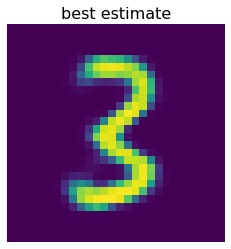

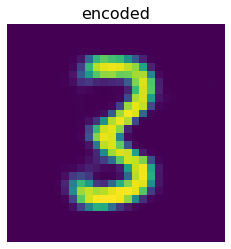

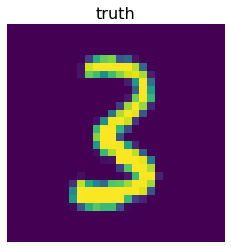

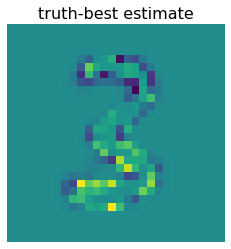

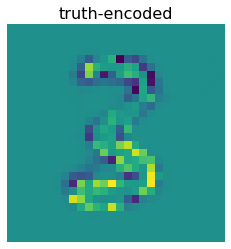

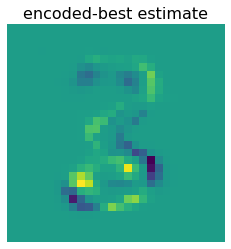

In [21]:
plt.title('best estimate')
plt.imshow(x_esti.reshape(28,28))
plt.axis('off')
plt.show()
plt.title('encoded')
plt.imshow(x_enc.reshape(28,28))
plt.axis('off')
plt.show()
plt.title('truth')
plt.imshow(x_valid[0].reshape(28,28))
plt.axis('off')
plt.show()
plt.title('truth-best estimate')
plt.imshow(x_valid[0].reshape(28,28)-x_esti.reshape(28,28))
plt.axis('off')
plt.show()
plt.title('truth-encoded')
plt.imshow(x_valid[0].reshape(28,28)-x_enc.reshape(28,28))
plt.axis('off')
plt.show()
plt.title('encoded-best estimate')
plt.imshow(x_enc.reshape(28,28)-x_esti.reshape(28,28))
plt.axis('off')
plt.show()

In [22]:
import bayesfast as bf

In [23]:
logp(best_z)

1780.1810302734375

In [24]:
import autograd.numpy as np
import numpy.linalg as linalg
from autograd import grad

# toy example
means = [np.asarray([1.,-4.]), np.asarray([-2.,2.])]
covs  = [np.asarray([[2.,-0.5,],[-0.5,2]]),np.asarray([[2,0.5],[0.5,2]])]
weights = [0.5,0.5]

# checking for pos def
for cov in covs:
    _ = linalg.cholesky(cov)
    
def create_neg_log_prob(means, covs,weights):
    
    def negative_log_prob(x):
        gs = []
        N  = means[0].shape[0]
        for mean,cov in zip(means,covs):
            m = (x-mean)
            _, det= np.linalg.slogdet(cov)
            gs+=[-0.5*np.dot(m,np.dot(cov,m))-N/2.*np.log(2*np.pi)-N*det]
        res = gs[0]+weights[0]
        for ii, w in enumerate(weights[1::]):
            res=np.logaddexp(res,w+gs[ii+1])
        return res
    return negative_log_prob

negative_log_prob      = create_neg_log_prob(means,covs,weights)
negative_log_prob_grad = grad(negative_log_prob)

In [65]:
begin = time.time()
for _ in range(1000):
    negative_log_prob(np.asarray([0.,0.]))
print((time.time()-begin)/1000)

6.355094909667969e-05


In [66]:
den = bf.DensityLite(logp=negative_log_prob, grad=negative_log_prob_grad, input_size=2, hard_bounds=False)

In [67]:
sampling_params = dict(n_chain=2, n_iter=10000, n_warmup=1000, x_0=np.asarray([0.,0.]),
                 random_generator=None, step_size=None, adapt_step_size=True,
                 metric='diag', adapt_metric=True, max_change=1000.,
                 target_accept=0.6, gamma=0.05, k=0.75, t_0=10.,
                 initial_mean=None, initial_weight=10., adapt_window=60,
                 update_window=1, doubling=True)

In [68]:
res = bf.sample(den, sample_trace=sampling_params)

 CHAIN #0 : sampling proceeding [ 2000 / 10000 ], last 2000 samples used 8.26 seconds.
 CHAIN #1 : sampling proceeding [ 2000 / 10000 ], last 2000 samples used 9.21 seconds.
 CHAIN #0 : sampling proceeding [ 4000 / 10000 ], last 2000 samples used 10.59 seconds.
 CHAIN #1 : sampling proceeding [ 4000 / 10000 ], last 2000 samples used 10.89 seconds.
 CHAIN #0 : sampling proceeding [ 6000 / 10000 ], last 2000 samples used 8.01 seconds.
 CHAIN #1 : sampling proceeding [ 6000 / 10000 ], last 2000 samples used 8.53 seconds.
 CHAIN #0 : sampling proceeding [ 8000 / 10000 ], last 2000 samples used 8.43 seconds.
 CHAIN #1 : sampling proceeding [ 8000 / 10000 ], last 2000 samples used 8.54 seconds.
 CHAIN #0 : sampling finished [ 10000 / 10000 ], obtained 10000 samples in 45.29 seconds.
 CHAIN #1 : sampling finished [ 10000 / 10000 ], obtained 10000 samples in 48.43 seconds.


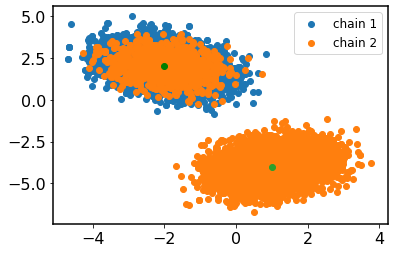

In [70]:
plt.scatter(res.samples[0,:,0],res.samples[0,:,1],label='chain 1')
plt.scatter(res.samples[1,:,0],res.samples[1,:,1], label='chain 2')
plt.scatter(means[0][0], means[0][1])
plt.scatter(means[1][0], means[1][1], color='g')
plt.legend()
plt.show()

In [ ]:
plt.scatter(samples[:,0],samples[:,1])
plt.scatter(means[0][0], means[0][1])
plt.scatter(means[1][0], means[1][1], color='g')
plt.show()

In [25]:
den = bf.DensityLite(logp=logp, grad=logp_grad, input_size=10, hard_bounds=False)

In [27]:
sampling_params = dict(n_chain=1, n_iter=1000, n_warmup=100, x_0=best_z,
                 random_generator=None, step_size=1e-6, adapt_step_size=False,
                 metric='diag', adapt_metric=False, max_change=1000.,
                 target_accept=0.6, gamma=0.05, k=0.75, t_0=10.,
                 initial_mean=None, initial_weight=1., adapt_window=60,
                 update_window=1, doubling=True)

In [28]:
res = bf.sample(den, sample_trace=sampling_params)

Process ForkPoolWorker-81:
Process ForkPoolWorker-47:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Process ForkPoolWorker-48:
  File "/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/multiprocess/pool.py", line 114, in worker
    task = get()
  File "/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/multiprocess/queues.py", line 358, in get
    with self._rlock:
Process ForkPoolWorker-46:
  File "/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/multiprocess/synchronize.py", line 101, in __enter__
    return self._semlock.__enter__()
Process ForkPoolWorker-80:
Traceback (most recent call last):
Traceback (m

Traceback (most recent call last):
  File "/global/u2/v/vboehm/codes/bayesfast/bayesfast/core/sample.py", line 167, in sample
    tt = parallel_backend.map(
  File "/global/u2/v/vboehm/codes/bayesfast/bayesfast/utils/parallel.py", line 121, in map
    return self.backend_activated.starmap(fun, zip(*iters))
  File "/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/multiprocess/pool.py", line 372, in starmap
    return self._map_async(func, iterable, starmapstar, chunksize).get()
  File "/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/multiprocess/pool.py", line 765, in get
    self.wait(timeout)
  File "/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/multiprocess/pool.py", line 762, in wait
    self._event.wait(timeout)
  File "/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/threading.py", line 558, in wait
    signaled = self._cond.wait(timeout)
  File "/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/threading.py", l

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/global/u2/v/vboehm/codes/bayesfast/bayesfast/core/sample.py", line 167, in sample
    tt = parallel_backend.map(
  File "/global/u2/v/vboehm/codes/bayesfast/bayesfast/utils/parallel.py", line 121, in map
    return self.backend_activated.starmap(fun, zip(*iters))
  File "/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/multiprocess/pool.py", line 372, in starmap
    return self._map_async(func, iterable, starmapstar, chunksize).get()
  File "/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/multiprocess/pool.py", line 765, in get
    self.wait(timeout)
  File "/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/multiprocess/pool.py", line 762, in wait
    self._event.wait(timeout)
  File "/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/threading.py", line 558, in wait
    signaled = self._cond.wait(timeout)
  File "/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/threading.py", l

TypeError: can only concatenate str (not "list") to str

In [ ]:
class DualAveragingStepSize:
    def __init__(self, initial_step_size, target_accept=0.5, gamma=0.05, t0=10.0, kappa=0.75):
        self.mu            = np.log(10 * initial_step_size)  # proposals are biased upwards to stay away from 0.
        self.target_accept = target_accept
        self.gamma         = gamma
        self.t             = t0
        self.kappa         = kappa
        self.error_sum     = 0
        self.log_averaged_step = 0

    def update(self, p_accept):
        # Running tally of absolute error. Can be positive or negative. Want to be 0.
        self.error_sum += self.target_accept - p_accept
        
        #print(self.error_sum)

        # This is the next proposed (log) step size. Note it is biased towards mu.
        log_step = self.mu - self.error_sum / (np.sqrt(self.t) * self.gamma)

        # Forgetting rate. As `t` gets bigger, `eta` gets smaller.
        eta = self.t ** -self.kappa

        # Smoothed average step size
        self.log_averaged_step = eta * log_step + (1 - eta) * self.log_averaged_step

        # This is a stateful update, so t keeps updating
        self.t += 1

        # Return both the noisy step size, and the smoothed step size
        return np.exp(log_step), np.exp(self.log_averaged_step)

In [ ]:
import scipy.stats as st
from tqdm import tqdm

def leapfrog(q, p, dVdq, path_len, step_size):
    """Leapfrog integrator for Hamiltonian Monte Carlo.

    Parameters
    ----------
    q : np.floatX
        Initial position
    p : np.floatX
        Initial momentum
    dVdq : callable
        Gradient of the velocity
    path_len : float
        How long to integrate for
    step_size : float
        How long each integration step should be

    Returns
    -------
    q, p : np.floatX, np.floatX
        New position and momentum
    """
    q, p = np.copy(q), np.copy(p)

    p -= step_size * dVdq(q) / 2  # half step

    for ii in range(int(path_len / step_size) - 1):
        print(ii)
        q += step_size * p  # whole step
        p -= step_size * dVdq(q)  # whole step
    q += step_size * p  # whole step
    p -= step_size * dVdq(q) / 2  # half step

    # momentum flip at end
    return q, -p


In [ ]:
def hamiltonian_monte_carlo(n_samples, negative_log_prob, dVdq , initial_position, path_len=1, step_size=0.05, tune=500, verbose=False):
    """Run Hamiltonian Monte Carlo sampling.

    Parameters
    ----------
    n_samples : int
        Number of samples to return
    negative_log_prob : callable
        The negative log probability to sample from
    initial_position : np.array
        A place to start sampling from.
    path_len : float
        How long each integration path is. Smaller is faster and more correlated.
    step_size : float
        How long each integration step is. Smaller is slower and more accurate.

    Returns
    -------
    np.array
        Array of length `n_samples`.
    """

    # collect all our samples in a list
    samples = [initial_position]

    # Keep a single object for momentum resampling
    momentum = st.norm(0, 1)

    # If initial_position is a 10d vector and n_samples is 100, we want
    # 100 x 10 momentum draws. We can do this in one call to momentum.rvs, and
    # iterate over rows
    size = (n_samples,) + initial_position.shape[:1]
    step_size_tuning = DualAveragingStepSize(initial_step_size=step_size)
    accepted=1
    for idx, p0 in tqdm(enumerate(momentum.rvs(size=size)), total=size[0]):
        # Integrate over our path to get a new position and momentum
        q_new, p_new = leapfrog(
            samples[-1],
            p0,
            dVdq,
            path_len=path_len,
            step_size=step_size,
        )


        # Check Metropolis acceptance criterion
        start_log_p = negative_log_prob(samples[-1]) - np.sum(momentum.logpdf(p0))
        new_log_p   = negative_log_prob(q_new) - np.sum(momentum.logpdf(p_new))
        p_accept    = accepted/len(samples)#np.exp(start_log_p - new_log_p)#accepted/len(samples)
        if np.log(np.random.rand()) < start_log_p - new_log_p:
            samples.append(q_new)
            accepted+=1
            if verbose:
                print('current acceptance ratio:', accepted/len(samples))
        else:
            samples.append(np.copy(samples[-1]))
        if(np.any(np.isnan(q_new))):
            print('diverged')
            break

        # Tuning routine
        if idx < tune - 1:
            step_size, _ = step_size_tuning.update(p_accept)
        elif idx == tune - 1:
            _, step_size = step_size_tuning.update(p_accept)
            if verbose:
                print(step_size)

    return np.array(samples[1+tune:]), step_size, p_accept

In [ ]:
t_start=time.time()
samples= hamiltonian_monte_carlo(n_samples=10000, negative_log_prob=negative_log_prob, dVdq=negative_log_prob_grad , initial_position=np.asarray([0.,0.]), tune=500, path_len=, step_size=0.5)
t_stop = time.time()
print("Sampling Completed in %0.2f seconds" % (t_stop - t_start))

In [169]:
samples

array([[-1.53766848,  3.07082015],
       [-2.31643798,  1.99066378],
       [-2.59828421,  1.63189751],
       ...,
       [ 2.10538398, -3.53307654],
       [ 2.10538398, -3.53307654],
       [ 1.63072887, -3.43884165]])

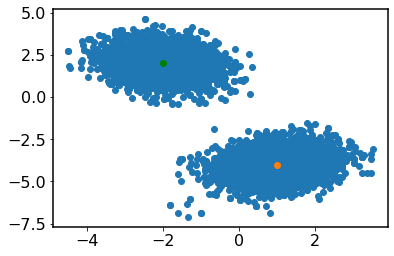

In [170]:
plt.scatter(samples[:,0],samples[:,1])
plt.scatter(means[0][0], means[0][1])
plt.scatter(means[1][0], means[1][1], color='g')
plt.show()

In [57]:
neg_logp_grad(best_z)

NameError: name 'best_z' is not defined

In [58]:
import time

In [59]:
0.001/0.0001

10.0

In [77]:
for i in range(int(0.001/0.0051742126773645656)-1):
    print(i)

In [80]:
t_start=time.time()
tune = 500
step_size = 0.0001
init = best_z
for ii in range(10):
    samples, step_size, p_accept= hamiltonian_monte_carlo(n_samples=10000, negative_log_prob=neg_logp, dVdq=neg_logp_grad , initial_position=init, path_len=0.001, step_size=step_size, tune=tune, verbose=True)
    print(p_accept)
    init = samples[-1]
    np.save('./samples%d.npy'%ii,samples)
    print(step_size)
    tune = 0
t_stop = time.time()-2
print("Sampling Completed in %0.2f seconds" % (t_stop - t_start))

  0%|          | 0/10000 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8


  0%|          | 3/10000 [00:00<33:29,  4.97it/s]

current acceptance ratio: 1.0
current acceptance ratio: 1.0


  0%|          | 15/10000 [00:01<13:23, 12.43it/s]

current acceptance ratio: 0.26666666666666666
current acceptance ratio: 0.3125
current acceptance ratio: 0.35294117647058826


  0%|          | 18/10000 [00:01<16:33, 10.04it/s]

0
1
current acceptance ratio: 0.3684210526315789
0
1
2
3
4
0
1
2
3
4
5
6
7
8


  0%|          | 20/10000 [00:02<20:45,  8.01it/s]

current acceptance ratio: 0.38095238095238093
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
current acceptance ratio: 0.4090909090909091
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


  0%|          | 22/10000 [00:02<33:15,  5.00it/s]

current acceptance ratio: 0.43478260869565216
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


  0%|          | 23/10000 [00:03<1:02:58,  2.64it/s]

30
current acceptance ratio: 0.4583333333333333
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


  0%|          | 24/10000 [00:04<1:29:08,  1.87it/s]

37
current acceptance ratio: 0.48
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


  0%|          | 25/10000 [00:05<1:42:35,  1.62it/s]

34
35
36
37
38
39
40
current acceptance ratio: 0.5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


  0%|          | 26/10000 [00:06<2:00:47,  1.38it/s]

39
40
41
current acceptance ratio: 0.5185185185185185
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


  0%|          | 27/10000 [00:06<2:00:39,  1.38it/s]

30
31
32
33
34
35
36
37
38
current acceptance ratio: 0.5357142857142857
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


  0%|          | 28/10000 [00:07<2:05:32,  1.32it/s]

29
30
31
32
33
34
current acceptance ratio: 0.5517241379310345
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


  0%|          | 29/10000 [00:08<2:00:55,  1.37it/s]

26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


  0%|          | 30/10000 [00:08<1:44:36,  1.59it/s]

21
22
23
current acceptance ratio: 0.5483870967741935
0
1
2
3
4
5
6
7
8
9
10
11
12
13


  0%|          | 31/10000 [00:09<1:37:49,  1.70it/s]

14
15
16
17
18
19
current acceptance ratio: 0.5625
0
1
2
3
4
5
6
7
8
9
10
11
12


  0%|          | 32/10000 [00:09<1:27:43,  1.89it/s]

13
14
15
current acceptance ratio: 0.5757575757575758
0
1
2
3
4
5


  0%|          | 33/10000 [00:10<1:17:36,  2.14it/s]

6
7
8
9
10
11
12
current acceptance ratio: 0.5882352941176471
0
1
2
3
4
5
6
7
8


  0%|          | 34/10000 [00:10<1:06:36,  2.49it/s]

current acceptance ratio: 0.6
0
1
2
3
4
5
6


  0%|          | 36/10000 [00:10<48:01,  3.46it/s]  

current acceptance ratio: 0.6111111111111112
0
1
2
3
current acceptance ratio: 0.6216216216216216
0
1


  0%|          | 39/10000 [00:10<30:47,  5.39it/s]

2
current acceptance ratio: 0.631578947368421
0
current acceptance ratio: 0.6410256410256411
current acceptance ratio: 0.65


  0%|          | 44/10000 [00:11<19:20,  8.58it/s]

current acceptance ratio: 0.6428571428571429
current acceptance ratio: 0.6363636363636364
current acceptance ratio: 0.6444444444444445
current acceptance ratio: 0.6521739130434783


  1%|          | 78/10000 [00:13<09:42, 17.03it/s]

current acceptance ratio: 0.3974358974358974
current acceptance ratio: 0.4050632911392405
current acceptance ratio: 0.4125


  1%|          | 82/10000 [00:13<10:24, 15.89it/s]

current acceptance ratio: 0.41975308641975306
current acceptance ratio: 0.4268292682926829
current acceptance ratio: 0.43373493975903615
current acceptance ratio: 0.44047619047619047
current acceptance ratio: 0.4470588235294118


  1%|          | 88/10000 [00:13<09:03, 18.25it/s]

current acceptance ratio: 0.45348837209302323
current acceptance ratio: 0.45977011494252873
current acceptance ratio: 0.4606741573033708
current acceptance ratio: 0.4666666666666667


  1%|          | 93/10000 [00:13<08:22, 19.73it/s]

current acceptance ratio: 0.4725274725274725
current acceptance ratio: 0.4782608695652174
current acceptance ratio: 0.4838709677419355
current acceptance ratio: 0.48936170212765956
current acceptance ratio: 0.49473684210526314


  1%|          | 98/10000 [00:14<08:48, 18.72it/s]

current acceptance ratio: 0.5
current acceptance ratio: 0.5051546391752577
current acceptance ratio: 0.5102040816326531
current acceptance ratio: 0.5151515151515151


  1%|          | 103/10000 [00:14<08:12, 20.10it/s]

current acceptance ratio: 0.52
current acceptance ratio: 0.5247524752475248
current acceptance ratio: 0.5294117647058824
current acceptance ratio: 0.5339805825242718
current acceptance ratio: 0.5384615384615384


  1%|          | 106/10000 [00:14<08:04, 20.44it/s]

current acceptance ratio: 0.5428571428571428
current acceptance ratio: 0.5471698113207547
current acceptance ratio: 0.5514018691588785
current acceptance ratio: 0.5555555555555556
current acceptance ratio: 0.5596330275229358


  1%|          | 111/10000 [00:14<08:34, 19.20it/s]

current acceptance ratio: 0.5636363636363636
current acceptance ratio: 0.5675675675675675


  1%|          | 117/10000 [00:15<07:48, 21.10it/s]

current acceptance ratio: 0.5614035087719298
current acceptance ratio: 0.5555555555555556


  1%|          | 120/10000 [00:15<07:34, 21.74it/s]

current acceptance ratio: 0.5546218487394958
current acceptance ratio: 0.5537190082644629
current acceptance ratio: 0.5573770491803278


  1%|▏         | 126/10000 [00:15<08:40, 18.96it/s]

current acceptance ratio: 0.5564516129032258


  1%|▏         | 131/10000 [00:15<08:15, 19.93it/s]

current acceptance ratio: 0.546875
current acceptance ratio: 0.5503875968992248
current acceptance ratio: 0.5454545454545454


  1%|▏         | 137/10000 [00:16<07:40, 21.44it/s]

current acceptance ratio: 0.5407407407407407


  1%|▏         | 147/10000 [00:16<09:35, 17.11it/s]

current acceptance ratio: 0.5068493150684932


  2%|▏         | 155/10000 [00:17<10:36, 15.46it/s]

current acceptance ratio: 0.49019607843137253
current acceptance ratio: 0.4935064935064935
current acceptance ratio: 0.4967741935483871
current acceptance ratio: 0.5


  2%|▏         | 163/10000 [00:17<10:00, 16.38it/s]

current acceptance ratio: 0.4876543209876543


  2%|▏         | 168/10000 [00:18<09:20, 17.53it/s]

current acceptance ratio: 0.4819277108433735
current acceptance ratio: 0.48214285714285715


  2%|▏         | 173/10000 [00:18<09:24, 17.41it/s]

current acceptance ratio: 0.4823529411764706


  2%|▏         | 178/10000 [00:18<09:11, 17.81it/s]

current acceptance ratio: 0.4689265536723164
current acceptance ratio: 0.47191011235955055
current acceptance ratio: 0.4722222222222222


  2%|▏         | 184/10000 [00:18<09:39, 16.93it/s]

current acceptance ratio: 0.46994535519125685
current acceptance ratio: 0.4702702702702703
current acceptance ratio: 0.4731182795698925


  2%|▏         | 190/10000 [00:19<09:49, 16.63it/s]

current acceptance ratio: 0.4734042553191489
current acceptance ratio: 0.47619047619047616
current acceptance ratio: 0.47643979057591623


  2%|▏         | 194/10000 [00:19<10:00, 16.32it/s]

current acceptance ratio: 0.4791666666666667
current acceptance ratio: 0.48186528497409326
current acceptance ratio: 0.4845360824742268
current acceptance ratio: 0.48717948717948717


  2%|▏         | 199/10000 [00:19<09:21, 17.46it/s]

current acceptance ratio: 0.4897959183673469
current acceptance ratio: 0.49238578680203043
current acceptance ratio: 0.494949494949495
current acceptance ratio: 0.495


  2%|▏         | 203/10000 [00:20<09:41, 16.84it/s]

current acceptance ratio: 0.4975124378109453
current acceptance ratio: 0.4975369458128079
current acceptance ratio: 0.5


  2%|▏         | 208/10000 [00:20<08:59, 18.16it/s]

current acceptance ratio: 0.5024390243902439
current acceptance ratio: 0.5
current acceptance ratio: 0.5023923444976076


  2%|▏         | 212/10000 [00:20<08:43, 18.69it/s]

current acceptance ratio: 0.5047619047619047
current acceptance ratio: 0.5071090047393365
current acceptance ratio: 0.5094339622641509
current acceptance ratio: 0.5117370892018779


  2%|▏         | 216/10000 [00:20<09:18, 17.52it/s]

current acceptance ratio: 0.514018691588785
current acceptance ratio: 0.5162790697674419
current acceptance ratio: 0.5185185185185185
current acceptance ratio: 0.5207373271889401


  2%|▏         | 220/10000 [00:21<09:14, 17.63it/s]

current acceptance ratio: 0.5205479452054794
current acceptance ratio: 0.5180180180180181


  2%|▏         | 224/10000 [00:21<09:44, 16.73it/s]

current acceptance ratio: 0.5201793721973094
current acceptance ratio: 0.5223214285714286
current acceptance ratio: 0.5221238938053098


  2%|▏         | 228/10000 [00:21<09:25, 17.29it/s]

current acceptance ratio: 0.5242290748898678
current acceptance ratio: 0.5263157894736842
current acceptance ratio: 0.5283842794759825
current acceptance ratio: 0.5304347826086957


  2%|▏         | 233/10000 [00:21<09:12, 17.68it/s]

current acceptance ratio: 0.5324675324675324
current acceptance ratio: 0.5344827586206896
current acceptance ratio: 0.5364806866952789


  2%|▏         | 241/10000 [00:22<10:13, 15.90it/s]

current acceptance ratio: 0.525
current acceptance ratio: 0.5269709543568465


  2%|▏         | 247/10000 [00:22<11:03, 14.71it/s]

current acceptance ratio: 0.5224489795918368
current acceptance ratio: 0.5222672064777328


  2%|▏         | 249/10000 [00:22<11:16, 14.42it/s]

current acceptance ratio: 0.5220883534136547
current acceptance ratio: 0.5219123505976095


  3%|▎         | 258/10000 [00:23<09:56, 16.33it/s]

current acceptance ratio: 0.515625
current acceptance ratio: 0.5175097276264592


  3%|▎         | 262/10000 [00:23<09:39, 16.82it/s]

current acceptance ratio: 0.5153846153846153
current acceptance ratio: 0.5152671755725191


  3%|▎         | 271/10000 [00:24<07:27, 21.73it/s]

current acceptance ratio: 0.5093632958801498
current acceptance ratio: 0.5092936802973977
current acceptance ratio: 0.5092250922509225


  3%|▎         | 277/10000 [00:24<06:53, 23.51it/s]

current acceptance ratio: 0.5091575091575091


  3%|▎         | 292/10000 [00:24<06:57, 23.28it/s]

current acceptance ratio: 0.48109965635738833
current acceptance ratio: 0.4828767123287671
current acceptance ratio: 0.48464163822525597
current acceptance ratio: 0.48639455782312924


  3%|▎         | 298/10000 [00:25<08:17, 19.49it/s]

current acceptance ratio: 0.48484848484848486
current acceptance ratio: 0.4865771812080537
current acceptance ratio: 0.4866666666666667


  3%|▎         | 303/10000 [00:25<09:26, 17.11it/s]

current acceptance ratio: 0.4867549668874172


  3%|▎         | 307/10000 [00:25<10:00, 16.15it/s]

current acceptance ratio: 0.4852459016393443


  3%|▎         | 312/10000 [00:26<08:52, 18.18it/s]

current acceptance ratio: 0.4806451612903226
current acceptance ratio: 0.48231511254019294
current acceptance ratio: 0.483974358974359
current acceptance ratio: 0.4840764331210191


  3%|▎         | 321/10000 [00:26<07:14, 22.28it/s]

current acceptance ratio: 0.4811320754716981
current acceptance ratio: 0.48125
current acceptance ratio: 0.48286604361370716


  3%|▎         | 324/10000 [00:26<08:10, 19.71it/s]

current acceptance ratio: 0.48297213622291024
current acceptance ratio: 0.4845679012345679
current acceptance ratio: 0.48615384615384616


  3%|▎         | 327/10000 [00:26<09:10, 17.56it/s]

current acceptance ratio: 0.48773006134969327
current acceptance ratio: 0.48632218844984804


  3%|▎         | 332/10000 [00:27<09:04, 17.76it/s]

current acceptance ratio: 0.48787878787878786
current acceptance ratio: 0.48942598187311176
current acceptance ratio: 0.4894894894894895
current acceptance ratio: 0.49101796407185627


  3%|▎         | 336/10000 [00:27<10:11, 15.81it/s]

current acceptance ratio: 0.4925373134328358
current acceptance ratio: 0.49404761904761907
current acceptance ratio: 0.49554896142433236


  3%|▎         | 343/10000 [00:27<09:34, 16.80it/s]

current acceptance ratio: 0.49411764705882355
current acceptance ratio: 0.49560117302052786
current acceptance ratio: 0.4956268221574344
current acceptance ratio: 0.49709302325581395


  4%|▎         | 350/10000 [00:28<08:55, 18.03it/s]

current acceptance ratio: 0.4956772334293948
current acceptance ratio: 0.49712643678160917


  4%|▎         | 355/10000 [00:28<08:22, 19.20it/s]

current acceptance ratio: 0.4943181818181818
current acceptance ratio: 0.4943502824858757
current acceptance ratio: 0.49577464788732395


  4%|▎         | 359/10000 [00:28<08:32, 18.81it/s]

current acceptance ratio: 0.4957983193277311
current acceptance ratio: 0.4972067039106145
current acceptance ratio: 0.49722222222222223


  4%|▎         | 363/10000 [00:28<08:45, 18.33it/s]

current acceptance ratio: 0.4986149584487535
current acceptance ratio: 0.5
current acceptance ratio: 0.5013774104683195
current acceptance ratio: 0.5027472527472527


  4%|▎         | 368/10000 [00:29<08:04, 19.89it/s]

current acceptance ratio: 0.5041095890410959
current acceptance ratio: 0.505464480874317
current acceptance ratio: 0.5068119891008175
current acceptance ratio: 0.5081521739130435
current acceptance ratio: 0.5094850948509485


  4%|▎         | 371/10000 [00:29<07:58, 20.12it/s]

current acceptance ratio: 0.5108108108108108
current acceptance ratio: 0.510752688172043
current acceptance ratio: 0.5106951871657754


  4%|▍         | 377/10000 [00:29<07:35, 21.14it/s]

current acceptance ratio: 0.512
current acceptance ratio: 0.5119363395225465
current acceptance ratio: 0.5132275132275133
current acceptance ratio: 0.5145118733509235


  4%|▍         | 383/10000 [00:29<07:21, 21.80it/s]

current acceptance ratio: 0.5157894736842106
current acceptance ratio: 0.5170603674540682
current acceptance ratio: 0.518324607329843
current acceptance ratio: 0.5182291666666666


  4%|▍         | 386/10000 [00:29<07:57, 20.15it/s]

current acceptance ratio: 0.5194805194805194
current acceptance ratio: 0.5207253886010362
current acceptance ratio: 0.520618556701031


  4%|▍         | 392/10000 [00:30<07:37, 21.02it/s]

current acceptance ratio: 0.5205128205128206
current acceptance ratio: 0.5217391304347826
current acceptance ratio: 0.5229591836734694
current acceptance ratio: 0.5241730279898219
current acceptance ratio: 0.5253807106598984


  4%|▍         | 399/10000 [00:30<09:36, 16.65it/s]

current acceptance ratio: 0.5226130653266332
current acceptance ratio: 0.5238095238095238
current acceptance ratio: 0.525
current acceptance ratio: 0.5261845386533666


  4%|▍         | 403/10000 [00:30<09:09, 17.45it/s]

current acceptance ratio: 0.527363184079602
current acceptance ratio: 0.5285359801488834
current acceptance ratio: 0.5297029702970297


  4%|▍         | 407/10000 [00:31<09:04, 17.62it/s]

current acceptance ratio: 0.5295566502463054
current acceptance ratio: 0.5281173594132029


  4%|▍         | 409/10000 [00:31<08:47, 18.17it/s]

current acceptance ratio: 0.5292682926829269


  4%|▍         | 413/10000 [00:31<11:27, 13.94it/s]

current acceptance ratio: 0.529126213592233


  4%|▍         | 417/10000 [00:31<11:17, 14.14it/s]

current acceptance ratio: 0.5264423076923077
current acceptance ratio: 0.5275779376498801
current acceptance ratio: 0.5274463007159904


  4%|▍         | 422/10000 [00:32<09:42, 16.43it/s]

current acceptance ratio: 0.5273159144893111
current acceptance ratio: 0.5271867612293144
current acceptance ratio: 0.5283018867924528


  4%|▍         | 433/10000 [00:32<09:06, 17.52it/s]

current acceptance ratio: 0.5232558139534884


  4%|▍         | 438/10000 [00:33<08:48, 18.11it/s]

current acceptance ratio: 0.5195402298850574
current acceptance ratio: 0.5182648401826484
current acceptance ratio: 0.5193621867881549


  4%|▍         | 444/10000 [00:33<10:01, 15.89it/s]

current acceptance ratio: 0.5169300225733634


  4%|▍         | 450/10000 [00:33<09:55, 16.05it/s]

current acceptance ratio: 0.5133928571428571


  5%|▍         | 455/10000 [00:34<09:26, 16.85it/s]

current acceptance ratio: 0.5110619469026548
current acceptance ratio: 0.5110132158590308
current acceptance ratio: 0.512087912087912
current acceptance ratio: 0.5131578947368421


  5%|▍         | 461/10000 [00:34<08:29, 18.72it/s]

current acceptance ratio: 0.5108695652173914


  5%|▍         | 466/10000 [00:34<08:58, 17.71it/s]

current acceptance ratio: 0.5086206896551724


  5%|▍         | 475/10000 [00:35<08:00, 19.84it/s]

current acceptance ratio: 0.49894736842105264


  5%|▍         | 481/10000 [00:35<08:48, 18.00it/s]

current acceptance ratio: 0.4968684759916493
current acceptance ratio: 0.495850622406639


  5%|▍         | 485/10000 [00:35<10:24, 15.24it/s]

current acceptance ratio: 0.4968944099378882
current acceptance ratio: 0.49588477366255146


  5%|▍         | 489/10000 [00:36<11:43, 13.52it/s]

current acceptance ratio: 0.4948875255623722


  5%|▍         | 492/10000 [00:36<10:24, 15.23it/s]

current acceptance ratio: 0.49290060851926976


  5%|▍         | 496/10000 [00:36<12:08, 13.04it/s]

current acceptance ratio: 0.49292929292929294
current acceptance ratio: 0.4939516129032258
current acceptance ratio: 0.4949698189134809


  5%|▌         | 502/10000 [00:36<09:23, 16.85it/s]

current acceptance ratio: 0.4930139720558882
0.008914223309641273
current acceptance ratio: 0.4940239043824701
current acceptance ratio: 0.49502982107355864
current acceptance ratio: 0.49603174603174605


  5%|▌         | 508/10000 [00:37<10:06, 15.65it/s]

current acceptance ratio: 0.49506903353057197
current acceptance ratio: 0.49606299212598426
current acceptance ratio: 0.49607843137254903


  5%|▌         | 512/10000 [00:37<09:35, 16.49it/s]

current acceptance ratio: 0.49706457925636005
current acceptance ratio: 0.498046875
current acceptance ratio: 0.49902534113060426


  5%|▌         | 518/10000 [00:37<08:26, 18.70it/s]

current acceptance ratio: 0.49902912621359224
current acceptance ratio: 0.5
current acceptance ratio: 0.5
current acceptance ratio: 0.5009633911368016


  5%|▌         | 522/10000 [00:37<08:18, 19.01it/s]

current acceptance ratio: 0.5009596928982726
current acceptance ratio: 0.5019157088122606
current acceptance ratio: 0.502868068833652


  5%|▌         | 531/10000 [00:38<07:05, 22.23it/s]

current acceptance ratio: 0.499054820415879
current acceptance ratio: 0.4971857410881801


  5%|▌         | 537/10000 [00:38<07:13, 21.85it/s]

current acceptance ratio: 0.4962686567164179
current acceptance ratio: 0.4962825278810409
current acceptance ratio: 0.4972170686456401


  5%|▌         | 543/10000 [00:38<08:19, 18.93it/s]

current acceptance ratio: 0.496309963099631
current acceptance ratio: 0.4972375690607735


  5%|▌         | 545/10000 [00:39<10:40, 14.77it/s]

current acceptance ratio: 0.4972477064220184
current acceptance ratio: 0.4981684981684982


  6%|▌         | 550/10000 [00:39<09:07, 17.27it/s]

current acceptance ratio: 0.4981751824817518
current acceptance ratio: 0.4990892531876138
current acceptance ratio: 0.5


  6%|▌         | 557/10000 [00:39<07:13, 21.79it/s]

current acceptance ratio: 0.4981949458483754
current acceptance ratio: 0.496415770609319


  6%|▌         | 560/10000 [00:39<07:29, 21.01it/s]

current acceptance ratio: 0.49642857142857144
current acceptance ratio: 0.4955595026642984


  6%|▌         | 568/10000 [00:40<09:24, 16.72it/s]

current acceptance ratio: 0.49382716049382713
current acceptance ratio: 0.4938488576449912


  6%|▌         | 573/10000 [00:40<09:04, 17.32it/s]

current acceptance ratio: 0.4938704028021016
current acceptance ratio: 0.49475524475524474
current acceptance ratio: 0.4956369982547993
current acceptance ratio: 0.4965156794425087


  6%|▌         | 577/10000 [00:40<10:26, 15.03it/s]

current acceptance ratio: 0.4965277777777778
current acceptance ratio: 0.49740034662045063
current acceptance ratio: 0.4982698961937716


  6%|▌         | 582/10000 [00:41<09:09, 17.14it/s]

current acceptance ratio: 0.4991364421416235
current acceptance ratio: 0.5
current acceptance ratio: 0.49914236706689535


  6%|▌         | 588/10000 [00:41<10:30, 14.92it/s]

current acceptance ratio: 0.49829351535836175
current acceptance ratio: 0.49829931972789115
current acceptance ratio: 0.499151103565365


  6%|▌         | 590/10000 [00:41<10:26, 15.02it/s]

current acceptance ratio: 0.5
current acceptance ratio: 0.5008460236886633


  6%|▌         | 594/10000 [00:41<10:54, 14.36it/s]

current acceptance ratio: 0.5008431703204047
current acceptance ratio: 0.5


  6%|▌         | 598/10000 [00:42<10:18, 15.21it/s]

current acceptance ratio: 0.5008375209380235
current acceptance ratio: 0.5016722408026756


  6%|▌         | 602/10000 [00:42<10:40, 14.66it/s]

current acceptance ratio: 0.5008319467554077
current acceptance ratio: 0.5016611295681063


  6%|▌         | 606/10000 [00:42<11:35, 13.50it/s]

current acceptance ratio: 0.5008264462809917


  6%|▌         | 610/10000 [00:43<11:23, 13.74it/s]

current acceptance ratio: 0.49917898193760263
current acceptance ratio: 0.49918166939443537


  6%|▌         | 614/10000 [00:43<10:29, 14.92it/s]

current acceptance ratio: 0.499184339314845
current acceptance ratio: 0.4991869918699187
current acceptance ratio: 0.5


  6%|▌         | 618/10000 [00:43<09:33, 16.37it/s]

current acceptance ratio: 0.5008103727714749
current acceptance ratio: 0.5008077544426495


  6%|▌         | 624/10000 [00:43<09:31, 16.40it/s]

current acceptance ratio: 0.5
current acceptance ratio: 0.5008025682182986
current acceptance ratio: 0.5016025641025641
current acceptance ratio: 0.5024


  6%|▋         | 628/10000 [00:44<09:27, 16.53it/s]

current acceptance ratio: 0.5023923444976076
current acceptance ratio: 0.5031847133757962
current acceptance ratio: 0.5039745627980922
current acceptance ratio: 0.5047619047619047


  6%|▋         | 633/10000 [00:44<08:17, 18.84it/s]

current acceptance ratio: 0.504746835443038
current acceptance ratio: 0.5055292259083728
current acceptance ratio: 0.5055118110236221


  6%|▋         | 644/10000 [00:45<09:16, 16.83it/s]

current acceptance ratio: 0.5023400936037441
current acceptance ratio: 0.5007751937984496


  6%|▋         | 648/10000 [00:45<09:37, 16.18it/s]

current acceptance ratio: 0.5015479876160991
current acceptance ratio: 0.5023183925811437


  7%|▋         | 653/10000 [00:45<08:54, 17.49it/s]

current acceptance ratio: 0.5015384615384615


  7%|▋         | 664/10000 [00:46<07:56, 19.61it/s]

current acceptance ratio: 0.49321266968325794
current acceptance ratio: 0.4939759036144578
current acceptance ratio: 0.49473684210526314


  7%|▋         | 667/10000 [00:46<07:57, 19.55it/s]

current acceptance ratio: 0.4947526236881559
current acceptance ratio: 0.49402985074626865


  7%|▋         | 673/10000 [00:46<07:52, 19.75it/s]

current acceptance ratio: 0.4947839046199702
current acceptance ratio: 0.4947994056463596
current acceptance ratio: 0.49554896142433236
current acceptance ratio: 0.4962962962962963


  7%|▋         | 679/10000 [00:46<07:42, 20.17it/s]

current acceptance ratio: 0.4970414201183432
current acceptance ratio: 0.4970501474926254


  7%|▋         | 682/10000 [00:47<09:15, 16.79it/s]

current acceptance ratio: 0.49487554904831627
current acceptance ratio: 0.4956140350877193


  7%|▋         | 686/10000 [00:47<12:25, 12.49it/s]

current acceptance ratio: 0.49635036496350365
current acceptance ratio: 0.4970845481049563


  7%|▋         | 692/10000 [00:48<13:50, 11.21it/s]

current acceptance ratio: 0.49421965317919075


  7%|▋         | 697/10000 [00:48<11:15, 13.78it/s]

current acceptance ratio: 0.4942363112391931
current acceptance ratio: 0.4942528735632184
current acceptance ratio: 0.4949784791965567
current acceptance ratio: 0.49570200573065903


  7%|▋         | 709/10000 [00:49<09:01, 17.16it/s]

current acceptance ratio: 0.4908062234794908
current acceptance ratio: 0.48945147679324896


  7%|▋         | 717/10000 [00:49<07:27, 20.72it/s]

current acceptance ratio: 0.4894810659186536
current acceptance ratio: 0.4881450488145049
current acceptance ratio: 0.48885793871866295


  7%|▋         | 720/10000 [00:49<07:30, 20.60it/s]

current acceptance ratio: 0.48956884561891517
current acceptance ratio: 0.49027777777777776


  7%|▋         | 726/10000 [00:49<07:18, 21.16it/s]

current acceptance ratio: 0.48760330578512395
current acceptance ratio: 0.4876373626373626


  7%|▋         | 735/10000 [00:50<07:44, 19.96it/s]

current acceptance ratio: 0.48501362397820164
current acceptance ratio: 0.4843962008141113


  7%|▋         | 741/10000 [00:50<07:31, 20.52it/s]

current acceptance ratio: 0.4837837837837838
current acceptance ratio: 0.4838274932614555
current acceptance ratio: 0.4845222072678331


  7%|▋         | 746/10000 [00:50<09:54, 15.57it/s]

current acceptance ratio: 0.48456375838926175


  8%|▊         | 750/10000 [00:51<09:36, 16.04it/s]

current acceptance ratio: 0.4839572192513369
current acceptance ratio: 0.484
current acceptance ratio: 0.48468708388814913


  8%|▊         | 754/10000 [00:51<09:06, 16.92it/s]

current acceptance ratio: 0.4853723404255319


  8%|▊         | 759/10000 [00:51<08:23, 18.35it/s]

current acceptance ratio: 0.48412698412698413
current acceptance ratio: 0.48353096179183136
current acceptance ratio: 0.4842105263157895


  8%|▊         | 764/10000 [00:51<08:05, 19.02it/s]

current acceptance ratio: 0.48488830486202367
current acceptance ratio: 0.48556430446194226
current acceptance ratio: 0.48623853211009177
current acceptance ratio: 0.48627450980392156


  8%|▊         | 769/10000 [00:52<07:55, 19.41it/s]

current acceptance ratio: 0.4869451697127937
current acceptance ratio: 0.4869791666666667
current acceptance ratio: 0.48764629388816644


  8%|▊         | 772/10000 [00:52<07:39, 20.08it/s]

current acceptance ratio: 0.4876783398184176
current acceptance ratio: 0.4870801033591731
current acceptance ratio: 0.48774193548387096


  8%|▊         | 780/10000 [00:52<07:30, 20.46it/s]

current acceptance ratio: 0.4877734877734878
current acceptance ratio: 0.4884318766066838


  8%|▊         | 783/10000 [00:52<08:31, 18.01it/s]

current acceptance ratio: 0.48721227621483376
current acceptance ratio: 0.4872448979591837


  8%|▊         | 787/10000 [00:53<10:59, 13.98it/s]

current acceptance ratio: 0.4872773536895674
current acceptance ratio: 0.48792884371029227
current acceptance ratio: 0.4885786802030457


  8%|▊         | 791/10000 [00:53<10:52, 14.12it/s]

current acceptance ratio: 0.48860759493670886
current acceptance ratio: 0.4892541087231353
current acceptance ratio: 0.4898989898989899
current acceptance ratio: 0.4905422446406053


  8%|▊         | 803/10000 [00:54<08:38, 17.74it/s]

current acceptance ratio: 0.4868913857677903
current acceptance ratio: 0.48692403486924035
current acceptance ratio: 0.48756218905472637
current acceptance ratio: 0.48819875776397514


  8%|▊         | 809/10000 [00:54<09:30, 16.10it/s]

current acceptance ratio: 0.4876237623762376
current acceptance ratio: 0.48825710754017304


  8%|▊         | 813/10000 [00:54<08:36, 17.78it/s]

current acceptance ratio: 0.4876847290640394


  8%|▊         | 820/10000 [00:55<08:35, 17.82it/s]

current acceptance ratio: 0.48533007334963324
current acceptance ratio: 0.4853658536585366


  8%|▊         | 826/10000 [00:55<08:23, 18.23it/s]

current acceptance ratio: 0.4842233009708738
current acceptance ratio: 0.48484848484848486
current acceptance ratio: 0.4848851269649335


  8%|▊         | 828/10000 [00:55<08:33, 17.87it/s]

current acceptance ratio: 0.4855072463768116


  8%|▊         | 834/10000 [00:56<09:27, 16.17it/s]

current acceptance ratio: 0.484375
current acceptance ratio: 0.48383233532934133


  8%|▊         | 839/10000 [00:56<08:44, 17.47it/s]

current acceptance ratio: 0.48444976076555024
current acceptance ratio: 0.4850657108721625
current acceptance ratio: 0.48510131108462456


  8%|▊         | 844/10000 [00:56<07:49, 19.51it/s]

current acceptance ratio: 0.4845605700712589
current acceptance ratio: 0.4851720047449585
current acceptance ratio: 0.48520710059171596
current acceptance ratio: 0.4858156028368794


  8%|▊         | 850/10000 [00:56<07:13, 21.09it/s]

current acceptance ratio: 0.48642266824085006
current acceptance ratio: 0.48645465253239106
current acceptance ratio: 0.48705882352941177


  9%|▊         | 853/10000 [00:56<07:14, 21.03it/s]

current acceptance ratio: 0.48708920187793425
current acceptance ratio: 0.48711943793911006
current acceptance ratio: 0.48771929824561405


  9%|▊         | 859/10000 [00:57<06:55, 22.01it/s]

current acceptance ratio: 0.48717948717948717
current acceptance ratio: 0.4872093023255814
current acceptance ratio: 0.4872389791183295


  9%|▊         | 868/10000 [00:57<06:50, 22.23it/s]

current acceptance ratio: 0.4867052023121387
current acceptance ratio: 0.4867358708189158
current acceptance ratio: 0.48676639815880324


  9%|▊         | 871/10000 [00:57<07:29, 20.31it/s]

current acceptance ratio: 0.48735632183908045
current acceptance ratio: 0.4868270332187858


  9%|▊         | 874/10000 [00:57<07:33, 20.11it/s]

current acceptance ratio: 0.4868571428571429
current acceptance ratio: 0.4868871151653364


  9%|▉         | 882/10000 [00:58<08:53, 17.09it/s]

current acceptance ratio: 0.4863636363636364


  9%|▉         | 884/10000 [00:58<09:41, 15.69it/s]

current acceptance ratio: 0.4852941176470588
current acceptance ratio: 0.4858757062146893
current acceptance ratio: 0.48645598194130923


  9%|▉         | 888/10000 [00:59<12:21, 12.29it/s]

current acceptance ratio: 0.4864864864864865
current acceptance ratio: 0.48651685393258426


  9%|▉         | 892/10000 [00:59<11:36, 13.08it/s]

current acceptance ratio: 0.48654708520179374


  9%|▉         | 896/10000 [00:59<10:24, 14.58it/s]

current acceptance ratio: 0.4860335195530726
current acceptance ratio: 0.48606465997770343
current acceptance ratio: 0.4866369710467706


  9%|▉         | 907/10000 [01:00<09:52, 15.35it/s]

current acceptance ratio: 0.48344370860927155
current acceptance ratio: 0.48401323042998895
current acceptance ratio: 0.4845814977973568
current acceptance ratio: 0.48514851485148514


  9%|▉         | 911/10000 [01:00<10:12, 14.83it/s]

current acceptance ratio: 0.48518111964873767
current acceptance ratio: 0.48521358159912376


  9%|▉         | 913/10000 [01:00<12:08, 12.47it/s]

current acceptance ratio: 0.48577680525164113
current acceptance ratio: 0.48633879781420764


  9%|▉         | 915/10000 [01:01<14:23, 10.52it/s]

current acceptance ratio: 0.4868995633187773
current acceptance ratio: 0.48745910577971646


  9%|▉         | 919/10000 [01:01<14:24, 10.51it/s]

current acceptance ratio: 0.48748639825897716
current acceptance ratio: 0.4880434782608696


  9%|▉         | 926/10000 [01:01<11:39, 12.98it/s]

current acceptance ratio: 0.4864864864864865
current acceptance ratio: 0.48651564185544766


  9%|▉         | 932/10000 [01:02<12:15, 12.33it/s]

current acceptance ratio: 0.4860215053763441


  9%|▉         | 937/10000 [01:02<10:01, 15.06it/s]

current acceptance ratio: 0.483974358974359


  9%|▉         | 939/10000 [01:02<11:40, 12.94it/s]

current acceptance ratio: 0.483493077742279
current acceptance ratio: 0.48404255319148937
current acceptance ratio: 0.48459086078639746


  9%|▉         | 943/10000 [01:03<11:33, 13.06it/s]

current acceptance ratio: 0.4851380042462845


  9%|▉         | 945/10000 [01:03<12:14, 12.32it/s]

current acceptance ratio: 0.4846560846560847


 10%|▉         | 951/10000 [01:03<10:18, 14.64it/s]

current acceptance ratio: 0.48366701791359323
current acceptance ratio: 0.4842105263157895
current acceptance ratio: 0.4842436974789916


 10%|▉         | 955/10000 [01:04<09:30, 15.85it/s]

current acceptance ratio: 0.48478488982161594
current acceptance ratio: 0.48430962343096234


 10%|▉         | 962/10000 [01:04<08:25, 17.89it/s]

current acceptance ratio: 0.48283038501560877
current acceptance ratio: 0.48336798336798337
current acceptance ratio: 0.483402489626556


 10%|▉         | 968/10000 [01:04<10:35, 14.21it/s]

current acceptance ratio: 0.48293691830403307


 10%|▉         | 973/10000 [01:05<09:00, 16.69it/s]

current acceptance ratio: 0.48098663926002055


 10%|▉         | 979/10000 [01:05<10:41, 14.06it/s]

current acceptance ratio: 0.48004094165813715


 10%|▉         | 983/10000 [01:05<09:52, 15.22it/s]

current acceptance ratio: 0.4786150712830957


 10%|▉         | 988/10000 [01:06<08:37, 17.40it/s]

current acceptance ratio: 0.4776876267748479
current acceptance ratio: 0.4777327935222672


 10%|▉         | 990/10000 [01:06<08:22, 17.94it/s]

current acceptance ratio: 0.4772956609485368


 10%|▉         | 998/10000 [01:06<09:37, 15.59it/s]

current acceptance ratio: 0.4754262788365095


 10%|█         | 1004/10000 [01:06<07:22, 20.33it/s]

current acceptance ratio: 0.472636815920398


 10%|█         | 1012/10000 [01:07<09:32, 15.70it/s]

current acceptance ratio: 0.4717542120911794
current acceptance ratio: 0.47227722772277225


 10%|█         | 1016/10000 [01:07<09:05, 16.47it/s]

current acceptance ratio: 0.470935960591133
current acceptance ratio: 0.4714566929133858
current acceptance ratio: 0.471976401179941


 10%|█         | 1020/10000 [01:08<08:50, 16.92it/s]

current acceptance ratio: 0.47203140333660454
current acceptance ratio: 0.4725490196078431
current acceptance ratio: 0.4730656219392752


 10%|█         | 1024/10000 [01:08<09:26, 15.84it/s]

current acceptance ratio: 0.4731182795698925
current acceptance ratio: 0.4736328125
current acceptance ratio: 0.4741463414634146
current acceptance ratio: 0.4746588693957115
current acceptance ratio: 0.47517039922103216


 10%|█         | 1036/10000 [01:08<08:06, 18.42it/s]

current acceptance ratio: 0.47246376811594204


 10%|█         | 1041/10000 [01:09<08:06, 18.40it/s]

current acceptance ratio: 0.4716073147256978


 10%|█         | 1045/10000 [01:09<10:04, 14.82it/s]

current acceptance ratio: 0.4703065134099617
current acceptance ratio: 0.47081339712918663
current acceptance ratio: 0.4713193116634799


 10%|█         | 1049/10000 [01:09<10:25, 14.31it/s]

current acceptance ratio: 0.4713740458015267
current acceptance ratio: 0.4718779790276454


 11%|█         | 1056/10000 [01:10<08:53, 16.76it/s]

current acceptance ratio: 0.4710351377018044
current acceptance ratio: 0.4710900473933649
current acceptance ratio: 0.4715909090909091


 11%|█         | 1061/10000 [01:10<08:32, 17.45it/s]

current acceptance ratio: 0.4711992445703494


 11%|█         | 1065/10000 [01:10<08:57, 16.63it/s]

current acceptance ratio: 0.4703668861712135
current acceptance ratio: 0.4708646616541353


 11%|█         | 1069/10000 [01:11<09:12, 16.17it/s]

current acceptance ratio: 0.4704779756326148
current acceptance ratio: 0.47097378277153557
current acceptance ratio: 0.47102803738317756


 11%|█         | 1073/10000 [01:11<09:05, 16.37it/s]

current acceptance ratio: 0.4710820895522388
current acceptance ratio: 0.47157502329916123
current acceptance ratio: 0.4720670391061452


 11%|█         | 1087/10000 [01:12<07:51, 18.89it/s]

current acceptance ratio: 0.46863468634686345
current acceptance ratio: 0.46912442396313364
current acceptance ratio: 0.4696132596685083


 11%|█         | 1089/10000 [01:12<08:13, 18.06it/s]

current acceptance ratio: 0.4692378328741965


 11%|█         | 1093/10000 [01:12<09:37, 15.41it/s]

current acceptance ratio: 0.46886446886446886
current acceptance ratio: 0.4693504117108875
current acceptance ratio: 0.46897810218978103


 11%|█         | 1098/10000 [01:12<08:48, 16.84it/s]

current acceptance ratio: 0.46946216955332726


 11%|█         | 1102/10000 [01:12<08:43, 17.01it/s]

current acceptance ratio: 0.46866485013623976


 11%|█         | 1106/10000 [01:13<09:20, 15.88it/s]

current acceptance ratio: 0.4678733031674208
current acceptance ratio: 0.46835443037974683
current acceptance ratio: 0.46883468834688347


 11%|█         | 1112/10000 [01:13<08:24, 17.61it/s]

current acceptance ratio: 0.46804680468046805
current acceptance ratio: 0.46810422282120395
current acceptance ratio: 0.46858168761220825


 11%|█         | 1119/10000 [01:13<07:57, 18.61it/s]

current acceptance ratio: 0.468218442256043


 11%|█         | 1124/10000 [01:14<07:24, 19.95it/s]

current acceptance ratio: 0.46702317290552586
current acceptance ratio: 0.46708185053380785


 11%|█▏        | 1127/10000 [01:14<07:47, 18.97it/s]

current acceptance ratio: 0.46672582076308783
current acceptance ratio: 0.466784765279008
current acceptance ratio: 0.4672566371681416


 11%|█▏        | 1133/10000 [01:14<07:17, 20.29it/s]

current acceptance ratio: 0.4673144876325088
current acceptance ratio: 0.4677846425419241
current acceptance ratio: 0.46825396825396826
current acceptance ratio: 0.4687224669603524
current acceptance ratio: 0.46919014084507044


 11%|█▏        | 1142/10000 [01:15<07:10, 20.60it/s]

current acceptance ratio: 0.4688323090430202
current acceptance ratio: 0.4688869412795793


 11%|█▏        | 1145/10000 [01:15<07:13, 20.42it/s]

current acceptance ratio: 0.46853146853146854
current acceptance ratio: 0.46817785527462946
current acceptance ratio: 0.4686411149825784


 12%|█▏        | 1151/10000 [01:15<07:04, 20.84it/s]

current acceptance ratio: 0.46869565217391307
current acceptance ratio: 0.46875
current acceptance ratio: 0.4683982683982684


 12%|█▏        | 1158/10000 [01:15<06:28, 22.76it/s]

current acceptance ratio: 0.4680483592400691
current acceptance ratio: 0.4681034482758621


 12%|█▏        | 1164/10000 [01:16<07:06, 20.74it/s]

current acceptance ratio: 0.46856158484065463
current acceptance ratio: 0.4690189328743546
current acceptance ratio: 0.46866952789699573


 12%|█▏        | 1167/10000 [01:16<06:49, 21.54it/s]

current acceptance ratio: 0.4691252144082333
current acceptance ratio: 0.46877673224978617
current acceptance ratio: 0.46923076923076923


 12%|█▏        | 1173/10000 [01:16<07:45, 18.97it/s]

current acceptance ratio: 0.46968403074295473
current acceptance ratio: 0.469335604770017


 12%|█▏        | 1179/10000 [01:16<09:18, 15.79it/s]

current acceptance ratio: 0.4689889549702634
current acceptance ratio: 0.4694397283531409


 12%|█▏        | 1183/10000 [01:17<09:10, 16.03it/s]

current acceptance ratio: 0.4690939881456393
current acceptance ratio: 0.46954314720812185
current acceptance ratio: 0.46999154691462386


 12%|█▏        | 1188/10000 [01:17<08:45, 16.75it/s]

current acceptance ratio: 0.46964586846543
current acceptance ratio: 0.4696969696969697
current acceptance ratio: 0.46974789915966386


 12%|█▏        | 1196/10000 [01:17<07:22, 19.89it/s]

current acceptance ratio: 0.4697986577181208
current acceptance ratio: 0.4694560669456067
current acceptance ratio: 0.46950710108604843


 12%|█▏        | 1199/10000 [01:18<08:02, 18.25it/s]

current acceptance ratio: 0.4699499165275459
current acceptance ratio: 0.46960865945045793


 12%|█▏        | 1201/10000 [01:18<08:43, 16.79it/s]

current acceptance ratio: 0.4700499168053245


 12%|█▏        | 1209/10000 [01:18<08:48, 16.64it/s]

current acceptance ratio: 0.4693200663349917
current acceptance ratio: 0.46975973487986744
current acceptance ratio: 0.46980976013234077
current acceptance ratio: 0.47024793388429753


 12%|█▏        | 1217/10000 [01:19<09:24, 15.56it/s]

current acceptance ratio: 0.4691358024691358
current acceptance ratio: 0.4691865242399343


 12%|█▏        | 1221/10000 [01:19<09:48, 14.92it/s]

current acceptance ratio: 0.46885245901639344


 12%|█▏        | 1225/10000 [01:19<09:37, 15.20it/s]

current acceptance ratio: 0.46775510204081633
current acceptance ratio: 0.46818923327895595


 12%|█▏        | 1234/10000 [01:20<08:25, 17.33it/s]

current acceptance ratio: 0.46634225466342255
current acceptance ratio: 0.465642683912692


 12%|█▏        | 1239/10000 [01:20<08:08, 17.92it/s]

current acceptance ratio: 0.46607431340872374
current acceptance ratio: 0.4665052461662631


 12%|█▏        | 1245/10000 [01:20<07:38, 19.08it/s]

current acceptance ratio: 0.4650602409638554
current acceptance ratio: 0.46511627906976744


 12%|█▎        | 1250/10000 [01:21<08:54, 16.36it/s]

current acceptance ratio: 0.46517213771016813
current acceptance ratio: 0.4644852354349561


 13%|█▎        | 1255/10000 [01:21<08:48, 16.55it/s]

current acceptance ratio: 0.4649122807017544
current acceptance ratio: 0.4653386454183267
current acceptance ratio: 0.46576433121019106


 13%|█▎        | 1259/10000 [01:21<09:19, 15.61it/s]

current acceptance ratio: 0.46618933969769294
current acceptance ratio: 0.46624305003971406
current acceptance ratio: 0.4666666666666667


 13%|█▎        | 1263/10000 [01:22<10:17, 14.15it/s]

current acceptance ratio: 0.46671949286846276


 13%|█▎        | 1267/10000 [01:22<09:16, 15.70it/s]

current acceptance ratio: 0.4660347551342812
current acceptance ratio: 0.4657210401891253


 13%|█▎        | 1272/10000 [01:22<08:46, 16.58it/s]

current acceptance ratio: 0.46577498033044845
current acceptance ratio: 0.4661949685534591


 13%|█▎        | 1278/10000 [01:22<08:20, 17.44it/s]

current acceptance ratio: 0.46515270164447925
current acceptance ratio: 0.46484375


 13%|█▎        | 1282/10000 [01:23<08:21, 17.38it/s]

current acceptance ratio: 0.4652615144418423
current acceptance ratio: 0.4656786271450858


 13%|█▎        | 1287/10000 [01:23<07:49, 18.54it/s]

current acceptance ratio: 0.4653696498054475
current acceptance ratio: 0.46470131885182314


 13%|█▎        | 1291/10000 [01:23<08:56, 16.24it/s]

current acceptance ratio: 0.46511627906976744
current acceptance ratio: 0.46553059643687067
current acceptance ratio: 0.46558391337973704


 13%|█▎        | 1295/10000 [01:23<08:35, 16.88it/s]

current acceptance ratio: 0.4659969088098918
current acceptance ratio: 0.4660493827160494


 13%|█▎        | 1301/10000 [01:24<08:59, 16.13it/s]

current acceptance ratio: 0.4657428791377983
current acceptance ratio: 0.46615384615384614
current acceptance ratio: 0.4662058371735791


 13%|█▎        | 1305/10000 [01:24<09:16, 15.63it/s]

current acceptance ratio: 0.46661550268610896
current acceptance ratio: 0.4663093415007657


 13%|█▎        | 1312/10000 [01:25<08:57, 16.15it/s]

current acceptance ratio: 0.4660045836516425
current acceptance ratio: 0.46534653465346537


 13%|█▎        | 1320/10000 [01:25<07:50, 18.44it/s]

current acceptance ratio: 0.4646924829157175
current acceptance ratio: 0.4650986342943854
current acceptance ratio: 0.4655041698256255


 13%|█▎        | 1328/10000 [01:25<07:20, 19.67it/s]

current acceptance ratio: 0.4638009049773756
current acceptance ratio: 0.4642049736247174
current acceptance ratio: 0.4642588412340105
current acceptance ratio: 0.46466165413533833


 13%|█▎        | 1334/10000 [01:26<07:08, 20.21it/s]

current acceptance ratio: 0.4650638617580766
current acceptance ratio: 0.46546546546546547
current acceptance ratio: 0.46551724137931033


 13%|█▎        | 1337/10000 [01:26<08:19, 17.33it/s]

current acceptance ratio: 0.4655688622754491
current acceptance ratio: 0.4656203288490284
current acceptance ratio: 0.46601941747572817


 13%|█▎        | 1346/10000 [01:26<08:42, 16.56it/s]

current acceptance ratio: 0.4650297619047619
current acceptance ratio: 0.4654275092936803


 14%|█▎        | 1350/10000 [01:27<09:35, 15.03it/s]

current acceptance ratio: 0.46513353115727
current acceptance ratio: 0.4651851851851852
current acceptance ratio: 0.4655810510732791


 14%|█▎        | 1352/10000 [01:27<10:15, 14.05it/s]

current acceptance ratio: 0.4656319290465632
current acceptance ratio: 0.46602658788774004


 14%|█▎        | 1354/10000 [01:27<13:31, 10.65it/s]

current acceptance ratio: 0.4664206642066421
current acceptance ratio: 0.4668141592920354


 14%|█▎        | 1356/10000 [01:27<16:03,  8.97it/s]

current acceptance ratio: 0.46720707442888726
current acceptance ratio: 0.46759941089838


 14%|█▎        | 1359/10000 [01:28<16:27,  8.75it/s]

current acceptance ratio: 0.46799116997792495


 14%|█▎        | 1363/10000 [01:28<15:10,  9.48it/s]

current acceptance ratio: 0.4680382072005878
current acceptance ratio: 0.4684287812041116
current acceptance ratio: 0.46881878209831257


 14%|█▎        | 1365/10000 [01:28<13:58, 10.30it/s]

current acceptance ratio: 0.46886446886446886
current acceptance ratio: 0.46891002194586684


 14%|█▎        | 1369/10000 [01:29<13:41, 10.51it/s]

current acceptance ratio: 0.4692982456140351


 14%|█▎        | 1371/10000 [01:29<12:23, 11.61it/s]

current acceptance ratio: 0.46900072939460247
current acceptance ratio: 0.4690458849235251


 14%|█▍        | 1377/10000 [01:29<10:22, 13.85it/s]

current acceptance ratio: 0.4690909090909091


 14%|█▍        | 1379/10000 [01:29<10:42, 13.42it/s]

current acceptance ratio: 0.4684554024655547
current acceptance ratio: 0.4688405797101449
current acceptance ratio: 0.4692251991310644


 14%|█▍        | 1387/10000 [01:30<09:43, 14.76it/s]

current acceptance ratio: 0.46825396825396826


 14%|█▍        | 1392/10000 [01:30<08:47, 16.31it/s]

current acceptance ratio: 0.4676258992805755
current acceptance ratio: 0.4676724137931034
current acceptance ratio: 0.4680545585068198
current acceptance ratio: 0.4684361549497848


 14%|█▍        | 1397/10000 [01:30<07:58, 17.97it/s]

current acceptance ratio: 0.4684813753581662


 14%|█▍        | 1410/10000 [01:31<07:27, 19.19it/s]

current acceptance ratio: 0.46552949538024163
current acceptance ratio: 0.4659090909090909
current acceptance ratio: 0.46595744680851064


 14%|█▍        | 1416/10000 [01:31<06:48, 21.02it/s]

current acceptance ratio: 0.46534653465346537
current acceptance ratio: 0.4657243816254417


 14%|█▍        | 1419/10000 [01:32<06:54, 20.70it/s]

current acceptance ratio: 0.46511627906976744
current acceptance ratio: 0.46549295774647886


 14%|█▍        | 1424/10000 [01:32<07:33, 18.92it/s]

current acceptance ratio: 0.4652143359100492


 14%|█▍        | 1429/10000 [01:32<07:24, 19.26it/s]

current acceptance ratio: 0.46461107217939734
current acceptance ratio: 0.4646606018194542


 14%|█▍        | 1436/10000 [01:32<08:01, 17.78it/s]

current acceptance ratio: 0.4640614096301465
current acceptance ratio: 0.4641114982578397
current acceptance ratio: 0.46448467966573814


 14%|█▍        | 1443/10000 [01:33<07:29, 19.04it/s]

current acceptance ratio: 0.463245492371706


 15%|█▍        | 1451/10000 [01:33<08:00, 17.80it/s]

current acceptance ratio: 0.4616977225672878
current acceptance ratio: 0.46206896551724136
current acceptance ratio: 0.46243969676085456


 15%|█▍        | 1455/10000 [01:34<08:54, 15.98it/s]

current acceptance ratio: 0.46249139710942877
current acceptance ratio: 0.4625429553264605
current acceptance ratio: 0.46291208791208793


 15%|█▍        | 1465/10000 [01:34<08:34, 16.60it/s]

current acceptance ratio: 0.4613807245386193


 15%|█▍        | 1470/10000 [01:34<07:33, 18.81it/s]

current acceptance ratio: 0.45955132562882395
current acceptance ratio: 0.45991847826086957


 15%|█▍        | 1475/10000 [01:35<09:39, 14.70it/s]

current acceptance ratio: 0.4599728629579376
current acceptance ratio: 0.4603389830508475


 15%|█▍        | 1485/10000 [01:35<06:40, 21.26it/s]

current acceptance ratio: 0.4591492234976367
current acceptance ratio: 0.45951417004048584
current acceptance ratio: 0.458950201884253
current acceptance ratio: 0.4593140551445864


 15%|█▍        | 1495/10000 [01:36<08:48, 16.08it/s]

current acceptance ratio: 0.4578313253012048
current acceptance ratio: 0.45788770053475936


 15%|█▌        | 1501/10000 [01:36<07:37, 18.60it/s]

current acceptance ratio: 0.45763842561707807
current acceptance ratio: 0.458


 15%|█▌        | 1504/10000 [01:36<07:14, 19.57it/s]

current acceptance ratio: 0.45683930942895085


 15%|█▌        | 1509/10000 [01:37<09:34, 14.78it/s]

current acceptance ratio: 0.45689655172413796


 15%|█▌        | 1511/10000 [01:37<10:15, 13.79it/s]

current acceptance ratio: 0.456651224354732
current acceptance ratio: 0.456708526107072


 15%|█▌        | 1516/10000 [01:37<09:15, 15.27it/s]

current acceptance ratio: 0.45676567656765676
current acceptance ratio: 0.4571240105540897
current acceptance ratio: 0.45687952600395


 15%|█▌        | 1521/10000 [01:38<09:59, 14.15it/s]

current acceptance ratio: 0.4569362261669954


 15%|█▌        | 1525/10000 [01:38<11:32, 12.23it/s]

current acceptance ratio: 0.4566929133858268


 15%|█▌        | 1533/10000 [01:39<08:51, 15.93it/s]

current acceptance ratio: 0.45555555555555555
current acceptance ratio: 0.4559111691704768


 15%|█▌        | 1538/10000 [01:39<08:11, 17.22it/s]

current acceptance ratio: 0.4547820429407938


 15%|█▌        | 1547/10000 [01:39<08:16, 17.03it/s]

current acceptance ratio: 0.45278137128072443
current acceptance ratio: 0.4531351001939237
current acceptance ratio: 0.4529032258064516


 16%|█▌        | 1552/10000 [01:40<08:15, 17.05it/s]

current acceptance ratio: 0.4529639175257732


 16%|█▌        | 1560/10000 [01:40<07:34, 18.55it/s]

current acceptance ratio: 0.45186136071887034


 16%|█▌        | 1564/10000 [01:40<08:20, 16.87it/s]

current acceptance ratio: 0.4510556621880998
current acceptance ratio: 0.4514066496163683
current acceptance ratio: 0.4517571884984026


 16%|█▌        | 1568/10000 [01:41<10:01, 14.01it/s]

current acceptance ratio: 0.4518187619655393
current acceptance ratio: 0.4518801784576163


 16%|█▌        | 1570/10000 [01:41<10:29, 13.39it/s]

current acceptance ratio: 0.45222929936305734


 16%|█▌        | 1576/10000 [01:41<09:16, 15.13it/s]

current acceptance ratio: 0.45171537484116897
current acceptance ratio: 0.4514901712111604


 16%|█▌        | 1580/10000 [01:41<08:45, 16.03it/s]

current acceptance ratio: 0.45183776932826364
current acceptance ratio: 0.4518987341772152
current acceptance ratio: 0.4522454142947502


 16%|█▌        | 1584/10000 [01:42<09:07, 15.36it/s]

current acceptance ratio: 0.45230574857864814


 16%|█▌        | 1588/10000 [01:42<08:35, 16.33it/s]

current acceptance ratio: 0.45179584120982985
current acceptance ratio: 0.4521410579345088
current acceptance ratio: 0.4524858401510384


 16%|█▌        | 1594/10000 [01:42<08:19, 16.82it/s]

current acceptance ratio: 0.4519774011299435


 16%|█▌        | 1605/10000 [01:43<08:38, 16.18it/s]

current acceptance ratio: 0.4497816593886463
current acceptance ratio: 0.45012468827930174


 16%|█▌        | 1609/10000 [01:43<09:34, 14.61it/s]

current acceptance ratio: 0.4493474207582349
current acceptance ratio: 0.4496894409937888
current acceptance ratio: 0.4500310366232154


 16%|█▌        | 1616/10000 [01:44<08:21, 16.71it/s]

current acceptance ratio: 0.44981412639405205
current acceptance ratio: 0.4501547987616099
current acceptance ratio: 0.4504950495049505
current acceptance ratio: 0.4505562422744129


 16%|█▌        | 1623/10000 [01:44<07:40, 18.20it/s]

current acceptance ratio: 0.4506172839506173
current acceptance ratio: 0.45067817509247843
current acceptance ratio: 0.4510166358595194


 16%|█▋        | 1627/10000 [01:44<08:47, 15.86it/s]

current acceptance ratio: 0.45079950799507995


 16%|█▋        | 1631/10000 [01:44<08:09, 17.10it/s]

current acceptance ratio: 0.4503067484662577
current acceptance ratio: 0.45009185548071035


 16%|█▋        | 1639/10000 [01:45<06:53, 20.23it/s]

current acceptance ratio: 0.45015290519877676
current acceptance ratio: 0.45021380574221137
current acceptance ratio: 0.45054945054945056
current acceptance ratio: 0.45088468578401464


 16%|█▋        | 1645/10000 [01:45<07:34, 18.37it/s]

current acceptance ratio: 0.45039561777236764
current acceptance ratio: 0.45018226002430134


 16%|█▋        | 1649/10000 [01:45<07:21, 18.93it/s]

current acceptance ratio: 0.45051608986035213
current acceptance ratio: 0.4503030303030303


 17%|█▋        | 1654/10000 [01:46<07:08, 19.48it/s]

current acceptance ratio: 0.4506359781950333
current acceptance ratio: 0.4509685230024213


 17%|█▋        | 1658/10000 [01:46<08:02, 17.29it/s]

current acceptance ratio: 0.45021122510561257
current acceptance ratio: 0.4505428226779252


 17%|█▋        | 1663/10000 [01:46<07:52, 17.63it/s]

current acceptance ratio: 0.4503311258278146
current acceptance ratio: 0.45039085989176186


 17%|█▋        | 1667/10000 [01:46<07:51, 17.67it/s]

current acceptance ratio: 0.45045045045045046
current acceptance ratio: 0.4507803121248499
current acceptance ratio: 0.45083932853717024


 17%|█▋        | 1671/10000 [01:47<08:51, 15.67it/s]

current acceptance ratio: 0.451168364289994
current acceptance ratio: 0.45149700598802395
current acceptance ratio: 0.45182525433871934
current acceptance ratio: 0.45215311004784686


 17%|█▋        | 1677/10000 [01:47<08:37, 16.09it/s]

current acceptance ratio: 0.4519402985074627
current acceptance ratio: 0.4522673031026253
current acceptance ratio: 0.45232419547079855


 17%|█▋        | 1679/10000 [01:47<09:24, 14.75it/s]

current acceptance ratio: 0.4526503871351995
current acceptance ratio: 0.4529761904761905
current acceptance ratio: 0.45330160618679355


 17%|█▋        | 1683/10000 [01:48<09:10, 15.12it/s]

current acceptance ratio: 0.4536266349583829
current acceptance ratio: 0.45395127748068925


 17%|█▋        | 1687/10000 [01:48<09:27, 14.65it/s]

current acceptance ratio: 0.4540059347181009
current acceptance ratio: 0.45406046235921754
current acceptance ratio: 0.4543838862559242


 17%|█▋        | 1691/10000 [01:48<09:01, 15.34it/s]

current acceptance ratio: 0.4547069271758437


 17%|█▋        | 1693/10000 [01:48<09:43, 14.24it/s]

current acceptance ratio: 0.4542232722976964
current acceptance ratio: 0.45454545454545453


 17%|█▋        | 1703/10000 [01:49<09:03, 15.27it/s]

current acceptance ratio: 0.45299647473560517
current acceptance ratio: 0.4533176746917205
current acceptance ratio: 0.4536384976525822


 17%|█▋        | 1707/10000 [01:49<10:12, 13.53it/s]

current acceptance ratio: 0.4536928487690504
current acceptance ratio: 0.45401288810779145
current acceptance ratio: 0.45433255269320844


 17%|█▋        | 1709/10000 [01:49<09:20, 14.79it/s]

current acceptance ratio: 0.45465184318314805
current acceptance ratio: 0.45497076023391814


 17%|█▋        | 1714/10000 [01:50<11:19, 12.19it/s]

current acceptance ratio: 0.4544924154025671
current acceptance ratio: 0.45481049562682213


 17%|█▋        | 1718/10000 [01:50<10:16, 13.44it/s]

current acceptance ratio: 0.4548631333721607
current acceptance ratio: 0.4551804423748545
current acceptance ratio: 0.45549738219895286


 17%|█▋        | 1724/10000 [01:50<09:06, 15.14it/s]

current acceptance ratio: 0.4550203134068485
current acceptance ratio: 0.4548088064889919


 17%|█▋        | 1728/10000 [01:51<09:47, 14.07it/s]

current acceptance ratio: 0.45512449334105387
current acceptance ratio: 0.4554398148148148
current acceptance ratio: 0.4557547715442452


 17%|█▋        | 1732/10000 [01:51<08:33, 16.11it/s]

current acceptance ratio: 0.4558058925476603
current acceptance ratio: 0.4561200923787529


 17%|█▋        | 1738/10000 [01:51<07:54, 17.39it/s]

current acceptance ratio: 0.45538284398388024
current acceptance ratio: 0.45569620253164556


 17%|█▋        | 1745/10000 [01:52<07:36, 18.09it/s]

current acceptance ratio: 0.4547018348623853
current acceptance ratio: 0.4547537227949599


 18%|█▊        | 1751/10000 [01:52<10:01, 13.72it/s]

current acceptance ratio: 0.45454545454545453
current acceptance ratio: 0.45459737292975444


 18%|█▊        | 1757/10000 [01:53<08:33, 16.07it/s]

current acceptance ratio: 0.453872437357631
current acceptance ratio: 0.4541832669322709


 18%|█▊        | 1764/10000 [01:53<08:38, 15.89it/s]

current acceptance ratio: 0.4534619750283768
current acceptance ratio: 0.45377197958026094


 18%|█▊        | 1770/10000 [01:53<08:19, 16.49it/s]

current acceptance ratio: 0.45305429864253394


 18%|█▊        | 1774/10000 [01:54<08:21, 16.42it/s]

current acceptance ratio: 0.45234066553863506
current acceptance ratio: 0.4523943661971831


 18%|█▊        | 1780/10000 [01:54<09:01, 15.18it/s]

current acceptance ratio: 0.45219347581552305


 18%|█▊        | 1785/10000 [01:54<07:59, 17.14it/s]

current acceptance ratio: 0.45148625911385304
current acceptance ratio: 0.45128779395296753


 18%|█▊        | 1789/10000 [01:54<08:37, 15.88it/s]

current acceptance ratio: 0.4515948517067711
current acceptance ratio: 0.45164896590273895
current acceptance ratio: 0.4519553072625698


 18%|█▊        | 1791/10000 [01:55<08:07, 16.85it/s]

current acceptance ratio: 0.45226130653266333


 18%|█▊        | 1803/10000 [01:55<08:34, 15.95it/s]

current acceptance ratio: 0.45005549389567145


 18%|█▊        | 1805/10000 [01:56<09:55, 13.77it/s]

current acceptance ratio: 0.44986149584487534
current acceptance ratio: 0.45016611295681064


 18%|█▊        | 1809/10000 [01:56<10:31, 12.96it/s]

current acceptance ratio: 0.4502212389380531


 18%|█▊        | 1813/10000 [01:56<08:49, 15.46it/s]

current acceptance ratio: 0.4500276090557703
current acceptance ratio: 0.4498346196251378


 18%|█▊        | 1817/10000 [01:56<09:25, 14.46it/s]

current acceptance ratio: 0.45013774104683196
current acceptance ratio: 0.45019262520638414
current acceptance ratio: 0.4504950495049505


 18%|█▊        | 1821/10000 [01:57<08:26, 16.14it/s]

current acceptance ratio: 0.4507971412864211
current acceptance ratio: 0.45085118066996155
current acceptance ratio: 0.45115257958287597


 18%|█▊        | 1825/10000 [01:57<08:38, 15.77it/s]

current acceptance ratio: 0.45145364783324193
current acceptance ratio: 0.4517543859649123
current acceptance ratio: 0.4520547945205479
current acceptance ratio: 0.452354874041621


 18%|█▊        | 1830/10000 [01:57<07:37, 17.86it/s]

current acceptance ratio: 0.4524070021881838
current acceptance ratio: 0.4524590163934426


 18%|█▊        | 1835/10000 [01:57<07:14, 18.79it/s]

current acceptance ratio: 0.4520174482006543
current acceptance ratio: 0.45231607629427795
current acceptance ratio: 0.4526143790849673


 18%|█▊        | 1842/10000 [01:58<07:32, 18.03it/s]

current acceptance ratio: 0.4524197933659598
current acceptance ratio: 0.45271739130434785
current acceptance ratio: 0.4530146659424226
current acceptance ratio: 0.4533116178067318
current acceptance ratio: 0.4536082474226804


 18%|█▊        | 1846/10000 [01:58<07:21, 18.48it/s]

current acceptance ratio: 0.4539045553145336
current acceptance ratio: 0.4539544962080173


 19%|█▊        | 1852/10000 [01:58<08:47, 15.44it/s]

current acceptance ratio: 0.4535135135135135
current acceptance ratio: 0.4535637149028078


 19%|█▊        | 1854/10000 [01:59<10:14, 13.25it/s]

current acceptance ratio: 0.45361380798274004
current acceptance ratio: 0.4536637931034483
current acceptance ratio: 0.45395799676898224


 19%|█▊        | 1861/10000 [01:59<09:10, 14.79it/s]

current acceptance ratio: 0.45400753093060786


 19%|█▊        | 1865/10000 [01:59<08:31, 15.89it/s]

current acceptance ratio: 0.4533261802575107
current acceptance ratio: 0.45361930294906166
current acceptance ratio: 0.45391211146838156
current acceptance ratio: 0.45420460632029996


 19%|█▊        | 1870/10000 [01:59<07:42, 17.59it/s]

current acceptance ratio: 0.4544967880085653


 19%|█▉        | 1878/10000 [02:00<06:53, 19.66it/s]

current acceptance ratio: 0.453091684434968
current acceptance ratio: 0.4533830580713905
current acceptance ratio: 0.4536741214057508
current acceptance ratio: 0.45372340425531915


 19%|█▉        | 1881/10000 [02:00<06:47, 19.90it/s]

current acceptance ratio: 0.4540138224348751
current acceptance ratio: 0.4543039319872476
current acceptance ratio: 0.4543524416135881


 19%|█▉        | 1889/10000 [02:01<08:49, 15.32it/s]

current acceptance ratio: 0.4536791953414505


 19%|█▉        | 1893/10000 [02:01<09:21, 14.45it/s]

current acceptance ratio: 0.45348837209302323
current acceptance ratio: 0.4535374868004224
current acceptance ratio: 0.45382585751978893


 19%|█▉        | 1899/10000 [02:01<08:20, 16.17it/s]

current acceptance ratio: 0.45387453874538747


 19%|█▉        | 1901/10000 [02:01<09:00, 14.98it/s]

current acceptance ratio: 0.45344555497106787


 19%|█▉        | 1907/10000 [02:02<09:54, 13.61it/s]

current acceptance ratio: 0.4527806925498426
current acceptance ratio: 0.4528301886792453


 19%|█▉        | 1911/10000 [02:02<09:19, 14.46it/s]

current acceptance ratio: 0.4531168150864327
current acceptance ratio: 0.45340314136125653
current acceptance ratio: 0.4534518828451883


 19%|█▉        | 1916/10000 [02:02<08:40, 15.52it/s]

current acceptance ratio: 0.4535005224660397
current acceptance ratio: 0.45378590078328984
current acceptance ratio: 0.4538341158059468


 19%|█▉        | 1922/10000 [02:03<07:59, 16.84it/s]

current acceptance ratio: 0.45317377731529657
current acceptance ratio: 0.453458138325533
current acceptance ratio: 0.45374220374220375


 19%|█▉        | 1929/10000 [02:03<08:27, 15.90it/s]

current acceptance ratio: 0.45355474831344056
current acceptance ratio: 0.4538381742738589
current acceptance ratio: 0.4538860103626943


 19%|█▉        | 1937/10000 [02:04<08:00, 16.78it/s]

current acceptance ratio: 0.452995867768595
current acceptance ratio: 0.4528107271789582


 19%|█▉        | 1943/10000 [02:04<08:15, 16.27it/s]

current acceptance ratio: 0.4526261585993821
current acceptance ratio: 0.45267489711934156
current acceptance ratio: 0.45295629820051414


 19%|█▉        | 1947/10000 [02:04<09:21, 14.33it/s]

current acceptance ratio: 0.4530046224961479


 20%|█▉        | 1953/10000 [02:05<10:01, 13.38it/s]

current acceptance ratio: 0.45235655737704916
current acceptance ratio: 0.4524053224155578


 20%|█▉        | 1960/10000 [02:05<08:58, 14.92it/s]

current acceptance ratio: 0.4522227899846704
current acceptance ratio: 0.4525025536261491
current acceptance ratio: 0.45278203164880043
current acceptance ratio: 0.4528301886792453


 20%|█▉        | 1966/10000 [02:06<09:16, 14.42it/s]

current acceptance ratio: 0.4524173027989822


 20%|█▉        | 1972/10000 [02:06<07:39, 17.47it/s]

current acceptance ratio: 0.45200609446419504
current acceptance ratio: 0.4520547945205479


 20%|█▉        | 1980/10000 [02:06<06:48, 19.62it/s]

current acceptance ratio: 0.451188669701568
current acceptance ratio: 0.4507824331145886


 20%|█▉        | 1986/10000 [02:07<05:52, 22.76it/s]

current acceptance ratio: 0.4508320726172466
current acceptance ratio: 0.45110887096774194
current acceptance ratio: 0.4511581067472306
current acceptance ratio: 0.45143432310015097


 20%|█▉        | 1989/10000 [02:07<06:12, 21.53it/s]

current acceptance ratio: 0.4514831573655103
current acceptance ratio: 0.45130522088353414


 20%|█▉        | 1995/10000 [02:07<07:29, 17.82it/s]

current acceptance ratio: 0.45135406218655966


 20%|██        | 2004/10000 [02:08<08:16, 16.11it/s]

current acceptance ratio: 0.4500499500499501
current acceptance ratio: 0.45032451323015477
current acceptance ratio: 0.45037406483790526


 20%|██        | 2006/10000 [02:08<08:37, 15.43it/s]

current acceptance ratio: 0.4506480558325025
current acceptance ratio: 0.45092177379172893


 20%|██        | 2018/10000 [02:08<07:23, 17.98it/s]

current acceptance ratio: 0.44985104270109233


 20%|██        | 2023/10000 [02:09<07:16, 18.29it/s]

current acceptance ratio: 0.4487877288471054
current acceptance ratio: 0.448838358872961


 20%|██        | 2031/10000 [02:09<06:06, 21.74it/s]

current acceptance ratio: 0.44844597927972374
current acceptance ratio: 0.4484967964514539
current acceptance ratio: 0.448547513540128
current acceptance ratio: 0.44881889763779526


 20%|██        | 2034/10000 [02:09<06:58, 19.03it/s]

current acceptance ratio: 0.4488692232055064


 20%|██        | 2040/10000 [02:10<07:17, 18.20it/s]

current acceptance ratio: 0.44847890088321885
current acceptance ratio: 0.44874938695438943


 20%|██        | 2044/10000 [02:10<09:24, 14.10it/s]

current acceptance ratio: 0.4481409001956947
current acceptance ratio: 0.44819159335288367


 20%|██        | 2049/10000 [02:10<08:12, 16.13it/s]

current acceptance ratio: 0.4484611626770884
current acceptance ratio: 0.44873046875
current acceptance ratio: 0.44878048780487806


 21%|██        | 2054/10000 [02:11<08:04, 16.39it/s]

current acceptance ratio: 0.44883040935672514
current acceptance ratio: 0.44909887968826107
current acceptance ratio: 0.4491484184914842


 21%|██        | 2058/10000 [02:11<07:44, 17.09it/s]

current acceptance ratio: 0.4494163424124514
current acceptance ratio: 0.44968400583373846
current acceptance ratio: 0.4497328800388538


 21%|██        | 2064/10000 [02:11<08:13, 16.07it/s]

current acceptance ratio: 0.4493456131846825


 21%|██        | 2068/10000 [02:11<08:48, 15.00it/s]

current acceptance ratio: 0.44895984518626025
current acceptance ratio: 0.4490091831802803


 21%|██        | 2072/10000 [02:12<08:33, 15.45it/s]

current acceptance ratio: 0.4492753623188406


 21%|██        | 2078/10000 [02:12<08:26, 15.64it/s]

current acceptance ratio: 0.44824265767934524
current acceptance ratio: 0.44850818094321465
current acceptance ratio: 0.44877344877344877


 21%|██        | 2082/10000 [02:12<08:10, 16.14it/s]

current acceptance ratio: 0.44882268140317155
current acceptance ratio: 0.4488718194911186


 21%|██        | 2086/10000 [02:13<10:11, 12.95it/s]

current acceptance ratio: 0.4491362763915547
current acceptance ratio: 0.4491850431447747


 21%|██        | 2091/10000 [02:13<08:34, 15.37it/s]

current acceptance ratio: 0.44901866921972233
current acceptance ratio: 0.4490674318507891


 21%|██        | 2095/10000 [02:13<08:15, 15.95it/s]

current acceptance ratio: 0.448901623686724
current acceptance ratio: 0.4491646778042959
current acceptance ratio: 0.4494274809160305


 21%|██        | 2099/10000 [02:13<08:22, 15.71it/s]

current acceptance ratio: 0.4496900333810205
current acceptance ratio: 0.449952335557674


 21%|██        | 2105/10000 [02:14<08:00, 16.42it/s]

current acceptance ratio: 0.44935805991440797


 21%|██        | 2112/10000 [02:14<07:23, 17.77it/s]

current acceptance ratio: 0.4485538169748696
current acceptance ratio: 0.4488151658767773
current acceptance ratio: 0.44886363636363635
current acceptance ratio: 0.4491244675816375


 21%|██        | 2116/10000 [02:14<07:52, 16.70it/s]

current acceptance ratio: 0.44938505203405865
current acceptance ratio: 0.4494328922495274
current acceptance ratio: 0.4496929617383089


 21%|██        | 2120/10000 [02:15<08:18, 15.81it/s]

current acceptance ratio: 0.44995278564683666
current acceptance ratio: 0.45021236432279377
current acceptance ratio: 0.45047169811320753


 21%|██▏       | 2126/10000 [02:15<08:32, 15.36it/s]

current acceptance ratio: 0.44988235294117646
current acceptance ratio: 0.4501411100658514


 21%|██▏       | 2130/10000 [02:15<09:20, 14.05it/s]

current acceptance ratio: 0.44997651479567874
current acceptance ratio: 0.45023474178403755


 21%|██▏       | 2132/10000 [02:16<09:24, 13.93it/s]

current acceptance ratio: 0.450281425891182
current acceptance ratio: 0.45032802249297094


 21%|██▏       | 2136/10000 [02:16<09:40, 13.55it/s]

current acceptance ratio: 0.4505854800936768
current acceptance ratio: 0.4508426966292135
current acceptance ratio: 0.4510996724379972


 21%|██▏       | 2143/10000 [02:16<08:01, 16.32it/s]

current acceptance ratio: 0.45093457943925236
current acceptance ratio: 0.4511910322279309


 22%|██▏       | 2153/10000 [02:17<08:35, 15.21it/s]

current acceptance ratio: 0.4495583449558345
current acceptance ratio: 0.44981412639405205
current acceptance ratio: 0.4500696702275894
current acceptance ratio: 0.4503249767873723


 22%|██▏       | 2161/10000 [02:17<07:56, 16.44it/s]

current acceptance ratio: 0.44932901434521055
current acceptance ratio: 0.4491682070240296


 22%|██▏       | 2170/10000 [02:18<07:57, 16.41it/s]

current acceptance ratio: 0.4483870967741935
current acceptance ratio: 0.44843462246777166


 22%|██▏       | 2174/10000 [02:18<09:00, 14.47it/s]

current acceptance ratio: 0.4486884491486424
current acceptance ratio: 0.44894204231830726


 22%|██▏       | 2178/10000 [02:19<09:54, 13.15it/s]

current acceptance ratio: 0.4487827285254938
current acceptance ratio: 0.44882973841211565


 22%|██▏       | 2183/10000 [02:19<08:10, 15.95it/s]

current acceptance ratio: 0.4488766620816139
current acceptance ratio: 0.44871794871794873
current acceptance ratio: 0.44897025171624716


 22%|██▏       | 2187/10000 [02:19<07:55, 16.44it/s]

current acceptance ratio: 0.4492223238792315
current acceptance ratio: 0.44947416552354824


 22%|██▏       | 2191/10000 [02:19<07:53, 16.51it/s]

current acceptance ratio: 0.44910999543587404


 22%|██▏       | 2196/10000 [02:20<07:56, 16.37it/s]

current acceptance ratio: 0.44874715261959
current acceptance ratio: 0.44899817850637525
current acceptance ratio: 0.44904458598726116


 22%|██▏       | 2201/10000 [02:20<07:43, 16.84it/s]

current acceptance ratio: 0.4492951341518872
current acceptance ratio: 0.449341208541572
current acceptance ratio: 0.44959128065395093


 22%|██▏       | 2208/10000 [02:20<07:09, 18.16it/s]

current acceptance ratio: 0.4492293744333635
current acceptance ratio: 0.4494789306751246
current acceptance ratio: 0.44972826086956524
current acceptance ratio: 0.4499773653236759


 22%|██▏       | 2213/10000 [02:21<07:39, 16.95it/s]

current acceptance ratio: 0.44981916817359857
current acceptance ratio: 0.44986449864498645


 22%|██▏       | 2222/10000 [02:21<06:26, 20.10it/s]

current acceptance ratio: 0.44930148715637674
current acceptance ratio: 0.44954954954954957
current acceptance ratio: 0.44979738856371004
current acceptance ratio: 0.45004500450045004


 22%|██▏       | 2227/10000 [02:21<06:53, 18.81it/s]

current acceptance ratio: 0.449685534591195
current acceptance ratio: 0.44993264481365064


 22%|██▏       | 2231/10000 [02:22<07:46, 16.65it/s]

current acceptance ratio: 0.4495741819811744
current acceptance ratio: 0.449820788530466
current acceptance ratio: 0.4500671742051052


 22%|██▏       | 2235/10000 [02:22<08:28, 15.28it/s]

current acceptance ratio: 0.4501118568232662
current acceptance ratio: 0.45015645954403216


 22%|██▏       | 2239/10000 [02:22<08:18, 15.58it/s]

current acceptance ratio: 0.450402144772118


 22%|██▏       | 2248/10000 [02:23<07:16, 17.77it/s]

current acceptance ratio: 0.4490431686693369
current acceptance ratio: 0.4490884837705647
current acceptance ratio: 0.4493333333333333


 23%|██▎       | 2252/10000 [02:23<07:48, 16.55it/s]

current acceptance ratio: 0.4495779653487339
current acceptance ratio: 0.4496227252552153


 23%|██▎       | 2262/10000 [02:23<06:41, 19.25it/s]

current acceptance ratio: 0.448871181938911
current acceptance ratio: 0.44891640866873067


 23%|██▎       | 2266/10000 [02:24<08:02, 16.04it/s]

current acceptance ratio: 0.4485651214128035
current acceptance ratio: 0.44880847308031774


 23%|██▎       | 2270/10000 [02:24<08:39, 14.87it/s]

current acceptance ratio: 0.4488536155202822


 23%|██▎       | 2274/10000 [02:24<08:43, 14.76it/s]

current acceptance ratio: 0.4483062032556093
current acceptance ratio: 0.44815465729349735


 23%|██▎       | 2276/10000 [02:24<09:07, 14.10it/s]

current acceptance ratio: 0.4483970136144049


 23%|██▎       | 2282/10000 [02:25<10:09, 12.66it/s]

current acceptance ratio: 0.4480491012713722


 23%|██▎       | 2286/10000 [02:25<08:20, 15.42it/s]

current acceptance ratio: 0.4478984238178634
current acceptance ratio: 0.4479440069991251
current acceptance ratio: 0.44818539571491034


 23%|██▎       | 2290/10000 [02:25<07:42, 16.65it/s]

current acceptance ratio: 0.44823066841415465
current acceptance ratio: 0.4482758620689655


 23%|██▎       | 2294/10000 [02:25<07:54, 16.25it/s]

current acceptance ratio: 0.44832097688617534
current acceptance ratio: 0.4481707317073171


 23%|██▎       | 2298/10000 [02:26<07:28, 17.16it/s]

current acceptance ratio: 0.4484109708315194
current acceptance ratio: 0.448651000870322
current acceptance ratio: 0.4488908220965637
current acceptance ratio: 0.44893524554541503


 23%|██▎       | 2304/10000 [02:26<06:44, 19.02it/s]

current acceptance ratio: 0.44917463075586445
current acceptance ratio: 0.4490238611713666
current acceptance ratio: 0.4492627927146574


 23%|██▎       | 2312/10000 [02:27<07:57, 16.09it/s]

current acceptance ratio: 0.44872349632193853
current acceptance ratio: 0.44896193771626297
current acceptance ratio: 0.4492001729355815


 23%|██▎       | 2319/10000 [02:27<07:04, 18.08it/s]

current acceptance ratio: 0.44905008635578586
current acceptance ratio: 0.44928787224859734
current acceptance ratio: 0.44952545297670404
current acceptance ratio: 0.4495689655172414


 23%|██▎       | 2326/10000 [02:27<06:41, 19.09it/s]

current acceptance ratio: 0.44903225806451613
current acceptance ratio: 0.4490760636012033
current acceptance ratio: 0.4493127147766323


 23%|██▎       | 2331/10000 [02:28<06:44, 18.96it/s]

current acceptance ratio: 0.4493562231759657


 23%|██▎       | 2339/10000 [02:28<08:03, 15.85it/s]

current acceptance ratio: 0.44843816859221225
current acceptance ratio: 0.44867408041060736
current acceptance ratio: 0.44890979050876445


 23%|██▎       | 2346/10000 [02:28<07:26, 17.13it/s]

current acceptance ratio: 0.44818763326226013
current acceptance ratio: 0.4484228473998295
current acceptance ratio: 0.44846678023850084


 24%|██▎       | 2350/10000 [02:29<07:09, 17.80it/s]

current acceptance ratio: 0.44870157513835673
current acceptance ratio: 0.4487452148022118


 24%|██▎       | 2357/10000 [02:29<06:54, 18.46it/s]

current acceptance ratio: 0.4484076433121019


 24%|██▎       | 2361/10000 [02:29<06:49, 18.65it/s]

current acceptance ratio: 0.44807121661721067
current acceptance ratio: 0.4481152054214316


 24%|██▎       | 2365/10000 [02:29<07:14, 17.59it/s]

current acceptance ratio: 0.4481591197630131
current acceptance ratio: 0.44839255499153974


 24%|██▎       | 2369/10000 [02:30<07:33, 16.83it/s]

current acceptance ratio: 0.44824672581326575
current acceptance ratio: 0.4482904178978472


 24%|██▍       | 2375/10000 [02:30<07:21, 17.29it/s]

current acceptance ratio: 0.44776748104465036
current acceptance ratio: 0.448
current acceptance ratio: 0.44823232323232326


 24%|██▍       | 2380/10000 [02:30<07:38, 16.60it/s]

current acceptance ratio: 0.4482758620689655


 24%|██▍       | 2384/10000 [02:31<08:25, 15.08it/s]

current acceptance ratio: 0.4477549307595468
current acceptance ratio: 0.44798657718120805


 24%|██▍       | 2390/10000 [02:31<08:11, 15.49it/s]

current acceptance ratio: 0.44765494137353434
current acceptance ratio: 0.4476987447698745
current acceptance ratio: 0.4479297365119197


 24%|██▍       | 2394/10000 [02:31<07:20, 17.27it/s]

current acceptance ratio: 0.44816053511705684
current acceptance ratio: 0.44820384294068505
current acceptance ratio: 0.44843423799582466
current acceptance ratio: 0.4486644407345576


 24%|██▍       | 2398/10000 [02:31<07:08, 17.73it/s]

current acceptance ratio: 0.44889445139758033
current acceptance ratio: 0.44893705710712795


 24%|██▍       | 2407/10000 [02:32<07:07, 17.75it/s]

current acceptance ratio: 0.44823284823284826
current acceptance ratio: 0.4484621778886118
current acceptance ratio: 0.44869131699210635


 24%|██▍       | 2412/10000 [02:32<07:09, 17.68it/s]

current acceptance ratio: 0.44854771784232367
current acceptance ratio: 0.44877644131065947
current acceptance ratio: 0.4490049751243781
current acceptance ratio: 0.4490472245236123


 24%|██▍       | 2422/10000 [02:33<06:58, 18.11it/s]

current acceptance ratio: 0.4485324514262092
current acceptance ratio: 0.44838976052848883
current acceptance ratio: 0.4486174164259183


 24%|██▍       | 2426/10000 [02:33<06:47, 18.57it/s]

current acceptance ratio: 0.448659793814433
current acceptance ratio: 0.4485172981878089


 24%|██▍       | 2430/10000 [02:33<07:09, 17.61it/s]

current acceptance ratio: 0.4487443392342528


 24%|██▍       | 2436/10000 [02:34<07:21, 17.15it/s]

current acceptance ratio: 0.44823336072308956
current acceptance ratio: 0.44845995893223817


 24%|██▍       | 2440/10000 [02:34<07:00, 17.99it/s]

current acceptance ratio: 0.448318293683347
current acceptance ratio: 0.44817697664891437


 24%|██▍       | 2444/10000 [02:34<07:26, 16.91it/s]

current acceptance ratio: 0.44821940237413016
current acceptance ratio: 0.44826175869120655
current acceptance ratio: 0.44848732624693377


 24%|██▍       | 2448/10000 [02:34<07:21, 17.11it/s]

current acceptance ratio: 0.44871270944013075
current acceptance ratio: 0.44893790849673204
current acceptance ratio: 0.4489795918367347


 25%|██▍       | 2452/10000 [02:35<07:20, 17.15it/s]

current acceptance ratio: 0.44920440636474906
current acceptance ratio: 0.44942903752039154
current acceptance ratio: 0.449653485527925


 25%|██▍       | 2460/10000 [02:35<07:35, 16.54it/s]

current acceptance ratio: 0.44914564686737185
current acceptance ratio: 0.4491869918699187
current acceptance ratio: 0.44941080861438437


 25%|██▍       | 2464/10000 [02:35<07:53, 15.93it/s]

current acceptance ratio: 0.44945188794153473
current acceptance ratio: 0.4496753246753247
current acceptance ratio: 0.44989858012170386
current acceptance ratio: 0.45012165450121655


 25%|██▍       | 2468/10000 [02:36<07:51, 15.96it/s]

current acceptance ratio: 0.45034454803404944


 25%|██▍       | 2473/10000 [02:36<06:56, 18.09it/s]

current acceptance ratio: 0.44983818770226536
current acceptance ratio: 0.4496969696969697


 25%|██▍       | 2477/10000 [02:36<07:24, 16.93it/s]

current acceptance ratio: 0.4499192245557351
current acceptance ratio: 0.4501412999596286
current acceptance ratio: 0.45018152480839047


 25%|██▍       | 2485/10000 [02:37<07:01, 17.84it/s]

current acceptance ratio: 0.4498590414820781
current acceptance ratio: 0.4500805152979066
current acceptance ratio: 0.45030181086519117
current acceptance ratio: 0.4505229283990346


 25%|██▍       | 2489/10000 [02:37<07:08, 17.54it/s]

current acceptance ratio: 0.45056270096463025
current acceptance ratio: 0.45078344716753715
current acceptance ratio: 0.45100401606425705
current acceptance ratio: 0.45122440786832596


 25%|██▍       | 2495/10000 [02:37<06:57, 17.98it/s]

current acceptance ratio: 0.45126353790613716


 25%|██▌       | 2501/10000 [02:37<07:42, 16.20it/s]

current acceptance ratio: 0.45058023209283715
current acceptance ratio: 0.45061975209916033
current acceptance ratio: 0.45083932853717024


 25%|██▌       | 2506/10000 [02:38<06:31, 19.13it/s]

current acceptance ratio: 0.4510587295245705
current acceptance ratio: 0.4507379337854009


 25%|██▌       | 2512/10000 [02:38<07:01, 17.77it/s]

current acceptance ratio: 0.450597609561753
current acceptance ratio: 0.45063694267515925
current acceptance ratio: 0.45085555113410264


 25%|██▌       | 2517/10000 [02:38<06:52, 18.13it/s]

current acceptance ratio: 0.4510739856801909
current acceptance ratio: 0.4507545671167593


 25%|██▌       | 2521/10000 [02:39<06:53, 18.11it/s]

current acceptance ratio: 0.45097260817784834
current acceptance ratio: 0.4511904761904762
current acceptance ratio: 0.4514081713605712
current acceptance ratio: 0.45162569389373514


 25%|██▌       | 2523/10000 [02:39<07:01, 17.73it/s]

current acceptance ratio: 0.4518430439952438


 25%|██▌       | 2528/10000 [02:39<07:29, 16.64it/s]

current acceptance ratio: 0.4515235457063712
current acceptance ratio: 0.4515618821668644


 25%|██▌       | 2532/10000 [02:39<08:18, 14.97it/s]

current acceptance ratio: 0.4516001580403003
current acceptance ratio: 0.4518167456556082


 25%|██▌       | 2536/10000 [02:40<08:10, 15.23it/s]

current acceptance ratio: 0.4516765285996055
current acceptance ratio: 0.4518927444794953


 25%|██▌       | 2542/10000 [02:40<07:35, 16.36it/s]

current acceptance ratio: 0.4515748031496063
current acceptance ratio: 0.45179063360881544
current acceptance ratio: 0.45200629425649097


 26%|██▌       | 2550/10000 [02:40<07:05, 17.52it/s]

current acceptance ratio: 0.4513343799058085


 26%|██▌       | 2556/10000 [02:41<09:17, 13.36it/s]

current acceptance ratio: 0.45048923679060665
current acceptance ratio: 0.45052796245600313


 26%|██▌       | 2558/10000 [02:41<09:23, 13.21it/s]

current acceptance ratio: 0.45074276778733385
current acceptance ratio: 0.45078125
current acceptance ratio: 0.4509957048028114


 26%|██▌       | 2563/10000 [02:41<08:09, 15.19it/s]

current acceptance ratio: 0.45120999219359875
current acceptance ratio: 0.45142411236831836


 26%|██▌       | 2567/10000 [02:42<08:35, 14.42it/s]

current acceptance ratio: 0.4512860483242401
current acceptance ratio: 0.4514998052201013
current acceptance ratio: 0.4517133956386293


 26%|██▌       | 2569/10000 [02:42<10:32, 11.75it/s]

current acceptance ratio: 0.4519268197742312


 26%|██▌       | 2573/10000 [02:42<09:48, 12.61it/s]

current acceptance ratio: 0.45196421625826527


 26%|██▌       | 2577/10000 [02:42<08:57, 13.80it/s]

current acceptance ratio: 0.4514751552795031
current acceptance ratio: 0.45168800931315484


 26%|██▌       | 2581/10000 [02:43<08:26, 14.64it/s]

current acceptance ratio: 0.4517254749903063
current acceptance ratio: 0.4515879163439194


 26%|██▌       | 2585/10000 [02:43<08:23, 14.74it/s]

current acceptance ratio: 0.451625386996904
current acceptance ratio: 0.45166279969064194


 26%|██▌       | 2589/10000 [02:43<08:02, 15.36it/s]

current acceptance ratio: 0.4517001545595054
current acceptance ratio: 0.4517374517374517


 26%|██▌       | 2593/10000 [02:43<08:06, 15.24it/s]

current acceptance ratio: 0.4519490544191432
current acceptance ratio: 0.4518118735543562


 26%|██▌       | 2597/10000 [02:44<07:33, 16.34it/s]

current acceptance ratio: 0.4518489984591679
current acceptance ratio: 0.4517121969988457


 26%|██▌       | 2607/10000 [02:44<08:44, 14.10it/s]

current acceptance ratio: 0.4510556621880998
current acceptance ratio: 0.4512663085188028


 26%|██▌       | 2609/10000 [02:45<09:00, 13.67it/s]

current acceptance ratio: 0.45113070141816786
current acceptance ratio: 0.4511681348142474


 26%|██▌       | 2613/10000 [02:45<08:35, 14.32it/s]

current acceptance ratio: 0.45120551090700345
current acceptance ratio: 0.45124282982791586


 26%|██▌       | 2617/10000 [02:45<08:41, 14.17it/s]

current acceptance ratio: 0.4514525993883792
current acceptance ratio: 0.4514896867838044


 26%|██▋       | 2625/10000 [02:46<08:00, 15.35it/s]

current acceptance ratio: 0.45083841463414637
current acceptance ratio: 0.45087585681645087
current acceptance ratio: 0.45108488770460603


 26%|██▋       | 2627/10000 [02:46<08:49, 13.92it/s]

current acceptance ratio: 0.4512937595129376
current acceptance ratio: 0.45150247242297453


 26%|██▋       | 2631/10000 [02:46<10:22, 11.83it/s]

current acceptance ratio: 0.45171102661596957
current acceptance ratio: 0.45191942227290005
current acceptance ratio: 0.4521276595744681


 26%|██▋       | 2637/10000 [02:46<07:59, 15.35it/s]

current acceptance ratio: 0.4521640091116173


 26%|██▋       | 2641/10000 [02:47<07:45, 15.81it/s]

current acceptance ratio: 0.45168624478969305
current acceptance ratio: 0.45172283226050736


 26%|██▋       | 2645/10000 [02:47<07:47, 15.74it/s]

current acceptance ratio: 0.4517593643586833


 27%|██▋       | 2652/10000 [02:47<07:19, 16.71it/s]

current acceptance ratio: 0.45111362778406944
current acceptance ratio: 0.45132075471698113
current acceptance ratio: 0.45152772538664654
current acceptance ratio: 0.4517345399698341


 27%|██▋       | 2656/10000 [02:48<08:42, 14.06it/s]

current acceptance ratio: 0.45160075329566857
current acceptance ratio: 0.45180722891566266


 27%|██▋       | 2667/10000 [02:48<06:52, 17.77it/s]

current acceptance ratio: 0.450656660412758
current acceptance ratio: 0.4508627156789197
current acceptance ratio: 0.45106861642294716
current acceptance ratio: 0.4512743628185907


 27%|██▋       | 2677/10000 [02:49<07:46, 15.69it/s]

current acceptance ratio: 0.45029895366218237


 27%|██▋       | 2679/10000 [02:49<07:43, 15.80it/s]

current acceptance ratio: 0.4501679731243001
current acceptance ratio: 0.4503731343283582
current acceptance ratio: 0.4505781424841477


 27%|██▋       | 2685/10000 [02:49<08:12, 14.87it/s]

current acceptance ratio: 0.45061498322773014
current acceptance ratio: 0.4506517690875233
current acceptance ratio: 0.45085629188384213


 27%|██▋       | 2687/10000 [02:50<09:18, 13.10it/s]

current acceptance ratio: 0.4510606624488277
current acceptance ratio: 0.45126488095238093


 27%|██▋       | 2693/10000 [02:50<08:35, 14.18it/s]

current acceptance ratio: 0.4509658246656761
current acceptance ratio: 0.4511696992202005
current acceptance ratio: 0.451373422420193


 27%|██▋       | 2699/10000 [02:50<07:13, 16.82it/s]

current acceptance ratio: 0.45124212087504634
current acceptance ratio: 0.4514455151964418


 27%|██▋       | 2709/10000 [02:51<06:47, 17.89it/s]

current acceptance ratio: 0.45064695009242145
current acceptance ratio: 0.450849963045085
current acceptance ratio: 0.45071982281284606


 27%|██▋       | 2712/10000 [02:51<06:51, 17.71it/s]

current acceptance ratio: 0.450756178531907
current acceptance ratio: 0.45079248064872834


 27%|██▋       | 2719/10000 [02:52<06:42, 18.07it/s]

current acceptance ratio: 0.45049687154950313
current acceptance ratio: 0.45036764705882354
current acceptance ratio: 0.45040411462160174


 27%|██▋       | 2725/10000 [02:52<05:56, 20.39it/s]

current acceptance ratio: 0.4506059493206023
current acceptance ratio: 0.45080763582966227


 27%|██▋       | 2731/10000 [02:52<05:57, 20.35it/s]

current acceptance ratio: 0.4505131964809384
current acceptance ratio: 0.4507145474532796
current acceptance ratio: 0.4509157509157509
current acceptance ratio: 0.4511168070303918


 27%|██▋       | 2737/10000 [02:52<06:07, 19.77it/s]

current acceptance ratio: 0.4509875640087784
current acceptance ratio: 0.45118829981718467
current acceptance ratio: 0.4513888888888889
current acceptance ratio: 0.4515893313847278
current acceptance ratio: 0.45178962746530316
current acceptance ratio: 0.4519897772909821
current acceptance ratio: 0.45218978102189783


 27%|██▋       | 2740/10000 [02:53<08:34, 14.10it/s]

current acceptance ratio: 0.45238963881794964
current acceptance ratio: 0.4525893508388038


 27%|██▋       | 2747/10000 [02:53<08:18, 14.54it/s]

current acceptance ratio: 0.4524590163934426


 28%|██▊       | 2754/10000 [02:54<07:26, 16.22it/s]

current acceptance ratio: 0.451671511627907
current acceptance ratio: 0.45187068652379225
current acceptance ratio: 0.45206971677559915
current acceptance ratio: 0.45226860254083484


 28%|██▊       | 2758/10000 [02:54<07:54, 15.25it/s]

current acceptance ratio: 0.45230322814653606
current acceptance ratio: 0.45250181290790426


 28%|██▊       | 2764/10000 [02:54<07:53, 15.28it/s]

current acceptance ratio: 0.4522085445329471
current acceptance ratio: 0.4524068041983351
current acceptance ratio: 0.45260492040520983


 28%|██▊       | 2768/10000 [02:55<07:44, 15.57it/s]

current acceptance ratio: 0.45247560534875314


 28%|██▊       | 2772/10000 [02:55<08:00, 15.05it/s]

current acceptance ratio: 0.4523465703971119
current acceptance ratio: 0.45254420786719596
current acceptance ratio: 0.45257843490804184


 28%|██▊       | 2776/10000 [02:55<07:39, 15.72it/s]

current acceptance ratio: 0.4526126126126126
current acceptance ratio: 0.45280979827089335
current acceptance ratio: 0.4528437724982001


 28%|██▊       | 2780/10000 [02:55<07:32, 15.95it/s]

current acceptance ratio: 0.45304066210867217
current acceptance ratio: 0.45323741007194246


 28%|██▊       | 2784/10000 [02:56<07:48, 15.42it/s]

current acceptance ratio: 0.45294540229885055
current acceptance ratio: 0.45314183123877916
current acceptance ratio: 0.4533381191672649


 28%|██▊       | 2788/10000 [02:56<08:22, 14.36it/s]

current acceptance ratio: 0.45353426623609616
current acceptance ratio: 0.4537302725968436
current acceptance ratio: 0.45376344086021503


 28%|██▊       | 2792/10000 [02:56<08:10, 14.70it/s]

current acceptance ratio: 0.4539591544249373
current acceptance ratio: 0.4539921231650555
current acceptance ratio: 0.45418754473872586


 28%|██▊       | 2800/10000 [02:57<07:29, 16.03it/s]

current acceptance ratio: 0.45389563974267333
current acceptance ratio: 0.4540907466952483
current acceptance ratio: 0.4542857142857143
current acceptance ratio: 0.45448054266333454


 28%|██▊       | 2802/10000 [02:57<07:50, 15.31it/s]

current acceptance ratio: 0.45467523197715914


 28%|██▊       | 2808/10000 [02:57<08:03, 14.87it/s]

current acceptance ratio: 0.45438346400570206


 28%|██▊       | 2812/10000 [02:57<07:39, 15.65it/s]

current acceptance ratio: 0.45409252669039146
current acceptance ratio: 0.4542867307008182
current acceptance ratio: 0.45431923213650904


 28%|██▊       | 2820/10000 [02:58<08:33, 13.99it/s]

current acceptance ratio: 0.4538679914833215
current acceptance ratio: 0.45406172401560835
current acceptance ratio: 0.45409429280397023


 28%|██▊       | 2824/10000 [02:58<08:05, 14.78it/s]

current acceptance ratio: 0.4542877391920624
current acceptance ratio: 0.45415929203539823


 28%|██▊       | 2828/10000 [02:59<08:05, 14.78it/s]

current acceptance ratio: 0.4541917226742129
current acceptance ratio: 0.45422410745846586


 28%|██▊       | 2830/10000 [02:59<09:58, 11.98it/s]

current acceptance ratio: 0.45441696113074204
current acceptance ratio: 0.4546096785588131


 28%|██▊       | 2834/10000 [02:59<08:50, 13.52it/s]

current acceptance ratio: 0.4548022598870056
current acceptance ratio: 0.4549947052594423
current acceptance ratio: 0.45518701482004237


 28%|██▊       | 2838/10000 [02:59<07:46, 15.36it/s]

current acceptance ratio: 0.4552186177715092
current acceptance ratio: 0.45525017618040875


 28%|██▊       | 2840/10000 [03:00<07:46, 15.36it/s]

current acceptance ratio: 0.4552816901408451
current acceptance ratio: 0.45547342485040476


 28%|██▊       | 2846/10000 [03:00<07:22, 16.16it/s]

current acceptance ratio: 0.45534458509142056
current acceptance ratio: 0.45537596626844695
current acceptance ratio: 0.45556726378644186


 28%|██▊       | 2850/10000 [03:00<07:38, 15.59it/s]

current acceptance ratio: 0.4555984555984556
current acceptance ratio: 0.4557894736842105


 29%|██▊       | 2854/10000 [03:00<07:49, 15.22it/s]

current acceptance ratio: 0.45582047685834504
current acceptance ratio: 0.4560112162635822


 29%|██▊       | 2859/10000 [03:01<06:58, 17.05it/s]

current acceptance ratio: 0.45588235294117646
current acceptance ratio: 0.456072803640182


 29%|██▊       | 2863/10000 [03:01<07:05, 16.79it/s]

current acceptance ratio: 0.45578469066759875
current acceptance ratio: 0.4558155780649668


 29%|██▊       | 2865/10000 [03:01<07:22, 16.11it/s]

current acceptance ratio: 0.4558464223385689
current acceptance ratio: 0.45603628750872294
current acceptance ratio: 0.4562260202302058


 29%|██▊       | 2869/10000 [03:01<07:45, 15.32it/s]

current acceptance ratio: 0.45641562064156205
current acceptance ratio: 0.45660508888114326


 29%|██▉       | 2878/10000 [03:02<07:19, 16.19it/s]

current acceptance ratio: 0.4558414464534075
current acceptance ratio: 0.4557137895102466


 29%|██▉       | 2880/10000 [03:02<07:55, 14.97it/s]

current acceptance ratio: 0.45590277777777777


 29%|██▉       | 2887/10000 [03:03<07:34, 15.64it/s]

current acceptance ratio: 0.4554592720970537
current acceptance ratio: 0.4553324099722992
current acceptance ratio: 0.4555209415022499


 29%|██▉       | 2893/10000 [03:03<07:06, 16.68it/s]

current acceptance ratio: 0.4555517122103078
current acceptance ratio: 0.4557399723374827


 29%|██▉       | 2899/10000 [03:03<06:56, 17.03it/s]

current acceptance ratio: 0.4552985847428374
current acceptance ratio: 0.45517241379310347


 29%|██▉       | 2903/10000 [03:03<07:11, 16.47it/s]

current acceptance ratio: 0.45520330806340453
current acceptance ratio: 0.45539097485359975


 29%|██▉       | 2907/10000 [03:04<07:21, 16.08it/s]

current acceptance ratio: 0.45526496902959396


 29%|██▉       | 2911/10000 [03:04<08:35, 13.75it/s]

current acceptance ratio: 0.4549828178694158
current acceptance ratio: 0.45517004465819305
current acceptance ratio: 0.45535714285714285


 29%|██▉       | 2917/10000 [03:05<08:53, 13.28it/s]

current acceptance ratio: 0.4549194377785396


 29%|██▉       | 2922/10000 [03:05<08:52, 13.30it/s]

current acceptance ratio: 0.4547945205479452


 29%|██▉       | 2926/10000 [03:05<07:48, 15.10it/s]

current acceptance ratio: 0.4545143638850889
current acceptance ratio: 0.4547008547008547
current acceptance ratio: 0.4547318073112402


 29%|██▉       | 2930/10000 [03:05<07:39, 15.40it/s]

current acceptance ratio: 0.45476271765107545
current acceptance ratio: 0.45494880546075084


 29%|██▉       | 2934/10000 [03:06<08:01, 14.68it/s]

current acceptance ratio: 0.4548244118649847
current acceptance ratio: 0.4550102249488753


 29%|██▉       | 2943/10000 [03:06<07:53, 14.89it/s]

current acceptance ratio: 0.4542672560353621
current acceptance ratio: 0.45445275322909584
current acceptance ratio: 0.4544836956521739


 29%|██▉       | 2949/10000 [03:07<07:26, 15.78it/s]

current acceptance ratio: 0.4543603664743807


 30%|██▉       | 2953/10000 [03:07<08:10, 14.38it/s]

current acceptance ratio: 0.453929539295393
current acceptance ratio: 0.4541144598713173


 30%|██▉       | 2955/10000 [03:07<08:12, 14.31it/s]

current acceptance ratio: 0.4541455160744501


 30%|██▉       | 2962/10000 [03:08<07:52, 14.89it/s]

current acceptance ratio: 0.4537162162162162
current acceptance ratio: 0.4537474679270763


 30%|██▉       | 2966/10000 [03:08<07:40, 15.27it/s]

current acceptance ratio: 0.4536256323777403


 30%|██▉       | 2980/10000 [03:09<07:36, 15.39it/s]

current acceptance ratio: 0.45182947297750925
current acceptance ratio: 0.45186179134518617


 30%|██▉       | 2986/10000 [03:09<08:21, 13.97it/s]

current acceptance ratio: 0.45159128978224455
current acceptance ratio: 0.4516237027117509


 30%|██▉       | 2995/10000 [03:10<07:38, 15.28it/s]

current acceptance ratio: 0.45105245573003677
current acceptance ratio: 0.45108514190317195
current acceptance ratio: 0.4511177844511178


 30%|███       | 3001/10000 [03:10<07:23, 15.78it/s]

current acceptance ratio: 0.4511503834611537
current acceptance ratio: 0.4511829390203266
current acceptance ratio: 0.4513657561625583


 30%|███       | 3003/10000 [03:10<08:34, 13.61it/s]

current acceptance ratio: 0.4515484515484515
current acceptance ratio: 0.4514304723885562


 30%|███       | 3008/10000 [03:11<08:11, 14.24it/s]

current acceptance ratio: 0.45161290322580644
current acceptance ratio: 0.45164506480558325


 30%|███       | 3012/10000 [03:11<09:08, 12.74it/s]

current acceptance ratio: 0.45152722443559096
current acceptance ratio: 0.45170925987387983
current acceptance ratio: 0.45189117451891175


 30%|███       | 3020/10000 [03:12<08:19, 13.97it/s]

current acceptance ratio: 0.4516235917826375
current acceptance ratio: 0.45165562913907287
current acceptance ratio: 0.45183714001986097


 30%|███       | 3025/10000 [03:12<07:08, 16.29it/s]

current acceptance ratio: 0.45186900430036386
current acceptance ratio: 0.4517514871116986
current acceptance ratio: 0.4519326065411298


 30%|███       | 3029/10000 [03:12<06:41, 17.38it/s]

current acceptance ratio: 0.45211360634081904
current acceptance ratio: 0.4521452145214521
current acceptance ratio: 0.45232596502804356


 30%|███       | 3037/10000 [03:13<07:18, 15.87it/s]

current acceptance ratio: 0.4520593080724876


 30%|███       | 3041/10000 [03:13<07:08, 16.24it/s]

current acceptance ratio: 0.45164473684210527


 30%|███       | 3045/10000 [03:13<07:32, 15.36it/s]

current acceptance ratio: 0.45137976346911957


 30%|███       | 3049/10000 [03:13<07:08, 16.22it/s]

current acceptance ratio: 0.4511154855643045
current acceptance ratio: 0.4509996722386103


 31%|███       | 3053/10000 [03:14<06:54, 16.74it/s]

current acceptance ratio: 0.45117955439056356
current acceptance ratio: 0.45121152586771446


 31%|███       | 3059/10000 [03:14<06:39, 17.38it/s]

current acceptance ratio: 0.4509483322432963


 31%|███       | 3068/10000 [03:14<06:51, 16.83it/s]

current acceptance ratio: 0.4500978473581213
current acceptance ratio: 0.45027714378871864
current acceptance ratio: 0.45045632333767927


 31%|███       | 3070/10000 [03:15<06:55, 16.70it/s]

current acceptance ratio: 0.4504885993485342
current acceptance ratio: 0.4506675350048844


 31%|███       | 3072/10000 [03:15<10:44, 10.76it/s]

current acceptance ratio: 0.4508463541666667


 31%|███       | 3079/10000 [03:15<08:42, 13.23it/s]

current acceptance ratio: 0.4505851755526658
current acceptance ratio: 0.4506172839506173
current acceptance ratio: 0.45064935064935063


 31%|███       | 3081/10000 [03:16<08:50, 13.05it/s]

current acceptance ratio: 0.4508276533592989
current acceptance ratio: 0.4508595523840415


 31%|███       | 3088/10000 [03:16<08:06, 14.21it/s]

current acceptance ratio: 0.4508914100486224
current acceptance ratio: 0.4510693454309786
current acceptance ratio: 0.45110103626943004
current acceptance ratio: 0.4512787309809


 31%|███       | 3094/10000 [03:16<06:29, 17.72it/s]

current acceptance ratio: 0.4513102555807182
current acceptance ratio: 0.4514877102199224
current acceptance ratio: 0.4516650501131588


 31%|███       | 3097/10000 [03:17<06:56, 16.57it/s]

current acceptance ratio: 0.45155038759689925
current acceptance ratio: 0.45172747820471426
current acceptance ratio: 0.45175863181671505


 31%|███       | 3102/10000 [03:17<06:47, 16.93it/s]

current acceptance ratio: 0.45193548387096777


 31%|███       | 3109/10000 [03:17<06:10, 18.60it/s]

current acceptance ratio: 0.4513844172569221
current acceptance ratio: 0.45156099130994526
current acceptance ratio: 0.4514469453376206


 31%|███       | 3111/10000 [03:17<06:35, 17.44it/s]

current acceptance ratio: 0.45162327225972354
current acceptance ratio: 0.4517994858611825


 31%|███       | 3119/10000 [03:18<07:45, 14.79it/s]

current acceptance ratio: 0.45139557266602504
current acceptance ratio: 0.45157152020525976
current acceptance ratio: 0.4517473549214492
current acceptance ratio: 0.4519230769230769


 31%|███       | 3123/10000 [03:18<07:21, 15.57it/s]

current acceptance ratio: 0.45209868631848765
current acceptance ratio: 0.45227418321588725
current acceptance ratio: 0.45244956772334294
current acceptance ratio: 0.4526248399487836


 31%|███▏      | 3127/10000 [03:18<07:38, 14.99it/s]

current acceptance ratio: 0.4526551503518874
current acceptance ratio: 0.4528301886792453
current acceptance ratio: 0.4530051150895141
current acceptance ratio: 0.4531799296899968


 31%|███▏      | 3133/10000 [03:19<06:40, 17.13it/s]

current acceptance ratio: 0.45320983711274354
current acceptance ratio: 0.4530950861518826


 31%|███▏      | 3137/10000 [03:19<06:29, 17.64it/s]

current acceptance ratio: 0.4532695374800638
current acceptance ratio: 0.4534438775510204
current acceptance ratio: 0.45347355003186746


 31%|███▏      | 3143/10000 [03:19<06:51, 16.66it/s]

current acceptance ratio: 0.4533588029290035
current acceptance ratio: 0.45353278166772754
current acceptance ratio: 0.453706649697741


 31%|███▏      | 3145/10000 [03:20<07:14, 15.78it/s]

current acceptance ratio: 0.4537360890302067
current acceptance ratio: 0.45376549094375596


 31%|███▏      | 3149/10000 [03:20<08:19, 13.71it/s]

current acceptance ratio: 0.4539390088945362


 32%|███▏      | 3153/10000 [03:20<07:53, 14.48it/s]

current acceptance ratio: 0.4536802030456853
current acceptance ratio: 0.45356576862123615


 32%|███▏      | 3157/10000 [03:20<07:04, 16.11it/s]

current acceptance ratio: 0.45373891001267425
current acceptance ratio: 0.45376820772640913


 32%|███▏      | 3161/10000 [03:21<06:42, 16.98it/s]

current acceptance ratio: 0.45379746835443036
current acceptance ratio: 0.45397026257513445
current acceptance ratio: 0.4541429475015813
current acceptance ratio: 0.4543155232374328


 32%|███▏      | 3169/10000 [03:21<07:10, 15.88it/s]

current acceptance ratio: 0.45391414141414144
current acceptance ratio: 0.45380006307158627


 32%|███▏      | 3173/10000 [03:21<07:21, 15.45it/s]

current acceptance ratio: 0.45397225725094575
current acceptance ratio: 0.454144342893161
current acceptance ratio: 0.4543163201008192
current acceptance ratio: 0.45448818897637794


 32%|███▏      | 3177/10000 [03:22<07:08, 15.92it/s]

current acceptance ratio: 0.45465994962216627
current acceptance ratio: 0.454831602140384
current acceptance ratio: 0.4548600188738597


 32%|███▏      | 3183/10000 [03:22<07:21, 15.42it/s]

current acceptance ratio: 0.4548883998742534
current acceptance ratio: 0.4549167452089224


 32%|███▏      | 3189/10000 [03:22<07:34, 15.00it/s]

current acceptance ratio: 0.4545169385194479
current acceptance ratio: 0.4546879899655064
current acceptance ratio: 0.45471638984644314


 32%|███▏      | 3197/10000 [03:23<06:08, 18.49it/s]

current acceptance ratio: 0.4546023794614903


 32%|███▏      | 3202/10000 [03:23<05:57, 19.03it/s]

current acceptance ratio: 0.4540625
current acceptance ratio: 0.4540911930043723
current acceptance ratio: 0.4541198501872659


 32%|███▏      | 3207/10000 [03:23<05:42, 19.84it/s]

current acceptance ratio: 0.4542901716068643
current acceptance ratio: 0.4544603867747973


 32%|███▏      | 3210/10000 [03:23<05:44, 19.70it/s]

current acceptance ratio: 0.4542056074766355
current acceptance ratio: 0.4543755839302398
current acceptance ratio: 0.45454545454545453
current acceptance ratio: 0.45471521942110177


 32%|███▏      | 3215/10000 [03:24<07:22, 15.35it/s]

current acceptance ratio: 0.4548848786558805
current acceptance ratio: 0.455054432348367


 32%|███▏      | 3222/10000 [03:24<06:27, 17.48it/s]

current acceptance ratio: 0.4547996272134203
current acceptance ratio: 0.4549689440993789
current acceptance ratio: 0.4549968963376785
current acceptance ratio: 0.45516599441514116


 32%|███▏      | 3226/10000 [03:24<06:36, 17.08it/s]

current acceptance ratio: 0.45533498759305213
current acceptance ratio: 0.4555038759689922


 32%|███▏      | 3230/10000 [03:25<06:36, 17.08it/s]

current acceptance ratio: 0.45539033457249073
current acceptance ratio: 0.45555899659337257
current acceptance ratio: 0.45558650572578147


 32%|███▏      | 3234/10000 [03:25<08:20, 13.51it/s]

current acceptance ratio: 0.4556139808227652
current acceptance ratio: 0.4556414219474498


 32%|███▏      | 3238/10000 [03:25<07:11, 15.67it/s]

current acceptance ratio: 0.45566882916280504
current acceptance ratio: 0.45555555555555555


 32%|███▏      | 3244/10000 [03:26<06:43, 16.73it/s]

current acceptance ratio: 0.45544249152019733
current acceptance ratio: 0.4556103575832306
current acceptance ratio: 0.4557781201848998


 32%|███▏      | 3249/10000 [03:26<05:59, 18.79it/s]

current acceptance ratio: 0.45580535879273176
current acceptance ratio: 0.4555521378037527


 33%|███▎      | 3255/10000 [03:26<05:14, 21.46it/s]

current acceptance ratio: 0.45557946510913006
current acceptance ratio: 0.4556067588325653
current acceptance ratio: 0.45563401903592265
current acceptance ratio: 0.4558011049723757


 33%|███▎      | 3261/10000 [03:26<05:43, 19.62it/s]

current acceptance ratio: 0.4559680883706658
current acceptance ratio: 0.45599509352959217
current acceptance ratio: 0.45616186388718577


 33%|███▎      | 3266/10000 [03:27<05:58, 18.79it/s]

current acceptance ratio: 0.4563285320257432
current acceptance ratio: 0.4563552833078101


 33%|███▎      | 3272/10000 [03:27<06:19, 17.74it/s]

current acceptance ratio: 0.4559633027522936
current acceptance ratio: 0.45612962396820544
current acceptance ratio: 0.4562958435207824
current acceptance ratio: 0.45646196150320806


 33%|███▎      | 3276/10000 [03:27<07:11, 15.57it/s]

current acceptance ratio: 0.45634920634920634
current acceptance ratio: 0.4565151052792188


 33%|███▎      | 3280/10000 [03:28<10:15, 10.92it/s]

current acceptance ratio: 0.45626333434928373


 33%|███▎      | 3286/10000 [03:28<09:06, 12.28it/s]

current acceptance ratio: 0.4561510353227771
current acceptance ratio: 0.4563165905631659
current acceptance ratio: 0.456343170063888


 33%|███▎      | 3292/10000 [03:29<07:56, 14.09it/s]

current acceptance ratio: 0.4560923731388636


 33%|███▎      | 3296/10000 [03:29<07:27, 14.99it/s]

current acceptance ratio: 0.45584218512898333
current acceptance ratio: 0.45586897179253866


 33%|███▎      | 3300/10000 [03:29<06:58, 16.02it/s]

current acceptance ratio: 0.45589572597756894
current acceptance ratio: 0.45592244774310814
current acceptance ratio: 0.45608721986674744


 33%|███▎      | 3305/10000 [03:29<06:36, 16.90it/s]

current acceptance ratio: 0.45625189221919465
current acceptance ratio: 0.45641646489104115
current acceptance ratio: 0.45644283121597096


 33%|███▎      | 3309/10000 [03:30<06:21, 17.54it/s]

current acceptance ratio: 0.4566071968551557
current acceptance ratio: 0.4564954682779456


 33%|███▎      | 3311/10000 [03:30<06:54, 16.16it/s]

current acceptance ratio: 0.45665961945031713


 33%|███▎      | 3317/10000 [03:30<08:39, 12.85it/s]

current acceptance ratio: 0.4562726176115802
current acceptance ratio: 0.4564365390413024
current acceptance ratio: 0.4566003616636528


 33%|███▎      | 3321/10000 [03:31<08:04, 13.79it/s]

current acceptance ratio: 0.4567640855679421
current acceptance ratio: 0.4567901234567901
current acceptance ratio: 0.45695364238410596


 33%|███▎      | 3325/10000 [03:31<07:02, 15.81it/s]

current acceptance ratio: 0.45697954271961494
current acceptance ratio: 0.45700541190619365


 33%|███▎      | 3329/10000 [03:31<07:10, 15.51it/s]

current acceptance ratio: 0.45703125
current acceptance ratio: 0.457194352658456


 33%|███▎      | 3333/10000 [03:31<07:44, 14.36it/s]

current acceptance ratio: 0.45694569456945694
current acceptance ratio: 0.4569715142428786


 33%|███▎      | 3339/10000 [03:32<07:31, 14.76it/s]

current acceptance ratio: 0.4568603954463751
current acceptance ratio: 0.4570230607966457


 33%|███▎      | 3345/10000 [03:32<06:54, 16.07it/s]

current acceptance ratio: 0.45663875598086123
current acceptance ratio: 0.45680119581464873


 33%|███▎      | 3349/10000 [03:32<06:38, 16.70it/s]

current acceptance ratio: 0.45669056152927123
current acceptance ratio: 0.45685279187817257
current acceptance ratio: 0.4570149253731343
current acceptance ratio: 0.4571769621008654


 34%|███▎      | 3355/10000 [03:33<06:23, 17.31it/s]

current acceptance ratio: 0.45706618962432916


 34%|███▎      | 3359/10000 [03:33<06:48, 16.27it/s]

current acceptance ratio: 0.45681953543776055
current acceptance ratio: 0.45698124441798155


 34%|███▎      | 3367/10000 [03:33<05:41, 19.42it/s]

current acceptance ratio: 0.4567350579839429
current acceptance ratio: 0.4566250742721331
current acceptance ratio: 0.4567864567864568
current acceptance ratio: 0.4569477434679335


 34%|███▎      | 3370/10000 [03:33<05:51, 18.85it/s]

current acceptance ratio: 0.456973293768546


 34%|███▍      | 3376/10000 [03:34<07:34, 14.57it/s]

current acceptance ratio: 0.4565925925925926
current acceptance ratio: 0.45661830026650874


 34%|███▍      | 3382/10000 [03:34<07:21, 14.97it/s]

current acceptance ratio: 0.45637385388938184
current acceptance ratio: 0.4565345949142519
current acceptance ratio: 0.4566952409104345


 34%|███▍      | 3389/10000 [03:35<06:34, 16.75it/s]

current acceptance ratio: 0.45658594211458947


 34%|███▍      | 3393/10000 [03:35<07:00, 15.70it/s]

current acceptance ratio: 0.4560731132075472


 34%|███▍      | 3399/10000 [03:35<06:51, 16.04it/s]

current acceptance ratio: 0.45569620253164556
current acceptance ratio: 0.45585638610947615
current acceptance ratio: 0.45588235294117646


 34%|███▍      | 3403/10000 [03:36<06:54, 15.91it/s]

current acceptance ratio: 0.4560423404880917
current acceptance ratio: 0.45620223398001175
current acceptance ratio: 0.45636203349985305


 34%|███▍      | 3407/10000 [03:36<07:02, 15.61it/s]

current acceptance ratio: 0.45625366999412803
current acceptance ratio: 0.4564132668036396
current acceptance ratio: 0.45643883836902316


 34%|███▍      | 3411/10000 [03:36<06:57, 15.76it/s]

current acceptance ratio: 0.4565982404692082
current acceptance ratio: 0.45675754910583405
current acceptance ratio: 0.45691676436107853
current acceptance ratio: 0.4570758863170232


 34%|███▍      | 3415/10000 [03:36<06:33, 16.72it/s]

current acceptance ratio: 0.45723491505565317


 34%|███▍      | 3419/10000 [03:37<06:34, 16.68it/s]

current acceptance ratio: 0.4569923932124049
current acceptance ratio: 0.45688395206080096


 34%|███▍      | 3425/10000 [03:37<06:22, 17.19it/s]

current acceptance ratio: 0.4567757009345794
current acceptance ratio: 0.4569343065693431
current acceptance ratio: 0.4569594397432156


 34%|███▍      | 3429/10000 [03:37<07:18, 14.99it/s]

current acceptance ratio: 0.4571178529754959
current acceptance ratio: 0.4572761738116069
current acceptance ratio: 0.4574344023323615


 34%|███▍      | 3433/10000 [03:38<07:15, 15.07it/s]

current acceptance ratio: 0.4573259539761142
current acceptance ratio: 0.4574839836924869


 34%|███▍      | 3440/10000 [03:38<06:41, 16.34it/s]

current acceptance ratio: 0.4572425828970332
current acceptance ratio: 0.4574004070950858
current acceptance ratio: 0.45742516710258646


 34%|███▍      | 3444/10000 [03:38<08:09, 13.39it/s]

current acceptance ratio: 0.45744989834446703


 35%|███▍      | 3452/10000 [03:39<06:39, 16.39it/s]

current acceptance ratio: 0.4568115942028986
current acceptance ratio: 0.45696899449434947
current acceptance ratio: 0.4569939183318853


 35%|███▍      | 3457/10000 [03:39<06:01, 18.10it/s]

current acceptance ratio: 0.45688657407407407
current acceptance ratio: 0.45704367949088803


 35%|███▍      | 3461/10000 [03:39<06:10, 17.63it/s]

current acceptance ratio: 0.4569364161849711
current acceptance ratio: 0.4570933256284311
current acceptance ratio: 0.45725014442518774


 35%|███▍      | 3465/10000 [03:40<06:51, 15.88it/s]

current acceptance ratio: 0.4574068726537684


 35%|███▍      | 3467/10000 [03:40<07:13, 15.07it/s]

current acceptance ratio: 0.4571675800403807


 35%|███▍      | 3471/10000 [03:40<07:16, 14.96it/s]

current acceptance ratio: 0.4570605187319885
current acceptance ratio: 0.45721694036300775


 35%|███▍      | 3475/10000 [03:40<07:36, 14.30it/s]

current acceptance ratio: 0.45697841726618704
current acceptance ratio: 0.4571346375143843
current acceptance ratio: 0.457290767903365


 35%|███▍      | 3480/10000 [03:41<06:38, 16.35it/s]

current acceptance ratio: 0.45731532049439494
current acceptance ratio: 0.45733984487216317
current acceptance ratio: 0.4574956921309592


 35%|███▍      | 3484/10000 [03:41<06:35, 16.46it/s]

current acceptance ratio: 0.4576514498995119


 35%|███▍      | 3492/10000 [03:41<05:54, 18.34it/s]

current acceptance ratio: 0.45702005730659023
current acceptance ratio: 0.4567830566685747
current acceptance ratio: 0.4569384835479256


 35%|███▌      | 3501/10000 [03:42<04:52, 22.21it/s]

current acceptance ratio: 0.45683247570040025
current acceptance ratio: 0.456987710774507
current acceptance ratio: 0.4568817818389492
current acceptance ratio: 0.45703682557807596


 35%|███▌      | 3504/10000 [03:42<05:27, 19.83it/s]

current acceptance ratio: 0.45706134094151213
current acceptance ratio: 0.45708582834331335


 35%|███▌      | 3514/10000 [03:42<06:41, 16.17it/s]

current acceptance ratio: 0.45671981776765375
current acceptance ratio: 0.4566145092460882


 35%|███▌      | 3518/10000 [03:43<06:51, 15.75it/s]

current acceptance ratio: 0.45676905574516496
current acceptance ratio: 0.45666382495026997


 35%|███▌      | 3526/10000 [03:43<08:39, 12.47it/s]

current acceptance ratio: 0.45617021276595743
current acceptance ratio: 0.45632444696539987
current acceptance ratio: 0.4564785937056989


 35%|███▌      | 3530/10000 [03:44<08:05, 13.32it/s]

current acceptance ratio: 0.4565032587135166
current acceptance ratio: 0.456657223796034


 35%|███▌      | 3534/10000 [03:44<07:30, 14.35it/s]

current acceptance ratio: 0.45655250495329747
current acceptance ratio: 0.45644796380090497


 35%|███▌      | 3538/10000 [03:44<07:24, 14.55it/s]

current acceptance ratio: 0.45647258338044094


 35%|███▌      | 3544/10000 [03:45<07:03, 15.25it/s]

current acceptance ratio: 0.45611064069997176


 35%|███▌      | 3548/10000 [03:45<08:03, 13.34it/s]

current acceptance ratio: 0.455749718151071
current acceptance ratio: 0.45590307128768665
current acceptance ratio: 0.45605633802816903


 36%|███▌      | 3552/10000 [03:45<08:08, 13.19it/s]

current acceptance ratio: 0.45620951844550833
current acceptance ratio: 0.45636261261261263
current acceptance ratio: 0.4565156206023079


 36%|███▌      | 3557/10000 [03:46<06:38, 16.16it/s]

current acceptance ratio: 0.45654008438818566
current acceptance ratio: 0.4566929133858268
current acceptance ratio: 0.4568456564520664
current acceptance ratio: 0.45699831365935917
current acceptance ratio: 0.4571508850800787


 36%|███▌      | 3562/10000 [03:46<06:37, 16.20it/s]

current acceptance ratio: 0.457174950856501
current acceptance ratio: 0.45719898961549255
current acceptance ratio: 0.45735129068462405


 36%|███▌      | 3571/10000 [03:46<05:57, 18.00it/s]

current acceptance ratio: 0.4569907537125245
current acceptance ratio: 0.4568868980963046
current acceptance ratio: 0.4570389028827316


 36%|███▌      | 3577/10000 [03:47<05:12, 20.57it/s]

current acceptance ratio: 0.45706293706293705
current acceptance ratio: 0.4570869443667878
current acceptance ratio: 0.45711092483934057


 36%|███▌      | 3582/10000 [03:47<05:44, 18.62it/s]

current acceptance ratio: 0.4571348785255515
current acceptance ratio: 0.4571588054702763


 36%|███▌      | 3590/10000 [03:47<05:20, 19.98it/s]

current acceptance ratio: 0.4568004459308807
current acceptance ratio: 0.45695179715798273
current acceptance ratio: 0.45710306406685236


 36%|███▌      | 3595/10000 [03:48<05:52, 18.18it/s]

current acceptance ratio: 0.45699972168104647
current acceptance ratio: 0.45715080690038956
current acceptance ratio: 0.4573018080667594


 36%|███▌      | 3599/10000 [03:48<06:21, 16.78it/s]

current acceptance ratio: 0.45732554906866835
current acceptance ratio: 0.45734926368435674
current acceptance ratio: 0.4575


 36%|███▌      | 3605/10000 [03:48<06:03, 17.61it/s]

current acceptance ratio: 0.45739661393283376
current acceptance ratio: 0.45729339988907375


 36%|███▌      | 3609/10000 [03:48<06:11, 17.19it/s]

current acceptance ratio: 0.4574438591627391
current acceptance ratio: 0.4575942350332594
current acceptance ratio: 0.45761772853185595


 36%|███▌      | 3611/10000 [03:49<06:33, 16.22it/s]

current acceptance ratio: 0.4577679313209637
current acceptance ratio: 0.45779130916136174


 36%|███▌      | 3616/10000 [03:49<06:40, 15.94it/s]

current acceptance ratio: 0.45794133923630326
current acceptance ratio: 0.4577114427860697


 36%|███▌      | 3620/10000 [03:49<06:46, 15.70it/s]

current acceptance ratio: 0.4578612876485217
current acceptance ratio: 0.4580110497237569


 36%|███▌      | 3624/10000 [03:49<06:54, 15.37it/s]

current acceptance ratio: 0.45790781120618274
current acceptance ratio: 0.45805739514348787


 36%|███▋      | 3626/10000 [03:50<07:00, 15.17it/s]

current acceptance ratio: 0.45808052950910094
current acceptance ratio: 0.45822994210090984
current acceptance ratio: 0.4583792723263506


 36%|███▋      | 3630/10000 [03:50<07:24, 14.33it/s]

current acceptance ratio: 0.45852852025351337


 36%|███▋      | 3634/10000 [03:50<06:35, 16.11it/s]

current acceptance ratio: 0.458298926507019
current acceptance ratio: 0.45844799119427626
current acceptance ratio: 0.45859697386519943
current acceptance ratio: 0.45874587458745875


 36%|███▋      | 3640/10000 [03:50<06:35, 16.07it/s]

current acceptance ratio: 0.4587685541506322
current acceptance ratio: 0.4589172849683979
current acceptance ratio: 0.45906593406593404


 36%|███▋      | 3646/10000 [03:51<07:00, 15.09it/s]

current acceptance ratio: 0.4587105624142661


 37%|███▋      | 3652/10000 [03:51<07:22, 14.33it/s]

current acceptance ratio: 0.45835616438356164


 37%|███▋      | 3660/10000 [03:52<06:46, 15.61it/s]

current acceptance ratio: 0.4576271186440678
current acceptance ratio: 0.45777534845586226
current acceptance ratio: 0.45792349726775955
current acceptance ratio: 0.45807156514613495


 37%|███▋      | 3664/10000 [03:52<06:32, 16.13it/s]

current acceptance ratio: 0.4582195521572911
current acceptance ratio: 0.45824235807860264
current acceptance ratio: 0.4583901773533424


 37%|███▋      | 3670/10000 [03:52<06:59, 15.08it/s]

current acceptance ratio: 0.45828789531079606
current acceptance ratio: 0.4584355410193513
current acceptance ratio: 0.4584581857804413


 37%|███▋      | 3672/10000 [03:53<06:54, 15.28it/s]

current acceptance ratio: 0.45860566448801743
current acceptance ratio: 0.45862819814915623


 37%|███▋      | 3678/10000 [03:53<07:18, 14.40it/s]

current acceptance ratio: 0.4585259722599946
current acceptance ratio: 0.4586731919521479
current acceptance ratio: 0.45882033161185104


 37%|███▋      | 3682/10000 [03:53<07:09, 14.70it/s]

current acceptance ratio: 0.4589673913043478
current acceptance ratio: 0.45898967952199893
current acceptance ratio: 0.4591365734455607


 37%|███▋      | 3686/10000 [03:53<06:23, 16.46it/s]

current acceptance ratio: 0.4592833876221498


 37%|███▋      | 3695/10000 [03:54<05:59, 17.53it/s]

current acceptance ratio: 0.45843487679393446
current acceptance ratio: 0.4584573748308525
current acceptance ratio: 0.4586038961038961


 37%|███▋      | 3699/10000 [03:54<06:42, 15.64it/s]

current acceptance ratio: 0.4586262844780963
current acceptance ratio: 0.4587726412543931
current acceptance ratio: 0.4589189189189189


 37%|███▋      | 3701/10000 [03:54<06:52, 15.26it/s]

current acceptance ratio: 0.45906511753580115
current acceptance ratio: 0.4590872265730489


 37%|███▋      | 3706/10000 [03:55<06:49, 15.36it/s]

current acceptance ratio: 0.45923326133909287
current acceptance ratio: 0.45937921727395414
current acceptance ratio: 0.4595250944414463
current acceptance ratio: 0.45967089290531427


 37%|███▋      | 3711/10000 [03:55<06:20, 16.51it/s]

current acceptance ratio: 0.45969263952547856
current acceptance ratio: 0.45983827493261453
current acceptance ratio: 0.459983831851253
current acceptance ratio: 0.46012931034482757


 37%|███▋      | 3716/10000 [03:55<06:18, 16.59it/s]

current acceptance ratio: 0.46015078082929456
current acceptance ratio: 0.46017222820236814
current acceptance ratio: 0.4603174603174603


 37%|███▋      | 3722/10000 [03:56<06:12, 16.84it/s]

current acceptance ratio: 0.46021505376344085
current acceptance ratio: 0.46036011824778283
current acceptance ratio: 0.46050510478237505


 37%|███▋      | 3728/10000 [03:56<07:20, 14.24it/s]

current acceptance ratio: 0.46027911969940954
current acceptance ratio: 0.46030042918454933
current acceptance ratio: 0.4604451595602038


 37%|███▋      | 3732/10000 [03:56<06:45, 15.47it/s]

current acceptance ratio: 0.4605898123324397
current acceptance ratio: 0.46073438756365587
current acceptance ratio: 0.4608788853161844


 37%|███▋      | 3736/10000 [03:57<07:00, 14.89it/s]

current acceptance ratio: 0.4607764390896921
current acceptance ratio: 0.4609207708779443
current acceptance ratio: 0.46106502542146105


 37%|███▋      | 3743/10000 [03:57<05:37, 18.52it/s]

current acceptance ratio: 0.4607161945483699
current acceptance ratio: 0.46073717948717946


 38%|███▊      | 3752/10000 [03:57<04:50, 21.51it/s]

current acceptance ratio: 0.4601439616102373
current acceptance ratio: 0.45992010652463383


 38%|███▊      | 3758/10000 [03:58<06:35, 15.77it/s]

current acceptance ratio: 0.4599414426404046
current acceptance ratio: 0.4600851516764236
current acceptance ratio: 0.4602287842511306


 38%|███▊      | 3762/10000 [03:58<06:31, 15.94it/s]

current acceptance ratio: 0.46024993352831695
current acceptance ratio: 0.4603934077618288


 38%|███▊      | 3766/10000 [03:58<06:41, 15.54it/s]

current acceptance ratio: 0.4604144527098831
current acceptance ratio: 0.4605577689243028
current acceptance ratio: 0.4607010090281466


 38%|███▊      | 3770/10000 [03:59<06:04, 17.10it/s]

current acceptance ratio: 0.4607218683651805


 38%|███▊      | 3774/10000 [03:59<06:00, 17.28it/s]

current acceptance ratio: 0.46049840933191943
current acceptance ratio: 0.4606413994169096
current acceptance ratio: 0.46066225165562913


 38%|███▊      | 3779/10000 [03:59<05:41, 18.22it/s]

current acceptance ratio: 0.4608050847457627
current acceptance ratio: 0.46094784220280643
current acceptance ratio: 0.46109052408681844
current acceptance ratio: 0.4612331304577931


 38%|███▊      | 3785/10000 [03:59<04:46, 21.71it/s]

current acceptance ratio: 0.461253636604073
current acceptance ratio: 0.4613960867265997
current acceptance ratio: 0.46153846153846156
current acceptance ratio: 0.46155878467635403


 38%|███▊      | 3788/10000 [04:00<05:08, 20.17it/s]

current acceptance ratio: 0.4614572333685322
current acceptance ratio: 0.4615993665874901
current acceptance ratio: 0.46174142480211083


 38%|███▊      | 3796/10000 [04:00<05:18, 19.45it/s]

current acceptance ratio: 0.46163986290535197
current acceptance ratio: 0.46178176067474963
current acceptance ratio: 0.4619235836627141
current acceptance ratio: 0.46206533192834565


 38%|███▊      | 3800/10000 [04:00<05:27, 18.93it/s]

current acceptance ratio: 0.461963674651224
current acceptance ratio: 0.46210526315789474
current acceptance ratio: 0.46212519726459755


 38%|███▊      | 3802/10000 [04:00<05:41, 18.15it/s]

current acceptance ratio: 0.46226663160662634


 38%|███▊      | 3806/10000 [04:01<08:52, 11.63it/s]

current acceptance ratio: 0.4622864651773982
current acceptance ratio: 0.4624277456647399
current acceptance ratio: 0.46256895193065406


 38%|███▊      | 3812/10000 [04:01<06:59, 14.75it/s]

current acceptance ratio: 0.4624671916010499
current acceptance ratio: 0.4626082393072684
current acceptance ratio: 0.4627492130115425
current acceptance ratio: 0.46289011277209546


 38%|███▊      | 3817/10000 [04:01<06:34, 15.67it/s]

current acceptance ratio: 0.46290956749672346
current acceptance ratio: 0.4630503144654088
current acceptance ratio: 0.46306966998428495


 38%|███▊      | 3825/10000 [04:02<05:33, 18.52it/s]

current acceptance ratio: 0.46272560816113
current acceptance ratio: 0.4628661087866109
current acceptance ratio: 0.4630065359477124
current acceptance ratio: 0.46314688970203866


 38%|███▊      | 3832/10000 [04:02<05:32, 18.56it/s]

current acceptance ratio: 0.4629242819843342
current acceptance ratio: 0.46306447402766904


 38%|███▊      | 3836/10000 [04:02<06:04, 16.90it/s]

current acceptance ratio: 0.46284224250325945
current acceptance ratio: 0.4629822732012513
current acceptance ratio: 0.46300156331422615


 38%|███▊      | 3841/10000 [04:03<05:32, 18.52it/s]

current acceptance ratio: 0.4631414430841365
current acceptance ratio: 0.46304008328995316


 38%|███▊      | 3847/10000 [04:03<04:51, 21.08it/s]

current acceptance ratio: 0.4630593132154006


 39%|███▊      | 3853/10000 [04:03<04:44, 21.57it/s]

current acceptance ratio: 0.46235721703011423
current acceptance ratio: 0.462496755774721
current acceptance ratio: 0.462396265560166


 39%|███▊      | 3859/10000 [04:04<05:33, 18.41it/s]

current acceptance ratio: 0.46253564946849884
current acceptance ratio: 0.46255506607929514


 39%|███▊      | 3865/10000 [04:04<05:41, 17.99it/s]

current acceptance ratio: 0.46221532091097306
current acceptance ratio: 0.46235446313065975
current acceptance ratio: 0.46237393328161364
current acceptance ratio: 0.4625129265770424


 39%|███▊      | 3870/10000 [04:04<05:31, 18.47it/s]

current acceptance ratio: 0.4625322997416021
current acceptance ratio: 0.4626711444071299
current acceptance ratio: 0.4628099173553719


 39%|███▊      | 3874/10000 [04:05<07:07, 14.33it/s]

current acceptance ratio: 0.4629486186418797
current acceptance ratio: 0.46308724832214765
current acceptance ratio: 0.4632258064516129


 39%|███▉      | 3876/10000 [04:05<07:24, 13.79it/s]

current acceptance ratio: 0.4633642930856553
current acceptance ratio: 0.4635027082795976
current acceptance ratio: 0.46364105208870554


 39%|███▉      | 3884/10000 [04:05<05:42, 17.84it/s]

current acceptance ratio: 0.46354032465859313
current acceptance ratio: 0.46332046332046334


 39%|███▉      | 3889/10000 [04:05<05:18, 19.20it/s]

current acceptance ratio: 0.4633393362490352


 39%|███▉      | 3893/10000 [04:06<06:08, 16.57it/s]

current acceptance ratio: 0.4630010277492292
current acceptance ratio: 0.463020030816641
current acceptance ratio: 0.4631578947368421


 39%|███▉      | 3897/10000 [04:06<06:11, 16.41it/s]

current acceptance ratio: 0.46329568788501024


 39%|███▉      | 3902/10000 [04:06<05:27, 18.62it/s]

current acceptance ratio: 0.46307692307692305
current acceptance ratio: 0.4632145603691361


 39%|███▉      | 3908/10000 [04:06<05:55, 17.14it/s]

current acceptance ratio: 0.46287762416794676


 39%|███▉      | 3914/10000 [04:07<04:51, 20.86it/s]

current acceptance ratio: 0.46265984654731457
current acceptance ratio: 0.4627972385579136
current acceptance ratio: 0.4629345603271984
current acceptance ratio: 0.4630718119090212


 39%|███▉      | 3920/10000 [04:07<04:39, 21.74it/s]

current acceptance ratio: 0.4628542251723258


 39%|███▉      | 3923/10000 [04:07<04:36, 21.97it/s]

current acceptance ratio: 0.4625191228964814
current acceptance ratio: 0.462656130512363
current acceptance ratio: 0.46267515923566876


 39%|███▉      | 3926/10000 [04:07<06:02, 16.77it/s]

current acceptance ratio: 0.4628120224146714
current acceptance ratio: 0.46294881588999237


 39%|███▉      | 3930/10000 [04:08<05:58, 16.92it/s]

current acceptance ratio: 0.4629676762534996


 39%|███▉      | 3934/10000 [04:08<06:32, 15.45it/s]

current acceptance ratio: 0.4627510806000509


 39%|███▉      | 3938/10000 [04:08<07:41, 13.13it/s]

current acceptance ratio: 0.46253492506985017


 39%|███▉      | 3942/10000 [04:09<07:34, 13.33it/s]

current acceptance ratio: 0.46243654822335023


 40%|███▉      | 3951/10000 [04:09<05:52, 17.14it/s]

current acceptance ratio: 0.46163585717903266
current acceptance ratio: 0.46177215189873416
current acceptance ratio: 0.4617914979757085


 40%|███▉      | 3955/10000 [04:09<05:51, 17.17it/s]

current acceptance ratio: 0.4619276498861624
current acceptance ratio: 0.4620637329286798
current acceptance ratio: 0.4621997471554994
current acceptance ratio: 0.46233569261880686


 40%|███▉      | 3960/10000 [04:10<05:27, 18.42it/s]

current acceptance ratio: 0.4624715693707354
current acceptance ratio: 0.46260737746336533
current acceptance ratio: 0.46274311694872444
current acceptance ratio: 0.4628787878787879


 40%|███▉      | 3964/10000 [04:10<05:33, 18.12it/s]

current acceptance ratio: 0.4628975265017668
current acceptance ratio: 0.4629162462159435
current acceptance ratio: 0.4630517023959647


 40%|███▉      | 3968/10000 [04:10<05:30, 18.24it/s]

current acceptance ratio: 0.4630703302243509


 40%|███▉      | 3974/10000 [04:11<07:49, 12.82it/s]

current acceptance ratio: 0.4626227032469167
current acceptance ratio: 0.46275792652239556
current acceptance ratio: 0.46277665995975853


 40%|███▉      | 3980/10000 [04:11<06:37, 15.13it/s]

current acceptance ratio: 0.46279537456008046
current acceptance ratio: 0.4629303845187233
current acceptance ratio: 0.4629490077869882


 40%|███▉      | 3984/10000 [04:11<06:28, 15.48it/s]

current acceptance ratio: 0.4629676123524981
current acceptance ratio: 0.4629861982434128
current acceptance ratio: 0.4631209232313096


 40%|███▉      | 3988/10000 [04:11<06:07, 16.35it/s]

current acceptance ratio: 0.46325558063707045


 40%|███▉      | 3994/10000 [04:12<06:05, 16.43it/s]

current acceptance ratio: 0.46292585170340683
current acceptance ratio: 0.4629444166249374


 40%|███▉      | 3999/10000 [04:12<05:29, 18.20it/s]

current acceptance ratio: 0.46296296296296297
current acceptance ratio: 0.4630973229922442
current acceptance ratio: 0.463


 40%|████      | 4003/10000 [04:12<05:45, 17.37it/s]

current acceptance ratio: 0.46313421644588854
current acceptance ratio: 0.46326836581709147


 40%|████      | 4007/10000 [04:12<05:40, 17.61it/s]

current acceptance ratio: 0.4631710362047441


 40%|████      | 4011/10000 [04:13<06:42, 14.90it/s]

current acceptance ratio: 0.4628428927680798


 40%|████      | 4015/10000 [04:13<06:33, 15.20it/s]

current acceptance ratio: 0.4627460752554199
current acceptance ratio: 0.4628799202790234
current acceptance ratio: 0.46289840637450197


 40%|████      | 4018/10000 [04:13<05:51, 17.01it/s]

current acceptance ratio: 0.4630321135175504
current acceptance ratio: 0.46316575410652067
current acceptance ratio: 0.4632993281910923
current acceptance ratio: 0.4634328358208955
current acceptance ratio: 0.46356627704551107


 40%|████      | 4024/10000 [04:13<05:27, 18.22it/s]

current acceptance ratio: 0.4635843897588864
current acceptance ratio: 0.46348733233979134


 40%|████      | 4030/10000 [04:14<05:34, 17.82it/s]

current acceptance ratio: 0.46350546176762664
current acceptance ratio: 0.46363862000496403
current acceptance ratio: 0.463656660878194


 40%|████      | 4035/10000 [04:14<05:25, 18.32it/s]

current acceptance ratio: 0.46378968253968256
current acceptance ratio: 0.4638076351016361
current acceptance ratio: 0.4638255698711596


 40%|████      | 4042/10000 [04:14<05:32, 17.91it/s]

current acceptance ratio: 0.46372864570438227
current acceptance ratio: 0.4637465973768869
current acceptance ratio: 0.46376453128864703


 40%|████      | 4047/10000 [04:15<05:05, 19.52it/s]

current acceptance ratio: 0.46366782006920415
current acceptance ratio: 0.4638003459352607
current acceptance ratio: 0.46393280632411066
current acceptance ratio: 0.4640652012842677


 40%|████      | 4050/10000 [04:15<06:05, 16.27it/s]

current acceptance ratio: 0.4641975308641975
current acceptance ratio: 0.4642152023692004


 41%|████      | 4054/10000 [04:15<06:24, 15.46it/s]

current acceptance ratio: 0.46434739698988403
current acceptance ratio: 0.46436498150431565
current acceptance ratio: 0.46449704142011833


 41%|████      | 4058/10000 [04:15<06:35, 15.03it/s]

current acceptance ratio: 0.4646290362336702
current acceptance ratio: 0.46464646464646464


 41%|████      | 4060/10000 [04:16<07:13, 13.71it/s]

current acceptance ratio: 0.4647783251231527
current acceptance ratio: 0.464795667159035


 41%|████      | 4064/10000 [04:16<06:46, 14.60it/s]

current acceptance ratio: 0.4649273935515629
current acceptance ratio: 0.46505905511811024
current acceptance ratio: 0.4651906519065191


 41%|████      | 4066/10000 [04:16<07:25, 13.31it/s]

current acceptance ratio: 0.46532218396458436


 41%|████      | 4072/10000 [04:17<07:05, 13.92it/s]

current acceptance ratio: 0.4651105651105651
current acceptance ratio: 0.4652419552935397
current acceptance ratio: 0.46537328094302555


 41%|████      | 4076/10000 [04:17<06:55, 14.27it/s]

current acceptance ratio: 0.4653902798232695
current acceptance ratio: 0.465521472392638


 41%|████      | 4080/10000 [04:17<07:07, 13.85it/s]

current acceptance ratio: 0.46542422756253066
current acceptance ratio: 0.46544117647058825


 41%|████      | 4084/10000 [04:17<06:36, 14.91it/s]

current acceptance ratio: 0.46545810877021065
current acceptance ratio: 0.4653610771113831


 41%|████      | 4086/10000 [04:18<06:34, 14.99it/s]

current acceptance ratio: 0.4654919236417034
current acceptance ratio: 0.46562270614142404
current acceptance ratio: 0.4657534246575342
current acceptance ratio: 0.4658840792369773


 41%|████      | 4093/10000 [04:18<05:56, 16.58it/s]

current acceptance ratio: 0.46590075776093864
current acceptance ratio: 0.4659174199853408


 41%|████      | 4097/10000 [04:18<05:42, 17.22it/s]

current acceptance ratio: 0.4658203125
current acceptance ratio: 0.4658369936554417


 41%|████      | 4103/10000 [04:19<06:01, 16.29it/s]

current acceptance ratio: 0.46574006339917096
current acceptance ratio: 0.4658703071672355


 41%|████      | 4105/10000 [04:19<05:50, 16.83it/s]

current acceptance ratio: 0.46577344701583434
current acceptance ratio: 0.4657901144387631


 41%|████      | 4111/10000 [04:19<06:33, 14.98it/s]

current acceptance ratio: 0.4658067656364079
current acceptance ratio: 0.4659367396593674
current acceptance ratio: 0.4659533073929961


 41%|████      | 4119/10000 [04:20<06:40, 14.69it/s]

current acceptance ratio: 0.46563031333495264
current acceptance ratio: 0.46553398058252426


 41%|████▏     | 4127/10000 [04:20<06:24, 15.28it/s]

current acceptance ratio: 0.4652121212121212
current acceptance ratio: 0.46534173533688805


 41%|████▏     | 4131/10000 [04:20<07:18, 13.40it/s]

current acceptance ratio: 0.46513317191283293
current acceptance ratio: 0.46526264826918423


 41%|████▏     | 4136/10000 [04:21<06:47, 14.39it/s]

current acceptance ratio: 0.4652794580208081
current acceptance ratio: 0.4650713077109016


 41%|████▏     | 4142/10000 [04:21<06:32, 14.94it/s]

current acceptance ratio: 0.4648635595266844


 41%|████▏     | 4148/10000 [04:22<06:39, 14.66it/s]

current acceptance ratio: 0.4645441389290883
current acceptance ratio: 0.4645612343297975


 42%|████▏     | 4152/10000 [04:22<06:18, 15.45it/s]

current acceptance ratio: 0.46446639364008674
current acceptance ratio: 0.4644835058993499
current acceptance ratio: 0.46461242176215695


 42%|████▏     | 4158/10000 [04:22<06:58, 13.96it/s]

current acceptance ratio: 0.4645176810199663


 42%|████▏     | 4163/10000 [04:23<06:04, 16.01it/s]

current acceptance ratio: 0.46431146359048303


 42%|████▏     | 4166/10000 [04:23<05:23, 18.01it/s]

current acceptance ratio: 0.46410564225690276
current acceptance ratio: 0.4642342774843975


 42%|████▏     | 4172/10000 [04:23<06:13, 15.59it/s]

current acceptance ratio: 0.4639175257731959
current acceptance ratio: 0.46404602109300097


 42%|████▏     | 4176/10000 [04:23<06:14, 15.56it/s]

current acceptance ratio: 0.4638409961685824
current acceptance ratio: 0.46396935599712713


 42%|████▏     | 4180/10000 [04:24<06:41, 14.49it/s]

current acceptance ratio: 0.4639865996649916
current acceptance ratio: 0.46389287422285985


 42%|████▏     | 4184/10000 [04:24<06:19, 15.34it/s]

current acceptance ratio: 0.46402103753287116
current acceptance ratio: 0.4641491395793499
current acceptance ratio: 0.4642771804062127


 42%|████▏     | 4188/10000 [04:24<06:35, 14.69it/s]

current acceptance ratio: 0.46440516005733395
current acceptance ratio: 0.46431129147767963


 42%|████▏     | 4192/10000 [04:24<06:07, 15.82it/s]

current acceptance ratio: 0.4644391408114558
current acceptance ratio: 0.46445610687022904
current acceptance ratio: 0.4645838301931791


 42%|████▏     | 4196/10000 [04:25<06:31, 14.83it/s]

current acceptance ratio: 0.46460071513706797
current acceptance ratio: 0.46472831267874165


 42%|████▏     | 4204/10000 [04:25<05:55, 16.29it/s]

current acceptance ratio: 0.4643027129938125
current acceptance ratio: 0.46443016892695693
current acceptance ratio: 0.4644470868014269


 42%|████▏     | 4208/10000 [04:25<06:08, 15.72it/s]

current acceptance ratio: 0.46457441749881123
current acceptance ratio: 0.4644808743169399


 42%|████▏     | 4215/10000 [04:26<05:42, 16.90it/s]

current acceptance ratio: 0.46427723712319013
current acceptance ratio: 0.46429418742586004
current acceptance ratio: 0.4644212523719165
current acceptance ratio: 0.46454825705477826


 42%|████▏     | 4224/10000 [04:26<05:21, 17.94it/s]

current acceptance ratio: 0.4642349597347229
current acceptance ratio: 0.46436182808430027
current acceptance ratio: 0.46437869822485206


 42%|████▏     | 4230/10000 [04:27<05:51, 16.41it/s]

current acceptance ratio: 0.4642857142857143
current acceptance ratio: 0.4644123906360842
current acceptance ratio: 0.4645390070921986


 42%|████▏     | 4237/10000 [04:27<05:14, 18.31it/s]

current acceptance ratio: 0.46433632498819083
current acceptance ratio: 0.46435316336166194
current acceptance ratio: 0.4643699858423785


 42%|████▏     | 4243/10000 [04:27<05:10, 18.55it/s]

current acceptance ratio: 0.46416784535596417
current acceptance ratio: 0.464075382803298


 42%|████▏     | 4249/10000 [04:28<07:04, 13.56it/s]

current acceptance ratio: 0.4639830508474576
current acceptance ratio: 0.46410920216521534


 43%|████▎     | 4253/10000 [04:28<06:50, 14.00it/s]

current acceptance ratio: 0.46401693320790216


 43%|████▎     | 4259/10000 [04:29<06:04, 15.76it/s]

current acceptance ratio: 0.46370683579985905
current acceptance ratio: 0.46372387884479926


 43%|████▎     | 4263/10000 [04:29<05:51, 16.32it/s]

current acceptance ratio: 0.463740905890636
current acceptance ratio: 0.46364915572232646


 43%|████▎     | 4267/10000 [04:29<06:06, 15.64it/s]

current acceptance ratio: 0.4637749120750293


 43%|████▎     | 4273/10000 [04:29<05:49, 16.37it/s]

current acceptance ratio: 0.4633575275111215
current acceptance ratio: 0.46337467821202905


 43%|████▎     | 4277/10000 [04:30<06:27, 14.75it/s]

current acceptance ratio: 0.4633918128654971


 43%|████▎     | 4281/10000 [04:30<06:18, 15.09it/s]

current acceptance ratio: 0.4630841121495327
current acceptance ratio: 0.46320953048353186


 43%|████▎     | 4285/10000 [04:30<06:17, 15.15it/s]

current acceptance ratio: 0.4631185807656396
current acceptance ratio: 0.4632438739789965
current acceptance ratio: 0.46336910872608494
current acceptance ratio: 0.463494285047819


 43%|████▎     | 4289/10000 [04:31<06:09, 15.47it/s]

current acceptance ratio: 0.46361940298507465


 43%|████▎     | 4293/10000 [04:31<06:30, 14.63it/s]

current acceptance ratio: 0.46342031686859275


 43%|████▎     | 4297/10000 [04:31<06:14, 15.22it/s]

current acceptance ratio: 0.46332945285215366
current acceptance ratio: 0.463346520828485


 43%|████▎     | 4301/10000 [04:31<06:21, 14.95it/s]

current acceptance ratio: 0.46325581395348836
current acceptance ratio: 0.4633806091606603
current acceptance ratio: 0.46350534635053464


 43%|████▎     | 4303/10000 [04:31<06:28, 14.67it/s]

current acceptance ratio: 0.4636300255635603
current acceptance ratio: 0.46364692218350756


 43%|████▎     | 4309/10000 [04:32<06:37, 14.32it/s]

current acceptance ratio: 0.4636638031112143
current acceptance ratio: 0.4637883008356546
current acceptance ratio: 0.46391274077512185
current acceptance ratio: 0.46403712296983757


 43%|████▎     | 4315/10000 [04:32<06:14, 15.17it/s]

current acceptance ratio: 0.46394620913517276
current acceptance ratio: 0.46407046824292997
current acceptance ratio: 0.4641946697566628


 43%|████▎     | 4319/10000 [04:33<06:02, 15.67it/s]

current acceptance ratio: 0.46410375173691526
current acceptance ratio: 0.4642278305163232
current acceptance ratio: 0.46435185185185185


 43%|████▎     | 4323/10000 [04:33<06:00, 15.75it/s]

current acceptance ratio: 0.464368347987043
current acceptance ratio: 0.46449225075179273


 43%|████▎     | 4331/10000 [04:33<05:40, 16.63it/s]

current acceptance ratio: 0.46397228637413396


 43%|████▎     | 4336/10000 [04:34<05:12, 18.14it/s]

current acceptance ratio: 0.46377480387632675
current acceptance ratio: 0.4636845745907309


 43%|████▎     | 4340/10000 [04:34<06:03, 15.55it/s]

current acceptance ratio: 0.4638082065467958
current acceptance ratio: 0.46393178151647846


 43%|████▎     | 4344/10000 [04:34<05:39, 16.67it/s]

current acceptance ratio: 0.463841547673883
current acceptance ratio: 0.4639650011512779
current acceptance ratio: 0.46408839779005523
current acceptance ratio: 0.46421173762945916


 43%|████▎     | 4346/10000 [04:34<06:07, 15.37it/s]

current acceptance ratio: 0.46433502070869764


 44%|████▎     | 4350/10000 [04:34<06:33, 14.34it/s]

current acceptance ratio: 0.4642446539434353
current acceptance ratio: 0.46436781609195404


 44%|████▎     | 4354/10000 [04:35<06:18, 14.90it/s]

current acceptance ratio: 0.46438419117647056
current acceptance ratio: 0.4642939150401837


 44%|████▎     | 4360/10000 [04:35<05:42, 16.44it/s]

current acceptance ratio: 0.46399082568807337
current acceptance ratio: 0.4641137353817932


 44%|████▎     | 4367/10000 [04:36<06:09, 15.25it/s]

current acceptance ratio: 0.46381126889601465
current acceptance ratio: 0.46393405083581407


 44%|████▎     | 4371/10000 [04:36<06:46, 13.85it/s]

current acceptance ratio: 0.4638443935926774


 44%|████▍     | 4375/10000 [04:36<06:24, 14.64it/s]

current acceptance ratio: 0.46364883401920437
current acceptance ratio: 0.4636654478976234


 44%|████▍     | 4384/10000 [04:37<05:24, 17.31it/s]

current acceptance ratio: 0.46325878594249204
current acceptance ratio: 0.46338124572210815
current acceptance ratio: 0.46339794754846064


 44%|████▍     | 4388/10000 [04:37<05:36, 16.65it/s]

current acceptance ratio: 0.4635202918376653
current acceptance ratio: 0.46364258035103717


 44%|████▍     | 4390/10000 [04:37<05:39, 16.51it/s]

current acceptance ratio: 0.4635535307517084
current acceptance ratio: 0.46367570029606014


 44%|████▍     | 4395/10000 [04:37<06:35, 14.16it/s]

current acceptance ratio: 0.46379781420765026
current acceptance ratio: 0.46391987252447076
current acceptance ratio: 0.4638307552320291


 44%|████▍     | 4399/10000 [04:38<06:18, 14.81it/s]

current acceptance ratio: 0.4638472032742155
current acceptance ratio: 0.46396908388270064
current acceptance ratio: 0.4640909090909091


 44%|████▍     | 4405/10000 [04:38<06:26, 14.46it/s]

current acceptance ratio: 0.4637911464245176
current acceptance ratio: 0.46380757885182666


 44%|████▍     | 4411/10000 [04:39<06:06, 15.25it/s]

current acceptance ratio: 0.463718820861678
current acceptance ratio: 0.4637352674524025
current acceptance ratio: 0.4638567867663721


 44%|████▍     | 4422/10000 [04:39<05:35, 16.61it/s]

current acceptance ratio: 0.46345326997058156
current acceptance ratio: 0.4632602306127063


 44%|████▍     | 4424/10000 [04:39<06:03, 15.33it/s]

current acceptance ratio: 0.46338155515370705
current acceptance ratio: 0.4633981021238138


 44%|████▍     | 4430/10000 [04:40<06:06, 15.20it/s]

current acceptance ratio: 0.4634146341463415
current acceptance ratio: 0.4635357868593362
current acceptance ratio: 0.4636568848758465


 44%|████▍     | 4434/10000 [04:40<06:10, 15.02it/s]

current acceptance ratio: 0.46367328519855594
current acceptance ratio: 0.4636896707262066


 44%|████▍     | 4441/10000 [04:40<05:31, 16.77it/s]

current acceptance ratio: 0.4634970707525913
current acceptance ratio: 0.46340914208511597


 44%|████▍     | 4445/10000 [04:41<05:23, 17.17it/s]

current acceptance ratio: 0.4633213321332133
current acceptance ratio: 0.4633378317588844
current acceptance ratio: 0.4634585113559703


 45%|████▍     | 4451/10000 [04:41<05:23, 17.16it/s]

current acceptance ratio: 0.46347493818835694
current acceptance ratio: 0.4634913502583689


 45%|████▍     | 4455/10000 [04:41<05:30, 16.80it/s]

current acceptance ratio: 0.46350774758589713
current acceptance ratio: 0.4634201077199282


 45%|████▍     | 4465/10000 [04:42<05:25, 16.99it/s]

current acceptance ratio: 0.4628136200716846
current acceptance ratio: 0.4629339305711086
current acceptance ratio: 0.4630541871921182


 45%|████▍     | 4473/10000 [04:42<05:56, 15.50it/s]

current acceptance ratio: 0.4627600089465444
current acceptance ratio: 0.46288014311270126
current acceptance ratio: 0.4630002235636038


 45%|████▍     | 4477/10000 [04:43<05:56, 15.50it/s]

current acceptance ratio: 0.46291331546023234
current acceptance ratio: 0.4629298794104511
current acceptance ratio: 0.46304978789908463


 45%|████▍     | 4485/10000 [04:43<05:47, 15.88it/s]

current acceptance ratio: 0.4628596921704216
current acceptance ratio: 0.46277307177886756


 45%|████▍     | 4487/10000 [04:43<05:35, 16.42it/s]

current acceptance ratio: 0.46289280142634276
current acceptance ratio: 0.46301247771836007


 45%|████▍     | 4493/10000 [04:44<06:11, 14.82it/s]

current acceptance ratio: 0.46292585170340683
current acceptance ratio: 0.462942354774093


 45%|████▍     | 4497/10000 [04:44<06:11, 14.82it/s]

current acceptance ratio: 0.462855871886121
current acceptance ratio: 0.46287238772787903
current acceptance ratio: 0.4629917759502112


 45%|████▌     | 4506/10000 [04:45<05:31, 16.58it/s]

current acceptance ratio: 0.46259711431742506
current acceptance ratio: 0.46261371200355006


 45%|████▌     | 4510/10000 [04:45<06:35, 13.88it/s]

current acceptance ratio: 0.4626302949656243
current acceptance ratio: 0.46274944567627496


 45%|████▌     | 4516/10000 [04:45<07:37, 12.00it/s]

current acceptance ratio: 0.46235606731620904


 45%|████▌     | 4523/10000 [04:46<06:17, 14.52it/s]

current acceptance ratio: 0.46206591462065916


 45%|████▌     | 4527/10000 [04:46<06:10, 14.76it/s]

current acceptance ratio: 0.4617764030048608
current acceptance ratio: 0.461895294897283
current acceptance ratio: 0.4620141342756184


 45%|████▌     | 4529/10000 [04:47<10:49,  8.43it/s]

current acceptance ratio: 0.4620309050772627


 45%|████▌     | 4536/10000 [04:47<07:50, 11.61it/s]

current acceptance ratio: 0.4618438464931628
current acceptance ratio: 0.4617588715009918


 45%|████▌     | 4540/10000 [04:47<06:24, 14.20it/s]

current acceptance ratio: 0.46177572152456486
current acceptance ratio: 0.46189427312775333


 45%|████▌     | 4544/10000 [04:48<05:33, 16.37it/s]

current acceptance ratio: 0.46180937706361436
current acceptance ratio: 0.4618261826182618
current acceptance ratio: 0.4619445666520018


 45%|████▌     | 4548/10000 [04:48<06:05, 14.90it/s]

current acceptance ratio: 0.4620628986144711
current acceptance ratio: 0.4621811785400176
current acceptance ratio: 0.4622994064629589


 46%|████▌     | 4552/10000 [04:48<07:19, 12.40it/s]

current acceptance ratio: 0.46231597451109646
current acceptance ratio: 0.4624340949033392
current acceptance ratio: 0.4625521634087415
current acceptance ratio: 0.4626701800614844


 46%|████▌     | 4558/10000 [04:49<05:56, 15.25it/s]

current acceptance ratio: 0.4626865671641791
current acceptance ratio: 0.4628044766293614
current acceptance ratio: 0.4629223343571742
current acceptance ratio: 0.46304014038166263


 46%|████▌     | 4562/10000 [04:49<05:30, 16.45it/s]

current acceptance ratio: 0.4630563472922605
current acceptance ratio: 0.46317404647084615


 46%|████▌     | 4566/10000 [04:49<06:22, 14.21it/s]

current acceptance ratio: 0.4630887185104053
current acceptance ratio: 0.4632063074901445


 46%|████▌     | 4568/10000 [04:49<06:14, 14.49it/s]

current acceptance ratio: 0.46322241681260945


 46%|████▌     | 4572/10000 [04:50<06:34, 13.76it/s]

current acceptance ratio: 0.463137169109604
current acceptance ratio: 0.46315329105619946
current acceptance ratio: 0.46327066025360736


 46%|████▌     | 4578/10000 [04:50<05:59, 15.09it/s]

current acceptance ratio: 0.4632867132867133


 46%|████▌     | 4582/10000 [04:50<06:07, 14.73it/s]

current acceptance ratio: 0.4631004366812227
current acceptance ratio: 0.46311654299432564
current acceptance ratio: 0.4632336897228889


 46%|████▌     | 4584/10000 [04:50<05:47, 15.57it/s]

current acceptance ratio: 0.46335078534031415
current acceptance ratio: 0.4633667684256433


 46%|████▌     | 4588/10000 [04:51<05:50, 15.45it/s]

current acceptance ratio: 0.4634837584477872
current acceptance ratio: 0.4636006974716652
current acceptance ratio: 0.4636165577342048


 46%|████▌     | 4592/10000 [04:51<05:44, 15.70it/s]

current acceptance ratio: 0.46373339141799175
current acceptance ratio: 0.46385017421602787


 46%|████▌     | 4602/10000 [04:51<04:57, 18.15it/s]

current acceptance ratio: 0.4633616003479017


 46%|████▌     | 4606/10000 [04:52<05:40, 15.86it/s]

current acceptance ratio: 0.4630755864465682


 46%|████▌     | 4610/10000 [04:52<05:24, 16.61it/s]

current acceptance ratio: 0.462890625
current acceptance ratio: 0.4630071599045346
current acceptance ratio: 0.4630232053784429


 46%|████▌     | 4614/10000 [04:52<05:23, 16.65it/s]

current acceptance ratio: 0.46313963573287076
current acceptance ratio: 0.4632560156080642
current acceptance ratio: 0.4633723450368444
current acceptance ratio: 0.46348862405200436


 46%|████▌     | 4618/10000 [04:52<05:16, 16.98it/s]

current acceptance ratio: 0.46360485268630847
current acceptance ratio: 0.46372103097249295
current acceptance ratio: 0.4638371589432655


 46%|████▌     | 4622/10000 [04:53<05:12, 17.23it/s]

current acceptance ratio: 0.46385281385281385
current acceptance ratio: 0.46396883791387145


 46%|████▋     | 4628/10000 [04:53<04:52, 18.37it/s]

current acceptance ratio: 0.46358331532310354
current acceptance ratio: 0.463599049470728


 46%|████▋     | 4634/10000 [04:53<05:10, 17.29it/s]

current acceptance ratio: 0.4635146804835924


 46%|████▋     | 4638/10000 [04:54<05:29, 16.28it/s]

current acceptance ratio: 0.4633304572907679
current acceptance ratio: 0.4632463893080405


 46%|████▋     | 4642/10000 [04:54<05:29, 16.28it/s]

current acceptance ratio: 0.46336206896551724


 46%|████▋     | 4648/10000 [04:54<05:10, 17.21it/s]

current acceptance ratio: 0.4629789065863108
current acceptance ratio: 0.4628952462895246


 47%|████▋     | 4652/10000 [04:55<06:14, 14.28it/s]

current acceptance ratio: 0.46291120189206625
current acceptance ratio: 0.4629271437782076


 47%|████▋     | 4656/10000 [04:55<05:32, 16.10it/s]

current acceptance ratio: 0.46294307196562834


 47%|████▋     | 4662/10000 [04:55<05:09, 17.24it/s]

current acceptance ratio: 0.46256168204248016
current acceptance ratio: 0.4626769626769627
current acceptance ratio: 0.46279219386660947
current acceptance ratio: 0.4629073756432247


 47%|████▋     | 4668/10000 [04:55<05:30, 16.13it/s]

current acceptance ratio: 0.46282408399400043
current acceptance ratio: 0.462840008567145


 47%|████▋     | 4670/10000 [04:56<05:40, 15.64it/s]

current acceptance ratio: 0.46295503211991434


 47%|████▋     | 4674/10000 [04:56<05:53, 15.07it/s]

current acceptance ratio: 0.46287181682003


 47%|████▋     | 4681/10000 [04:56<05:19, 16.64it/s]

current acceptance ratio: 0.4625908507909363
current acceptance ratio: 0.4627057063475101
current acceptance ratio: 0.46272164067506943


 47%|████▋     | 4686/10000 [04:57<04:45, 18.59it/s]

current acceptance ratio: 0.4627375613922699
current acceptance ratio: 0.46275346851654214
current acceptance ratio: 0.46286811779769527
current acceptance ratio: 0.46298271815660336


 47%|████▋     | 4690/10000 [04:57<05:04, 17.44it/s]

current acceptance ratio: 0.46309726962457337
current acceptance ratio: 0.4631130063965885


 47%|████▋     | 4694/10000 [04:57<04:54, 18.03it/s]

current acceptance ratio: 0.46303004474749626
current acceptance ratio: 0.4630457933972311
current acceptance ratio: 0.463160136286201


 47%|████▋     | 4700/10000 [04:57<05:03, 17.47it/s]

current acceptance ratio: 0.4630772504788253
current acceptance ratio: 0.4629944704381114


 47%|████▋     | 4707/10000 [04:58<04:52, 18.10it/s]

current acceptance ratio: 0.46281342966425837


 47%|████▋     | 4715/10000 [04:58<04:57, 17.76it/s]

current acceptance ratio: 0.4623382134521536


 47%|████▋     | 4717/10000 [04:58<06:11, 14.24it/s]

current acceptance ratio: 0.4620601949978805


 47%|████▋     | 4729/10000 [04:59<05:56, 14.78it/s]

current acceptance ratio: 0.4613920033848107
current acceptance ratio: 0.46150592216582065
current acceptance ratio: 0.46161979276802706
current acceptance ratio: 0.4617336152219873


 47%|████▋     | 4739/10000 [05:00<05:47, 15.13it/s]

current acceptance ratio: 0.46116504854368934
current acceptance ratio: 0.4612787507913062
current acceptance ratio: 0.46139240506329116


 47%|████▋     | 4747/10000 [05:01<04:53, 17.89it/s]

current acceptance ratio: 0.46111696522655427
current acceptance ratio: 0.4612305099030763


 48%|████▊     | 4751/10000 [05:01<05:28, 15.99it/s]

current acceptance ratio: 0.46114971572962726
current acceptance ratio: 0.4610690235690236


 48%|████▊     | 4755/10000 [05:01<05:41, 15.35it/s]

current acceptance ratio: 0.4611824111087734
current acceptance ratio: 0.4611017661900757


 48%|████▊     | 4759/10000 [05:01<05:22, 16.24it/s]

current acceptance ratio: 0.46111811685582177
current acceptance ratio: 0.46123135112418573
current acceptance ratio: 0.4613445378151261


 48%|████▊     | 4763/10000 [05:02<05:19, 16.38it/s]

current acceptance ratio: 0.4613607727845443
current acceptance ratio: 0.46147386101196725
current acceptance ratio: 0.4615869017632242


 48%|████▊     | 4769/10000 [05:02<05:20, 16.33it/s]

current acceptance ratio: 0.4615061883784351
current acceptance ratio: 0.4616191275167785


 48%|████▊     | 4774/10000 [05:02<05:07, 17.02it/s]

current acceptance ratio: 0.461441743503772
current acceptance ratio: 0.4615545778336476
current acceptance ratio: 0.4615706806282723


 48%|████▊     | 4779/10000 [05:02<04:50, 17.95it/s]

current acceptance ratio: 0.46158676993929243
current acceptance ratio: 0.46160284578363675
current acceptance ratio: 0.4617154811715481


 48%|████▊     | 4783/10000 [05:03<05:37, 15.44it/s]

current acceptance ratio: 0.4617314930991217
current acceptance ratio: 0.46184403094292287
current acceptance ratio: 0.46195652173913043


 48%|████▊     | 4789/10000 [05:03<06:12, 14.01it/s]

current acceptance ratio: 0.46168302359574026
current acceptance ratio: 0.46179540709812106
current acceptance ratio: 0.46190774368607806


 48%|████▊     | 4793/10000 [05:03<06:19, 13.71it/s]

current acceptance ratio: 0.4620200333889816


 48%|████▊     | 4799/10000 [05:04<06:25, 13.51it/s]

current acceptance ratio: 0.46165068778657775
current acceptance ratio: 0.46166666666666667


 48%|████▊     | 4803/10000 [05:04<06:13, 13.92it/s]

current acceptance ratio: 0.4617787960841491
current acceptance ratio: 0.4618908788004998
current acceptance ratio: 0.4620029148448886
current acceptance ratio: 0.4621149042464613


 48%|████▊     | 4808/10000 [05:04<05:10, 16.70it/s]

current acceptance ratio: 0.4621306699958385
current acceptance ratio: 0.4622425629290618
current acceptance ratio: 0.46235440931780364


 48%|████▊     | 4812/10000 [05:05<05:38, 15.31it/s]

current acceptance ratio: 0.4622739555186032
current acceptance ratio: 0.4622896322460004


 48%|████▊     | 4816/10000 [05:05<05:17, 16.35it/s]

current acceptance ratio: 0.46230529595015574
current acceptance ratio: 0.4624169435215947


 48%|████▊     | 4821/10000 [05:05<04:50, 17.84it/s]

current acceptance ratio: 0.4623365843536003
current acceptance ratio: 0.46235220908525204


 48%|████▊     | 4830/10000 [05:06<04:35, 18.78it/s]

current acceptance ratio: 0.4618889809444905
current acceptance ratio: 0.46190476190476193
current acceptance ratio: 0.46192052980132453


 48%|████▊     | 4838/10000 [05:06<04:33, 18.85it/s]

current acceptance ratio: 0.4618407445708376
current acceptance ratio: 0.4619520264681555
current acceptance ratio: 0.46206326235269796


 48%|████▊     | 4841/10000 [05:06<05:07, 16.75it/s]

current acceptance ratio: 0.46198347107438015
current acceptance ratio: 0.46209460855195206


 48%|████▊     | 4845/10000 [05:07<05:39, 15.18it/s]

current acceptance ratio: 0.4620148637489678
current acceptance ratio: 0.46212590299277606


 48%|████▊     | 4849/10000 [05:07<05:34, 15.38it/s]

current acceptance ratio: 0.46204620462046203
current acceptance ratio: 0.4620618556701031


 49%|████▊     | 4853/10000 [05:07<06:18, 13.60it/s]

current acceptance ratio: 0.4620774938169827
current acceptance ratio: 0.46218833711106533


 49%|████▊     | 4858/10000 [05:08<05:30, 15.56it/s]

current acceptance ratio: 0.4622039134912461
current acceptance ratio: 0.4623146622734761


 49%|████▊     | 4863/10000 [05:08<04:49, 17.76it/s]

current acceptance ratio: 0.46194981489099135
current acceptance ratio: 0.46206045650832817
current acceptance ratio: 0.4619810933004521


 49%|████▉     | 4875/10000 [05:08<03:52, 22.01it/s]

current acceptance ratio: 0.46180698151950716
current acceptance ratio: 0.4618226600985222
current acceptance ratio: 0.46174358974358976
current acceptance ratio: 0.46185397867104183


 49%|████▉     | 4878/10000 [05:08<03:57, 21.56it/s]

current acceptance ratio: 0.4619643223293008
current acceptance ratio: 0.4619799139167862
current acceptance ratio: 0.4619954927269002


 49%|████▉     | 4884/10000 [05:09<04:34, 18.65it/s]

current acceptance ratio: 0.46210569438754606
current acceptance ratio: 0.4621212121212121
current acceptance ratio: 0.4622313203684749


 49%|████▉     | 4890/10000 [05:09<04:50, 17.60it/s]

current acceptance ratio: 0.4620576805072612
current acceptance ratio: 0.4621676891615542
current acceptance ratio: 0.4621831561733442


 49%|████▉     | 4896/10000 [05:10<05:01, 16.92it/s]

current acceptance ratio: 0.4621986105435227
current acceptance ratio: 0.4621196651010823


 49%|████▉     | 4900/10000 [05:10<05:12, 16.32it/s]

current acceptance ratio: 0.4620408163265306
current acceptance ratio: 0.46215058151397675


 49%|████▉     | 4908/10000 [05:10<04:51, 17.45it/s]

current acceptance ratio: 0.46197757390417943
current acceptance ratio: 0.4620872401141459
current acceptance ratio: 0.46219686162624823
current acceptance ratio: 0.46230643846780767
current acceptance ratio: 0.46241597066612344


 49%|████▉     | 4912/10000 [05:10<04:47, 17.68it/s]

current acceptance ratio: 0.4625254582484725


 49%|████▉     | 4916/10000 [05:11<05:05, 16.64it/s]

current acceptance ratio: 0.46235246235246236


 49%|████▉     | 4920/10000 [05:11<05:12, 16.25it/s]

current acceptance ratio: 0.4621797478649858
current acceptance ratio: 0.4622890831469811
current acceptance ratio: 0.4623044096728307


 49%|████▉     | 4925/10000 [05:11<04:47, 17.66it/s]

current acceptance ratio: 0.46231972374568353
current acceptance ratio: 0.46224116930572473


 49%|████▉     | 4935/10000 [05:12<04:57, 17.02it/s]

current acceptance ratio: 0.4616943656262667
current acceptance ratio: 0.46180344478216817
current acceptance ratio: 0.46181891837148065


 49%|████▉     | 4939/10000 [05:12<04:56, 17.09it/s]

current acceptance ratio: 0.4619279060348319
current acceptance ratio: 0.4620368495646892


 49%|████▉     | 4945/10000 [05:12<05:05, 16.56it/s]

current acceptance ratio: 0.46177184466019416


 49%|████▉     | 4949/10000 [05:13<05:29, 15.33it/s]

current acceptance ratio: 0.46160064672594986


 50%|████▉     | 4953/10000 [05:13<05:18, 15.85it/s]

current acceptance ratio: 0.4615229246616845
current acceptance ratio: 0.46153846153846156
current acceptance ratio: 0.4616471538150989


 50%|████▉     | 4957/10000 [05:13<05:02, 16.69it/s]

current acceptance ratio: 0.46166263115415657
current acceptance ratio: 0.4616780960064542


 50%|████▉     | 4963/10000 [05:13<04:48, 17.48it/s]

current acceptance ratio: 0.4615074566706973
current acceptance ratio: 0.461615958089865
current acceptance ratio: 0.461631419939577


 50%|████▉     | 4969/10000 [05:14<05:17, 15.86it/s]

current acceptance ratio: 0.46146105856309116


 50%|████▉     | 4975/10000 [05:14<04:31, 18.49it/s]

current acceptance ratio: 0.4612909712447215


 50%|████▉     | 4981/10000 [05:14<04:26, 18.85it/s]

current acceptance ratio: 0.46102852551225393
current acceptance ratio: 0.46113677445270135
current acceptance ratio: 0.4612449799196787


 50%|████▉     | 4987/10000 [05:15<04:56, 16.90it/s]

current acceptance ratio: 0.4609829488465396
current acceptance ratio: 0.4609985963505113
current acceptance ratio: 0.4611066559743384


 50%|████▉     | 4993/10000 [05:15<05:14, 15.94it/s]

current acceptance ratio: 0.4610298537367261
current acceptance ratio: 0.46113782051282054


 50%|████▉     | 4997/10000 [05:15<05:51, 14.22it/s]

current acceptance ratio: 0.460968775020016
current acceptance ratio: 0.46107664598759257
current acceptance ratio: 0.4611844737895158


 50%|████▉     | 4999/10000 [05:16<06:56, 12.01it/s]

current acceptance ratio: 0.46129225845169036


 50%|█████     | 5003/10000 [05:16<05:56, 14.02it/s]

current acceptance ratio: 0.46130773845230955
current acceptance ratio: 0.46141543382646943
current acceptance ratio: 0.461523086148311


 50%|█████     | 5007/10000 [05:16<05:47, 14.37it/s]

current acceptance ratio: 0.4614462644826209
current acceptance ratio: 0.4615538246454963


 50%|█████     | 5016/10000 [05:17<05:10, 16.04it/s]

current acceptance ratio: 0.46110889509373754
current acceptance ratio: 0.4611244019138756


 50%|█████     | 5020/10000 [05:17<05:39, 14.69it/s]

current acceptance ratio: 0.46113989637305697
current acceptance ratio: 0.46124726041044034


 50%|█████     | 5024/10000 [05:17<05:37, 14.75it/s]

current acceptance ratio: 0.4610790364324109
current acceptance ratio: 0.46109452736318407


 50%|█████     | 5029/10000 [05:18<04:54, 16.88it/s]

current acceptance ratio: 0.461110005967774


 50%|█████     | 5034/10000 [05:18<04:36, 17.94it/s]

current acceptance ratio: 0.46085055643879175
current acceptance ratio: 0.46095767931651105
current acceptance ratio: 0.4608816521048451


 50%|█████     | 5038/10000 [05:18<04:52, 16.95it/s]

current acceptance ratio: 0.46098868374032165
current acceptance ratio: 0.4610956728860659
current acceptance ratio: 0.46111111111111114


 50%|█████     | 5042/10000 [05:18<04:53, 16.87it/s]

current acceptance ratio: 0.461218012299147
current acceptance ratio: 0.4612333928217331


 50%|█████     | 5046/10000 [05:19<05:02, 16.36it/s]

current acceptance ratio: 0.46124876114965313
current acceptance ratio: 0.46135552913198574
current acceptance ratio: 0.46146225480483455


 50%|█████     | 5048/10000 [05:19<05:36, 14.70it/s]

current acceptance ratio: 0.4615689381933439


 51%|█████     | 5052/10000 [05:19<06:51, 12.02it/s]

current acceptance ratio: 0.4614927737081766
current acceptance ratio: 0.4615993665874901
current acceptance ratio: 0.4617059172768652


 51%|█████     | 5056/10000 [05:19<06:20, 13.00it/s]

current acceptance ratio: 0.46181242580134546
current acceptance ratio: 0.4619188921859545
current acceptance ratio: 0.4619339529365236


 51%|█████     | 5064/10000 [05:20<05:48, 14.16it/s]

current acceptance ratio: 0.46158404108236223
current acceptance ratio: 0.4616903633491311


 51%|█████     | 5068/10000 [05:20<05:26, 15.11it/s]

current acceptance ratio: 0.46161436747582396
current acceptance ratio: 0.4617205998421468


 51%|█████     | 5076/10000 [05:21<05:00, 16.40it/s]

current acceptance ratio: 0.4611899133175729
current acceptance ratio: 0.4612051988972036


 51%|█████     | 5080/10000 [05:21<05:39, 14.49it/s]

current acceptance ratio: 0.46131128174837566


 51%|█████     | 5084/10000 [05:21<05:57, 13.77it/s]

current acceptance ratio: 0.46114499311430257
current acceptance ratio: 0.4611602753195674


 51%|█████     | 5089/10000 [05:22<05:04, 16.13it/s]

current acceptance ratio: 0.4612662209988203
current acceptance ratio: 0.4613721250245724
current acceptance ratio: 0.46147798742138363
current acceptance ratio: 0.46158380821379447


 51%|█████     | 5095/10000 [05:22<05:35, 14.62it/s]

current acceptance ratio: 0.46141763204398195


 51%|█████     | 5099/10000 [05:22<05:17, 15.43it/s]

current acceptance ratio: 0.46116123970184386


 51%|█████     | 5103/10000 [05:23<05:33, 14.69it/s]

current acceptance ratio: 0.4610860615565575
current acceptance ratio: 0.46101097178683387


 51%|█████     | 5109/10000 [05:23<04:49, 16.90it/s]

current acceptance ratio: 0.4608457321848081
current acceptance ratio: 0.4608610567514677
current acceptance ratio: 0.46087636932707354


 51%|█████     | 5118/10000 [05:23<04:47, 16.97it/s]

current acceptance ratio: 0.46071149335418293
current acceptance ratio: 0.46072684642438455


 51%|█████     | 5122/10000 [05:24<05:28, 14.83it/s]

current acceptance ratio: 0.4606522163639914
current acceptance ratio: 0.46066757759125515


 51%|█████▏    | 5128/10000 [05:24<05:01, 16.14it/s]

current acceptance ratio: 0.4605032182562902
current acceptance ratio: 0.46060842433697347


 51%|█████▏    | 5132/10000 [05:24<05:38, 14.37it/s]

current acceptance ratio: 0.46062378167641327
current acceptance ratio: 0.4607289027480023


 51%|█████▏    | 5137/10000 [05:25<04:55, 16.45it/s]

current acceptance ratio: 0.46065446045968056
current acceptance ratio: 0.4607594936708861
current acceptance ratio: 0.4607747712672766


 51%|█████▏    | 5141/10000 [05:25<04:31, 17.89it/s]

current acceptance ratio: 0.4607900369721736
current acceptance ratio: 0.46080529079945537


 51%|█████▏    | 5147/10000 [05:25<05:03, 16.01it/s]

current acceptance ratio: 0.4605518849591916
current acceptance ratio: 0.46047776267236357


 52%|█████▏    | 5155/10000 [05:26<05:09, 15.66it/s]

current acceptance ratio: 0.46022506790842066
current acceptance ratio: 0.4603297769156159
current acceptance ratio: 0.4604344453064391


 52%|█████▏    | 5159/10000 [05:26<05:33, 14.51it/s]

current acceptance ratio: 0.46044978673904613
current acceptance ratio: 0.4605543710021322
current acceptance ratio: 0.46065891472868215


 52%|█████▏    | 5169/10000 [05:27<07:46, 10.36it/s]

current acceptance ratio: 0.46022837236307335


 52%|█████▏    | 5173/10000 [05:27<06:10, 13.02it/s]

current acceptance ratio: 0.4600657513053568


 52%|█████▏    | 5175/10000 [05:27<05:44, 14.01it/s]

current acceptance ratio: 0.4599033816425121
current acceptance ratio: 0.45991887193355224


 52%|█████▏    | 5179/10000 [05:28<06:21, 12.64it/s]

current acceptance ratio: 0.4600231749710313
current acceptance ratio: 0.4601274377292914


 52%|█████▏    | 5185/10000 [05:28<06:06, 13.13it/s]

current acceptance ratio: 0.45987654320987653
current acceptance ratio: 0.45989201696876203


 52%|█████▏    | 5189/10000 [05:29<05:54, 13.58it/s]

current acceptance ratio: 0.4599961442066705


 52%|█████▏    | 5193/10000 [05:29<06:30, 12.29it/s]

current acceptance ratio: 0.4597457627118644
current acceptance ratio: 0.45976126299576436


 52%|█████▏    | 5197/10000 [05:29<06:03, 13.20it/s]

current acceptance ratio: 0.4598652550529355
current acceptance ratio: 0.45979222777991535


 52%|█████▏    | 5199/10000 [05:29<06:12, 12.88it/s]

current acceptance ratio: 0.4598961338718984
current acceptance ratio: 0.46
current acceptance ratio: 0.4601038261872717


 52%|█████▏    | 5201/10000 [05:30<07:46, 10.30it/s]

current acceptance ratio: 0.4602076124567474


 52%|█████▏    | 5206/10000 [05:30<08:12,  9.74it/s]

current acceptance ratio: 0.4601344860710855
current acceptance ratio: 0.46023818670764505


 52%|█████▏    | 5211/10000 [05:30<05:59, 13.32it/s]

current acceptance ratio: 0.46016509886734497
current acceptance ratio: 0.4601803876415275


 52%|█████▏    | 5217/10000 [05:31<04:43, 16.86it/s]

current acceptance ratio: 0.46010740314537785
current acceptance ratio: 0.45994633959371406


 52%|█████▏    | 5221/10000 [05:31<04:27, 17.84it/s]

current acceptance ratio: 0.4600498179727917
current acceptance ratio: 0.46015325670498086
current acceptance ratio: 0.46025665581306263
current acceptance ratio: 0.46036001531980086


 52%|█████▏    | 5225/10000 [05:31<05:56, 13.40it/s]

current acceptance ratio: 0.46037519142419603
current acceptance ratio: 0.46047846889952154
current acceptance ratio: 0.4605817068503636


 52%|█████▏    | 5230/10000 [05:32<04:47, 16.58it/s]

current acceptance ratio: 0.4606849052994069
current acceptance ratio: 0.46069994262765346
current acceptance ratio: 0.4608030592734226
current acceptance ratio: 0.4609061364939782


 52%|█████▏    | 5234/10000 [05:32<05:10, 15.37it/s]

current acceptance ratio: 0.4609210777756545
current acceptance ratio: 0.4609360076408787


 52%|█████▏    | 5238/10000 [05:32<05:55, 13.41it/s]

current acceptance ratio: 0.4609509261027306
current acceptance ratio: 0.46105383734249716


 52%|█████▏    | 5242/10000 [05:32<05:51, 13.54it/s]

current acceptance ratio: 0.46089278901182756
current acceptance ratio: 0.4609956131985504


 52%|█████▏    | 5248/10000 [05:33<05:47, 13.68it/s]

current acceptance ratio: 0.4609226077011056
current acceptance ratio: 0.46084968565441037


 52%|█████▎    | 5250/10000 [05:33<05:44, 13.77it/s]

current acceptance ratio: 0.46095238095238095
current acceptance ratio: 0.46105503713578366


 53%|█████▎    | 5254/10000 [05:33<06:31, 12.13it/s]

current acceptance ratio: 0.46106986483913953
current acceptance ratio: 0.4611724400456795


 53%|█████▎    | 5258/10000 [05:34<05:27, 14.48it/s]

current acceptance ratio: 0.4611872146118721
current acceptance ratio: 0.4611142802814223


 53%|█████▎    | 5260/10000 [05:34<06:17, 12.55it/s]

current acceptance ratio: 0.4612167300380228
current acceptance ratio: 0.46123147092360317


 53%|█████▎    | 5268/10000 [05:34<05:06, 15.42it/s]

current acceptance ratio: 0.46089597570235386
current acceptance ratio: 0.46091081593927896


 53%|█████▎    | 5274/10000 [05:35<05:45, 13.69it/s]

current acceptance ratio: 0.4609256449165402
current acceptance ratio: 0.4608530805687204


 53%|█████▎    | 5280/10000 [05:35<04:58, 15.82it/s]

current acceptance ratio: 0.4606933131274863


 53%|█████▎    | 5291/10000 [05:36<04:40, 16.80it/s]

current acceptance ratio: 0.46001134429948953


 53%|█████▎    | 5298/10000 [05:36<04:18, 18.16it/s]

current acceptance ratio: 0.45967894239848917
current acceptance ratio: 0.4597809667673716
current acceptance ratio: 0.45988295261468753
current acceptance ratio: 0.4598980939799962


 53%|█████▎    | 5304/10000 [05:37<04:41, 16.68it/s]

current acceptance ratio: 0.45982648057336856
current acceptance ratio: 0.4597549481621112


 53%|█████▎    | 5308/10000 [05:37<04:45, 16.41it/s]

current acceptance ratio: 0.4598567659253675
current acceptance ratio: 0.4598718914845516


 53%|█████▎    | 5314/10000 [05:37<04:30, 17.35it/s]

current acceptance ratio: 0.45971385542168675
current acceptance ratio: 0.4596425211665099


 53%|█████▎    | 5318/10000 [05:38<06:09, 12.69it/s]

current acceptance ratio: 0.45965770171149145


 53%|█████▎    | 5320/10000 [05:38<06:11, 12.59it/s]

current acceptance ratio: 0.45958646616541354
current acceptance ratio: 0.459688028566059
current acceptance ratio: 0.45978955279969935


 53%|█████▎    | 5326/10000 [05:38<06:42, 11.62it/s]

current acceptance ratio: 0.4597183098591549
current acceptance ratio: 0.45981975215921894


 53%|█████▎    | 5330/10000 [05:39<05:41, 13.68it/s]

current acceptance ratio: 0.45974854569337587
current acceptance ratio: 0.4596774193548387


 53%|█████▎    | 5335/10000 [05:39<04:58, 15.62it/s]

current acceptance ratio: 0.45977873617101067
current acceptance ratio: 0.45988001499812525
current acceptance ratio: 0.4598950524737631


 53%|█████▎    | 5337/10000 [05:39<05:26, 14.29it/s]

current acceptance ratio: 0.45999625257635374


 53%|█████▎    | 5341/10000 [05:39<05:46, 13.46it/s]

current acceptance ratio: 0.4599250936329588


 53%|█████▎    | 5343/10000 [05:39<06:27, 12.01it/s]

current acceptance ratio: 0.45985401459854014
current acceptance ratio: 0.45995508982035926


 53%|█████▎    | 5347/10000 [05:40<06:16, 12.37it/s]

current acceptance ratio: 0.4599700710811822
current acceptance ratio: 0.4599850411368736


 54%|█████▎    | 5351/10000 [05:40<05:31, 14.04it/s]

current acceptance ratio: 0.46008599738268835
current acceptance ratio: 0.4601869158878505
current acceptance ratio: 0.4602017937219731


 54%|█████▎    | 5355/10000 [05:40<05:26, 14.24it/s]

current acceptance ratio: 0.4603026340369886
current acceptance ratio: 0.46023151605675877


 54%|█████▎    | 5359/10000 [05:41<05:57, 12.99it/s]

current acceptance ratio: 0.46024636058230683
current acceptance ratio: 0.4603470796790446


 54%|█████▎    | 5363/10000 [05:41<05:42, 13.53it/s]

current acceptance ratio: 0.4603618727849282
current acceptance ratio: 0.4604625139873182
current acceptance ratio: 0.4604772557792692


 54%|█████▎    | 5369/10000 [05:41<05:03, 15.26it/s]

current acceptance ratio: 0.4603204172876304


 54%|█████▍    | 5375/10000 [05:42<05:01, 15.34it/s]

current acceptance ratio: 0.4600781686208822
current acceptance ratio: 0.46009302325581397


 54%|█████▍    | 5380/10000 [05:42<04:52, 15.79it/s]

current acceptance ratio: 0.4599367912251348
current acceptance ratio: 0.459866220735786


 54%|█████▍    | 5385/10000 [05:42<05:00, 15.34it/s]

current acceptance ratio: 0.45988112927191677
current acceptance ratio: 0.45998142989786445
current acceptance ratio: 0.46008169327887116


 54%|█████▍    | 5389/10000 [05:43<04:54, 15.65it/s]

current acceptance ratio: 0.46009651076466224
current acceptance ratio: 0.4601966969753201
current acceptance ratio: 0.4602114635503617


 54%|█████▍    | 5393/10000 [05:43<04:51, 15.83it/s]

current acceptance ratio: 0.4603115727002967
current acceptance ratio: 0.4604116447246431


 54%|█████▍    | 5400/10000 [05:43<04:23, 17.47it/s]

current acceptance ratio: 0.4602556976097832
current acceptance ratio: 0.4603556872915895
current acceptance ratio: 0.460455639933321


 54%|█████▍    | 5404/10000 [05:44<04:29, 17.03it/s]

current acceptance ratio: 0.4603850425768234
current acceptance ratio: 0.46048491578752543
current acceptance ratio: 0.46058475203552923


 54%|█████▍    | 5408/10000 [05:44<04:35, 16.69it/s]

current acceptance ratio: 0.46059933407325193
current acceptance ratio: 0.46069909376733864
current acceptance ratio: 0.46079881656804733


 54%|█████▍    | 5412/10000 [05:44<04:39, 16.44it/s]

current acceptance ratio: 0.46081330868761555
current acceptance ratio: 0.46091295509148034
current acceptance ratio: 0.46101256467110124
current acceptance ratio: 0.4611121374468871


 54%|█████▍    | 5418/10000 [05:44<04:32, 16.82it/s]

current acceptance ratio: 0.4610413589364845


 54%|█████▍    | 5422/10000 [05:45<04:41, 16.27it/s]

current acceptance ratio: 0.46088560885608854
current acceptance ratio: 0.4609850581073603
current acceptance ratio: 0.46108447067502767
current acceptance ratio: 0.4611838465793841


 54%|█████▍    | 5426/10000 [05:45<04:47, 15.93it/s]

current acceptance ratio: 0.461283185840708
current acceptance ratio: 0.46129745669001104


 54%|█████▍    | 5430/10000 [05:45<04:36, 16.54it/s]

current acceptance ratio: 0.4613117170228445


 54%|█████▍    | 5434/10000 [05:45<04:31, 16.80it/s]

current acceptance ratio: 0.46107123136388733
current acceptance ratio: 0.4610007358351729


 54%|█████▍    | 5438/10000 [05:46<04:51, 15.67it/s]

current acceptance ratio: 0.461099871252529
current acceptance ratio: 0.4611141753998897


 54%|█████▍    | 5443/10000 [05:46<04:19, 17.57it/s]

current acceptance ratio: 0.46112846903142807
current acceptance ratio: 0.46122748989342155
current acceptance ratio: 0.4613264743707514


 55%|█████▍    | 5452/10000 [05:46<03:29, 21.66it/s]

current acceptance ratio: 0.461086637298091
current acceptance ratio: 0.4610163272793983
current acceptance ratio: 0.4611151870873074


 55%|█████▍    | 5455/10000 [05:46<03:36, 21.00it/s]

current acceptance ratio: 0.46112944627796115
current acceptance ratio: 0.4612282309807516


 55%|█████▍    | 5458/10000 [05:47<03:50, 19.71it/s]

current acceptance ratio: 0.46115793330890437
current acceptance ratio: 0.4610877128731002


 55%|█████▍    | 5465/10000 [05:47<04:13, 17.90it/s]

current acceptance ratio: 0.46101756954612005
current acceptance ratio: 0.4610318331503842


 55%|█████▍    | 5471/10000 [05:47<04:20, 17.39it/s]

current acceptance ratio: 0.4609617846041324
current acceptance ratio: 0.46106032906764166
current acceptance ratio: 0.4610745614035088


 55%|█████▍    | 5477/10000 [05:48<04:17, 17.55it/s]

current acceptance ratio: 0.46092037983929873
current acceptance ratio: 0.4609346476816356
current acceptance ratio: 0.4610330352254061


 55%|█████▍    | 5483/10000 [05:48<04:39, 16.14it/s]

current acceptance ratio: 0.4610472541507024
current acceptance ratio: 0.46097738876732314


 55%|█████▍    | 5487/10000 [05:48<04:36, 16.32it/s]

current acceptance ratio: 0.46099161502005104


 55%|█████▍    | 5493/10000 [05:49<04:32, 16.56it/s]

current acceptance ratio: 0.46075396102713534
current acceptance ratio: 0.4607682505006372
current acceptance ratio: 0.4608663997087732


 55%|█████▍    | 5498/10000 [05:49<04:02, 18.53it/s]

current acceptance ratio: 0.4608806404657933
current acceptance ratio: 0.46097871566308896
current acceptance ratio: 0.46090909090909093


 55%|█████▌    | 5503/10000 [05:49<03:40, 20.41it/s]

current acceptance ratio: 0.4610070896200691
current acceptance ratio: 0.46102126113029257
current acceptance ratio: 0.46111918604651164


 55%|█████▌    | 5506/10000 [05:49<03:44, 20.02it/s]

current acceptance ratio: 0.46104957327038315
current acceptance ratio: 0.46114742193173563
current acceptance ratio: 0.46124523506988563


 55%|█████▌    | 5511/10000 [05:50<04:51, 15.38it/s]

current acceptance ratio: 0.4613430127041742
current acceptance ratio: 0.4614407548539285


 55%|█████▌    | 5517/10000 [05:50<04:27, 16.75it/s]

current acceptance ratio: 0.4612873980054397
current acceptance ratio: 0.4613850616388687
current acceptance ratio: 0.4614826898676817
current acceptance ratio: 0.4615802827111272


 55%|█████▌    | 5521/10000 [05:50<04:41, 15.90it/s]

current acceptance ratio: 0.46151059590653865
current acceptance ratio: 0.4615245337678798


 55%|█████▌    | 5526/10000 [05:51<04:28, 16.66it/s]

current acceptance ratio: 0.46153846153846156
current acceptance ratio: 0.4615523792292383
current acceptance ratio: 0.46164978292329956


 55%|█████▌    | 5531/10000 [05:51<04:07, 18.09it/s]

current acceptance ratio: 0.46174715138361366
current acceptance ratio: 0.4616775126536515
current acceptance ratio: 0.4617748057111874


 55%|█████▌    | 5537/10000 [05:51<03:59, 18.60it/s]

current acceptance ratio: 0.46178861788617886
current acceptance ratio: 0.461885838150289
current acceptance ratio: 0.4619830232978147
current acceptance ratio: 0.46208017334777896


 55%|█████▌    | 5543/10000 [05:52<04:25, 16.78it/s]

current acceptance ratio: 0.46201046742465257
current acceptance ratio: 0.46210754240346447
current acceptance ratio: 0.4622045823561248


 55%|█████▌    | 5547/10000 [05:52<04:23, 16.90it/s]

current acceptance ratio: 0.46221821460775475


 56%|█████▌    | 5551/10000 [05:52<04:49, 15.38it/s]

current acceptance ratio: 0.461981981981982
current acceptance ratio: 0.4619956772334294
current acceptance ratio: 0.4620925625787862


 56%|█████▌    | 5555/10000 [05:52<05:19, 13.93it/s]

current acceptance ratio: 0.46218941303565
current acceptance ratio: 0.4622862286228623
current acceptance ratio: 0.46238300935925125


 56%|█████▌    | 5559/10000 [05:53<04:56, 14.99it/s]

current acceptance ratio: 0.46247975526363144
current acceptance ratio: 0.4624932541824069
current acceptance ratio: 0.46258992805755395


 56%|█████▌    | 5563/10000 [05:53<04:45, 15.55it/s]

current acceptance ratio: 0.4626865671641791
current acceptance ratio: 0.46269998202408774
current acceptance ratio: 0.46279654924514735


 56%|█████▌    | 5567/10000 [05:53<04:50, 15.27it/s]

current acceptance ratio: 0.4628930817610063
current acceptance ratio: 0.4629895795903701


 56%|█████▌    | 5571/10000 [05:53<04:50, 15.23it/s]

current acceptance ratio: 0.4629197342431316
current acceptance ratio: 0.463016157989228
current acceptance ratio: 0.4631125471190092
current acceptance ratio: 0.4632089016511127


 56%|█████▌    | 5579/10000 [05:54<03:59, 18.46it/s]

current acceptance ratio: 0.46305595408895267
current acceptance ratio: 0.46306920043026173
current acceptance ratio: 0.4631654418354544
current acceptance ratio: 0.4632616487455197


 56%|█████▌    | 5584/10000 [05:54<03:31, 20.87it/s]

current acceptance ratio: 0.463274811895378
current acceptance ratio: 0.4632050134288272
current acceptance ratio: 0.4633011099176513


 56%|█████▌    | 5590/10000 [05:54<03:51, 19.05it/s]

current acceptance ratio: 0.4631484794275492
current acceptance ratio: 0.46316165951359084


 56%|█████▌    | 5597/10000 [05:55<04:06, 17.85it/s]

current acceptance ratio: 0.4630920464700626
current acceptance ratio: 0.4631879914224446


 56%|█████▌    | 5601/10000 [05:55<04:09, 17.65it/s]

current acceptance ratio: 0.4630357142857143


 56%|█████▌    | 5605/10000 [05:55<04:16, 17.14it/s]

current acceptance ratio: 0.4628836545324768
current acceptance ratio: 0.46297948260481714
current acceptance ratio: 0.46307527648947555
current acceptance ratio: 0.4631710362047441


 56%|█████▌    | 5609/10000 [05:55<04:30, 16.21it/s]

current acceptance ratio: 0.4632667617689016


 56%|█████▌    | 5613/10000 [05:56<04:29, 16.29it/s]

current acceptance ratio: 0.46311475409836067
current acceptance ratio: 0.46312789454934095
current acceptance ratio: 0.4632235084594835


 56%|█████▌    | 5619/10000 [05:56<04:19, 16.89it/s]

current acceptance ratio: 0.4632366031689514


 56%|█████▌    | 5623/10000 [05:56<04:17, 17.01it/s]

current acceptance ratio: 0.4630024902170046
current acceptance ratio: 0.46301564722617355
current acceptance ratio: 0.4631111111111111
current acceptance ratio: 0.4632065410593672


 56%|█████▋    | 5632/10000 [05:57<04:27, 16.31it/s]

current acceptance ratio: 0.46297282898241876
current acceptance ratio: 0.4630681818181818


 56%|█████▋    | 5636/10000 [05:57<04:25, 16.45it/s]

current acceptance ratio: 0.4629991126885537
current acceptance ratio: 0.4630943931866572
current acceptance ratio: 0.46318963987936845
current acceptance ratio: 0.4632848527846754


 56%|█████▋    | 5640/10000 [05:57<04:31, 16.05it/s]

current acceptance ratio: 0.46338003192055327
current acceptance ratio: 0.4634751773049645
current acceptance ratio: 0.46348812477844736


 56%|█████▋    | 5644/10000 [05:58<04:24, 16.46it/s]

current acceptance ratio: 0.4635832004253057
current acceptance ratio: 0.46367824238128985
current acceptance ratio: 0.4636911087495572


 57%|█████▋    | 5653/10000 [05:58<04:18, 16.84it/s]

current acceptance ratio: 0.4634577950805167
current acceptance ratio: 0.46338875132649454


 57%|█████▋    | 5660/10000 [05:59<04:06, 17.62it/s]

current acceptance ratio: 0.46331978080254554
current acceptance ratio: 0.4634146341463415
current acceptance ratio: 0.463509453967132


 57%|█████▋    | 5664/10000 [05:59<04:14, 17.02it/s]

current acceptance ratio: 0.4634404803956199
current acceptance ratio: 0.4635352286773795
current acceptance ratio: 0.46354810238305383


 57%|█████▋    | 5668/10000 [05:59<04:19, 16.70it/s]

current acceptance ratio: 0.4636427815037063
current acceptance ratio: 0.4637374272101641
current acceptance ratio: 0.4638320395201129


 57%|█████▋    | 5672/10000 [05:59<04:22, 16.50it/s]

current acceptance ratio: 0.4637630047610651
current acceptance ratio: 0.46385754583921013
current acceptance ratio: 0.4639520535871673
current acceptance ratio: 0.464046528022559


 57%|█████▋    | 5676/10000 [06:00<04:17, 16.77it/s]

current acceptance ratio: 0.4641409691629956


 57%|█████▋    | 5684/10000 [06:00<04:13, 17.00it/s]

current acceptance ratio: 0.46374516015487505


 57%|█████▋    | 5688/10000 [06:00<04:14, 16.96it/s]

current acceptance ratio: 0.46351327589238617
current acceptance ratio: 0.46360759493670883


 57%|█████▋    | 5690/10000 [06:00<05:19, 13.47it/s]

current acceptance ratio: 0.46362038664323374


 57%|█████▋    | 5692/10000 [06:01<06:52, 10.45it/s]

current acceptance ratio: 0.4635517301949763


 57%|█████▋    | 5696/10000 [06:01<06:33, 10.93it/s]

current acceptance ratio: 0.4635645302897278
current acceptance ratio: 0.46365870786516855
current acceptance ratio: 0.46367146367146367


 57%|█████▋    | 5700/10000 [06:01<05:16, 13.60it/s]

current acceptance ratio: 0.4637655729075276
current acceptance ratio: 0.4637782845114892


 57%|█████▋    | 5707/10000 [06:02<04:24, 16.23it/s]

current acceptance ratio: 0.4636283961437336
current acceptance ratio: 0.4636411424566322
current acceptance ratio: 0.4637351086194814


 57%|█████▋    | 5712/10000 [06:02<04:17, 16.67it/s]

current acceptance ratio: 0.4637478108581436
current acceptance ratio: 0.463841708982665
current acceptance ratio: 0.46385436723262735


 57%|█████▋    | 5716/10000 [06:02<04:32, 15.73it/s]

current acceptance ratio: 0.4638670166229221
current acceptance ratio: 0.4638796571628476


 57%|█████▋    | 5722/10000 [06:03<05:09, 13.84it/s]

current acceptance ratio: 0.4636490737504369


 57%|█████▋    | 5726/10000 [06:03<05:18, 13.42it/s]

current acceptance ratio: 0.4634998253580161
current acceptance ratio: 0.46351256983240224


 57%|█████▋    | 5730/10000 [06:03<05:20, 13.31it/s]

current acceptance ratio: 0.46352530541012216


 57%|█████▋    | 5740/10000 [06:04<04:46, 14.89it/s]

current acceptance ratio: 0.46297264331765114


 57%|█████▋    | 5747/10000 [06:04<04:01, 17.63it/s]

current acceptance ratio: 0.46274373259052926
current acceptance ratio: 0.46283724978241947
current acceptance ratio: 0.4629307344239471
current acceptance ratio: 0.4630241865321037
current acceptance ratio: 0.46311760612386915


 57%|█████▋    | 5749/10000 [06:05<04:16, 16.59it/s]

current acceptance ratio: 0.4632109932162115
current acceptance ratio: 0.463304347826087


 58%|█████▊    | 5753/10000 [06:05<04:36, 15.35it/s]

current acceptance ratio: 0.46331710709318497
current acceptance ratio: 0.46341039457674255
current acceptance ratio: 0.4635036496350365


 58%|█████▊    | 5758/10000 [06:05<04:16, 16.53it/s]

current acceptance ratio: 0.46343581726593713
current acceptance ratio: 0.46352900312608547
current acceptance ratio: 0.4635416666666667
current acceptance ratio: 0.4636347856274952


 58%|█████▊    | 5766/10000 [06:05<03:42, 19.02it/s]

current acceptance ratio: 0.46364740586500086
current acceptance ratio: 0.4636600173460538


 58%|█████▊    | 5770/10000 [06:06<04:22, 16.11it/s]

current acceptance ratio: 0.46359223300970875
current acceptance ratio: 0.46352451914746146


 58%|█████▊    | 5774/10000 [06:06<04:08, 17.00it/s]

current acceptance ratio: 0.46361746361746364
current acceptance ratio: 0.4637103758877533
current acceptance ratio: 0.4638032559750606


 58%|█████▊    | 5781/10000 [06:06<03:54, 17.99it/s]

current acceptance ratio: 0.4635750129780239
current acceptance ratio: 0.4635876145995502


 58%|█████▊    | 5787/10000 [06:07<04:00, 17.50it/s]

current acceptance ratio: 0.4634399308556612
current acceptance ratio: 0.4635326650535776
current acceptance ratio: 0.46354526606772634


 58%|█████▊    | 5796/10000 [06:07<03:48, 18.42it/s]

current acceptance ratio: 0.4633177973416192
current acceptance ratio: 0.463170605485596


 58%|█████▊    | 5800/10000 [06:07<04:00, 17.50it/s]

current acceptance ratio: 0.46318330746680464
current acceptance ratio: 0.46327586206896554
current acceptance ratio: 0.4633683847612481


 58%|█████▊    | 5809/10000 [06:08<03:47, 18.42it/s]

current acceptance ratio: 0.46314157767826386
current acceptance ratio: 0.4631542699724518
current acceptance ratio: 0.46324668617662246


 58%|█████▊    | 5813/10000 [06:08<04:14, 16.46it/s]

current acceptance ratio: 0.4631796283551273
current acceptance ratio: 0.4632719766041631
current acceptance ratio: 0.4633642930856553
current acceptance ratio: 0.46345657781599314


 58%|█████▊    | 5818/10000 [06:08<03:55, 17.72it/s]

current acceptance ratio: 0.46354883081155435
current acceptance ratio: 0.46364105208870554
current acceptance ratio: 0.463733241663802
current acceptance ratio: 0.46382539955318786


 58%|█████▊    | 5824/10000 [06:09<04:14, 16.43it/s]

current acceptance ratio: 0.46375815870834763
current acceptance ratio: 0.4638502490125365
current acceptance ratio: 0.4639423076923077


 58%|█████▊    | 5834/10000 [06:09<04:12, 16.53it/s]

current acceptance ratio: 0.46339790845191153
current acceptance ratio: 0.463489886870072
current acceptance ratio: 0.4635023989033585


 58%|█████▊    | 5838/10000 [06:10<04:09, 16.70it/s]

current acceptance ratio: 0.4635943121466507
current acceptance ratio: 0.4636067819832163
current acceptance ratio: 0.4636986301369863


 58%|█████▊    | 5844/10000 [06:10<04:08, 16.74it/s]

current acceptance ratio: 0.4637110578568983
current acceptance ratio: 0.4636441402908469


 58%|█████▊    | 5848/10000 [06:10<04:35, 15.08it/s]

current acceptance ratio: 0.4637358877865207
current acceptance ratio: 0.4638276038994356
current acceptance ratio: 0.4639192886456908
current acceptance ratio: 0.4640109420413746


 59%|█████▊    | 5854/10000 [06:11<04:35, 15.06it/s]

current acceptance ratio: 0.46394395078605605
current acceptance ratio: 0.4640355373312831
current acceptance ratio: 0.4641270925862658


 59%|█████▊    | 5858/10000 [06:11<04:38, 14.85it/s]

current acceptance ratio: 0.4641393442622951
current acceptance ratio: 0.4641515875725504
current acceptance ratio: 0.46424304488820617


 59%|█████▊    | 5860/10000 [06:11<04:58, 13.89it/s]

current acceptance ratio: 0.4643344709897611
current acceptance ratio: 0.4644258658931923
current acceptance ratio: 0.46451722961446607


 59%|█████▊    | 5866/10000 [06:12<04:52, 14.13it/s]

current acceptance ratio: 0.4645293315143247


 59%|█████▊    | 5870/10000 [06:12<04:29, 15.31it/s]

current acceptance ratio: 0.4643039700119271
current acceptance ratio: 0.46439522998296423
current acceptance ratio: 0.46448645886561063
current acceptance ratio: 0.4645776566757493


 59%|█████▊    | 5874/10000 [06:12<04:25, 15.55it/s]

current acceptance ratio: 0.46466882342925253
current acceptance ratio: 0.4647599591419816


 59%|█████▉    | 5880/10000 [06:13<04:34, 15.00it/s]

current acceptance ratio: 0.46445578231292517
current acceptance ratio: 0.46454684577452815


 59%|█████▉    | 5888/10000 [06:13<04:51, 14.13it/s]

current acceptance ratio: 0.464322120285423
current acceptance ratio: 0.4644131136402242
current acceptance ratio: 0.46450407608695654
current acceptance ratio: 0.46459500764136524


 59%|█████▉    | 5890/10000 [06:13<04:52, 14.06it/s]

current acceptance ratio: 0.46468590831918505


 59%|█████▉    | 5896/10000 [06:14<04:48, 14.21it/s]

current acceptance ratio: 0.4645402103834408
current acceptance ratio: 0.46463104325699744
current acceptance ratio: 0.46472184531886024


 59%|█████▉    | 5904/10000 [06:14<04:26, 15.39it/s]

current acceptance ratio: 0.46434016601727934
current acceptance ratio: 0.4643522438611346


 59%|█████▉    | 5908/10000 [06:15<04:20, 15.72it/s]

current acceptance ratio: 0.4643643135263247
current acceptance ratio: 0.4643763750211542


 59%|█████▉    | 5912/10000 [06:15<04:13, 16.14it/s]

current acceptance ratio: 0.4643884283539164
current acceptance ratio: 0.4644790257104195
current acceptance ratio: 0.4645695924234737


 59%|█████▉    | 5918/10000 [06:15<04:17, 15.83it/s]

current acceptance ratio: 0.4645030425963489
current acceptance ratio: 0.46451503886448126
current acceptance ratio: 0.4646055076871093


 59%|█████▉    | 5926/10000 [06:16<04:32, 14.96it/s]

current acceptance ratio: 0.46438217420661715
current acceptance ratio: 0.4643158427535009


 59%|█████▉    | 5928/10000 [06:16<04:34, 14.83it/s]

current acceptance ratio: 0.46440620782726044
current acceptance ratio: 0.4644965424186203


 59%|█████▉    | 5930/10000 [06:16<05:56, 11.40it/s]

current acceptance ratio: 0.4645868465430017
current acceptance ratio: 0.4645987862440998


 59%|█████▉    | 5934/10000 [06:17<06:09, 11.00it/s]

current acceptance ratio: 0.46461071789686553
current acceptance ratio: 0.46470092670598145


 59%|█████▉    | 5942/10000 [06:17<06:31, 10.36it/s]

current acceptance ratio: 0.46439993267126745


 59%|█████▉    | 5946/10000 [06:18<05:29, 12.30it/s]

current acceptance ratio: 0.464255677039529


 60%|█████▉    | 5950/10000 [06:18<04:46, 14.15it/s]

current acceptance ratio: 0.46418964357767317
current acceptance ratio: 0.46427971087577746
current acceptance ratio: 0.4643697478991597
current acceptance ratio: 0.4644597546630818


 60%|█████▉    | 5956/10000 [06:19<05:55, 11.38it/s]

current acceptance ratio: 0.4643936849177024
current acceptance ratio: 0.46448362720403025
current acceptance ratio: 0.46457353928811285
current acceptance ratio: 0.4646634211851603


 60%|█████▉    | 5958/10000 [06:19<05:13, 12.89it/s]

current acceptance ratio: 0.4647532729103726


 60%|█████▉    | 5964/10000 [06:19<05:52, 11.46it/s]

current acceptance ratio: 0.4645312762032534
current acceptance ratio: 0.4646210596914822


 60%|█████▉    | 5966/10000 [06:20<05:46, 11.63it/s]

current acceptance ratio: 0.4646329198793161
current acceptance ratio: 0.4647226411932294
current acceptance ratio: 0.4648123324396783


 60%|█████▉    | 5970/10000 [06:20<04:56, 13.58it/s]

current acceptance ratio: 0.4648241206030151
current acceptance ratio: 0.46475807801774655


 60%|█████▉    | 5973/10000 [06:20<04:50, 13.85it/s]

current acceptance ratio: 0.46484767325075327
current acceptance ratio: 0.46493723849372387


 60%|█████▉    | 5981/10000 [06:20<04:11, 15.97it/s]

current acceptance ratio: 0.46479344371968556
current acceptance ratio: 0.46472751588097627
current acceptance ratio: 0.4648169814474344


 60%|█████▉    | 5986/10000 [06:21<03:55, 17.03it/s]

current acceptance ratio: 0.46490641711229946
current acceptance ratio: 0.46499582289055974
current acceptance ratio: 0.46508519879719346
current acceptance ratio: 0.46517454484716886


 60%|█████▉    | 5988/10000 [06:21<04:48, 13.89it/s]

current acceptance ratio: 0.4652638610554442
current acceptance ratio: 0.46535314743696776
current acceptance ratio: 0.4654424040066778


 60%|█████▉    | 5990/10000 [06:21<05:39, 11.79it/s]

current acceptance ratio: 0.4654539385847797


 60%|█████▉    | 5992/10000 [06:22<07:01,  9.51it/s]

current acceptance ratio: 0.4655431336559319


 60%|█████▉    | 5999/10000 [06:22<05:52, 11.35it/s]

current acceptance ratio: 0.4654769846564376
current acceptance ratio: 0.4655661163915291
current acceptance ratio: 0.4655


 60%|██████    | 6001/10000 [06:22<05:15, 12.69it/s]

current acceptance ratio: 0.4655890684885852
current acceptance ratio: 0.4656781072975675


 60%|██████    | 6005/10000 [06:23<05:51, 11.36it/s]

current acceptance ratio: 0.46568954030646237
current acceptance ratio: 0.46577851790174857
current acceptance ratio: 0.4657899117696021


 60%|██████    | 6012/10000 [06:23<04:38, 14.34it/s]

current acceptance ratio: 0.4656463150890035
current acceptance ratio: 0.4657351962741184


 60%|██████    | 6017/10000 [06:23<03:52, 17.15it/s]

current acceptance ratio: 0.4656691604322527


 60%|██████    | 6023/10000 [06:24<03:26, 19.27it/s]

current acceptance ratio: 0.4654485049833887
current acceptance ratio: 0.4655372861650889


 60%|██████    | 6028/10000 [06:24<04:01, 16.41it/s]

current acceptance ratio: 0.4653169598406903
current acceptance ratio: 0.46540567446490794
current acceptance ratio: 0.46541715043954224


 60%|██████    | 6034/10000 [06:24<04:24, 15.02it/s]

current acceptance ratio: 0.46535145888594165
current acceptance ratio: 0.46544007956240674
current acceptance ratio: 0.4655286708650978


 60%|██████    | 6038/10000 [06:25<04:16, 15.45it/s]

current acceptance ratio: 0.4654629783004804
current acceptance ratio: 0.46555150712156346
current acceptance ratio: 0.46564000662361316
current acceptance ratio: 0.46572847682119206


 60%|██████    | 6042/10000 [06:25<04:06, 16.03it/s]

current acceptance ratio: 0.46581691772885286
current acceptance ratio: 0.4659053293611387
current acceptance ratio: 0.46599371173258314


 60%|██████    | 6048/10000 [06:25<04:58, 13.25it/s]

current acceptance ratio: 0.46577380952380953


 61%|██████    | 6053/10000 [06:26<05:10, 12.71it/s]

current acceptance ratio: 0.46570814741365063
current acceptance ratio: 0.46571947794482077
current acceptance ratio: 0.46573080099091657
current acceptance ratio: 0.46581902245706736


 61%|██████    | 6056/10000 [06:26<05:50, 11.26it/s]

current acceptance ratio: 0.4659072147928017


 61%|██████    | 6062/10000 [06:27<06:32, 10.04it/s]

current acceptance ratio: 0.46584158415841587
current acceptance ratio: 0.46585285384361597
current acceptance ratio: 0.46594095332343727


 61%|██████    | 6064/10000 [06:27<06:18, 10.41it/s]

current acceptance ratio: 0.46602902374670185
current acceptance ratio: 0.46611706512778234


 61%|██████    | 6068/10000 [06:27<05:21, 12.24it/s]

current acceptance ratio: 0.46605141727092947
current acceptance ratio: 0.46606260296540364


 61%|██████    | 6070/10000 [06:28<08:24,  7.79it/s]

current acceptance ratio: 0.4660737812911726


 61%|██████    | 6073/10000 [06:28<10:26,  6.27it/s]

current acceptance ratio: 0.4661616993248806


 61%|██████    | 6079/10000 [06:29<07:33,  8.64it/s]

current acceptance ratio: 0.46594274432379074
current acceptance ratio: 0.46595394736842105


 61%|██████    | 6084/10000 [06:29<05:22, 12.13it/s]

current acceptance ratio: 0.4658119658119658
current acceptance ratio: 0.4658232007886954


 61%|██████    | 6095/10000 [06:30<04:18, 15.11it/s]

current acceptance ratio: 0.4652994257588187


 61%|██████    | 6099/10000 [06:30<04:27, 14.56it/s]

current acceptance ratio: 0.4652345031157757
current acceptance ratio: 0.46532218396458436
current acceptance ratio: 0.4653335518767415


 61%|██████    | 6104/10000 [06:31<03:53, 16.67it/s]

current acceptance ratio: 0.46526867627785057
current acceptance ratio: 0.46535626535626534
current acceptance ratio: 0.4654438257451687


 61%|██████    | 6108/10000 [06:31<05:38, 11.49it/s]

current acceptance ratio: 0.46545514079895217
current acceptance ratio: 0.46554264200360124


 61%|██████    | 6116/10000 [06:31<04:00, 16.14it/s]

current acceptance ratio: 0.4653254824991822
current acceptance ratio: 0.46541291905151266
current acceptance ratio: 0.4655003270111184
current acceptance ratio: 0.46558770639202224
current acceptance ratio: 0.465675057208238


 61%|██████    | 6122/10000 [06:32<04:54, 13.16it/s]

current acceptance ratio: 0.4655341391702058


 61%|██████▏   | 6129/10000 [06:32<03:57, 16.31it/s]

current acceptance ratio: 0.4653934051583415
current acceptance ratio: 0.4654806593765301
current acceptance ratio: 0.4655678851174935
current acceptance ratio: 0.4656550823951705
current acceptance ratio: 0.46574225122349105


 61%|██████▏   | 6134/10000 [06:32<03:27, 18.60it/s]

current acceptance ratio: 0.4658293916163758
current acceptance ratio: 0.46591650358773645


 61%|██████▏   | 6138/10000 [06:33<03:01, 21.26it/s]

current acceptance ratio: 0.465623981753014


 61%|██████▏   | 6144/10000 [06:33<03:20, 19.27it/s]

current acceptance ratio: 0.46540778121439036
current acceptance ratio: 0.4654947916666667
current acceptance ratio: 0.46550602017572407


 62%|██████▏   | 6153/10000 [06:33<02:54, 22.05it/s]

current acceptance ratio: 0.46529019671598115
current acceptance ratio: 0.4653014789533561
current acceptance ratio: 0.46538836529086774


 62%|██████▏   | 6159/10000 [06:34<02:50, 22.49it/s]

current acceptance ratio: 0.4653240214390125
current acceptance ratio: 0.4654108476778175
current acceptance ratio: 0.4654220779220779
current acceptance ratio: 0.4655088459665639


 62%|██████▏   | 6168/10000 [06:34<03:09, 20.22it/s]

current acceptance ratio: 0.46529354524813493
current acceptance ratio: 0.46538024971623154
current acceptance ratio: 0.46539147349651483


 62%|██████▏   | 6171/10000 [06:34<03:10, 20.07it/s]

current acceptance ratio: 0.4654781199351702
current acceptance ratio: 0.4654138992386198


 62%|██████▏   | 6174/10000 [06:34<03:08, 20.33it/s]

current acceptance ratio: 0.4654251012145749
current acceptance ratio: 0.46551165803108807
current acceptance ratio: 0.4655981868220819


 62%|██████▏   | 6183/10000 [06:35<03:25, 18.59it/s]

current acceptance ratio: 0.46553398058252426
current acceptance ratio: 0.4656204497654101
current acceptance ratio: 0.46563157043506387


 62%|██████▏   | 6189/10000 [06:35<03:13, 19.66it/s]

current acceptance ratio: 0.4655674102812803
current acceptance ratio: 0.4655785391079509
current acceptance ratio: 0.46566488931976086
current acceptance ratio: 0.465751211631664


 62%|██████▏   | 6198/10000 [06:36<03:22, 18.77it/s]

current acceptance ratio: 0.4654615881213686
current acceptance ratio: 0.4655478457318057


 62%|██████▏   | 6202/10000 [06:36<03:22, 18.72it/s]

current acceptance ratio: 0.46540880503144655
current acceptance ratio: 0.4654950016123831


 62%|██████▏   | 6204/10000 [06:36<05:42, 11.09it/s]

current acceptance ratio: 0.4655061250805932
current acceptance ratio: 0.46559226430298145
current acceptance ratio: 0.46567837576538834


 62%|██████▏   | 6209/10000 [06:37<04:55, 12.81it/s]

current acceptance ratio: 0.46576445948123085


 62%|██████▏   | 6211/10000 [06:37<07:56,  7.96it/s]

current acceptance ratio: 0.46555054732775275


 62%|██████▏   | 6213/10000 [06:37<09:03,  6.96it/s]

current acceptance ratio: 0.465561635017702
current acceptance ratio: 0.4656476267095736


 62%|██████▏   | 6216/10000 [06:38<08:52,  7.11it/s]

current acceptance ratio: 0.4656586778188837
current acceptance ratio: 0.4657446124155677


 62%|██████▏   | 6219/10000 [06:38<08:22,  7.52it/s]

current acceptance ratio: 0.4658305193761055
current acceptance ratio: 0.46591639871382634


 62%|██████▏   | 6222/10000 [06:38<07:37,  8.26it/s]

current acceptance ratio: 0.46592735454837675
current acceptance ratio: 0.46601317692431304


 62%|██████▏   | 6223/10000 [06:39<07:15,  8.66it/s]

current acceptance ratio: 0.46609897172236503
current acceptance ratio: 0.4661847389558233


 62%|██████▏   | 6227/10000 [06:39<06:54,  9.10it/s]

current acceptance ratio: 0.4662704786379698
current acceptance ratio: 0.4663561907820781
current acceptance ratio: 0.46644187540141296


 62%|██████▏   | 6232/10000 [06:39<04:55, 12.74it/s]

current acceptance ratio: 0.466527532509231
current acceptance ratio: 0.4666131621187801
current acceptance ratio: 0.46669876424329965
current acceptance ratio: 0.46678433889602056
current acceptance ratio: 0.4668698860901653


 62%|██████▏   | 6240/10000 [06:40<04:44, 13.21it/s]

current acceptance ratio: 0.4665811828818721
current acceptance ratio: 0.4666666666666667


 62%|██████▏   | 6244/10000 [06:40<04:20, 14.44it/s]

current acceptance ratio: 0.46667734700416535
current acceptance ratio: 0.46676277430722407
current acceptance ratio: 0.466773418734988


 62%|██████▏   | 6248/10000 [06:40<04:07, 15.14it/s]

current acceptance ratio: 0.4668587896253602


 63%|██████▎   | 6252/10000 [06:41<05:00, 12.48it/s]

current acceptance ratio: 0.46672


 63%|██████▎   | 6254/10000 [06:41<05:02, 12.37it/s]

current acceptance ratio: 0.4665813879117365
current acceptance ratio: 0.4666666666666667
current acceptance ratio: 0.466677321400032


 63%|██████▎   | 6259/10000 [06:41<04:24, 14.13it/s]

current acceptance ratio: 0.46668796932417317
current acceptance ratio: 0.4667731629392971


 63%|██████▎   | 6263/10000 [06:42<04:36, 13.53it/s]

current acceptance ratio: 0.4667837751517087
current acceptance ratio: 0.466794380587484


 63%|██████▎   | 6265/10000 [06:42<04:51, 12.82it/s]

current acceptance ratio: 0.4668794892258579
current acceptance ratio: 0.46696457069901054


 63%|██████▎   | 6273/10000 [06:43<07:07,  8.73it/s]

current acceptance ratio: 0.46660290132313087
current acceptance ratio: 0.4666879183933695


 63%|██████▎   | 6275/10000 [06:43<08:10,  7.59it/s]

current acceptance ratio: 0.46677290836653385


 63%|██████▎   | 6278/10000 [06:43<07:36,  8.16it/s]

current acceptance ratio: 0.4667091430391844


 63%|██████▎   | 6285/10000 [06:44<08:06,  7.63it/s]

current acceptance ratio: 0.4663484486873508
current acceptance ratio: 0.4663591538094481


 63%|██████▎   | 6287/10000 [06:44<06:52,  9.00it/s]

current acceptance ratio: 0.4664440203562341


 63%|██████▎   | 6291/10000 [06:45<06:40,  9.25it/s]

current acceptance ratio: 0.4664546899841017


 63%|██████▎   | 6295/10000 [06:45<06:25,  9.60it/s]

current acceptance ratio: 0.4663171274229425
current acceptance ratio: 0.4663278271918678


 63%|██████▎   | 6297/10000 [06:45<06:04, 10.16it/s]

current acceptance ratio: 0.4663385201651318


 63%|██████▎   | 6299/10000 [06:46<07:10,  8.59it/s]

current acceptance ratio: 0.46642324178441025
current acceptance ratio: 0.4665079365079365


 63%|██████▎   | 6304/10000 [06:47<09:56,  6.20it/s]

current acceptance ratio: 0.4663705583756345


 63%|██████▎   | 6309/10000 [06:47<07:07,  8.64it/s]

current acceptance ratio: 0.4662333544705136


 63%|██████▎   | 6315/10000 [06:47<04:59, 12.29it/s]

current acceptance ratio: 0.46609632446134347
current acceptance ratio: 0.4660332541567696
current acceptance ratio: 0.4661177960734642


 63%|██████▎   | 6321/10000 [06:48<03:46, 16.23it/s]

current acceptance ratio: 0.46612852168407726
current acceptance ratio: 0.4662130083874031
current acceptance ratio: 0.46629746835443037


 63%|██████▎   | 6327/10000 [06:48<03:02, 20.18it/s]

current acceptance ratio: 0.4661606578115117
current acceptance ratio: 0.46624505928853754
current acceptance ratio: 0.46632943408156813
current acceptance ratio: 0.4663400758533502
current acceptance ratio: 0.4664243956391215


 63%|██████▎   | 6330/10000 [06:48<02:49, 21.59it/s]

current acceptance ratio: 0.4665086887835703
current acceptance ratio: 0.4665929552993208
current acceptance ratio: 0.46667719519898926
current acceptance ratio: 0.46676140849518394


 63%|██████▎   | 6336/10000 [06:48<03:00, 20.35it/s]

current acceptance ratio: 0.4668455952005052
current acceptance ratio: 0.4669297553275454
current acceptance ratio: 0.4670138888888889
current acceptance ratio: 0.4670242978857684


 63%|██████▎   | 6339/10000 [06:48<03:07, 19.51it/s]

current acceptance ratio: 0.46710837671557026
current acceptance ratio: 0.467192429022082


 63%|██████▎   | 6344/10000 [06:49<03:38, 16.71it/s]

current acceptance ratio: 0.4671291187135425
current acceptance ratio: 0.46706586826347307


 64%|██████▎   | 6352/10000 [06:49<03:19, 18.28it/s]

current acceptance ratio: 0.4668556132892458
current acceptance ratio: 0.4669395465994962
current acceptance ratio: 0.46687647521636505


 64%|██████▎   | 6358/10000 [06:49<03:03, 19.87it/s]

current acceptance ratio: 0.4669603524229075
current acceptance ratio: 0.46689731089793995


 64%|██████▎   | 6364/10000 [06:50<02:52, 21.11it/s]

current acceptance ratio: 0.46690771891212074
current acceptance ratio: 0.46699151210311224
current acceptance ratio: 0.4669285153181461


 64%|██████▎   | 6373/10000 [06:50<02:45, 21.88it/s]

current acceptance ratio: 0.4667189952904239
current acceptance ratio: 0.4667294413057125
current acceptance ratio: 0.4667398807656103


 64%|██████▍   | 6376/10000 [06:50<03:06, 19.47it/s]

current acceptance ratio: 0.4668235294117647
current acceptance ratio: 0.4667607400439009


 64%|██████▍   | 6381/10000 [06:51<03:43, 16.19it/s]

current acceptance ratio: 0.46677115987460815


 64%|██████▍   | 6386/10000 [06:51<03:20, 18.01it/s]

current acceptance ratio: 0.4666353383458647
current acceptance ratio: 0.4667188723570869
current acceptance ratio: 0.46680238020670217


 64%|██████▍   | 6393/10000 [06:51<04:01, 14.93it/s]

current acceptance ratio: 0.4665206508135169
current acceptance ratio: 0.46653112292774473


 64%|██████▍   | 6398/10000 [06:52<03:19, 18.04it/s]

current acceptance ratio: 0.46661454261141516
current acceptance ratio: 0.46669793621013134
current acceptance ratio: 0.4667813037361263
current acceptance ratio: 0.4668646452016255


 64%|██████▍   | 6404/10000 [06:52<02:45, 21.70it/s]

current acceptance ratio: 0.466875
current acceptance ratio: 0.46695828776753634
current acceptance ratio: 0.4670415495157763
current acceptance ratio: 0.4671247852569108


 64%|██████▍   | 6410/10000 [06:52<03:11, 18.77it/s]

current acceptance ratio: 0.46684350132625996
current acceptance ratio: 0.4669266770670827
current acceptance ratio: 0.46700982686008424
current acceptance ratio: 0.46709295071740486


 64%|██████▍   | 6413/10000 [06:52<03:15, 18.33it/s]

current acceptance ratio: 0.4671760486511773
current acceptance ratio: 0.46711346633416456


 64%|██████▍   | 6418/10000 [06:53<03:11, 18.73it/s]

current acceptance ratio: 0.4671237145528202
current acceptance ratio: 0.46713395638629285


 64%|██████▍   | 6423/10000 [06:53<03:33, 16.73it/s]

current acceptance ratio: 0.4671441918405481


 64%|██████▍   | 6429/10000 [06:53<03:11, 18.63it/s]

current acceptance ratio: 0.46686372121966396
current acceptance ratio: 0.46687402799377914


 64%|██████▍   | 6434/10000 [06:54<03:06, 19.08it/s]

current acceptance ratio: 0.466884328358209
current acceptance ratio: 0.4668946223189307
current acceptance ratio: 0.46690490988191424


 64%|██████▍   | 6440/10000 [06:54<02:55, 20.31it/s]

current acceptance ratio: 0.46684267743438423
current acceptance ratio: 0.4669254658385093
current acceptance ratio: 0.46693573424402357
current acceptance ratio: 0.46701846965699206


 64%|██████▍   | 6449/10000 [06:54<02:47, 21.15it/s]

current acceptance ratio: 0.4669562519391871
current acceptance ratio: 0.46703893283697845
current acceptance ratio: 0.46712158808933
current acceptance ratio: 0.46713178294573643


 65%|██████▍   | 6455/10000 [06:55<02:51, 20.69it/s]

current acceptance ratio: 0.4671419714817111
current acceptance ratio: 0.46722454672245467
current acceptance ratio: 0.46716232961586124


 65%|██████▍   | 6458/10000 [06:55<02:50, 20.80it/s]

current acceptance ratio: 0.4672448505497909
current acceptance ratio: 0.4673273459275317


 65%|██████▍   | 6464/10000 [06:55<02:54, 20.28it/s]

current acceptance ratio: 0.46719281956050757


 65%|██████▍   | 6470/10000 [06:55<02:47, 21.03it/s]

current acceptance ratio: 0.46698623782279264
current acceptance ratio: 0.4670686456400742
current acceptance ratio: 0.467151027979595
current acceptance ratio: 0.46723338485316845


 65%|██████▍   | 6476/10000 [06:56<03:19, 17.63it/s]

current acceptance ratio: 0.46702702702702703
current acceptance ratio: 0.46710932674490424


 65%|██████▍   | 6482/10000 [06:56<03:17, 17.83it/s]

current acceptance ratio: 0.4669753086419753
current acceptance ratio: 0.4670575528467829
current acceptance ratio: 0.4670677155637822


 65%|██████▍   | 6486/10000 [06:56<03:21, 17.48it/s]

current acceptance ratio: 0.46714990746452806
current acceptance ratio: 0.4671600370027752


 65%|██████▍   | 6492/10000 [06:56<03:16, 17.82it/s]

current acceptance ratio: 0.4669542443383146
current acceptance ratio: 0.4670363524337646
current acceptance ratio: 0.46711843523794855


 65%|██████▍   | 6497/10000 [06:57<03:06, 18.78it/s]

current acceptance ratio: 0.46705665024630544
current acceptance ratio: 0.4669949222957378


 65%|██████▌   | 6501/10000 [06:57<03:10, 18.33it/s]

current acceptance ratio: 0.46707692307692306
current acceptance ratio: 0.4670152237428879


 65%|██████▌   | 6507/10000 [06:57<03:18, 17.62it/s]

current acceptance ratio: 0.46702536510376635
current acceptance ratio: 0.46696373693915183


 65%|██████▌   | 6510/10000 [06:57<03:05, 18.86it/s]

current acceptance ratio: 0.46704562912889847
current acceptance ratio: 0.4670557518046383
current acceptance ratio: 0.46706586826347307


 65%|██████▌   | 6516/10000 [06:58<02:53, 20.07it/s]

current acceptance ratio: 0.46707597851112814
current acceptance ratio: 0.4670144216017183


 65%|██████▌   | 6519/10000 [06:58<02:45, 20.99it/s]

current acceptance ratio: 0.46702453987730064


 65%|██████▌   | 6524/10000 [06:58<03:30, 16.54it/s]

current acceptance ratio: 0.4669630538095968
current acceptance ratio: 0.46704475781729


 65%|██████▌   | 6527/10000 [06:58<03:18, 17.47it/s]

current acceptance ratio: 0.46698330013788875
current acceptance ratio: 0.46706495098039214


 65%|██████▌   | 6535/10000 [06:59<03:06, 18.55it/s]

current acceptance ratio: 0.4669320269442743
current acceptance ratio: 0.4668706962509564
current acceptance ratio: 0.4669522643818849


 65%|██████▌   | 6538/10000 [06:59<03:00, 19.17it/s]

current acceptance ratio: 0.4670338075569833
current acceptance ratio: 0.46711532578770265
current acceptance ratio: 0.4671968190854871


 65%|██████▌   | 6544/10000 [06:59<02:51, 20.20it/s]

current acceptance ratio: 0.4670640379031025
current acceptance ratio: 0.46707410236822


 66%|██████▌   | 6553/10000 [07:00<02:48, 20.43it/s]

current acceptance ratio: 0.4667989619905358
current acceptance ratio: 0.46680909507095986
current acceptance ratio: 0.46689044858101925
current acceptance ratio: 0.4669717772692601


 66%|██████▌   | 6559/10000 [07:00<02:45, 20.78it/s]

current acceptance ratio: 0.46705308114704086
current acceptance ratio: 0.46692073170731707


 66%|██████▌   | 6568/10000 [07:00<02:36, 21.96it/s]

current acceptance ratio: 0.4667174409748667
current acceptance ratio: 0.4667986597624124
current acceptance ratio: 0.46680876979293545
current acceptance ratio: 0.46688993758562947


 66%|██████▌   | 6571/10000 [07:01<02:35, 22.01it/s]

current acceptance ratio: 0.4669710806697108
current acceptance ratio: 0.4670521990564602
current acceptance ratio: 0.46713329275715154
current acceptance ratio: 0.46714329175540004


 66%|██████▌   | 6577/10000 [07:01<02:33, 22.29it/s]

current acceptance ratio: 0.46722433460076046
current acceptance ratio: 0.4673053527980535
current acceptance ratio: 0.46724426204590364


 66%|██████▌   | 6583/10000 [07:01<02:35, 22.00it/s]

current acceptance ratio: 0.4673252279635258
current acceptance ratio: 0.4672641652741911


 66%|██████▌   | 6589/10000 [07:01<02:32, 22.33it/s]

current acceptance ratio: 0.4672031582143942
current acceptance ratio: 0.4670713201820941


 66%|██████▌   | 6592/10000 [07:01<02:34, 22.13it/s]

current acceptance ratio: 0.46715217721134883
current acceptance ratio: 0.4672330097087379
current acceptance ratio: 0.46731381768542396
current acceptance ratio: 0.4673946011525629


 66%|██████▌   | 6598/10000 [07:02<02:26, 23.20it/s]

current acceptance ratio: 0.46733363650144005
current acceptance ratio: 0.4674143679903001
current acceptance ratio: 0.46749507501136534


 66%|██████▌   | 6604/10000 [07:02<02:34, 22.04it/s]

current acceptance ratio: 0.46743411087549225
current acceptance ratio: 0.4675147660154475
current acceptance ratio: 0.467595396729255
current acceptance ratio: 0.4676760030280091


 66%|██████▌   | 6610/10000 [07:02<02:32, 22.20it/s]

current acceptance ratio: 0.46761501210653755
current acceptance ratio: 0.467624810892587
current acceptance ratio: 0.4676346037507562


 66%|██████▌   | 6613/10000 [07:02<02:52, 19.64it/s]

current acceptance ratio: 0.467715106608196
current acceptance ratio: 0.4677955851224675


 66%|██████▌   | 6619/10000 [07:03<02:47, 20.18it/s]

current acceptance ratio: 0.46780532043530837
current acceptance ratio: 0.4678857488287744
current acceptance ratio: 0.4678954524852697


 66%|██████▌   | 6622/10000 [07:03<02:46, 20.30it/s]

current acceptance ratio: 0.467905150279414
current acceptance ratio: 0.4679148422165182
current acceptance ratio: 0.46799516908212563


 66%|██████▋   | 6625/10000 [07:03<02:58, 18.88it/s]

current acceptance ratio: 0.4680754716981132


 66%|██████▋   | 6629/10000 [07:03<03:56, 14.24it/s]

current acceptance ratio: 0.468014484007242
current acceptance ratio: 0.4679535515005278


 66%|██████▋   | 6631/10000 [07:04<06:23,  8.78it/s]

current acceptance ratio: 0.4680337756332931


 66%|██████▋   | 6641/10000 [07:05<04:15, 13.16it/s]

current acceptance ratio: 0.46776137390780353
current acceptance ratio: 0.467841542400964
current acceptance ratio: 0.46785122722481554


 66%|██████▋   | 6646/10000 [07:05<03:34, 15.66it/s]

current acceptance ratio: 0.4677904876580373
current acceptance ratio: 0.46780018055973516


 67%|██████▋   | 6652/10000 [07:05<03:00, 18.55it/s]

current acceptance ratio: 0.4677395097007069
current acceptance ratio: 0.46781954887218047
current acceptance ratio: 0.4678292242934456
current acceptance ratio: 0.46790921388847134


 67%|██████▋   | 6655/10000 [07:05<02:47, 19.91it/s]

current acceptance ratio: 0.46798917944093776
current acceptance ratio: 0.4679284963196635


 67%|██████▋   | 6664/10000 [07:06<02:31, 22.04it/s]

current acceptance ratio: 0.4677976279837862
current acceptance ratio: 0.4677370948379352


 67%|██████▋   | 6667/10000 [07:06<02:31, 21.93it/s]

current acceptance ratio: 0.4677467746774677
current acceptance ratio: 0.46782660866956655


 67%|██████▋   | 6676/10000 [07:06<02:31, 21.93it/s]

current acceptance ratio: 0.4675558219691293
current acceptance ratio: 0.46749550629119235


 67%|██████▋   | 6679/10000 [07:06<02:43, 20.28it/s]

current acceptance ratio: 0.46743524479712534
current acceptance ratio: 0.46744499326448136


 67%|██████▋   | 6684/10000 [07:07<02:59, 18.48it/s]

current acceptance ratio: 0.46752469320562706
current acceptance ratio: 0.4675344105326152
current acceptance ratio: 0.4676140613313388


 67%|██████▋   | 6688/10000 [07:07<02:58, 18.60it/s]

current acceptance ratio: 0.4676936883039186
current acceptance ratio: 0.4677732914610438
current acceptance ratio: 0.4678528708133971
current acceptance ratio: 0.46793242637165494


 67%|██████▋   | 6690/10000 [07:07<03:12, 17.19it/s]

current acceptance ratio: 0.4680119581464873


 67%|██████▋   | 6692/10000 [07:07<04:17, 12.86it/s]

current acceptance ratio: 0.46802151823072324
current acceptance ratio: 0.4681010010458688


 67%|██████▋   | 6697/10000 [07:07<03:28, 15.83it/s]

current acceptance ratio: 0.46811053024645255
current acceptance ratio: 0.4681899641577061
current acceptance ratio: 0.4682693743467224
current acceptance ratio: 0.46834876082412663


 67%|██████▋   | 6703/10000 [07:08<02:52, 19.11it/s]

current acceptance ratio: 0.4683582089552239
current acceptance ratio: 0.46836765144732917
current acceptance ratio: 0.46837708830548924


 67%|██████▋   | 6706/10000 [07:08<02:48, 19.55it/s]

current acceptance ratio: 0.4684563758389262
current acceptance ratio: 0.46839594514013116


 67%|██████▋   | 6711/10000 [07:08<03:12, 17.12it/s]

current acceptance ratio: 0.46847518259055
current acceptance ratio: 0.46855439642324886


 67%|██████▋   | 6716/10000 [07:09<03:13, 17.00it/s]

current acceptance ratio: 0.4684241882633304
current acceptance ratio: 0.46850335070737154
current acceptance ratio: 0.46851272889682893


 67%|██████▋   | 6720/10000 [07:09<03:32, 15.47it/s]

current acceptance ratio: 0.4685221015031999
current acceptance ratio: 0.4686011904761905


 67%|██████▋   | 6724/10000 [07:09<03:24, 16.00it/s]

current acceptance ratio: 0.4685408299866131


 67%|██████▋   | 6733/10000 [07:10<03:09, 17.23it/s]

current acceptance ratio: 0.4681325211707027


 67%|██████▋   | 6737/10000 [07:10<03:02, 17.86it/s]

current acceptance ratio: 0.4679334916864608
current acceptance ratio: 0.4680124684577705
current acceptance ratio: 0.4680914217868804
current acceptance ratio: 0.46817035168422616


 67%|██████▋   | 6743/10000 [07:10<02:50, 19.06it/s]

current acceptance ratio: 0.468179795282599
current acceptance ratio: 0.4681198102016607


 67%|██████▋   | 6749/10000 [07:10<02:40, 20.26it/s]

current acceptance ratio: 0.46799051570835803
current acceptance ratio: 0.46806934360646024
current acceptance ratio: 0.46814814814814815


 68%|██████▊   | 6755/10000 [07:11<02:34, 21.06it/s]

current acceptance ratio: 0.4680189517323068


 68%|██████▊   | 6764/10000 [07:11<02:35, 20.82it/s]

current acceptance ratio: 0.46754398935383706
current acceptance ratio: 0.4674844812296778


 68%|██████▊   | 6770/10000 [07:11<02:31, 21.26it/s]

current acceptance ratio: 0.4674250258531541
current acceptance ratio: 0.46743464776251664
current acceptance ratio: 0.46751329001772


 68%|██████▊   | 6773/10000 [07:12<02:58, 18.10it/s]

current acceptance ratio: 0.46752288160614114
current acceptance ratio: 0.46760147601476015


 68%|██████▊   | 6779/10000 [07:12<04:25, 12.13it/s]

current acceptance ratio: 0.46761103733215287
current acceptance ratio: 0.46768958394806726
current acceptance ratio: 0.46769911504424777


 68%|██████▊   | 6781/10000 [07:12<04:01, 13.31it/s]

current acceptance ratio: 0.46770864051902095


 68%|██████▊   | 6785/10000 [07:13<04:37, 11.60it/s]

current acceptance ratio: 0.46764922623434046


 68%|██████▊   | 6787/10000 [07:13<04:31, 11.84it/s]

current acceptance ratio: 0.467589864466706


 68%|██████▊   | 6789/10000 [07:13<05:57,  8.98it/s]

current acceptance ratio: 0.4676682869347474
current acceptance ratio: 0.46767780886467386


 68%|██████▊   | 6795/10000 [07:14<04:05, 13.07it/s]

current acceptance ratio: 0.46768732518769324
current acceptance ratio: 0.46769683590875644


 68%|██████▊   | 6803/10000 [07:14<04:34, 11.66it/s]

current acceptance ratio: 0.4673625404292855


 68%|██████▊   | 6805/10000 [07:14<04:00, 13.27it/s]

current acceptance ratio: 0.46730345334313006
current acceptance ratio: 0.4673817220099912


 68%|██████▊   | 6809/10000 [07:15<05:46,  9.22it/s]

current acceptance ratio: 0.4672540381791483
current acceptance ratio: 0.4673322566436647


 68%|██████▊   | 6811/10000 [07:15<05:50,  9.11it/s]

current acceptance ratio: 0.46734184646998383


 68%|██████▊   | 6814/10000 [07:16<07:17,  7.28it/s]

current acceptance ratio: 0.46742001761080126
current acceptance ratio: 0.4674981658107117


 68%|██████▊   | 6816/10000 [07:16<07:56,  6.68it/s]

current acceptance ratio: 0.4675762910798122
current acceptance ratio: 0.4676543934281942


 68%|██████▊   | 6818/10000 [07:16<07:12,  7.35it/s]

current acceptance ratio: 0.4677324728659431
current acceptance ratio: 0.4678105294031383
current acceptance ratio: 0.4678885630498534


 68%|██████▊   | 6822/10000 [07:17<05:25,  9.75it/s]

current acceptance ratio: 0.4678979771328056
current acceptance ratio: 0.4679073856975381


 68%|██████▊   | 6824/10000 [07:17<05:20,  9.90it/s]

current acceptance ratio: 0.46798534798534797
current acceptance ratio: 0.46806328743041314


 68%|██████▊   | 6827/10000 [07:17<06:45,  7.83it/s]

current acceptance ratio: 0.4681412040427714


 68%|██████▊   | 6829/10000 [07:18<08:08,  6.49it/s]

current acceptance ratio: 0.4681505344852834


 68%|██████▊   | 6833/10000 [07:18<06:19,  8.34it/s]

current acceptance ratio: 0.4680913348946136


 68%|██████▊   | 6839/10000 [07:19<06:44,  7.82it/s]

current acceptance ratio: 0.4678268499561275
current acceptance ratio: 0.467767870194416


 68%|██████▊   | 6844/10000 [07:19<04:47, 10.97it/s]

current acceptance ratio: 0.4676406135865595
current acceptance ratio: 0.46771837569383584


 68%|██████▊   | 6850/10000 [07:20<06:13,  8.44it/s]

current acceptance ratio: 0.4675912408759124
current acceptance ratio: 0.4676689534374544


 69%|██████▊   | 6853/10000 [07:20<06:30,  8.05it/s]

current acceptance ratio: 0.4676101546542165


 69%|██████▊   | 6855/10000 [07:21<08:03,  6.50it/s]

current acceptance ratio: 0.4676196032672112


 69%|██████▊   | 6858/10000 [07:21<07:38,  6.86it/s]

current acceptance ratio: 0.4676290463692038


 69%|██████▊   | 6859/10000 [07:21<08:56,  5.85it/s]

current acceptance ratio: 0.46763848396501456
current acceptance ratio: 0.46771607637370644


 69%|██████▊   | 6864/10000 [07:22<07:23,  7.07it/s]

current acceptance ratio: 0.46772548448200496
current acceptance ratio: 0.4678030303030303
current acceptance ratio: 0.46788055353241076


 69%|██████▊   | 6866/10000 [07:22<06:15,  8.35it/s]

current acceptance ratio: 0.46795805418001746


 69%|██████▊   | 6874/10000 [07:23<04:12, 12.40it/s]

current acceptance ratio: 0.46769499417927823
current acceptance ratio: 0.4677724428924778


 69%|██████▉   | 6878/10000 [07:23<04:15, 12.21it/s]

current acceptance ratio: 0.46757778423960455


 69%|██████▉   | 6880/10000 [07:23<04:15, 12.20it/s]

current acceptance ratio: 0.46751925592210436


 69%|██████▉   | 6884/10000 [07:24<05:30,  9.43it/s]

current acceptance ratio: 0.4674607786170831
current acceptance ratio: 0.46747022945106015


 69%|██████▉   | 6888/10000 [07:24<04:44, 10.95it/s]

current acceptance ratio: 0.46747967479674796


 69%|██████▉   | 6890/10000 [07:24<04:50, 10.70it/s]

current acceptance ratio: 0.46742127412567114


 69%|██████▉   | 6892/10000 [07:25<05:26,  9.52it/s]

current acceptance ratio: 0.4674307268243145
current acceptance ratio: 0.4675079779518422


 69%|██████▉   | 6896/10000 [07:25<07:21,  7.03it/s]

current acceptance ratio: 0.46751740139211134


 69%|██████▉   | 6898/10000 [07:26<06:46,  7.63it/s]

current acceptance ratio: 0.46745905203652705


 69%|██████▉   | 6903/10000 [07:26<08:13,  6.28it/s]

current acceptance ratio: 0.4672653534183082


 69%|██████▉   | 6905/10000 [07:27<07:53,  6.54it/s]

current acceptance ratio: 0.467274833478135
current acceptance ratio: 0.4673519617779065


 69%|██████▉   | 6909/10000 [07:27<06:38,  7.76it/s]

current acceptance ratio: 0.46742906774753906


 69%|██████▉   | 6913/10000 [07:27<05:33,  9.25it/s]

current acceptance ratio: 0.46730324074074076
current acceptance ratio: 0.46738029798929553
current acceptance ratio: 0.46745733294764247


 69%|██████▉   | 6915/10000 [07:28<05:39,  9.08it/s]

current acceptance ratio: 0.46753434562545193
current acceptance ratio: 0.4676113360323887


 69%|██████▉   | 6917/10000 [07:28<04:48, 10.68it/s]

current acceptance ratio: 0.46762069962416886


 69%|██████▉   | 6921/10000 [07:28<05:01, 10.21it/s]

current acceptance ratio: 0.4676300578034682


 69%|██████▉   | 6925/10000 [07:29<04:52, 10.51it/s]

current acceptance ratio: 0.46736933294831073


 69%|██████▉   | 6929/10000 [07:29<05:22,  9.52it/s]

current acceptance ratio: 0.46731130033193824
current acceptance ratio: 0.4673881673881674


 69%|██████▉   | 6931/10000 [07:29<04:53, 10.46it/s]

current acceptance ratio: 0.4674650122637426
current acceptance ratio: 0.4675418349682631
current acceptance ratio: 0.46761863551132266


 69%|██████▉   | 6937/10000 [07:30<06:22,  8.02it/s]

current acceptance ratio: 0.46749315265965113
current acceptance ratio: 0.46756990487172095


 69%|██████▉   | 6940/10000 [07:30<06:06,  8.34it/s]

current acceptance ratio: 0.4676466349618101
current acceptance ratio: 0.46772334293948126


 69%|██████▉   | 6947/10000 [07:31<03:51, 13.20it/s]

current acceptance ratio: 0.46746328822343797


 70%|██████▉   | 6953/10000 [07:31<03:27, 14.71it/s]

current acceptance ratio: 0.46727089627391744
current acceptance ratio: 0.4672131147540984


 70%|██████▉   | 6958/10000 [07:31<03:01, 16.79it/s]

current acceptance ratio: 0.4672225416906268
current acceptance ratio: 0.46723196320781835


 70%|██████▉   | 6962/10000 [07:32<02:47, 18.17it/s]

current acceptance ratio: 0.4671071531169204


 70%|██████▉   | 6966/10000 [07:32<03:12, 15.76it/s]

current acceptance ratio: 0.46704953338119165
current acceptance ratio: 0.46712604076945163
current acceptance ratio: 0.4671354764638347


 70%|██████▉   | 6970/10000 [07:32<03:08, 16.06it/s]

current acceptance ratio: 0.46721193858516286
current acceptance ratio: 0.4672883787661406
current acceptance ratio: 0.46736479701621003


 70%|██████▉   | 6972/10000 [07:32<03:11, 15.78it/s]

current acceptance ratio: 0.4674411933448078
current acceptance ratio: 0.46751756776136527
current acceptance ratio: 0.4675939202753083


 70%|██████▉   | 6977/10000 [07:33<03:12, 15.72it/s]

current acceptance ratio: 0.46767025089605735
current acceptance ratio: 0.46767951841765804
current acceptance ratio: 0.46775580395528804


 70%|██████▉   | 6983/10000 [07:33<02:54, 17.30it/s]

current acceptance ratio: 0.46769803753043976
current acceptance ratio: 0.467774276711544
current acceptance ratio: 0.4678504940569956


 70%|██████▉   | 6987/10000 [07:33<02:49, 17.82it/s]

current acceptance ratio: 0.4677927283137704
current acceptance ratio: 0.4678688993845713
current acceptance ratio: 0.4679450486548369


 70%|██████▉   | 6993/10000 [07:33<02:31, 19.82it/s]

current acceptance ratio: 0.46788728365040766
current acceptance ratio: 0.4679633867276888
current acceptance ratio: 0.46803946803946805
current acceptance ratio: 0.468048606147248


 70%|██████▉   | 6998/10000 [07:34<02:41, 18.55it/s]

current acceptance ratio: 0.4680577390310133
current acceptance ratio: 0.4681337525007145
current acceptance ratio: 0.46814285714285714


 70%|███████   | 7007/10000 [07:34<03:26, 14.49it/s]

current acceptance ratio: 0.46781789638932497
current acceptance ratio: 0.4678938356164384


 70%|███████   | 7011/10000 [07:35<03:57, 12.56it/s]

current acceptance ratio: 0.4678362573099415


 70%|███████   | 7020/10000 [07:36<04:07, 12.02it/s]

current acceptance ratio: 0.46751211171273865


 70%|███████   | 7025/10000 [07:36<03:12, 15.46it/s]

current acceptance ratio: 0.46738820848761037


 70%|███████   | 7030/10000 [07:36<02:55, 16.94it/s]

current acceptance ratio: 0.4669985775248933
current acceptance ratio: 0.4670079635949943


 70%|███████   | 7038/10000 [07:37<04:25, 11.16it/s]

current acceptance ratio: 0.46681824641182323


 70%|███████   | 7042/10000 [07:37<04:07, 11.93it/s]

current acceptance ratio: 0.46669507172276664


 70%|███████   | 7048/10000 [07:38<03:23, 14.48it/s]

current acceptance ratio: 0.4664396196963247
current acceptance ratio: 0.46638297872340423


 71%|███████   | 7054/10000 [07:38<02:48, 17.44it/s]

current acceptance ratio: 0.4663263859350631


 71%|███████   | 7058/10000 [07:38<02:52, 17.02it/s]

current acceptance ratio: 0.46620376930707097


 71%|███████   | 7062/10000 [07:38<02:49, 17.34it/s]

current acceptance ratio: 0.46601529311809686
current acceptance ratio: 0.46609089621973665


 71%|███████   | 7074/10000 [07:39<03:42, 13.16it/s]

current acceptance ratio: 0.4655733069418917
current acceptance ratio: 0.46551724137931033


 71%|███████   | 7078/10000 [07:40<03:22, 14.40it/s]

current acceptance ratio: 0.4655927652960294
current acceptance ratio: 0.4655367231638418


 71%|███████   | 7081/10000 [07:40<03:09, 15.37it/s]

current acceptance ratio: 0.4656122016664313
current acceptance ratio: 0.46562191161937033
current acceptance ratio: 0.46569734613212876


 71%|███████   | 7086/10000 [07:40<03:35, 13.53it/s]

current acceptance ratio: 0.4657070279424217
current acceptance ratio: 0.4657167042889391


 71%|███████   | 7090/10000 [07:40<03:20, 14.54it/s]

current acceptance ratio: 0.4657920722245733
current acceptance ratio: 0.46580172049076296


 71%|███████   | 7096/10000 [07:41<03:15, 14.85it/s]

current acceptance ratio: 0.4656800563777308


 71%|███████   | 7101/10000 [07:41<02:58, 16.22it/s]

current acceptance ratio: 0.4655585293703339


 71%|███████   | 7105/10000 [07:41<02:58, 16.24it/s]

current acceptance ratio: 0.4653716216216216
current acceptance ratio: 0.4654468684025334


 71%|███████   | 7113/10000 [07:42<02:25, 19.91it/s]

current acceptance ratio: 0.46526019690576653
current acceptance ratio: 0.46520455504006747


 71%|███████   | 7116/10000 [07:42<02:22, 20.18it/s]

current acceptance ratio: 0.46514896008993817


 71%|███████   | 7121/10000 [07:42<02:33, 18.72it/s]

current acceptance ratio: 0.46502808988764044
current acceptance ratio: 0.4651032158404718
current acceptance ratio: 0.4651783206964336


 71%|███████▏  | 7127/10000 [07:43<02:43, 17.54it/s]

current acceptance ratio: 0.4651228070175439
current acceptance ratio: 0.46513259435947807


 71%|███████▏  | 7132/10000 [07:43<02:30, 19.07it/s]

current acceptance ratio: 0.46507713884992985
current acceptance ratio: 0.46515215257327164
current acceptance ratio: 0.465161923454367


 71%|███████▏  | 7136/10000 [07:43<03:00, 15.83it/s]

current acceptance ratio: 0.4651716888577435
current acceptance ratio: 0.46524663677130046


 71%|███████▏  | 7138/10000 [07:43<03:20, 14.28it/s]

current acceptance ratio: 0.4652563743345475
current acceptance ratio: 0.46533127889060094
current acceptance ratio: 0.465406162464986


 71%|███████▏  | 7143/10000 [07:44<03:22, 14.11it/s]

current acceptance ratio: 0.4654810250665173
current acceptance ratio: 0.46549069018619627
current acceptance ratio: 0.465565509518477


 71%|███████▏  | 7146/10000 [07:44<03:01, 15.76it/s]

current acceptance ratio: 0.4655100041975654
current acceptance ratio: 0.4655847789591494


 72%|███████▏  | 7150/10000 [07:44<03:40, 12.91it/s]

current acceptance ratio: 0.46559440559440557


 72%|███████▏  | 7155/10000 [07:44<03:10, 14.95it/s]

current acceptance ratio: 0.46553893471270796
current acceptance ratio: 0.46561364271736094
current acceptance ratio: 0.4656883298392732
current acceptance ratio: 0.46576299608719957
current acceptance ratio: 0.4658376414698896


 72%|███████▏  | 7160/10000 [07:45<02:48, 16.81it/s]

current acceptance ratio: 0.4659122659960883
current acceptance ratio: 0.46598686967453556
current acceptance ratio: 0.4659963692221757


 72%|███████▏  | 7165/10000 [07:45<02:38, 17.90it/s]

current acceptance ratio: 0.46600586346502865
current acceptance ratio: 0.46608040201005024
current acceptance ratio: 0.46615491974877876
current acceptance ratio: 0.4662294166899246


 72%|███████▏  | 7169/10000 [07:45<03:28, 13.60it/s]

current acceptance ratio: 0.4662388392857143
current acceptance ratio: 0.46631329334635235


 72%|███████▏  | 7174/10000 [07:46<03:22, 13.94it/s]

current acceptance ratio: 0.4662576687116564
current acceptance ratio: 0.4662020905923345


 72%|███████▏  | 7177/10000 [07:46<02:59, 15.74it/s]

current acceptance ratio: 0.46627647714604237
current acceptance ratio: 0.46628587350236833


 72%|███████▏  | 7181/10000 [07:46<03:01, 15.50it/s]

current acceptance ratio: 0.46629526462395543
current acceptance ratio: 0.4663695864085782
current acceptance ratio: 0.46644388749651905


 72%|███████▏  | 7185/10000 [07:46<02:51, 16.43it/s]

current acceptance ratio: 0.4664532293986637
current acceptance ratio: 0.4664625661007515
current acceptance ratio: 0.4665368025601781


 72%|███████▏  | 7190/10000 [07:47<02:41, 17.39it/s]

current acceptance ratio: 0.4666110183639399
current acceptance ratio: 0.46668521352065656
current acceptance ratio: 0.46675938803894296
current acceptance ratio: 0.4668335419274093


 72%|███████▏  | 7194/10000 [07:47<03:06, 15.04it/s]

current acceptance ratio: 0.4667778704475952
current acceptance ratio: 0.4668519805420431


 72%|███████▏  | 7200/10000 [07:47<03:55, 11.91it/s]

current acceptance ratio: 0.46673149048478957
current acceptance ratio: 0.46680555555555553
current acceptance ratio: 0.46687960005554785


 72%|███████▏  | 7202/10000 [07:48<04:20, 10.76it/s]

current acceptance ratio: 0.46688879633486047
current acceptance ratio: 0.46696279844530814


 72%|███████▏  | 7206/10000 [07:48<04:05, 11.38it/s]

current acceptance ratio: 0.46703678001387927


 72%|███████▏  | 7208/10000 [07:48<03:34, 13.01it/s]

current acceptance ratio: 0.46691635455680397


 72%|███████▏  | 7210/10000 [07:48<04:04, 11.43it/s]

current acceptance ratio: 0.46692553043960616
current acceptance ratio: 0.4669994453688297


 72%|███████▏  | 7214/10000 [07:49<04:19, 10.73it/s]

current acceptance ratio: 0.4670085943997782


 72%|███████▏  | 7218/10000 [07:49<04:14, 10.94it/s]

current acceptance ratio: 0.4669530275737841
current acceptance ratio: 0.46702687725131614
current acceptance ratio: 0.46710070646904
current acceptance ratio: 0.46717451523545706


 72%|███████▏  | 7221/10000 [07:49<03:45, 12.33it/s]

current acceptance ratio: 0.4672483035590638


 72%|███████▏  | 7227/10000 [07:50<02:58, 15.55it/s]

current acceptance ratio: 0.4670633822308331


 72%|███████▏  | 7236/10000 [07:50<02:37, 17.59it/s]

current acceptance ratio: 0.4667496197981474
current acceptance ratio: 0.4668233342549074
current acceptance ratio: 0.46689702833448515


 72%|███████▏  | 7240/10000 [07:50<02:56, 15.67it/s]

current acceptance ratio: 0.46684166896932855
current acceptance ratio: 0.46685082872928174
current acceptance ratio: 0.46692445794779724


 72%|███████▏  | 7247/10000 [07:51<03:27, 13.28it/s]

current acceptance ratio: 0.4667402704940657


 72%|███████▎  | 7250/10000 [07:51<03:12, 14.31it/s]

current acceptance ratio: 0.46668506000827703


 73%|███████▎  | 7254/10000 [07:51<03:58, 11.50it/s]

current acceptance ratio: 0.46656555907900177
current acceptance ratio: 0.46663909567135375
current acceptance ratio: 0.46664829106945976


 73%|███████▎  | 7259/10000 [07:52<03:22, 13.52it/s]

current acceptance ratio: 0.4667217858619264
current acceptance ratio: 0.46679526040231467
current acceptance ratio: 0.4668044077134986


 73%|███████▎  | 7261/10000 [07:52<03:46, 12.08it/s]

current acceptance ratio: 0.466877840517835
current acceptance ratio: 0.46695125309832003


 73%|███████▎  | 7269/10000 [07:53<03:56, 11.53it/s]

current acceptance ratio: 0.46670335718216843
current acceptance ratio: 0.46677672307057366


 73%|███████▎  | 7271/10000 [07:53<03:58, 11.43it/s]

current acceptance ratio: 0.46678586164214003


 73%|███████▎  | 7276/10000 [07:53<03:22, 13.48it/s]

current acceptance ratio: 0.4667308221061314
current acceptance ratio: 0.4668041237113402
current acceptance ratio: 0.46687740516767456
current acceptance ratio: 0.46695066648344097


 73%|███████▎  | 7281/10000 [07:54<04:08, 10.93it/s]

current acceptance ratio: 0.46683147919241863
current acceptance ratio: 0.46690469651194727


 73%|███████▎  | 7285/10000 [07:54<04:20, 10.42it/s]

current acceptance ratio: 0.4668496911461908
current acceptance ratio: 0.46692286576996983


 73%|███████▎  | 7289/10000 [07:54<03:44, 12.05it/s]

current acceptance ratio: 0.4669319429198683
current acceptance ratio: 0.46694101508916325


 73%|███████▎  | 7293/10000 [07:55<03:37, 12.45it/s]

current acceptance ratio: 0.46695008228195284


 73%|███████▎  | 7302/10000 [07:55<02:41, 16.73it/s]

current acceptance ratio: 0.46663926565282915
current acceptance ratio: 0.46671232876712326
current acceptance ratio: 0.46672144617912903


 73%|███████▎  | 7305/10000 [07:55<02:30, 17.88it/s]

current acceptance ratio: 0.4667305585980285
current acceptance ratio: 0.4667396660279223
current acceptance ratio: 0.46681264540851236


 73%|███████▎  | 7309/10000 [07:56<02:41, 16.67it/s]

current acceptance ratio: 0.4668856048166393


 73%|███████▎  | 7315/10000 [07:56<02:36, 17.20it/s]

current acceptance ratio: 0.4667031314098181
current acceptance ratio: 0.4666484417714598


 73%|███████▎  | 7319/10000 [07:56<02:31, 17.72it/s]

current acceptance ratio: 0.4667213338800055
current acceptance ratio: 0.4667942060672315


 73%|███████▎  | 7321/10000 [07:56<03:06, 14.40it/s]

current acceptance ratio: 0.46673951645950007


 73%|███████▎  | 7323/10000 [07:56<03:20, 13.38it/s]

current acceptance ratio: 0.4666848716548334
current acceptance ratio: 0.4667576791808874


 73%|███████▎  | 7327/10000 [07:57<04:14, 10.50it/s]

current acceptance ratio: 0.4668304668304668
current acceptance ratio: 0.4669032346117101


 73%|███████▎  | 7329/10000 [07:57<04:18, 10.33it/s]

current acceptance ratio: 0.4669122663392004


 73%|███████▎  | 7333/10000 [07:58<04:14, 10.47it/s]

current acceptance ratio: 0.46685761047463176
current acceptance ratio: 0.4669303150143188
current acceptance ratio: 0.46700299972729753


 73%|███████▎  | 7337/10000 [07:58<03:52, 11.45it/s]

current acceptance ratio: 0.4670119956379498


 73%|███████▎  | 7342/10000 [07:58<03:00, 14.72it/s]

current acceptance ratio: 0.4669573511377572
current acceptance ratio: 0.46696635335785314
current acceptance ratio: 0.4670389539634977


 73%|███████▎  | 7348/10000 [07:58<02:18, 19.16it/s]

current acceptance ratio: 0.46692077320991016
current acceptance ratio: 0.4669933306111338
current acceptance ratio: 0.4669387755102041
current acceptance ratio: 0.46701129098081895


 74%|███████▎  | 7354/10000 [07:59<01:55, 22.92it/s]

current acceptance ratio: 0.46708378672470074
current acceptance ratio: 0.467156262749898
current acceptance ratio: 0.4671016856987493


 74%|███████▎  | 7360/10000 [07:59<01:53, 23.21it/s]

current acceptance ratio: 0.46704715314580786
current acceptance ratio: 0.4671195652173913
current acceptance ratio: 0.46719195761445453


 74%|███████▎  | 7366/10000 [07:59<02:05, 21.07it/s]

current acceptance ratio: 0.4670105891935922
current acceptance ratio: 0.46701954397394135
current acceptance ratio: 0.46709187135296515


 74%|███████▎  | 7372/10000 [07:59<02:13, 19.66it/s]

current acceptance ratio: 0.4671641791044776
current acceptance ratio: 0.4671730873575692
current acceptance ratio: 0.4671819907784106


 74%|███████▍  | 7377/10000 [08:00<02:30, 17.46it/s]

current acceptance ratio: 0.4671908893709328
current acceptance ratio: 0.4672631150874339
current acceptance ratio: 0.4672719880742648


 74%|███████▍  | 7381/10000 [08:00<02:30, 17.41it/s]

current acceptance ratio: 0.4673441734417344
current acceptance ratio: 0.4672897196261682


 74%|███████▍  | 7386/10000 [08:00<02:19, 18.70it/s]

current acceptance ratio: 0.4673618634886241
current acceptance ratio: 0.46737070132683456
current acceptance ratio: 0.46744280492757545
current acceptance ratio: 0.4675148890092041


 74%|███████▍  | 7393/10000 [08:01<02:35, 16.80it/s]

current acceptance ratio: 0.4675236806495264
current acceptance ratio: 0.4675324675324675
current acceptance ratio: 0.46754124966188804


 74%|███████▍  | 7397/10000 [08:01<02:42, 15.98it/s]

current acceptance ratio: 0.4675500270416441
current acceptance ratio: 0.46762200892253614


 74%|███████▍  | 7401/10000 [08:01<02:59, 14.46it/s]

current acceptance ratio: 0.467630760913637
current acceptance ratio: 0.4675763307214266


 74%|███████▍  | 7403/10000 [08:01<03:33, 12.19it/s]

current acceptance ratio: 0.4675850891410049


 74%|███████▍  | 7410/10000 [08:02<03:26, 12.53it/s]

current acceptance ratio: 0.46734143049932525


 74%|███████▍  | 7414/10000 [08:02<03:53, 11.08it/s]

current acceptance ratio: 0.4672871981653851
current acceptance ratio: 0.46735905044510384
current acceptance ratio: 0.46743088334457183


 74%|███████▍  | 7418/10000 [08:03<03:16, 13.11it/s]

current acceptance ratio: 0.46750269687162893
current acceptance ratio: 0.46744844318641326


 74%|███████▍  | 7423/10000 [08:03<02:44, 15.70it/s]

current acceptance ratio: 0.46752021563342316
current acceptance ratio: 0.4675919687373669


 74%|███████▍  | 7427/10000 [08:03<02:30, 17.10it/s]

current acceptance ratio: 0.4674747474747475
current acceptance ratio: 0.4675464583894425


 74%|███████▍  | 7432/10000 [08:03<02:14, 19.11it/s]

current acceptance ratio: 0.4674293405114401
current acceptance ratio: 0.46724949562878276


 74%|███████▍  | 7438/10000 [08:04<02:08, 20.00it/s]

current acceptance ratio: 0.4673211403980635
current acceptance ratio: 0.4673927659002286
current acceptance ratio: 0.46740153246404087


 74%|███████▍  | 7444/10000 [08:04<02:10, 19.64it/s]

current acceptance ratio: 0.46728469703076714
current acceptance ratio: 0.46735626007522835
current acceptance ratio: 0.467365028203062


 75%|███████▍  | 7453/10000 [08:04<02:13, 19.06it/s]

current acceptance ratio: 0.46718561266944036
current acceptance ratio: 0.46725711218464844
current acceptance ratio: 0.4672658975046955


 75%|███████▍  | 7462/10000 [08:05<02:02, 20.74it/s]

current acceptance ratio: 0.4669615333065273
current acceptance ratio: 0.46697038724373574
current acceptance ratio: 0.4670418006430868


 75%|███████▍  | 7469/10000 [08:05<02:35, 16.25it/s]

current acceptance ratio: 0.46698808088924604
current acceptance ratio: 0.46705945366898766
current acceptance ratio: 0.4670682730923695


 75%|███████▍  | 7473/10000 [08:06<02:54, 14.52it/s]

current acceptance ratio: 0.4670770877944325


 75%|███████▍  | 7480/10000 [08:06<02:40, 15.68it/s]

current acceptance ratio: 0.4667736328386148
current acceptance ratio: 0.4667201283079391


 75%|███████▍  | 7484/10000 [08:06<02:56, 14.27it/s]

current acceptance ratio: 0.4667913938260056
current acceptance ratio: 0.4668626402993052
current acceptance ratio: 0.46693386773547096


 75%|███████▍  | 7486/10000 [08:07<03:23, 12.34it/s]

current acceptance ratio: 0.467005076142132


 75%|███████▍  | 7488/10000 [08:07<03:44, 11.18it/s]

current acceptance ratio: 0.4670138888888889


 75%|███████▍  | 7493/10000 [08:07<04:18,  9.69it/s]

current acceptance ratio: 0.4669603524229075
current acceptance ratio: 0.4670315002669514
current acceptance ratio: 0.4671026291205125


 75%|███████▍  | 7499/10000 [08:08<03:01, 13.80it/s]

current acceptance ratio: 0.46692451320352096
current acceptance ratio: 0.4669333333333333


 75%|███████▌  | 7503/10000 [08:08<02:43, 15.29it/s]

current acceptance ratio: 0.4669421487603306


 75%|███████▌  | 7510/10000 [08:08<02:23, 17.35it/s]

current acceptance ratio: 0.4667021843367075
current acceptance ratio: 0.466711051930759
current acceptance ratio: 0.46678205298894954


 75%|███████▌  | 7514/10000 [08:09<02:20, 17.65it/s]

current acceptance ratio: 0.46685303514376997
current acceptance ratio: 0.46692399840276855


 75%|███████▌  | 7519/10000 [08:09<02:10, 18.98it/s]

current acceptance ratio: 0.4668706758914316
current acceptance ratio: 0.46675531914893614


 75%|███████▌  | 7523/10000 [08:09<02:20, 17.65it/s]

current acceptance ratio: 0.4667641584684924


 75%|███████▌  | 7530/10000 [08:09<02:10, 18.97it/s]

current acceptance ratio: 0.4665249734325186


 75%|███████▌  | 7536/10000 [08:10<02:02, 20.07it/s]

current acceptance ratio: 0.4663480684986061
current acceptance ratio: 0.46641890098221395
current acceptance ratio: 0.46648971466489714


 75%|███████▌  | 7541/10000 [08:10<02:08, 19.14it/s]

current acceptance ratio: 0.46637485077596497
current acceptance ratio: 0.46644562334217504
current acceptance ratio: 0.4664545213471228


 75%|███████▌  | 7545/10000 [08:10<02:12, 18.54it/s]

current acceptance ratio: 0.4665252552034999
current acceptance ratio: 0.46659597030752914


 76%|███████▌  | 7550/10000 [08:10<02:04, 19.72it/s]

current acceptance ratio: 0.4664811870694224
current acceptance ratio: 0.46655186117366537


 76%|███████▌  | 7556/10000 [08:11<01:58, 20.59it/s]

current acceptance ratio: 0.46631369953673063
current acceptance ratio: 0.46632261479423054


 76%|███████▌  | 7562/10000 [08:11<01:56, 20.85it/s]

current acceptance ratio: 0.4662698412698413
current acceptance ratio: 0.4662787622322137


 76%|███████▌  | 7568/10000 [08:11<01:55, 21.00it/s]

current acceptance ratio: 0.4661644197726672
current acceptance ratio: 0.4662349676225717
current acceptance ratio: 0.46630549682875266
current acceptance ratio: 0.4663760073985995
current acceptance ratio: 0.466446499339498


 76%|███████▌  | 7574/10000 [08:12<01:54, 21.11it/s]

current acceptance ratio: 0.46651697265882974
current acceptance ratio: 0.4665874273639725
current acceptance ratio: 0.46665786346230026
current acceptance ratio: 0.466728280961183
current acceptance ratio: 0.4667986798679868


 76%|███████▌  | 7580/10000 [08:12<01:50, 21.81it/s]

current acceptance ratio: 0.4667458432304038
current acceptance ratio: 0.46681620266525925
current acceptance ratio: 0.46688654353562004
current acceptance ratio: 0.4668952782906885


 76%|███████▌  | 7586/10000 [08:12<01:53, 21.19it/s]

current acceptance ratio: 0.4669040084388186
current acceptance ratio: 0.466789667896679


 76%|███████▌  | 7592/10000 [08:12<01:50, 21.88it/s]

current acceptance ratio: 0.46679841897233204
current acceptance ratio: 0.4668686602555658
current acceptance ratio: 0.4668773870670354


 76%|███████▌  | 7595/10000 [08:13<01:58, 20.29it/s]

current acceptance ratio: 0.46688610928242263
current acceptance ratio: 0.4668333772045275


 76%|███████▌  | 7601/10000 [08:13<02:02, 19.57it/s]

current acceptance ratio: 0.4668421052631579
current acceptance ratio: 0.46691224838837
current acceptance ratio: 0.4669823730597211


 76%|███████▌  | 7607/10000 [08:13<02:09, 18.41it/s]

current acceptance ratio: 0.46686826189850117
current acceptance ratio: 0.4668769716088328
current acceptance ratio: 0.4669470364042581


 76%|███████▌  | 7611/10000 [08:13<02:09, 18.40it/s]

current acceptance ratio: 0.46701708278580817
current acceptance ratio: 0.46702574881765635


 76%|███████▌  | 7616/10000 [08:14<02:05, 19.03it/s]

current acceptance ratio: 0.46703441029682163
current acceptance ratio: 0.46704306722689076
current acceptance ratio: 0.4670517196114466


 76%|███████▌  | 7621/10000 [08:14<02:02, 19.44it/s]

current acceptance ratio: 0.46706036745406826
current acceptance ratio: 0.4670077397350125


 76%|███████▋  | 7629/10000 [08:14<01:58, 20.00it/s]

current acceptance ratio: 0.466955153422502
current acceptance ratio: 0.46702504261177397
current acceptance ratio: 0.46709491347666493
current acceptance ratio: 0.4671647660243807
current acceptance ratio: 0.4672346002621232


 76%|███████▋  | 7632/10000 [08:14<01:54, 20.70it/s]

current acceptance ratio: 0.4673044161970908
current acceptance ratio: 0.46731298309969865
current acceptance ratio: 0.4673215455140799


 76%|███████▋  | 7638/10000 [08:15<01:52, 21.04it/s]

current acceptance ratio: 0.46733010344376064
current acceptance ratio: 0.4673386568922634


 76%|███████▋  | 7644/10000 [08:15<01:49, 21.54it/s]

current acceptance ratio: 0.46722491168389374
current acceptance ratio: 0.467294610151753
current acceptance ratio: 0.4673642903858731
current acceptance ratio: 0.46737282594481494


 76%|███████▋  | 7650/10000 [08:15<01:52, 20.84it/s]

current acceptance ratio: 0.4674424686192469
current acceptance ratio: 0.4675120930840633
current acceptance ratio: 0.46758169934640526


 77%|███████▋  | 7655/10000 [08:16<02:10, 18.02it/s]

current acceptance ratio: 0.4675290735659219
current acceptance ratio: 0.4675375571521881


 77%|███████▋  | 7660/10000 [08:16<01:59, 19.51it/s]

current acceptance ratio: 0.4674849830242883
current acceptance ratio: 0.4674934725848564
current acceptance ratio: 0.4675629813340295
current acceptance ratio: 0.4676324719394414


 77%|███████▋  | 7669/10000 [08:16<01:55, 20.25it/s]

current acceptance ratio: 0.46739697443922795
current acceptance ratio: 0.46740547588005216


 77%|███████▋  | 7677/10000 [08:17<01:59, 19.41it/s]

current acceptance ratio: 0.4671704012506514
current acceptance ratio: 0.46717895285230526
current acceptance ratio: 0.4672483396275557


 77%|███████▋  | 7686/10000 [08:17<01:52, 20.51it/s]

current acceptance ratio: 0.4670744403956273
current acceptance ratio: 0.467022245349291
current acceptance ratio: 0.46709157127991674


 77%|███████▋  | 7689/10000 [08:17<01:52, 20.53it/s]

current acceptance ratio: 0.46716087917804655


 77%|███████▋  | 7697/10000 [08:18<02:01, 19.01it/s]

current acceptance ratio: 0.4669872628021835
current acceptance ratio: 0.46705653021442495


 77%|███████▋  | 7709/10000 [08:18<02:01, 18.82it/s]

current acceptance ratio: 0.4664590631893084
current acceptance ratio: 0.46652828230409965
current acceptance ratio: 0.46653696498054475


 77%|███████▋  | 7713/10000 [08:19<02:44, 13.89it/s]

current acceptance ratio: 0.466545643153527
current acceptance ratio: 0.46655431682654913


 77%|███████▋  | 7717/10000 [08:19<02:55, 13.00it/s]

current acceptance ratio: 0.4665629860031104


 77%|███████▋  | 7719/10000 [08:19<02:47, 13.58it/s]

current acceptance ratio: 0.4665112061147817
current acceptance ratio: 0.4665198808444502


 77%|███████▋  | 7725/10000 [08:20<02:45, 13.71it/s]

current acceptance ratio: 0.46646815121698604
current acceptance ratio: 0.4664768314781258
current acceptance ratio: 0.46654587808981496


 77%|███████▋  | 7729/10000 [08:20<02:22, 15.98it/s]

current acceptance ratio: 0.4666149068322981
current acceptance ratio: 0.46668391771251133


 77%|███████▋  | 7735/10000 [08:20<02:09, 17.47it/s]

current acceptance ratio: 0.4665718349928876
current acceptance ratio: 0.46652016546018615


 77%|███████▋  | 7739/10000 [08:20<02:06, 17.89it/s]

current acceptance ratio: 0.4665288188162316


 77%|███████▋  | 7745/10000 [08:21<02:28, 15.18it/s]

current acceptance ratio: 0.4663567092858065


 77%|███████▋  | 7747/10000 [08:21<02:50, 13.19it/s]

current acceptance ratio: 0.4662449980637666


 78%|███████▊  | 7751/10000 [08:21<03:27, 10.85it/s]

current acceptance ratio: 0.46619354838709676
current acceptance ratio: 0.4661421385270218


 78%|███████▊  | 7755/10000 [08:22<02:44, 13.61it/s]

current acceptance ratio: 0.46621098787722465
current acceptance ratio: 0.4662197008767406


 78%|███████▊  | 7761/10000 [08:22<02:15, 16.56it/s]

current acceptance ratio: 0.46616832065987884


 78%|███████▊  | 7769/10000 [08:22<01:57, 18.92it/s]

current acceptance ratio: 0.4657569515962925
current acceptance ratio: 0.4658257175955721
current acceptance ratio: 0.4658345129326985


 78%|███████▊  | 7775/10000 [08:23<01:48, 20.48it/s]

current acceptance ratio: 0.46578338049909956
current acceptance ratio: 0.46579218106995884
current acceptance ratio: 0.46586087180146585
current acceptance ratio: 0.4659295448701466


 78%|███████▊  | 7781/10000 [08:23<01:43, 21.43it/s]

current acceptance ratio: 0.4659982002828127
current acceptance ratio: 0.46606683804627247


 78%|███████▊  | 7787/10000 [08:23<01:44, 21.19it/s]

current acceptance ratio: 0.4657762938230384
current acceptance ratio: 0.46572528883183567


 78%|███████▊  | 7793/10000 [08:24<01:55, 19.17it/s]

current acceptance ratio: 0.4657938647156976
current acceptance ratio: 0.4658026433979212


 78%|███████▊  | 7798/10000 [08:24<01:46, 20.62it/s]

current acceptance ratio: 0.4658114175753688
current acceptance ratio: 0.4657604513977943


 78%|███████▊  | 7804/10000 [08:24<02:03, 17.71it/s]

current acceptance ratio: 0.4655901576316801
current acceptance ratio: 0.4656586365966171


 78%|███████▊  | 7808/10000 [08:24<02:10, 16.77it/s]

current acceptance ratio: 0.4656077878826694
current acceptance ratio: 0.4656762295081967


 78%|███████▊  | 7814/10000 [08:25<01:56, 18.82it/s]

current acceptance ratio: 0.46562540007681474
current acceptance ratio: 0.4655746096749424


 78%|███████▊  | 7819/10000 [08:25<01:52, 19.45it/s]

current acceptance ratio: 0.4655834186284544
current acceptance ratio: 0.46559222307495524
current acceptance ratio: 0.4656605704054227
current acceptance ratio: 0.4656693517453011


 78%|███████▊  | 7831/10000 [08:26<02:41, 13.41it/s]

current acceptance ratio: 0.4652024007151066
current acceptance ratio: 0.46527068437180796


 78%|███████▊  | 7835/10000 [08:26<02:52, 12.57it/s]

current acceptance ratio: 0.46527955067653815


 78%|███████▊  | 7841/10000 [08:27<02:31, 14.24it/s]

current acceptance ratio: 0.46505102040816326
current acceptance ratio: 0.46511924499426094


 78%|███████▊  | 7848/10000 [08:27<02:06, 16.95it/s]

current acceptance ratio: 0.4650095602294455
current acceptance ratio: 0.4650184783993883


 79%|███████▊  | 7858/10000 [08:28<01:53, 18.92it/s]

current acceptance ratio: 0.4645539009800178


 79%|███████▊  | 7864/10000 [08:28<01:44, 20.43it/s]

current acceptance ratio: 0.46432659290347195
current acceptance ratio: 0.4643947100712106


 79%|███████▊  | 7870/10000 [08:28<01:41, 21.05it/s]

current acceptance ratio: 0.4641677255400254
current acceptance ratio: 0.4641178712053855


 79%|███████▉  | 7876/10000 [08:29<01:47, 19.71it/s]

current acceptance ratio: 0.46418592837185674
current acceptance ratio: 0.46419502285424075
current acceptance ratio: 0.46426304430620796


 79%|███████▉  | 7879/10000 [08:29<01:58, 17.86it/s]

current acceptance ratio: 0.4642721157507298
current acceptance ratio: 0.46434010152284266


 79%|███████▉  | 7886/10000 [08:29<02:10, 16.16it/s]

current acceptance ratio: 0.46429024483064824
current acceptance ratio: 0.4643581938102486


 79%|███████▉  | 7891/10000 [08:30<01:59, 17.58it/s]

current acceptance ratio: 0.4642494929006085


 79%|███████▉  | 7896/10000 [08:30<01:50, 19.07it/s]

current acceptance ratio: 0.4640820980615735
current acceptance ratio: 0.4640911969601013


 79%|███████▉  | 7902/10000 [08:30<01:44, 20.09it/s]

current acceptance ratio: 0.46392405063291137
current acceptance ratio: 0.4639918997595241
current acceptance ratio: 0.46405973171349024
current acceptance ratio: 0.4641275465013286


 79%|███████▉  | 7908/10000 [08:30<01:49, 19.08it/s]

current acceptance ratio: 0.4640779155072097
current acceptance ratio: 0.4641456936891362
current acceptance ratio: 0.46415476039954484


 79%|███████▉  | 7911/10000 [08:31<01:46, 19.60it/s]

current acceptance ratio: 0.46422250316055624
current acceptance ratio: 0.46429022879534826
current acceptance ratio: 0.4643579373104146


 79%|███████▉  | 7923/10000 [08:31<01:46, 19.50it/s]

current acceptance ratio: 0.4640151515151515
current acceptance ratio: 0.46408281782603206
current acceptance ratio: 0.46409188438722704


 79%|███████▉  | 7928/10000 [08:31<01:53, 18.20it/s]

current acceptance ratio: 0.46398385265548125
current acceptance ratio: 0.4639929373187035


 79%|███████▉  | 7938/10000 [08:32<01:54, 17.97it/s]

current acceptance ratio: 0.46365125362227544
current acceptance ratio: 0.46366041063106184
current acceptance ratio: 0.463727959697733


 79%|███████▉  | 7943/10000 [08:32<01:47, 19.16it/s]

current acceptance ratio: 0.4636787108145537
current acceptance ratio: 0.4636294991190536


 79%|███████▉  | 7949/10000 [08:33<01:47, 19.00it/s]

current acceptance ratio: 0.46369699257581476
current acceptance ratio: 0.4637644690488173
current acceptance ratio: 0.46371525594264873


 80%|███████▉  | 7954/10000 [08:33<01:55, 17.74it/s]

current acceptance ratio: 0.46378269617706236


 80%|███████▉  | 7959/10000 [08:33<01:53, 17.91it/s]

current acceptance ratio: 0.46355868308620257
current acceptance ratio: 0.4635678391959799


 80%|███████▉  | 7965/10000 [08:33<01:40, 20.25it/s]

current acceptance ratio: 0.4635769907058528
current acceptance ratio: 0.46346974642229477


 80%|███████▉  | 7968/10000 [08:34<01:45, 19.26it/s]

current acceptance ratio: 0.4635370904983055
current acceptance ratio: 0.4636044176706827
current acceptance ratio: 0.46361355081555833


 80%|███████▉  | 7972/10000 [08:34<01:55, 17.49it/s]

current acceptance ratio: 0.46368084305607826
current acceptance ratio: 0.46374811841445057
current acceptance ratio: 0.46381537689702745


 80%|███████▉  | 7978/10000 [08:34<01:38, 20.62it/s]

current acceptance ratio: 0.4638244514106583
current acceptance ratio: 0.4638916750250752
current acceptance ratio: 0.4638425867903246


 80%|███████▉  | 7981/10000 [08:34<01:45, 19.16it/s]

current acceptance ratio: 0.4639097744360902


 80%|███████▉  | 7984/10000 [08:34<01:51, 18.02it/s]

current acceptance ratio: 0.4638607039959915
current acceptance ratio: 0.46392785571142287
current acceptance ratio: 0.46399499060738886


 80%|███████▉  | 7988/10000 [08:35<02:07, 15.83it/s]

current acceptance ratio: 0.4640040065105797
current acceptance ratio: 0.46407110665998996
current acceptance ratio: 0.46408010012515644


 80%|███████▉  | 7993/10000 [08:35<01:59, 16.81it/s]

current acceptance ratio: 0.4640890890890891
current acceptance ratio: 0.4641561366195421
current acceptance ratio: 0.46422316737553165


 80%|████████  | 8003/10000 [08:36<01:50, 18.07it/s]

current acceptance ratio: 0.46394200724909385


 80%|████████  | 8006/10000 [08:36<01:44, 19.01it/s]

current acceptance ratio: 0.4638351030605871
current acceptance ratio: 0.46378621378621376


 80%|████████  | 8015/10000 [08:36<02:05, 15.79it/s]

current acceptance ratio: 0.46356376341402544
current acceptance ratio: 0.46363069245165317


 80%|████████  | 8023/10000 [08:37<01:48, 18.27it/s]

current acceptance ratio: 0.46335078534031415
current acceptance ratio: 0.4634176741867132
current acceptance ratio: 0.4633690505855968


 80%|████████  | 8029/10000 [08:37<01:43, 19.11it/s]

current acceptance ratio: 0.463435903824592
current acceptance ratio: 0.46350274040857
current acceptance ratio: 0.4635695603437539
current acceptance ratio: 0.4636363636363636


 80%|████████  | 8032/10000 [08:37<01:39, 19.88it/s]

current acceptance ratio: 0.4637031502926161
current acceptance ratio: 0.4637121872276858


 80%|████████  | 8038/10000 [08:37<01:37, 20.22it/s]

current acceptance ratio: 0.46366351418616225
current acceptance ratio: 0.4637302476048277
current acceptance ratio: 0.4637969644190097
current acceptance ratio: 0.46380597014925373


 80%|████████  | 8047/10000 [08:38<01:30, 21.64it/s]

current acceptance ratio: 0.46369965191447043


 81%|████████  | 8053/10000 [08:38<01:41, 19.27it/s]

current acceptance ratio: 0.4633631395926478
current acceptance ratio: 0.46342977772258787
current acceptance ratio: 0.46349639930469333
current acceptance ratio: 0.46356300434512726


 81%|████████  | 8058/10000 [08:38<01:47, 18.11it/s]

current acceptance ratio: 0.4636295928500497


 81%|████████  | 8060/10000 [08:39<02:04, 15.63it/s]

current acceptance ratio: 0.4635235732009926
current acceptance ratio: 0.46359012529462845


 81%|████████  | 8062/10000 [08:39<02:15, 14.32it/s]

current acceptance ratio: 0.4635991566414486


 81%|████████  | 8068/10000 [08:39<03:05, 10.41it/s]

current acceptance ratio: 0.4635507066699727
current acceptance ratio: 0.46361720590058264
current acceptance ratio: 0.4636836886465047


 81%|████████  | 8072/10000 [08:40<02:25, 13.21it/s]

current acceptance ratio: 0.46363523726923556
current acceptance ratio: 0.46370168483647173
current acceptance ratio: 0.463768115942029
current acceptance ratio: 0.4638345305920238


 81%|████████  | 8077/10000 [08:40<02:00, 15.97it/s]

current acceptance ratio: 0.46390092879256967
current acceptance ratio: 0.46396731054977713


 81%|████████  | 8082/10000 [08:40<01:47, 17.90it/s]

current acceptance ratio: 0.4638613861386139
current acceptance ratio: 0.46392773171637175


 81%|████████  | 8085/10000 [08:40<01:44, 18.34it/s]

current acceptance ratio: 0.46382189239332094
current acceptance ratio: 0.46383083961914184


 81%|████████  | 8089/10000 [08:41<01:54, 16.70it/s]

current acceptance ratio: 0.4638971315529179
current acceptance ratio: 0.4639634070960564


 81%|████████  | 8093/10000 [08:41<01:49, 17.39it/s]

current acceptance ratio: 0.46385765476337576
current acceptance ratio: 0.4638665843113033


 81%|████████  | 8100/10000 [08:41<01:52, 16.86it/s]

current acceptance ratio: 0.46381822672264755
current acceptance ratio: 0.463884430176565
current acceptance ratio: 0.46389334650043207


 81%|████████  | 8103/10000 [08:41<01:44, 18.13it/s]

current acceptance ratio: 0.4639595161688472
current acceptance ratio: 0.46396841066140176


 81%|████████  | 8107/10000 [08:42<01:50, 17.16it/s]

current acceptance ratio: 0.46397730076486554
current acceptance ratio: 0.46404341926729986
current acceptance ratio: 0.4641095214602861


 81%|████████  | 8117/10000 [08:42<01:43, 18.26it/s]

current acceptance ratio: 0.4637752587481518
current acceptance ratio: 0.46384132068498213
current acceptance ratio: 0.46390736634639074


 81%|████████  | 8124/10000 [08:42<01:43, 18.17it/s]

current acceptance ratio: 0.46380201920709185
current acceptance ratio: 0.46386802905330543
current acceptance ratio: 0.4639340226489414


 81%|████████▏ | 8130/10000 [08:43<01:33, 20.07it/s]

current acceptance ratio: 0.46388581272302204
current acceptance ratio: 0.4639517716535433
current acceptance ratio: 0.46401771435600936


 81%|████████▏ | 8133/10000 [08:43<01:33, 19.92it/s]

current acceptance ratio: 0.46396950319724545
current acceptance ratio: 0.4640354112873478
current acceptance ratio: 0.46410130317187115


 81%|████████▏ | 8142/10000 [08:43<02:00, 15.43it/s]

current acceptance ratio: 0.463825082913647
current acceptance ratio: 0.46383396782512587


 81%|████████▏ | 8147/10000 [08:44<01:59, 15.51it/s]

current acceptance ratio: 0.46384284837323514


 82%|████████▏ | 8152/10000 [08:44<01:46, 17.31it/s]

current acceptance ratio: 0.46373788194870535
current acceptance ratio: 0.4638036809815951
current acceptance ratio: 0.46386946386946387
current acceptance ratio: 0.4639352306182532
current acceptance ratio: 0.46400098123390165


 82%|████████▏ | 8158/10000 [08:44<01:45, 17.51it/s]

current acceptance ratio: 0.4639529180971064
current acceptance ratio: 0.46396175533218925


 82%|████████▏ | 8162/10000 [08:45<01:58, 15.54it/s]

current acceptance ratio: 0.4639137360617571
current acceptance ratio: 0.46397941680960547
current acceptance ratio: 0.4640450814651476


 82%|████████▏ | 8167/10000 [08:45<01:40, 18.21it/s]

current acceptance ratio: 0.4640538885486834
current acceptance ratio: 0.4640058765915769


 82%|████████▏ | 8171/10000 [08:45<01:44, 17.51it/s]

current acceptance ratio: 0.46401468788249695
current acceptance ratio: 0.4640802839309754
current acceptance ratio: 0.4641458639255996
current acceptance ratio: 0.4642114278722623


 82%|████████▏ | 8177/10000 [08:45<01:34, 19.32it/s]

current acceptance ratio: 0.46422018348623856


 82%|████████▏ | 8183/10000 [08:46<01:28, 20.56it/s]

current acceptance ratio: 0.4640586797066015
current acceptance ratio: 0.46412419019679746


 82%|████████▏ | 8186/10000 [08:46<01:27, 20.66it/s]

current acceptance ratio: 0.4640195479535736


 82%|████████▏ | 8191/10000 [08:46<01:38, 18.32it/s]

current acceptance ratio: 0.4639150079374771
current acceptance ratio: 0.463980463980464
current acceptance ratio: 0.46404590404102064


 82%|████████▏ | 8194/10000 [08:46<01:39, 18.10it/s]

current acceptance ratio: 0.4640546808250946
current acceptance ratio: 0.4641200878691726
current acceptance ratio: 0.4641854789505796


 82%|████████▏ | 8200/10000 [08:47<01:31, 19.65it/s]

current acceptance ratio: 0.4641375945352525
current acceptance ratio: 0.4642029515794609
current acceptance ratio: 0.46421168150225584
current acceptance ratio: 0.4642770056083882


 82%|████████▏ | 8205/10000 [08:47<01:40, 17.84it/s]

current acceptance ratio: 0.4643423137876387
current acceptance ratio: 0.4643510054844607


 82%|████████▏ | 8209/10000 [08:47<01:40, 17.77it/s]

current acceptance ratio: 0.4643596929450469
current acceptance ratio: 0.4644249512670565


 82%|████████▏ | 8213/10000 [08:47<01:43, 17.22it/s]

current acceptance ratio: 0.4643205065757428
current acceptance ratio: 0.4643857299403385
current acceptance ratio: 0.4644509374239104


 82%|████████▏ | 8217/10000 [08:48<01:40, 17.71it/s]

current acceptance ratio: 0.4644595910418695
current acceptance ratio: 0.4644682404477975
current acceptance ratio: 0.46453339822362816


 82%|████████▏ | 8223/10000 [08:48<01:36, 18.34it/s]

current acceptance ratio: 0.464485526635855
current acceptance ratio: 0.46449416342412453


 82%|████████▏ | 8228/10000 [08:48<01:32, 19.25it/s]

current acceptance ratio: 0.4645027960126428
current acceptance ratio: 0.46445497630331756


 82%|████████▏ | 8233/10000 [08:48<01:42, 17.20it/s]

current acceptance ratio: 0.46446361316972423
current acceptance ratio: 0.4645286686103013


 82%|████████▏ | 8237/10000 [08:49<01:44, 16.91it/s]

current acceptance ratio: 0.4644244779018941
current acceptance ratio: 0.4644331148336975


 82%|████████▏ | 8243/10000 [08:49<01:50, 15.90it/s]

current acceptance ratio: 0.4643290463479738
current acceptance ratio: 0.46439403129928425


 82%|████████▏ | 8245/10000 [08:49<01:58, 14.86it/s]

current acceptance ratio: 0.4644026682838084
current acceptance ratio: 0.4644113010791803


 82%|████████▏ | 8249/10000 [08:49<01:55, 15.19it/s]

current acceptance ratio: 0.4644762366634336
current acceptance ratio: 0.46454115650381866
current acceptance ratio: 0.46460606060606063


 83%|████████▎ | 8251/10000 [08:50<02:10, 13.41it/s]

current acceptance ratio: 0.46467094897588174
current acceptance ratio: 0.4646795104810372


 83%|████████▎ | 8255/10000 [08:50<02:09, 13.46it/s]

current acceptance ratio: 0.4647443663678217
current acceptance ratio: 0.4647529069767442


 83%|████████▎ | 8261/10000 [08:50<02:25, 11.95it/s]

current acceptance ratio: 0.4644802129977006


 83%|████████▎ | 8266/10000 [08:51<02:15, 12.80it/s]

current acceptance ratio: 0.4644326155335108
current acceptance ratio: 0.4644412191582003


 83%|████████▎ | 8271/10000 [08:51<02:09, 13.38it/s]

current acceptance ratio: 0.46439366461129244
current acceptance ratio: 0.46445841392649906
current acceptance ratio: 0.464523147588541


 83%|████████▎ | 8276/10000 [08:52<01:57, 14.72it/s]

current acceptance ratio: 0.464587865603094
current acceptance ratio: 0.46459642339294344
current acceptance ratio: 0.4646611090974991


 83%|████████▎ | 8281/10000 [08:52<01:48, 15.90it/s]

current acceptance ratio: 0.4646135265700483
current acceptance ratio: 0.46467817896389324
current acceptance ratio: 0.46468670771459614


 83%|████████▎ | 8289/10000 [08:52<01:37, 17.64it/s]

current acceptance ratio: 0.46458308193556175
current acceptance ratio: 0.464591627458077


 83%|████████▎ | 8294/10000 [08:53<01:36, 17.67it/s]

current acceptance ratio: 0.4645441389290883
current acceptance ratio: 0.4646087061377065
current acceptance ratio: 0.4646172393007836


 83%|████████▎ | 8299/10000 [08:53<01:29, 18.90it/s]

current acceptance ratio: 0.4646817743490839
current acceptance ratio: 0.464634293288348


 83%|████████▎ | 8303/10000 [08:53<01:33, 18.08it/s]

current acceptance ratio: 0.4646428141187809
current acceptance ratio: 0.4646513308442732


 83%|████████▎ | 8308/10000 [08:53<01:29, 18.80it/s]

current acceptance ratio: 0.4646598434677905
current acceptance ratio: 0.46472429568986273
current acceptance ratio: 0.4646768564207486


 83%|████████▎ | 8312/10000 [08:53<01:32, 18.20it/s]

current acceptance ratio: 0.4647412755716005
current acceptance ratio: 0.4646938530013232


 83%|████████▎ | 8314/10000 [08:54<01:36, 17.50it/s]

current acceptance ratio: 0.46475823911474623
current acceptance ratio: 0.4647667147667148
current acceptance ratio: 0.4648310688950343


 83%|████████▎ | 8321/10000 [08:54<01:35, 17.67it/s]

current acceptance ratio: 0.4648395239812477


 83%|████████▎ | 8326/10000 [08:54<01:29, 18.76it/s]

current acceptance ratio: 0.46473627297849335
current acceptance ratio: 0.46474474474474475


 83%|████████▎ | 8331/10000 [08:54<01:24, 19.71it/s]

current acceptance ratio: 0.46464161363909234
current acceptance ratio: 0.464650102028568
current acceptance ratio: 0.46465858634345375


 83%|████████▎ | 8335/10000 [08:55<01:35, 17.37it/s]

current acceptance ratio: 0.46472282217422606
current acceptance ratio: 0.4647870425914817
current acceptance ratio: 0.46479548998440684


 83%|████████▎ | 8339/10000 [08:55<01:36, 17.18it/s]

current acceptance ratio: 0.4648596785799952
current acceptance ratio: 0.46481237261719216


 83%|████████▎ | 8343/10000 [08:55<01:48, 15.33it/s]

current acceptance ratio: 0.4648765284104531


 83%|████████▎ | 8347/10000 [08:56<01:57, 14.12it/s]

current acceptance ratio: 0.46477354421279654
current acceptance ratio: 0.46467065868263474


 84%|████████▎ | 8357/10000 [08:56<01:38, 16.60it/s]

current acceptance ratio: 0.4644566778362853
current acceptance ratio: 0.46452076103865025
current acceptance ratio: 0.46452924991027633


 84%|████████▎ | 8360/10000 [08:56<01:38, 16.67it/s]

current acceptance ratio: 0.4645933014354067


 84%|████████▎ | 8369/10000 [08:57<01:21, 20.06it/s]

current acceptance ratio: 0.4643241305127286
current acceptance ratio: 0.4642771804062127


 84%|████████▍ | 8375/10000 [08:57<01:16, 21.12it/s]

current acceptance ratio: 0.4642857142857143


 84%|████████▍ | 8381/10000 [08:57<01:20, 20.19it/s]

current acceptance ratio: 0.4640171858216971


 84%|████████▍ | 8387/10000 [08:58<01:17, 20.82it/s]

current acceptance ratio: 0.4638044126416219


 84%|████████▍ | 8393/10000 [08:58<01:18, 20.59it/s]

current acceptance ratio: 0.4636471990464839


 84%|████████▍ | 8396/10000 [08:58<01:16, 20.90it/s]

current acceptance ratio: 0.4634901727218583
current acceptance ratio: 0.46349886864356316
current acceptance ratio: 0.46350756042386


 84%|████████▍ | 8402/10000 [08:58<01:21, 19.67it/s]

current acceptance ratio: 0.4635714285714286


 84%|████████▍ | 8407/10000 [08:59<01:20, 19.70it/s]

current acceptance ratio: 0.4634146341463415
current acceptance ratio: 0.4633131168985611


 84%|████████▍ | 8413/10000 [08:59<01:16, 20.74it/s]

current acceptance ratio: 0.4633769322235434
current acceptance ratio: 0.4634407323742718


 84%|████████▍ | 8419/10000 [08:59<01:18, 20.13it/s]

current acceptance ratio: 0.4631741506296032
current acceptance ratio: 0.46318289786223277


 84%|████████▍ | 8422/10000 [08:59<01:19, 19.96it/s]

current acceptance ratio: 0.4631916409403942
current acceptance ratio: 0.46325537219517987


 84%|████████▍ | 8430/10000 [09:00<01:19, 19.75it/s]

current acceptance ratio: 0.46304425198718707
current acceptance ratio: 0.4631079478054567
current acceptance ratio: 0.46311669829222013


 84%|████████▍ | 8436/10000 [09:00<01:17, 20.14it/s]

current acceptance ratio: 0.4631254446288831
current acceptance ratio: 0.46318909306461176
current acceptance ratio: 0.4631429248637118


 84%|████████▍ | 8441/10000 [09:00<01:22, 18.81it/s]

current acceptance ratio: 0.4632065410593672
current acceptance ratio: 0.46321525885558584
current acceptance ratio: 0.4632788438758588


 84%|████████▍ | 8445/10000 [09:01<01:24, 18.34it/s]

current acceptance ratio: 0.46334241383394525
current acceptance ratio: 0.4632962349040966


 85%|████████▍ | 8451/10000 [09:01<01:27, 17.74it/s]

current acceptance ratio: 0.4632500887679015


 85%|████████▍ | 8455/10000 [09:01<01:26, 17.88it/s]

current acceptance ratio: 0.46314917780669584


 85%|████████▍ | 8459/10000 [09:01<01:24, 18.27it/s]

current acceptance ratio: 0.46299361551194135


 85%|████████▍ | 8464/10000 [09:02<01:31, 16.71it/s]

current acceptance ratio: 0.4628382370317854
current acceptance ratio: 0.46279234585400425


 85%|████████▍ | 8469/10000 [09:02<01:27, 17.60it/s]

current acceptance ratio: 0.46285579307901265
current acceptance ratio: 0.4628645648836935
current acceptance ratio: 0.46292798110979927


 85%|████████▍ | 8474/10000 [09:02<01:24, 18.03it/s]

current acceptance ratio: 0.4629367327667611
current acceptance ratio: 0.46289085545722713


 85%|████████▍ | 8478/10000 [09:02<01:34, 16.10it/s]

current acceptance ratio: 0.46289961071133656
current acceptance ratio: 0.46296296296296297


 85%|████████▍ | 8484/10000 [09:03<01:25, 17.72it/s]

current acceptance ratio: 0.46280796887893433
current acceptance ratio: 0.4628712871287129


 85%|████████▍ | 8492/10000 [09:03<01:34, 15.98it/s]

current acceptance ratio: 0.4626074667294783
current acceptance ratio: 0.462670748940179
current acceptance ratio: 0.4626795384977631


 85%|████████▍ | 8496/10000 [09:04<01:48, 13.86it/s]

current acceptance ratio: 0.4626883239171375


 85%|████████▌ | 8501/10000 [09:04<01:39, 15.12it/s]

current acceptance ratio: 0.46258823529411763
current acceptance ratio: 0.462542632012231
current acceptance ratio: 0.46260583254938853


 85%|████████▌ | 8507/10000 [09:04<01:23, 17.94it/s]

current acceptance ratio: 0.4626690182245738
current acceptance ratio: 0.46273218904302843
current acceptance ratio: 0.4626865671641791


 85%|████████▌ | 8510/10000 [09:04<01:17, 19.30it/s]

current acceptance ratio: 0.4627497062279671


 85%|████████▌ | 8517/10000 [09:05<01:26, 17.15it/s]

current acceptance ratio: 0.46254109910756225
current acceptance ratio: 0.4626042033579899
current acceptance ratio: 0.46266729279173513


 85%|████████▌ | 8522/10000 [09:05<01:19, 18.68it/s]

current acceptance ratio: 0.46267605633802816
current acceptance ratio: 0.4626848157709458
current acceptance ratio: 0.46274785873518715


 85%|████████▌ | 8526/10000 [09:05<01:17, 19.13it/s]

current acceptance ratio: 0.4627565982404692
current acceptance ratio: 0.4627653336460654
current acceptance ratio: 0.462828330206379


 85%|████████▌ | 8530/10000 [09:06<01:41, 14.55it/s]

current acceptance ratio: 0.46289131199437217
current acceptance ratio: 0.4629000117219552


 85%|████████▌ | 8536/10000 [09:06<01:33, 15.62it/s]

current acceptance ratio: 0.46280023432923256
current acceptance ratio: 0.4628089492796064
current acceptance ratio: 0.46287186694776294


 85%|████████▌ | 8542/10000 [09:06<01:29, 16.32it/s]

current acceptance ratio: 0.46288056206088996
current acceptance ratio: 0.4629434492448191
current acceptance ratio: 0.46300632170451883
current acceptance ratio: 0.4630691794451598


 85%|████████▌ | 8546/10000 [09:07<01:31, 15.89it/s]

current acceptance ratio: 0.4631320224719101
current acceptance ratio: 0.4631406505967704


 86%|████████▌ | 8553/10000 [09:07<01:19, 18.26it/s]

current acceptance ratio: 0.46304093567251464
current acceptance ratio: 0.4631037305578295
current acceptance ratio: 0.4631665107577175


 86%|████████▌ | 8558/10000 [09:07<01:14, 19.34it/s]

current acceptance ratio: 0.4631209818819404
current acceptance ratio: 0.4631837307152875
current acceptance ratio: 0.46319233465763027
current acceptance ratio: 0.46325505316041593


 86%|████████▌ | 8562/10000 [09:07<01:15, 19.05it/s]

current acceptance ratio: 0.4633177570093458
current acceptance ratio: 0.46327221768071936


 86%|████████▌ | 8566/10000 [09:08<01:15, 18.93it/s]

current acceptance ratio: 0.4632807939287799
current acceptance ratio: 0.4632352941176471


 86%|████████▌ | 8570/10000 [09:08<01:26, 16.47it/s]

current acceptance ratio: 0.4632438739789965
current acceptance ratio: 0.46330649865826623
current acceptance ratio: 0.46336910872608494


 86%|████████▌ | 8574/10000 [09:08<01:47, 13.23it/s]

current acceptance ratio: 0.46337765337065545
current acceptance ratio: 0.4634402332361516
current acceptance ratio: 0.4635027985074627


 86%|████████▌ | 8582/10000 [09:09<01:26, 16.30it/s]

current acceptance ratio: 0.4633492599930078
current acceptance ratio: 0.4634117921230482


 86%|████████▌ | 8594/10000 [09:09<01:11, 19.68it/s]

current acceptance ratio: 0.4630427191246653


 86%|████████▌ | 8597/10000 [09:09<01:10, 19.79it/s]

current acceptance ratio: 0.46288971614704516
current acceptance ratio: 0.46284451680427957
current acceptance ratio: 0.46290697674418607


 86%|████████▌ | 8603/10000 [09:10<01:11, 19.49it/s]

current acceptance ratio: 0.4629694221602139
current acceptance ratio: 0.4630318530574285
current acceptance ratio: 0.4630942694408927


 86%|████████▌ | 8606/10000 [09:10<01:09, 20.07it/s]

current acceptance ratio: 0.463102847181871
current acceptance ratio: 0.4631114209364471
current acceptance ratio: 0.4631737918215613
current acceptance ratio: 0.4632361482169822


 86%|████████▌ | 8612/10000 [09:10<01:06, 20.92it/s]

current acceptance ratio: 0.4632446870282197
current acceptance ratio: 0.4633070134695773
current acceptance ratio: 0.46336932543829096


 86%|████████▌ | 8615/10000 [09:10<01:07, 20.40it/s]

current acceptance ratio: 0.46332404828226553


 86%|████████▌ | 8620/10000 [09:11<01:33, 14.78it/s]

current acceptance ratio: 0.46327880264531845
current acceptance ratio: 0.4632873216564204


 86%|████████▌ | 8622/10000 [09:11<01:57, 11.77it/s]

current acceptance ratio: 0.4633495708652285


 86%|████████▋ | 8630/10000 [09:12<01:50, 12.45it/s]

current acceptance ratio: 0.4631432545201669
current acceptance ratio: 0.4631517960602549
current acceptance ratio: 0.4632139960607114


 86%|████████▋ | 8636/10000 [09:12<01:23, 16.28it/s]

current acceptance ratio: 0.46322251824394767


 86%|████████▋ | 8645/10000 [09:12<01:09, 19.41it/s]

current acceptance ratio: 0.4628558204119417
current acceptance ratio: 0.46291796829804466
current acceptance ratio: 0.46298010180472005


 87%|████████▋ | 8651/10000 [09:13<01:06, 20.16it/s]

current acceptance ratio: 0.46288159111933397
current acceptance ratio: 0.4628366662813548


 87%|████████▋ | 8657/10000 [09:13<01:11, 18.80it/s]

current acceptance ratio: 0.462738301559792
current acceptance ratio: 0.4628003696857671
current acceptance ratio: 0.46280896280896283


 87%|████████▋ | 8660/10000 [09:13<01:08, 19.50it/s]

current acceptance ratio: 0.4628710012703545
current acceptance ratio: 0.4628795751068006
current acceptance ratio: 0.46294158392980833
current acceptance ratio: 0.46300357843703105


 87%|████████▋ | 8669/10000 [09:13<01:05, 20.22it/s]

current acceptance ratio: 0.4629052728741202
current acceptance ratio: 0.46291383089168303
current acceptance ratio: 0.46292238496136545


 87%|████████▋ | 8675/10000 [09:14<01:03, 20.79it/s]

current acceptance ratio: 0.4629843173431734


 87%|████████▋ | 8684/10000 [09:14<01:04, 20.53it/s]

current acceptance ratio: 0.4625662289794978
current acceptance ratio: 0.4625748502994012
current acceptance ratio: 0.46263672999424293


 87%|████████▋ | 8687/10000 [09:14<01:03, 20.60it/s]

current acceptance ratio: 0.46269859544093944
current acceptance ratio: 0.462707182320442


 87%|████████▋ | 8692/10000 [09:15<01:07, 19.31it/s]

current acceptance ratio: 0.4627157652474108
current acceptance ratio: 0.46277758600851454
current acceptance ratio: 0.46283939254486883


 87%|████████▋ | 8697/10000 [09:15<01:07, 19.34it/s]

current acceptance ratio: 0.4627947096032202
current acceptance ratio: 0.46275005748447917
current acceptance ratio: 0.46281181745028166


 87%|████████▋ | 8703/10000 [09:15<01:02, 20.85it/s]

current acceptance ratio: 0.4628735632183908
current acceptance ratio: 0.462882096069869


 87%|████████▋ | 8706/10000 [09:15<01:01, 21.05it/s]

current acceptance ratio: 0.46283744974152785
current acceptance ratio: 0.46273969456883685


 87%|████████▋ | 8715/10000 [09:16<00:59, 21.67it/s]

current acceptance ratio: 0.4626951331496786
current acceptance ratio: 0.46275680018363363
current acceptance ratio: 0.4627653471026965
current acceptance ratio: 0.4628269848554383


 87%|████████▋ | 8718/10000 [09:16<00:59, 21.59it/s]

current acceptance ratio: 0.46288860846621543
current acceptance ratio: 0.46279096433895195


 87%|████████▋ | 8727/10000 [09:16<00:59, 21.53it/s]

current acceptance ratio: 0.4627464465841357
current acceptance ratio: 0.4628080229226361
current acceptance ratio: 0.4628165463504068


 87%|████████▋ | 8730/10000 [09:16<01:02, 20.27it/s]

current acceptance ratio: 0.4628250658723794
current acceptance ratio: 0.4628335814912381


 87%|████████▋ | 8736/10000 [09:17<01:03, 20.06it/s]

current acceptance ratio: 0.4628420932096645
current acceptance ratio: 0.4628506010303377
current acceptance ratio: 0.46291208791208793
current acceptance ratio: 0.4629735607187822


 87%|████████▋ | 8742/10000 [09:17<00:59, 21.20it/s]

current acceptance ratio: 0.46298203455772974
current acceptance ratio: 0.4629375428963624
current acceptance ratio: 0.46299897060505546


 88%|████████▊ | 8751/10000 [09:17<00:58, 21.29it/s]

current acceptance ratio: 0.4628486511202561
current acceptance ratio: 0.4629100468624986
current acceptance ratio: 0.4629714285714286


 88%|████████▊ | 8757/10000 [09:18<01:04, 19.36it/s]

current acceptance ratio: 0.4628212450028555
current acceptance ratio: 0.4628297362110312


 88%|████████▊ | 8761/10000 [09:18<01:05, 19.01it/s]

current acceptance ratio: 0.46278538812785386
current acceptance ratio: 0.46284670699691816


 88%|████████▊ | 8766/10000 [09:18<01:04, 19.15it/s]

current acceptance ratio: 0.46280237334550434


 88%|████████▊ | 8773/10000 [09:19<01:08, 17.91it/s]

current acceptance ratio: 0.46249430004559966


 88%|████████▊ | 8777/10000 [09:19<01:12, 16.76it/s]

current acceptance ratio: 0.46245014245014243
current acceptance ratio: 0.46245869887205193


 88%|████████▊ | 8781/10000 [09:19<01:11, 17.00it/s]

current acceptance ratio: 0.4624145785876993
current acceptance ratio: 0.4623704884435842


 88%|████████▊ | 8788/10000 [09:19<01:09, 17.44it/s]

current acceptance ratio: 0.46232642840883226
current acceptance ratio: 0.4623350022758307


 88%|████████▊ | 8793/10000 [09:20<01:06, 18.17it/s]

current acceptance ratio: 0.462238398544131
current acceptance ratio: 0.4622469865817603


 88%|████████▊ | 8797/10000 [09:20<01:07, 17.81it/s]

current acceptance ratio: 0.4622555707139609
current acceptance ratio: 0.46226415094339623


 88%|████████▊ | 8804/10000 [09:20<01:04, 18.63it/s]

current acceptance ratio: 0.4621676891615542
current acceptance ratio: 0.4622287856412587
current acceptance ratio: 0.4622898682417083
current acceptance ratio: 0.462350936967632
current acceptance ratio: 0.46241199182375653


 88%|████████▊ | 8812/10000 [09:21<00:59, 19.86it/s]

current acceptance ratio: 0.46236803269383586
current acceptance ratio: 0.46242905788876276
current acceptance ratio: 0.46249006923164226
current acceptance ratio: 0.4625510667271902
current acceptance ratio: 0.46261205038012027


 88%|████████▊ | 8815/10000 [09:21<00:57, 20.57it/s]

current acceptance ratio: 0.4626730201951441
current acceptance ratio: 0.4627339761769711
current acceptance ratio: 0.4627949183303085
current acceptance ratio: 0.4628033567702427


 88%|████████▊ | 8821/10000 [09:21<00:54, 21.57it/s]

current acceptance ratio: 0.4628642703254337
current acceptance ratio: 0.46287269017118243
current acceptance ratio: 0.4629335751530265


 88%|████████▊ | 8824/10000 [09:21<00:56, 20.67it/s]

current acceptance ratio: 0.46299444633344666
current acceptance ratio: 0.4630553037171351
current acceptance ratio: 0.46311614730878187
current acceptance ratio: 0.463176977113075
current acceptance ratio: 0.46323779313470037


 88%|████████▊ | 8827/10000 [09:21<00:57, 20.57it/s]

current acceptance ratio: 0.4632985953783416
current acceptance ratio: 0.4633593838486805


 88%|████████▊ | 8836/10000 [09:22<00:59, 19.49it/s]

current acceptance ratio: 0.463210323749151
current acceptance ratio: 0.46321865097329107


 88%|████████▊ | 8842/10000 [09:22<00:57, 20.07it/s]

current acceptance ratio: 0.4631221719457014


 88%|████████▊ | 8845/10000 [09:22<00:56, 20.34it/s]

current acceptance ratio: 0.46302578018995927
current acceptance ratio: 0.4630341397241691


 89%|████████▊ | 8857/10000 [09:23<01:06, 17.12it/s]

current acceptance ratio: 0.4626764539808018


 89%|████████▊ | 8862/10000 [09:23<01:06, 17.15it/s]

current acceptance ratio: 0.4625804266847274
current acceptance ratio: 0.4626410835214447
current acceptance ratio: 0.4626495147822162


 89%|████████▊ | 8865/10000 [09:24<01:02, 18.27it/s]

current acceptance ratio: 0.4626579422382672
current acceptance ratio: 0.46271855611957136
current acceptance ratio: 0.4627791563275434
current acceptance ratio: 0.462787550744249


 89%|████████▊ | 8871/10000 [09:24<00:55, 20.31it/s]

current acceptance ratio: 0.46284812267448416
current acceptance ratio: 0.4627521695029866


 89%|████████▊ | 8874/10000 [09:24<00:54, 20.82it/s]

current acceptance ratio: 0.4628127112914131
current acceptance ratio: 0.46287323943661973


 89%|████████▉ | 8879/10000 [09:24<01:03, 17.72it/s]

current acceptance ratio: 0.46282946609596753
current acceptance ratio: 0.4628899650861584


 89%|████████▉ | 8883/10000 [09:24<01:08, 16.21it/s]

current acceptance ratio: 0.46284620580950236
current acceptance ratio: 0.46285457001350744


 89%|████████▉ | 8886/10000 [09:25<01:03, 17.54it/s]

current acceptance ratio: 0.4629150253235791
current acceptance ratio: 0.4629754670267837
current acceptance ratio: 0.46303589512771465


 89%|████████▉ | 8891/10000 [09:25<01:01, 17.99it/s]

current acceptance ratio: 0.4630442119473507
current acceptance ratio: 0.46310461192350955
current acceptance ratio: 0.4631129104813315
current acceptance ratio: 0.4631732823569099


 89%|████████▉ | 8897/10000 [09:25<00:55, 19.82it/s]

current acceptance ratio: 0.46318156267566046


 89%|████████▉ | 8903/10000 [09:25<00:54, 20.04it/s]

current acceptance ratio: 0.4629816874508482
current acceptance ratio: 0.4630420130307796
current acceptance ratio: 0.4630503144654088


 89%|████████▉ | 8906/10000 [09:26<01:08, 16.07it/s]

current acceptance ratio: 0.4631106120157215
current acceptance ratio: 0.46311889525092625


 89%|████████▉ | 8910/10000 [09:26<01:03, 17.29it/s]

current acceptance ratio: 0.4631271747670895


 89%|████████▉ | 8914/10000 [09:26<01:13, 14.80it/s]

current acceptance ratio: 0.46303152698305844
current acceptance ratio: 0.4630917657617231


 89%|████████▉ | 8916/10000 [09:26<01:10, 15.40it/s]

current acceptance ratio: 0.46310004486316736


 89%|████████▉ | 8921/10000 [09:27<01:05, 16.52it/s]

current acceptance ratio: 0.4630563964570019
current acceptance ratio: 0.4631165919282511
current acceptance ratio: 0.4631248598968841
current acceptance ratio: 0.46318502745713325


 89%|████████▉ | 8926/10000 [09:27<00:58, 18.27it/s]

current acceptance ratio: 0.46324518153294486
current acceptance ratio: 0.4632534169840914
current acceptance ratio: 0.4632616487455197


 89%|████████▉ | 8931/10000 [09:27<00:55, 19.43it/s]

current acceptance ratio: 0.46332176055549334
current acceptance ratio: 0.4633818589025756
current acceptance ratio: 0.46339005821764445
current acceptance ratio: 0.4634501287361469


 89%|████████▉ | 8937/10000 [09:27<00:52, 20.23it/s]

current acceptance ratio: 0.4634583100167879


 89%|████████▉ | 8943/10000 [09:28<00:50, 20.81it/s]

current acceptance ratio: 0.46315554064631553
current acceptance ratio: 0.4632155635062612
current acceptance ratio: 0.46322378716744916


 90%|████████▉ | 8952/10000 [09:28<00:51, 20.48it/s]

current acceptance ratio: 0.46318024360263715
current acceptance ratio: 0.46324022346368715
current acceptance ratio: 0.46330018992291366
current acceptance ratio: 0.4633083882497487


 90%|████████▉ | 8958/10000 [09:28<00:49, 20.88it/s]

current acceptance ratio: 0.46331658291457284
current acceptance ratio: 0.4633765073693613
current acceptance ratio: 0.46343641844367534
current acceptance ratio: 0.4634445808684005


 90%|████████▉ | 8964/10000 [09:29<00:48, 21.48it/s]

current acceptance ratio: 0.46340102655657217
current acceptance ratio: 0.4633575013943112


 90%|████████▉ | 8970/10000 [09:29<00:49, 20.91it/s]

current acceptance ratio: 0.46331400535236394
current acceptance ratio: 0.463270538401516
current acceptance ratio: 0.4633303611234953


 90%|████████▉ | 8975/10000 [09:29<01:04, 15.94it/s]

current acceptance ratio: 0.46333853354134164


 90%|████████▉ | 8980/10000 [09:30<01:02, 16.21it/s]

current acceptance ratio: 0.4631918921928945
current acceptance ratio: 0.4632000890769402
current acceptance ratio: 0.46325985303941214


 90%|████████▉ | 8986/10000 [09:30<00:54, 18.68it/s]

current acceptance ratio: 0.4632164718976071
current acceptance ratio: 0.46322465783910094


 90%|████████▉ | 8995/10000 [09:30<00:48, 20.56it/s]

current acceptance ratio: 0.46307829181494664
current acceptance ratio: 0.46313799621928164
current acceptance ratio: 0.4631461923290717
current acceptance ratio: 0.46320586927523344


 90%|████████▉ | 8998/10000 [09:31<00:50, 19.95it/s]

current acceptance ratio: 0.4632655329554296
current acceptance ratio: 0.4633251833740831
current acceptance ratio: 0.46328185757138096


 90%|█████████ | 9004/10000 [09:31<00:47, 20.76it/s]

current acceptance ratio: 0.46329001443963125
current acceptance ratio: 0.4632981676846197
current acceptance ratio: 0.4633577614923384
current acceptance ratio: 0.463417342067281


 90%|█████████ | 9010/10000 [09:31<00:46, 21.20it/s]

current acceptance ratio: 0.46347690941385433
current acceptance ratio: 0.46353646353646355
current acceptance ratio: 0.46359600443951166


 90%|█████████ | 9016/10000 [09:31<00:46, 21.32it/s]

current acceptance ratio: 0.4635526461777433
current acceptance ratio: 0.4636121588639894
current acceptance ratio: 0.463620230700976


 90%|█████████ | 9022/10000 [09:32<00:45, 21.70it/s]

current acceptance ratio: 0.463576893225413
current acceptance ratio: 0.4635849684070502


 90%|█████████ | 9025/10000 [09:32<00:44, 21.70it/s]

current acceptance ratio: 0.4635416666666667
current acceptance ratio: 0.463601108033241
current acceptance ratio: 0.4636605362286727
current acceptance ratio: 0.4637199512573391


 90%|█████████ | 9034/10000 [09:32<00:47, 20.49it/s]

current acceptance ratio: 0.4635739592559787
current acceptance ratio: 0.4635820234669028
current acceptance ratio: 0.4636413945766464
current acceptance ratio: 0.4637007525453741


 90%|█████████ | 9040/10000 [09:32<00:46, 20.81it/s]

current acceptance ratio: 0.4637600973774483
current acceptance ratio: 0.46381942907722945
current acceptance ratio: 0.4638787476490762
current acceptance ratio: 0.46393805309734515


 90%|█████████ | 9043/10000 [09:33<00:48, 19.88it/s]

current acceptance ratio: 0.4639460296394603
current acceptance ratio: 0.4639027086788281


 90%|█████████ | 9048/10000 [09:33<00:47, 19.93it/s]

current acceptance ratio: 0.4639619721423834
current acceptance ratio: 0.4640212225046977
current acceptance ratio: 0.4640804597701149
current acceptance ratio: 0.4641396839429771


 91%|█████████ | 9054/10000 [09:33<00:47, 20.05it/s]

current acceptance ratio: 0.46409633230225367
current acceptance ratio: 0.4641555285540705
current acceptance ratio: 0.46421471172962225
current acceptance ratio: 0.4642226148409894


 91%|█████████ | 9060/10000 [09:33<00:46, 20.25it/s]

current acceptance ratio: 0.46428177100585183
current acceptance ratio: 0.46434091410907485


 91%|█████████ | 9066/10000 [09:34<00:45, 20.41it/s]

current acceptance ratio: 0.4641950788921991
current acceptance ratio: 0.4642541924095322
current acceptance ratio: 0.46431329288472145


 91%|█████████ | 9069/10000 [09:34<00:45, 20.43it/s]

current acceptance ratio: 0.4642699602999559
current acceptance ratio: 0.46417548500881833


 91%|█████████ | 9075/10000 [09:34<00:44, 20.82it/s]

current acceptance ratio: 0.4642345420478342
current acceptance ratio: 0.46429358607009036
current acceptance ratio: 0.4642503029635342


 91%|█████████ | 9081/10000 [09:35<00:43, 21.13it/s]

current acceptance ratio: 0.4642070484581498
current acceptance ratio: 0.46411272567151035


 91%|█████████ | 9087/10000 [09:35<00:42, 21.55it/s]

current acceptance ratio: 0.4641206251375743
current acceptance ratio: 0.4640774562658158
current acceptance ratio: 0.46413641364136415


 91%|█████████ | 9094/10000 [09:35<00:49, 18.23it/s]

current acceptance ratio: 0.46414430268367796
current acceptance ratio: 0.4641011544804838


 91%|█████████ | 9098/10000 [09:35<00:49, 18.16it/s]

current acceptance ratio: 0.46410904693855115
current acceptance ratio: 0.46416794899978014
current acceptance ratio: 0.46422683811407844
current acceptance ratio: 0.4642857142857143


 91%|█████████ | 9102/10000 [09:36<00:47, 18.71it/s]

current acceptance ratio: 0.46434457751895397
current acceptance ratio: 0.464403427818062
current acceptance ratio: 0.4643602416254805


 91%|█████████ | 9109/10000 [09:36<00:46, 19.21it/s]

current acceptance ratio: 0.46431708388230125
current acceptance ratio: 0.4643249176728869


 91%|█████████ | 9115/10000 [09:36<00:47, 18.52it/s]

current acceptance ratio: 0.4642817952375727
current acceptance ratio: 0.4643405749396533
current acceptance ratio: 0.4643993417443774


 91%|█████████ | 9123/10000 [09:37<00:49, 17.82it/s]

current acceptance ratio: 0.4642543859649123
current acceptance ratio: 0.4642113339910117


 91%|█████████▏| 9129/10000 [09:37<00:44, 19.56it/s]

current acceptance ratio: 0.46406660823838736
current acceptance ratio: 0.464023655678458


 91%|█████████▏| 9137/10000 [09:38<00:50, 17.23it/s]

current acceptance ratio: 0.46387915936952717
current acceptance ratio: 0.4639378351756594
current acceptance ratio: 0.46399649813963667


 91%|█████████▏| 9144/10000 [09:38<00:46, 18.34it/s]

current acceptance ratio: 0.46395361557816434


 91%|█████████▏| 9149/10000 [09:38<00:48, 17.48it/s]

current acceptance ratio: 0.4636572302983933


 92%|█████████▏| 9155/10000 [09:38<00:43, 19.42it/s]

current acceptance ratio: 0.46356385884409484
current acceptance ratio: 0.46347056896363437


 92%|█████████▏| 9160/10000 [09:39<00:42, 19.79it/s]

current acceptance ratio: 0.4634279475982533


 92%|█████████▏| 9169/10000 [09:39<00:41, 19.96it/s]

current acceptance ratio: 0.46318315697610996
current acceptance ratio: 0.4630901755533748


 92%|█████████▏| 9175/10000 [09:39<00:39, 20.66it/s]

current acceptance ratio: 0.4631487134757959


 92%|█████████▏| 9178/10000 [09:40<00:39, 20.69it/s]

current acceptance ratio: 0.4630053394355454
current acceptance ratio: 0.46306384833297015


 92%|█████████▏| 9187/10000 [09:40<00:42, 19.24it/s]

current acceptance ratio: 0.4628198149156233
current acceptance ratio: 0.46282790900185045


 92%|█████████▏| 9192/10000 [09:40<00:41, 19.65it/s]

current acceptance ratio: 0.4627352845174627
current acceptance ratio: 0.46274339171108453
current acceptance ratio: 0.46280182727866


 92%|█████████▏| 9198/10000 [09:41<00:39, 20.41it/s]

current acceptance ratio: 0.4628099173553719
current acceptance ratio: 0.46286832662824834


 92%|█████████▏| 9204/10000 [09:41<00:40, 19.77it/s]

current acceptance ratio: 0.4627757852407347


 92%|█████████▏| 9207/10000 [09:41<00:41, 19.28it/s]

current acceptance ratio: 0.4625828174215271
current acceptance ratio: 0.46254071661237783


 92%|█████████▏| 9216/10000 [09:42<00:37, 21.09it/s]

current acceptance ratio: 0.4624986432215348
current acceptance ratio: 0.46255697851096156
current acceptance ratio: 0.46261530113944654


 92%|█████████▏| 9219/10000 [09:42<00:39, 19.94it/s]

current acceptance ratio: 0.46257322629637665
current acceptance ratio: 0.4625311788309294
current acceptance ratio: 0.46258945998698764


 92%|█████████▏| 9225/10000 [09:42<00:37, 20.48it/s]

current acceptance ratio: 0.46259757155247183
current acceptance ratio: 0.46260567960112725
current acceptance ratio: 0.46261378413524057


 92%|█████████▏| 9232/10000 [09:42<00:44, 17.34it/s]

current acceptance ratio: 0.4625216637781629
current acceptance ratio: 0.4625798765298386


 92%|█████████▏| 9240/10000 [09:43<01:24,  9.02it/s]

current acceptance ratio: 0.4623877042970018


 92%|█████████▏| 9244/10000 [09:44<01:04, 11.76it/s]

current acceptance ratio: 0.46229579140971544
current acceptance ratio: 0.46235395932496753
current acceptance ratio: 0.46236210253082416


 92%|█████████▏| 9248/10000 [09:44<00:51, 14.49it/s]

current acceptance ratio: 0.46242024440359036
current acceptance ratio: 0.4624783737024221


 93%|█████████▎| 9253/10000 [09:44<00:46, 16.07it/s]

current acceptance ratio: 0.46238651102464334
current acceptance ratio: 0.4623946401556084
current acceptance ratio: 0.4624527282549973
current acceptance ratio: 0.46251080380293863


 93%|█████████▎| 9262/10000 [09:45<00:36, 19.95it/s]

current acceptance ratio: 0.46241900647948164


 93%|█████████▎| 9268/10000 [09:45<00:34, 21.16it/s]

current acceptance ratio: 0.46217761951008957
current acceptance ratio: 0.4622356495468278


 93%|█████████▎| 9274/10000 [09:45<00:38, 18.99it/s]

current acceptance ratio: 0.46209425212983934
current acceptance ratio: 0.4621024258760108
current acceptance ratio: 0.46216041397153945


 93%|█████████▎| 9280/10000 [09:46<00:39, 18.40it/s]

current acceptance ratio: 0.46211876279771524
current acceptance ratio: 0.46212692597780414


 93%|█████████▎| 9284/10000 [09:46<00:39, 18.18it/s]

current acceptance ratio: 0.46213508564041794
current acceptance ratio: 0.4621930202498923


 93%|█████████▎| 9290/10000 [09:46<00:40, 17.72it/s]

current acceptance ratio: 0.46210163652024117


 93%|█████████▎| 9292/10000 [09:46<00:42, 16.76it/s]

current acceptance ratio: 0.4620103314679294
current acceptance ratio: 0.46201850656337423


 93%|█████████▎| 9300/10000 [09:47<00:41, 16.77it/s]

current acceptance ratio: 0.4619272961927296


 93%|█████████▎| 9304/10000 [09:47<00:39, 17.77it/s]

current acceptance ratio: 0.46178652047726537


 93%|█████████▎| 9308/10000 [09:47<00:39, 17.62it/s]

current acceptance ratio: 0.46169549801224885
current acceptance ratio: 0.46175333046841427


 93%|█████████▎| 9314/10000 [09:47<00:35, 19.54it/s]

current acceptance ratio: 0.46171195360326495
current acceptance ratio: 0.46176975945017185


 93%|█████████▎| 9323/10000 [09:48<00:34, 19.41it/s]

current acceptance ratio: 0.461480686695279
current acceptance ratio: 0.46148895086891223


 93%|█████████▎| 9325/10000 [09:48<00:38, 17.46it/s]

current acceptance ratio: 0.4614477211796247
current acceptance ratio: 0.4614065180102916


 93%|█████████▎| 9331/10000 [09:48<00:35, 19.07it/s]

current acceptance ratio: 0.46146425125951335


 93%|█████████▎| 9335/10000 [09:49<00:38, 17.36it/s]

current acceptance ratio: 0.46132419112920503
current acceptance ratio: 0.4613818960899839
current acceptance ratio: 0.4613901681482275


 93%|█████████▎| 9340/10000 [09:49<00:34, 18.92it/s]

current acceptance ratio: 0.46144784750481904
current acceptance ratio: 0.4615055145090481
current acceptance ratio: 0.4615631691648822
current acceptance ratio: 0.46162081147628736


 93%|█████████▎| 9344/10000 [09:49<00:34, 19.13it/s]

current acceptance ratio: 0.4615796232876712
current acceptance ratio: 0.46163723916532906
current acceptance ratio: 0.4616948427134603
current acceptance ratio: 0.4617524339360223


 94%|█████████▎| 9350/10000 [09:49<00:33, 19.38it/s]

current acceptance ratio: 0.4617112299465241
current acceptance ratio: 0.46176879478130683
current acceptance ratio: 0.46182634730538924


 94%|█████████▎| 9359/10000 [09:50<00:32, 19.98it/s]

current acceptance ratio: 0.46163710194486
current acceptance ratio: 0.46159598333511376
current acceptance ratio: 0.4616534928434095


 94%|█████████▎| 9365/10000 [09:50<00:34, 18.44it/s]

current acceptance ratio: 0.4616616830414353
current acceptance ratio: 0.46171916711158567
current acceptance ratio: 0.4617273406640333


 94%|█████████▎| 9373/10000 [09:51<00:30, 20.52it/s]

current acceptance ratio: 0.46163696510511154
current acceptance ratio: 0.46169440887750746
current acceptance ratio: 0.4617518403926171
current acceptance ratio: 0.46180925965436315


 94%|█████████▍| 9380/10000 [09:51<00:42, 14.44it/s]

current acceptance ratio: 0.4616204690831556
current acceptance ratio: 0.46167785950325124


 94%|█████████▍| 9387/10000 [09:51<00:36, 16.62it/s]

current acceptance ratio: 0.46153846153846156
current acceptance ratio: 0.4615466553046442
current acceptance ratio: 0.46160400468633506


 94%|█████████▍| 9392/10000 [09:52<00:34, 17.75it/s]

current acceptance ratio: 0.4616121818762645
current acceptance ratio: 0.4616203555839455
current acceptance ratio: 0.4616285258116019


 94%|█████████▍| 9397/10000 [09:52<00:35, 16.92it/s]

current acceptance ratio: 0.4616858237547893
current acceptance ratio: 0.4617431095030329
current acceptance ratio: 0.4618003830602256


 94%|█████████▍| 9401/10000 [09:52<00:35, 17.10it/s]

current acceptance ratio: 0.46180851063829786
current acceptance ratio: 0.4618657589618126


 94%|█████████▍| 9407/10000 [09:53<00:31, 19.11it/s]

current acceptance ratio: 0.46177565124933545
current acceptance ratio: 0.46178377803763154


 94%|█████████▍| 9413/10000 [09:53<00:35, 16.58it/s]

current acceptance ratio: 0.46164470888227793
current acceptance ratio: 0.4616528574463565


 94%|█████████▍| 9415/10000 [09:53<00:35, 16.70it/s]

current acceptance ratio: 0.461661002548853
current acceptance ratio: 0.46171816926834447


 94%|█████████▍| 9422/10000 [09:53<00:33, 17.18it/s]

current acceptance ratio: 0.46167728237791933
current acceptance ratio: 0.46173442309733576
current acceptance ratio: 0.4616445623342175


 94%|█████████▍| 9428/10000 [09:54<00:29, 19.30it/s]

current acceptance ratio: 0.46170167621472524
current acceptance ratio: 0.4616608335984728
current acceptance ratio: 0.46171792152704133


 94%|█████████▍| 9434/10000 [09:54<00:29, 19.17it/s]

current acceptance ratio: 0.46172603901611536
current acceptance ratio: 0.4617831018763914
current acceptance ratio: 0.46184015263938943


 94%|█████████▍| 9441/10000 [09:54<00:28, 19.50it/s]

current acceptance ratio: 0.46170145142493907
current acceptance ratio: 0.46166066511332343


 94%|█████████▍| 9446/10000 [09:55<00:27, 20.03it/s]

current acceptance ratio: 0.46161990471148756
current acceptance ratio: 0.46167690027524877
current acceptance ratio: 0.46173388377262625
current acceptance ratio: 0.46179085520745133


 95%|█████████▍| 9452/10000 [09:55<00:26, 20.42it/s]

current acceptance ratio: 0.46170122725349133
current acceptance ratio: 0.4617093293843876


 95%|█████████▍| 9459/10000 [09:55<00:32, 16.84it/s]

current acceptance ratio: 0.46157099059097156
current acceptance ratio: 0.46162790697674416
current acceptance ratio: 0.46168481133072614


 95%|█████████▍| 9461/10000 [09:56<00:39, 13.75it/s]

current acceptance ratio: 0.46174170365673217


 95%|█████████▍| 9465/10000 [09:56<00:41, 13.02it/s]

current acceptance ratio: 0.4617497886728656
current acceptance ratio: 0.46170909475018485


 95%|█████████▍| 9471/10000 [09:56<00:30, 17.34it/s]

current acceptance ratio: 0.4617171823846235
current acceptance ratio: 0.4617740232312566
current acceptance ratio: 0.46178209459459457
current acceptance ratio: 0.46183891058798693


 95%|█████████▍| 9477/10000 [09:56<00:26, 19.88it/s]

current acceptance ratio: 0.46189571458729156
current acceptance ratio: 0.4618062882464655


 95%|█████████▍| 9480/10000 [09:57<00:25, 20.17it/s]

current acceptance ratio: 0.4618143459915612


 95%|█████████▍| 9486/10000 [09:57<00:26, 19.76it/s]

current acceptance ratio: 0.4617250105440742
current acceptance ratio: 0.46178176067474963
current acceptance ratio: 0.4617898176451987
current acceptance ratio: 0.4618465430016863


 95%|█████████▍| 9492/10000 [09:57<00:24, 20.40it/s]

current acceptance ratio: 0.46185458377239197
current acceptance ratio: 0.46186262115465654
current acceptance ratio: 0.4619193089645002
current acceptance ratio: 0.46197598483252583


 95%|█████████▌| 9501/10000 [09:58<00:23, 21.03it/s]

current acceptance ratio: 0.4618380882198126
current acceptance ratio: 0.46174892139324425


 95%|█████████▌| 9507/10000 [09:58<00:24, 20.09it/s]

current acceptance ratio: 0.46175697001578114
current acceptance ratio: 0.46176501525191965
current acceptance ratio: 0.46182162389566683


 95%|█████████▌| 9514/10000 [09:58<00:26, 18.57it/s]

current acceptance ratio: 0.46173254835996635
current acceptance ratio: 0.46178913066330285
current acceptance ratio: 0.46184570107210426
current acceptance ratio: 0.4619022595901209


 95%|█████████▌| 9520/10000 [09:59<00:25, 18.76it/s]

current acceptance ratio: 0.4618132156739153
current acceptance ratio: 0.4617727368199958


 95%|█████████▌| 9524/10000 [09:59<00:28, 16.66it/s]

current acceptance ratio: 0.4618292554867164
current acceptance ratio: 0.46183727034120736


 95%|█████████▌| 9531/10000 [09:59<00:24, 18.78it/s]

current acceptance ratio: 0.4616998950682057


 95%|█████████▌| 9537/10000 [09:59<00:23, 19.51it/s]

current acceptance ratio: 0.4615626638699528
current acceptance ratio: 0.4616191275167785
current acceptance ratio: 0.46167557932263814


 95%|█████████▌| 9543/10000 [10:00<00:24, 19.01it/s]

current acceptance ratio: 0.46153846153846156
current acceptance ratio: 0.46154652137468566


 95%|█████████▌| 9548/10000 [10:00<00:24, 18.54it/s]

current acceptance ratio: 0.4615545778336476
current acceptance ratio: 0.4616109772703467
current acceptance ratio: 0.4616190176981883


 96%|█████████▌| 9554/10000 [10:00<00:22, 20.16it/s]

current acceptance ratio: 0.461627054758664
current acceptance ratio: 0.46163508845388884
current acceptance ratio: 0.46169143814109276


 96%|█████████▌| 9560/10000 [10:01<00:21, 20.38it/s]

current acceptance ratio: 0.4615545559158908


 96%|█████████▌| 9566/10000 [10:01<00:22, 19.35it/s]

current acceptance ratio: 0.46141781681304894
current acceptance ratio: 0.46137765234660816
current acceptance ratio: 0.46143394648829433


 96%|█████████▌| 9574/10000 [10:01<00:21, 20.07it/s]

current acceptance ratio: 0.46139379375195905
current acceptance ratio: 0.4614500626828249
current acceptance ratio: 0.4615063198579338
current acceptance ratio: 0.46151436031331594


 96%|█████████▌| 9577/10000 [10:02<00:20, 20.22it/s]

current acceptance ratio: 0.4615705931495405
current acceptance ratio: 0.4616268142424559
current acceptance ratio: 0.46168302359574026


 96%|█████████▌| 9583/10000 [10:02<00:19, 21.39it/s]

current acceptance ratio: 0.4616428347771631
current acceptance ratio: 0.4616508400292184
current acceptance ratio: 0.4617070116861436


 96%|█████████▌| 9586/10000 [10:02<00:19, 21.24it/s]

current acceptance ratio: 0.46171500104318797


 96%|█████████▌| 9592/10000 [10:02<00:21, 18.75it/s]

current acceptance ratio: 0.4616748357492961
current acceptance ratio: 0.46173096976016686
current acceptance ratio: 0.4617870920654781
current acceptance ratio: 0.4617950588971125


 96%|█████████▌| 9598/10000 [10:03<00:22, 18.12it/s]

current acceptance ratio: 0.4617067833698031


 96%|█████████▌| 9602/10000 [10:03<00:21, 18.52it/s]

current acceptance ratio: 0.46161858139777107
current acceptance ratio: 0.4616746511143512
current acceptance ratio: 0.46173070915338954
current acceptance ratio: 0.46178675551853393


 96%|█████████▌| 9608/10000 [10:03<00:21, 18.36it/s]

current acceptance ratio: 0.46179471163855923
current acceptance ratio: 0.4618507338399084
current acceptance ratio: 0.4619067443796836
current acceptance ratio: 0.46196274326152564


 96%|█████████▌| 9612/10000 [10:03<00:21, 18.03it/s]

current acceptance ratio: 0.4619706586203309
current acceptance ratio: 0.462026633374948
current acceptance ratio: 0.4620345329727481


 96%|█████████▌| 9617/10000 [10:04<00:21, 17.55it/s]

current acceptance ratio: 0.46204242928452577
current acceptance ratio: 0.4620983674742643


 96%|█████████▌| 9621/10000 [10:04<00:24, 15.19it/s]

current acceptance ratio: 0.46205821205821207


 96%|█████████▋| 9625/10000 [10:04<00:26, 14.19it/s]

current acceptance ratio: 0.4619220779220779
current acceptance ratio: 0.46197797631414916
current acceptance ratio: 0.4620338630933832


 96%|█████████▋| 9629/10000 [10:05<00:27, 13.66it/s]

current acceptance ratio: 0.46204174888358085


 96%|█████████▋| 9631/10000 [10:05<00:32, 11.44it/s]

current acceptance ratio: 0.46204963139860866
current acceptance ratio: 0.4620575106405066


 96%|█████████▋| 9638/10000 [10:05<00:25, 14.29it/s]

current acceptance ratio: 0.46201743462017436
current acceptance ratio: 0.46207325931306426
current acceptance ratio: 0.4620811287477954


 96%|█████████▋| 9640/10000 [10:05<00:24, 14.77it/s]

current acceptance ratio: 0.46213692946058094
current acceptance ratio: 0.4621447832399917


 96%|█████████▋| 9644/10000 [10:06<00:25, 13.87it/s]

current acceptance ratio: 0.46220055999170384


 96%|█████████▋| 9650/10000 [10:06<00:20, 17.03it/s]

current acceptance ratio: 0.46196891191709843
current acceptance ratio: 0.46202466065692677
current acceptance ratio: 0.4620803978450062


 97%|█████████▋| 9662/10000 [10:07<00:22, 14.84it/s]

current acceptance ratio: 0.4617534416727047
current acceptance ratio: 0.46180914924446287
current acceptance ratio: 0.4618170529801324


 97%|█████████▋| 9667/10000 [10:07<00:20, 16.31it/s]

current acceptance ratio: 0.46187273667873774
current acceptance ratio: 0.4619284088557832
current acceptance ratio: 0.46198406951484433


 97%|█████████▋| 9670/10000 [10:07<00:18, 17.73it/s]

current acceptance ratio: 0.46199193298169405
current acceptance ratio: 0.4619997931961535


 97%|█████████▋| 9677/10000 [10:08<00:20, 15.82it/s]

current acceptance ratio: 0.461864406779661
current acceptance ratio: 0.46187228766274024


 97%|█████████▋| 9681/10000 [10:08<00:19, 16.23it/s]

current acceptance ratio: 0.46192788511209837


 97%|█████████▋| 9685/10000 [10:08<00:22, 13.73it/s]

current acceptance ratio: 0.4617926476662536


 97%|█████████▋| 9689/10000 [10:08<00:21, 14.28it/s]

current acceptance ratio: 0.46170520231213874
current acceptance ratio: 0.46176075962431623


 97%|█████████▋| 9693/10000 [10:09<00:19, 15.35it/s]

current acceptance ratio: 0.4616733725368823
current acceptance ratio: 0.4617289044769961


 97%|█████████▋| 9698/10000 [10:09<00:21, 14.25it/s]

current acceptance ratio: 0.46164157558259433
current acceptance ratio: 0.4616970821734199
current acceptance ratio: 0.46175257731958763


 97%|█████████▋| 9704/10000 [10:09<00:19, 15.36it/s]

current acceptance ratio: 0.46176046176046176
current acceptance ratio: 0.46181593321653097
current acceptance ratio: 0.46182380216383306


 97%|█████████▋| 9706/10000 [10:10<00:21, 13.42it/s]

current acceptance ratio: 0.46187924994848545


 97%|█████████▋| 9710/10000 [10:10<00:20, 13.95it/s]

current acceptance ratio: 0.461839530332681
current acceptance ratio: 0.46184738955823296


 97%|█████████▋| 9716/10000 [10:10<00:17, 16.33it/s]

current acceptance ratio: 0.4617601646937725


 97%|█████████▋| 9722/10000 [10:11<00:15, 17.50it/s]

current acceptance ratio: 0.4616255144032922
current acceptance ratio: 0.4615859302684357


 97%|█████████▋| 9728/10000 [10:11<00:15, 18.05it/s]

current acceptance ratio: 0.4615463705531565
current acceptance ratio: 0.46150683523486485


 97%|█████████▋| 9733/10000 [10:11<00:13, 19.59it/s]

current acceptance ratio: 0.46156217882836587
current acceptance ratio: 0.4615226548854413
current acceptance ratio: 0.46157797411136225


 97%|█████████▋| 9741/10000 [10:12<00:13, 18.72it/s]

current acceptance ratio: 0.4614436800492864
current acceptance ratio: 0.46149897330595485
current acceptance ratio: 0.46150687743789776


 98%|█████████▊| 9750/10000 [10:12<00:13, 19.20it/s]

current acceptance ratio: 0.461372730070791
current acceptance ratio: 0.46142798522773903
current acceptance ratio: 0.4614358974358974


 98%|█████████▊| 9753/10000 [10:12<00:12, 20.14it/s]

current acceptance ratio: 0.46144380639868743
current acceptance ratio: 0.46140440799589955
current acceptance ratio: 0.461459614596146


 98%|█████████▊| 9759/10000 [10:12<00:11, 20.87it/s]

current acceptance ratio: 0.46142022748232403
current acceptance ratio: 0.46147540983606555


 98%|█████████▊| 9765/10000 [10:13<00:11, 20.65it/s]

current acceptance ratio: 0.4614360340059408
current acceptance ratio: 0.4613494419985666


 98%|█████████▊| 9771/10000 [10:13<00:10, 20.94it/s]

current acceptance ratio: 0.4613573548981472
current acceptance ratio: 0.46141248720573186
current acceptance ratio: 0.46137317098127495


 98%|█████████▊| 9774/10000 [10:13<00:10, 20.65it/s]

current acceptance ratio: 0.4614282791078371
current acceptance ratio: 0.46143617021276595
current acceptance ratio: 0.4614912549861921


 98%|█████████▊| 9780/10000 [10:13<00:10, 20.17it/s]

current acceptance ratio: 0.4614991307904694
current acceptance ratio: 0.4615541922290389


 98%|█████████▊| 9786/10000 [10:14<00:10, 21.06it/s]

current acceptance ratio: 0.46142054164537555
current acceptance ratio: 0.4614755773554057
current acceptance ratio: 0.46143630605782


 98%|█████████▊| 9791/10000 [10:14<00:12, 17.37it/s]

current acceptance ratio: 0.46149131767109297
current acceptance ratio: 0.4615463180471862


 98%|█████████▊| 9795/10000 [10:14<00:11, 17.19it/s]

current acceptance ratio: 0.4615070451296712


 98%|█████████▊| 9800/10000 [10:15<00:11, 18.02it/s]

current acceptance ratio: 0.4614206981016534
current acceptance ratio: 0.46138149168452197


 98%|█████████▊| 9802/10000 [10:15<00:12, 16.14it/s]

current acceptance ratio: 0.4614364415425423
current acceptance ratio: 0.46149138018973784
current acceptance ratio: 0.46154630762953897


 98%|█████████▊| 9810/10000 [10:16<00:16, 11.83it/s]

current acceptance ratio: 0.46146003262642743
current acceptance ratio: 0.4615149352635335


 98%|█████████▊| 9815/10000 [10:16<00:12, 15.23it/s]

current acceptance ratio: 0.46147574398695473
current acceptance ratio: 0.4614835948644793
current acceptance ratio: 0.46153846153846156
current acceptance ratio: 0.46159331703341483


 98%|█████████▊| 9822/10000 [10:16<00:09, 17.92it/s]

current acceptance ratio: 0.4615541297484469
current acceptance ratio: 0.4615149664019548
current acceptance ratio: 0.4615697851980047


 98%|█████████▊| 9830/10000 [10:17<00:08, 19.69it/s]

current acceptance ratio: 0.46148366744683017
current acceptance ratio: 0.46149150473089834


 98%|█████████▊| 9833/10000 [10:17<00:08, 20.32it/s]

current acceptance ratio: 0.46145240032546786
current acceptance ratio: 0.4615071697345673
current acceptance ratio: 0.461468076453843


 98%|█████████▊| 9838/10000 [10:17<00:08, 19.12it/s]

current acceptance ratio: 0.4615228219985768
current acceptance ratio: 0.4615306433580648
current acceptance ratio: 0.46158536585365856


 98%|█████████▊| 9844/10000 [10:17<00:07, 20.23it/s]

current acceptance ratio: 0.461640077227924
current acceptance ratio: 0.4616478715838667


 98%|█████████▊| 9850/10000 [10:18<00:07, 19.30it/s]

current acceptance ratio: 0.46151502843216896
current acceptance ratio: 0.46156970250786883


 99%|█████████▊| 9855/10000 [10:18<00:07, 19.54it/s]

current acceptance ratio: 0.4614369799066369
current acceptance ratio: 0.46149162861491627
current acceptance ratio: 0.4614994420208989


 99%|█████████▊| 9863/10000 [10:18<00:06, 20.21it/s]

current acceptance ratio: 0.4614604462474645
current acceptance ratio: 0.4614682620158183


 99%|█████████▊| 9866/10000 [10:18<00:06, 20.20it/s]

current acceptance ratio: 0.4614292954891029
current acceptance ratio: 0.46139035265504663


 99%|█████████▊| 9872/10000 [10:19<00:06, 19.19it/s]

current acceptance ratio: 0.4613981762917933
current acceptance ratio: 0.46145274035052175


 99%|█████████▉| 9875/10000 [10:19<00:06, 19.80it/s]

current acceptance ratio: 0.46141381405711973
current acceptance ratio: 0.4614216281895504
current acceptance ratio: 0.46147615672775133


 99%|█████████▉| 9881/10000 [10:19<00:06, 19.15it/s]

current acceptance ratio: 0.4615306742255517
current acceptance ratio: 0.4615851806863043
current acceptance ratio: 0.4616396761133603


 99%|█████████▉| 9886/10000 [10:19<00:05, 19.23it/s]

current acceptance ratio: 0.4615073343449671
current acceptance ratio: 0.4615618045721222
current acceptance ratio: 0.4616162637807222
current acceptance ratio: 0.46167071197411


 99%|█████████▉| 9891/10000 [10:20<00:05, 20.24it/s]

current acceptance ratio: 0.4616784630940344
current acceptance ratio: 0.46159288457651104


 99%|█████████▉| 9897/10000 [10:20<00:04, 21.20it/s]

current acceptance ratio: 0.46164729661445175
current acceptance ratio: 0.4617016976556184
current acceptance ratio: 0.4617094362497474


 99%|█████████▉| 9903/10000 [10:20<00:04, 21.97it/s]

current acceptance ratio: 0.4617171717171717


 99%|█████████▉| 9906/10000 [10:20<00:04, 19.17it/s]

current acceptance ratio: 0.46158505805148914
current acceptance ratio: 0.4615928131624104


 99%|█████████▉| 9910/10000 [10:21<00:05, 17.67it/s]

current acceptance ratio: 0.46160056514279946
current acceptance ratio: 0.4616083139945515


 99%|█████████▉| 9915/10000 [10:21<00:04, 17.66it/s]

current acceptance ratio: 0.46161605971956016
current acceptance ratio: 0.46167036514020576
current acceptance ratio: 0.4616780960064542


 99%|█████████▉| 9917/10000 [10:21<00:05, 16.31it/s]

current acceptance ratio: 0.46173237874357165
current acceptance ratio: 0.46178665053438195
current acceptance ratio: 0.4618409113821958


 99%|█████████▉| 9921/10000 [10:21<00:05, 15.60it/s]

current acceptance ratio: 0.4618951612903226
current acceptance ratio: 0.46185629345963924


 99%|█████████▉| 9926/10000 [10:22<00:04, 17.04it/s]

current acceptance ratio: 0.4619105199516324
current acceptance ratio: 0.4619647355163728
current acceptance ratio: 0.462018940157163


 99%|█████████▉| 9931/10000 [10:22<00:04, 16.84it/s]

current acceptance ratio: 0.4618870204410432


 99%|█████████▉| 9936/10000 [10:22<00:03, 17.53it/s]

current acceptance ratio: 0.46184819810750954
current acceptance ratio: 0.4618558776167472
current acceptance ratio: 0.4619100332092181


 99%|█████████▉| 9941/10000 [10:22<00:03, 18.92it/s]

current acceptance ratio: 0.461917697957541
current acceptance ratio: 0.4619718309859155
current acceptance ratio: 0.4620259531234282


 99%|█████████▉| 9946/10000 [10:23<00:02, 19.68it/s]

current acceptance ratio: 0.46198712791633145
current acceptance ratio: 0.4619018898271009


100%|█████████▉| 9951/10000 [10:23<00:02, 17.08it/s]

current acceptance ratio: 0.46190954773869347
current acceptance ratio: 0.46196362174655814
current acceptance ratio: 0.4620176848874598


100%|█████████▉| 9954/10000 [10:23<00:02, 17.21it/s]

current acceptance ratio: 0.4620253164556962
current acceptance ratio: 0.461986542131164


100%|█████████▉| 9959/10000 [10:23<00:02, 16.59it/s]

current acceptance ratio: 0.46204057039566176
current acceptance ratio: 0.4620945878100211


100%|█████████▉| 9965/10000 [10:24<00:02, 15.16it/s]

current acceptance ratio: 0.4620094349091639
current acceptance ratio: 0.4620634283420313
current acceptance ratio: 0.462117410938284
current acceptance ratio: 0.462171382701184


100%|█████████▉| 9967/10000 [10:24<00:02, 14.54it/s]

current acceptance ratio: 0.46222534363399215
current acceptance ratio: 0.4622792937399679


100%|█████████▉| 9975/10000 [10:24<00:01, 16.81it/s]

current acceptance ratio: 0.4621477990574551
current acceptance ratio: 0.46210906174819566


100%|█████████▉| 9977/10000 [10:25<00:01, 15.36it/s]

current acceptance ratio: 0.4621629748421369


100%|█████████▉| 9983/10000 [10:25<00:01, 15.29it/s]

current acceptance ratio: 0.46203165698256865


100%|█████████▉| 9987/10000 [10:25<00:00, 16.91it/s]

current acceptance ratio: 0.46190047061179534
current acceptance ratio: 0.4619080989087997


100%|█████████▉| 9991/10000 [10:26<00:00, 14.27it/s]

current acceptance ratio: 0.46191572415173654


100%|█████████▉| 9995/10000 [10:26<00:00, 15.81it/s]

current acceptance ratio: 0.46187712627576544
current acceptance ratio: 0.4619309654827414


100%|██████████| 10000/10000 [10:26<00:00, 15.96it/s]

current acceptance ratio: 0.46189237847569514
current acceptance ratio: 0.46194619461946196
current acceptance ratio: 0.46195380461953806
0.4619


  0%|          | 2/10000 [00:00<09:18, 17.91it/s]


0.008914223309641273


  0%|          | 8/10000 [00:00<09:31, 17.47it/s]

current acceptance ratio: 0.25
current acceptance ratio: 0.3


  0%|          | 12/10000 [00:00<10:37, 15.66it/s]

current acceptance ratio: 0.3333333333333333
current acceptance ratio: 0.38461538461538464


  0%|          | 21/10000 [00:01<10:17, 16.15it/s]

current acceptance ratio: 0.3


  0%|          | 25/10000 [00:01<10:07, 16.41it/s]

current acceptance ratio: 0.2916666666666667
current acceptance ratio: 0.2962962962962963


  0%|          | 32/10000 [00:01<09:10, 18.12it/s]

current acceptance ratio: 0.3103448275862069
current acceptance ratio: 0.3225806451612903
current acceptance ratio: 0.34375


  0%|          | 38/10000 [00:02<08:25, 19.71it/s]

current acceptance ratio: 0.34285714285714286
current acceptance ratio: 0.34210526315789475
current acceptance ratio: 0.358974358974359


  0%|          | 41/10000 [00:02<08:28, 19.58it/s]

current acceptance ratio: 0.375
current acceptance ratio: 0.3902439024390244
current acceptance ratio: 0.40476190476190477


  0%|          | 46/10000 [00:02<09:34, 17.32it/s]

current acceptance ratio: 0.4090909090909091
current acceptance ratio: 0.41304347826086957


  0%|          | 50/10000 [00:02<09:11, 18.03it/s]

current acceptance ratio: 0.40816326530612246
current acceptance ratio: 0.40384615384615385
current acceptance ratio: 0.41509433962264153


  1%|          | 57/10000 [00:03<09:40, 17.14it/s]

current acceptance ratio: 0.4107142857142857
current acceptance ratio: 0.41379310344827586


  1%|          | 59/10000 [00:03<09:56, 16.66it/s]

current acceptance ratio: 0.4166666666666667
current acceptance ratio: 0.4262295081967213


  1%|          | 63/10000 [00:03<11:45, 14.09it/s]

current acceptance ratio: 0.43548387096774194


  1%|          | 68/10000 [00:03<10:01, 16.53it/s]

current acceptance ratio: 0.4117647058823529
current acceptance ratio: 0.4142857142857143


  1%|          | 72/10000 [00:04<10:14, 16.15it/s]

current acceptance ratio: 0.4225352112676056
current acceptance ratio: 0.4305555555555556


  1%|          | 82/10000 [00:04<08:58, 18.41it/s]

current acceptance ratio: 0.4
current acceptance ratio: 0.39759036144578314
current acceptance ratio: 0.40476190476190477


  1%|          | 88/10000 [00:05<08:18, 19.89it/s]

current acceptance ratio: 0.4117647058823529
current acceptance ratio: 0.41379310344827586
current acceptance ratio: 0.4157303370786517


  1%|          | 91/10000 [00:05<08:21, 19.74it/s]

current acceptance ratio: 0.4222222222222222
current acceptance ratio: 0.41935483870967744


  1%|          | 97/10000 [00:05<08:13, 20.06it/s]

current acceptance ratio: 0.42105263157894735
current acceptance ratio: 0.4270833333333333
current acceptance ratio: 0.4329896907216495


  1%|          | 102/10000 [00:05<08:59, 18.35it/s]

current acceptance ratio: 0.43
current acceptance ratio: 0.43137254901960786
current acceptance ratio: 0.4368932038834951


  1%|          | 106/10000 [00:06<09:34, 17.23it/s]

current acceptance ratio: 0.4423076923076923
current acceptance ratio: 0.44761904761904764
current acceptance ratio: 0.4528301886792453
current acceptance ratio: 0.45794392523364486


  1%|          | 111/10000 [00:06<08:59, 18.32it/s]

current acceptance ratio: 0.45871559633027525
current acceptance ratio: 0.4636363636363636
current acceptance ratio: 0.46846846846846846
current acceptance ratio: 0.4690265486725664


  1%|          | 119/10000 [00:06<11:07, 14.80it/s]

current acceptance ratio: 0.453781512605042
current acceptance ratio: 0.4583333333333333


  1%|          | 123/10000 [00:07<11:19, 14.54it/s]

current acceptance ratio: 0.45901639344262296
current acceptance ratio: 0.4634146341463415
current acceptance ratio: 0.46774193548387094


  1%|▏         | 129/10000 [00:07<10:06, 16.28it/s]

current acceptance ratio: 0.4645669291338583
current acceptance ratio: 0.46875
current acceptance ratio: 0.46923076923076923


  1%|▏         | 134/10000 [00:07<09:03, 18.17it/s]

current acceptance ratio: 0.4696969696969697
current acceptance ratio: 0.47368421052631576


  1%|▏         | 139/10000 [00:07<08:39, 18.97it/s]

current acceptance ratio: 0.46715328467153283
current acceptance ratio: 0.47101449275362317
current acceptance ratio: 0.4714285714285714


  1%|▏         | 143/10000 [00:08<08:40, 18.94it/s]

current acceptance ratio: 0.475177304964539
current acceptance ratio: 0.4788732394366197
current acceptance ratio: 0.4825174825174825


  1%|▏         | 149/10000 [00:08<08:06, 20.25it/s]

current acceptance ratio: 0.4794520547945205


  2%|▏         | 152/10000 [00:08<09:08, 17.95it/s]

current acceptance ratio: 0.46710526315789475
current acceptance ratio: 0.47058823529411764
current acceptance ratio: 0.474025974025974


  2%|▏         | 159/10000 [00:08<08:33, 19.18it/s]

current acceptance ratio: 0.47435897435897434
current acceptance ratio: 0.47770700636942676
current acceptance ratio: 0.4779874213836478
current acceptance ratio: 0.48125


  2%|▏         | 164/10000 [00:09<08:17, 19.76it/s]

current acceptance ratio: 0.48148148148148145
current acceptance ratio: 0.48466257668711654
current acceptance ratio: 0.4878048780487805
current acceptance ratio: 0.4879518072289157


  2%|▏         | 168/10000 [00:09<08:29, 19.30it/s]

current acceptance ratio: 0.49101796407185627
current acceptance ratio: 0.48823529411764705


  2%|▏         | 172/10000 [00:09<10:44, 15.25it/s]

current acceptance ratio: 0.49122807017543857


  2%|▏         | 178/10000 [00:10<10:27, 15.65it/s]

current acceptance ratio: 0.48295454545454547


  2%|▏         | 181/10000 [00:10<09:49, 16.66it/s]

current acceptance ratio: 0.4777777777777778
current acceptance ratio: 0.47802197802197804
current acceptance ratio: 0.4808743169398907


  2%|▏         | 190/10000 [00:10<09:50, 16.62it/s]

current acceptance ratio: 0.4708994708994709
current acceptance ratio: 0.47368421052631576
current acceptance ratio: 0.4739583333333333


  2%|▏         | 195/10000 [00:11<10:07, 16.14it/s]

current acceptance ratio: 0.47668393782383417
current acceptance ratio: 0.4744897959183674


  2%|▏         | 199/10000 [00:11<09:50, 16.60it/s]

current acceptance ratio: 0.47715736040609136
current acceptance ratio: 0.4797979797979798


  2%|▏         | 203/10000 [00:11<09:43, 16.79it/s]

current acceptance ratio: 0.47761194029850745
current acceptance ratio: 0.4801980198019802
current acceptance ratio: 0.4827586206896552


  2%|▏         | 210/10000 [00:12<09:02, 18.04it/s]

current acceptance ratio: 0.47596153846153844
current acceptance ratio: 0.4784688995215311
current acceptance ratio: 0.47641509433962265
current acceptance ratio: 0.4788732394366197


  2%|▏         | 219/10000 [00:12<07:54, 20.60it/s]

current acceptance ratio: 0.47685185185185186
current acceptance ratio: 0.47706422018348627


  2%|▏         | 223/10000 [00:12<07:29, 21.73it/s]

current acceptance ratio: 0.4751131221719457
current acceptance ratio: 0.47533632286995514


  2%|▏         | 229/10000 [00:12<07:22, 22.10it/s]

current acceptance ratio: 0.47345132743362833
current acceptance ratio: 0.47577092511013214
current acceptance ratio: 0.4759825327510917
current acceptance ratio: 0.4782608695652174


  2%|▏         | 232/10000 [00:13<07:53, 20.61it/s]

current acceptance ratio: 0.4805194805194805
current acceptance ratio: 0.4827586206896552
current acceptance ratio: 0.4829059829059829


  2%|▏         | 238/10000 [00:13<07:42, 21.10it/s]

current acceptance ratio: 0.4851063829787234
current acceptance ratio: 0.4872881355932203
current acceptance ratio: 0.48945147679324896


  2%|▏         | 241/10000 [00:13<07:38, 21.27it/s]

current acceptance ratio: 0.4875
current acceptance ratio: 0.4896265560165975
current acceptance ratio: 0.4897119341563786


  2%|▏         | 248/10000 [00:13<07:10, 22.64it/s]

current acceptance ratio: 0.48582995951417
current acceptance ratio: 0.4859437751004016


  3%|▎         | 254/10000 [00:14<07:45, 20.92it/s]

current acceptance ratio: 0.48221343873517786
current acceptance ratio: 0.484251968503937
current acceptance ratio: 0.48627450980392156


  3%|▎         | 260/10000 [00:14<07:32, 21.51it/s]

current acceptance ratio: 0.4826254826254826
current acceptance ratio: 0.4790874524714829


  3%|▎         | 266/10000 [00:14<07:37, 21.29it/s]

current acceptance ratio: 0.47924528301886793
current acceptance ratio: 0.48120300751879697


  3%|▎         | 272/10000 [00:14<08:05, 20.03it/s]

current acceptance ratio: 0.4777777777777778
current acceptance ratio: 0.47794117647058826
current acceptance ratio: 0.4781021897810219


  3%|▎         | 280/10000 [00:15<08:34, 18.89it/s]

current acceptance ratio: 0.4748201438848921
current acceptance ratio: 0.4767025089605735


  3%|▎         | 288/10000 [00:15<08:01, 20.16it/s]

current acceptance ratio: 0.46853146853146854
current acceptance ratio: 0.47038327526132406
current acceptance ratio: 0.47058823529411764
current acceptance ratio: 0.4724137931034483


  3%|▎         | 294/10000 [00:16<08:07, 19.92it/s]

current acceptance ratio: 0.4742268041237113
current acceptance ratio: 0.4711864406779661


  3%|▎         | 299/10000 [00:16<09:08, 17.68it/s]

current acceptance ratio: 0.4697986577181208


  3%|▎         | 305/10000 [00:16<08:02, 20.09it/s]

current acceptance ratio: 0.46688741721854304
current acceptance ratio: 0.46864686468646866
current acceptance ratio: 0.47039473684210525
current acceptance ratio: 0.4721311475409836
current acceptance ratio: 0.4738562091503268


  3%|▎         | 308/10000 [00:16<08:00, 20.16it/s]

current acceptance ratio: 0.474025974025974
current acceptance ratio: 0.47419354838709676


  3%|▎         | 314/10000 [00:17<08:24, 19.20it/s]

current acceptance ratio: 0.47435897435897434
current acceptance ratio: 0.473015873015873


  3%|▎         | 318/10000 [00:17<08:51, 18.21it/s]

current acceptance ratio: 0.47468354430379744
current acceptance ratio: 0.47634069400630913
current acceptance ratio: 0.4779874213836478


  3%|▎         | 324/10000 [00:17<09:34, 16.84it/s]

current acceptance ratio: 0.47368421052631576
current acceptance ratio: 0.47384615384615386


  3%|▎         | 336/10000 [00:18<08:57, 17.97it/s]

current acceptance ratio: 0.46407185628742514
current acceptance ratio: 0.4642857142857143


  3%|▎         | 340/10000 [00:18<08:49, 18.26it/s]

current acceptance ratio: 0.4631268436578171
current acceptance ratio: 0.4647058823529412
current acceptance ratio: 0.4662756598240469
current acceptance ratio: 0.4678362573099415


  3%|▎         | 346/10000 [00:18<09:13, 17.45it/s]

current acceptance ratio: 0.4666666666666667
current acceptance ratio: 0.4668587896253602
current acceptance ratio: 0.46839080459770116


  4%|▎         | 350/10000 [00:19<08:58, 17.93it/s]

current acceptance ratio: 0.4699140401146132
current acceptance ratio: 0.4714285714285714
current acceptance ratio: 0.47293447293447294


  4%|▎         | 354/10000 [00:19<09:52, 16.27it/s]

current acceptance ratio: 0.4730878186968839


  4%|▎         | 358/10000 [00:19<12:32, 12.81it/s]

current acceptance ratio: 0.47058823529411764
current acceptance ratio: 0.47075208913649025


  4%|▎         | 362/10000 [00:20<11:07, 14.45it/s]

current acceptance ratio: 0.4722222222222222
current acceptance ratio: 0.47368421052631576
current acceptance ratio: 0.47513812154696133
current acceptance ratio: 0.4765840220385675


  4%|▎         | 366/10000 [00:20<09:45, 16.45it/s]

current acceptance ratio: 0.47802197802197804
current acceptance ratio: 0.4781420765027322


  4%|▎         | 368/10000 [00:20<10:11, 15.75it/s]

current acceptance ratio: 0.47696476964769646


  4%|▎         | 370/10000 [00:20<12:21, 12.98it/s]

current acceptance ratio: 0.477088948787062


  4%|▍         | 376/10000 [00:21<14:17, 11.22it/s]

current acceptance ratio: 0.47593582887700536


  4%|▍         | 380/10000 [00:21<11:54, 13.46it/s]

current acceptance ratio: 0.47354497354497355
current acceptance ratio: 0.47493403693931396


  4%|▍         | 384/10000 [00:21<11:22, 14.08it/s]

current acceptance ratio: 0.4725848563968668
current acceptance ratio: 0.4739583333333333


  4%|▍         | 389/10000 [00:22<10:32, 15.19it/s]

current acceptance ratio: 0.4740932642487047
current acceptance ratio: 0.4754521963824289
current acceptance ratio: 0.47680412371134023
current acceptance ratio: 0.4781491002570694


  4%|▍         | 396/10000 [00:22<09:17, 17.23it/s]

current acceptance ratio: 0.4746192893401015
current acceptance ratio: 0.4759493670886076
current acceptance ratio: 0.4772727272727273
current acceptance ratio: 0.47858942065491183


  4%|▍         | 404/10000 [00:23<15:09, 10.55it/s]

current acceptance ratio: 0.47277227722772275
current acceptance ratio: 0.4740740740740741


  4%|▍         | 411/10000 [00:23<14:11, 11.26it/s]

current acceptance ratio: 0.47073170731707314
current acceptance ratio: 0.4720194647201946
current acceptance ratio: 0.4733009708737864
current acceptance ratio: 0.4745762711864407


  4%|▍         | 417/10000 [00:24<10:58, 14.56it/s]

current acceptance ratio: 0.4746987951807229
current acceptance ratio: 0.47255369928400953


  4%|▍         | 425/10000 [00:24<12:03, 13.23it/s]

current acceptance ratio: 0.4693396226415094
current acceptance ratio: 0.4694835680751174


  4%|▍         | 429/10000 [00:25<10:57, 14.56it/s]

current acceptance ratio: 0.4707259953161593
current acceptance ratio: 0.47086247086247085
current acceptance ratio: 0.4720930232558139


  4%|▍         | 434/10000 [00:25<09:21, 17.04it/s]

current acceptance ratio: 0.4733178654292343
current acceptance ratio: 0.47453703703703703
current acceptance ratio: 0.47575057736720555
current acceptance ratio: 0.47586206896551725


  4%|▍         | 437/10000 [00:25<08:41, 18.35it/s]

current acceptance ratio: 0.47706422018348627
current acceptance ratio: 0.4760820045558087
current acceptance ratio: 0.4772727272727273


  4%|▍         | 443/10000 [00:25<07:56, 20.07it/s]

current acceptance ratio: 0.47845804988662133
current acceptance ratio: 0.4796380090497738
current acceptance ratio: 0.48081264108352145
current acceptance ratio: 0.481981981981982


  4%|▍         | 448/10000 [00:26<09:36, 16.58it/s]

current acceptance ratio: 0.4820627802690583


  5%|▍         | 452/10000 [00:26<09:23, 16.94it/s]

current acceptance ratio: 0.4789356984478936
current acceptance ratio: 0.47902869757174393
current acceptance ratio: 0.4801762114537445


  5%|▍         | 457/10000 [00:26<08:46, 18.14it/s]

current acceptance ratio: 0.48026315789473684
current acceptance ratio: 0.4814004376367615
current acceptance ratio: 0.48148148148148145


  5%|▍         | 461/10000 [00:26<10:18, 15.43it/s]

current acceptance ratio: 0.4826086956521739
current acceptance ratio: 0.4816414686825054


  5%|▍         | 477/10000 [00:27<08:52, 17.87it/s]

current acceptance ratio: 0.47058823529411764
current acceptance ratio: 0.4697286012526096


  5%|▍         | 483/10000 [00:28<09:17, 17.07it/s]

current acceptance ratio: 0.46887966804979253
current acceptance ratio: 0.4699792960662526
current acceptance ratio: 0.47010309278350515


  5%|▍         | 492/10000 [00:28<09:05, 17.43it/s]

current acceptance ratio: 0.46830265848670755
current acceptance ratio: 0.4665314401622718


  5%|▍         | 497/10000 [00:28<09:13, 17.18it/s]

current acceptance ratio: 0.4666666666666667
current acceptance ratio: 0.4649298597194389


  5%|▌         | 500/10000 [00:29<08:58, 17.66it/s]

current acceptance ratio: 0.466


  5%|▌         | 504/10000 [00:29<09:44, 16.25it/s]

current acceptance ratio: 0.46520874751491054
current acceptance ratio: 0.46534653465346537


  5%|▌         | 508/10000 [00:29<10:09, 15.57it/s]

current acceptance ratio: 0.46548323471400394


  5%|▌         | 513/10000 [00:29<08:58, 17.62it/s]

current acceptance ratio: 0.4637964774951076
current acceptance ratio: 0.46303501945525294


  5%|▌         | 521/10000 [00:30<09:20, 16.90it/s]

current acceptance ratio: 0.4596153846153846
current acceptance ratio: 0.46065259117082535


  5%|▌         | 525/10000 [00:30<09:05, 17.38it/s]

current acceptance ratio: 0.4599236641221374
current acceptance ratio: 0.4600760456273764
current acceptance ratio: 0.46110056925996207


  5%|▌         | 530/10000 [00:30<08:46, 18.00it/s]

current acceptance ratio: 0.4621212121212121
current acceptance ratio: 0.4613935969868173


  5%|▌         | 534/10000 [00:31<09:19, 16.93it/s]

current acceptance ratio: 0.462406015037594
current acceptance ratio: 0.4634146341463415
current acceptance ratio: 0.46441947565543074


  5%|▌         | 542/10000 [00:31<09:01, 17.47it/s]

current acceptance ratio: 0.46111111111111114
current acceptance ratio: 0.4604051565377532


  5%|▌         | 546/10000 [00:31<09:35, 16.43it/s]

current acceptance ratio: 0.46055045871559636
current acceptance ratio: 0.4606946983546618
current acceptance ratio: 0.46167883211678834


  6%|▌         | 554/10000 [00:32<08:02, 19.59it/s]

current acceptance ratio: 0.46098003629764067


  6%|▌         | 560/10000 [00:32<07:37, 20.63it/s]

current acceptance ratio: 0.4578096947935368


  6%|▌         | 563/10000 [00:32<08:27, 18.58it/s]

current acceptance ratio: 0.4555160142348754
current acceptance ratio: 0.4564831261101243
current acceptance ratio: 0.45663716814159294
current acceptance ratio: 0.4575971731448763


  6%|▌         | 570/10000 [00:32<08:12, 19.14it/s]

current acceptance ratio: 0.45774647887323944
current acceptance ratio: 0.45869947275922673
current acceptance ratio: 0.45884413309982486


  6%|▌         | 574/10000 [00:33<10:55, 14.37it/s]

current acceptance ratio: 0.45898778359511344
current acceptance ratio: 0.45993031358885017
current acceptance ratio: 0.4608695652173913
current acceptance ratio: 0.4618055555555556


  6%|▌         | 580/10000 [00:33<10:14, 15.34it/s]

current acceptance ratio: 0.4619377162629758
current acceptance ratio: 0.46206896551724136


  6%|▌         | 585/10000 [00:34<10:06, 15.51it/s]

current acceptance ratio: 0.4606164383561644
current acceptance ratio: 0.46075085324232085


  6%|▌         | 589/10000 [00:34<10:15, 15.30it/s]

current acceptance ratio: 0.4608843537414966
current acceptance ratio: 0.4617996604414261
current acceptance ratio: 0.4619289340101523


  6%|▌         | 595/10000 [00:34<08:39, 18.10it/s]

current acceptance ratio: 0.46283783783783783
current acceptance ratio: 0.46218487394957986
current acceptance ratio: 0.46308724832214765


  6%|▌         | 603/10000 [00:34<07:52, 19.90it/s]

current acceptance ratio: 0.46166666666666667
current acceptance ratio: 0.46179401993355484


  6%|▌         | 606/10000 [00:35<08:10, 19.14it/s]

current acceptance ratio: 0.4603960396039604
current acceptance ratio: 0.4612850082372323


  6%|▌         | 615/10000 [00:35<07:34, 20.67it/s]

current acceptance ratio: 0.4576547231270358
current acceptance ratio: 0.4585365853658537
current acceptance ratio: 0.45792880258899676


  6%|▌         | 621/10000 [00:35<07:19, 21.35it/s]

current acceptance ratio: 0.4588045234248788
current acceptance ratio: 0.45893719806763283
current acceptance ratio: 0.4590690208667737


  6%|▋         | 627/10000 [00:36<07:19, 21.35it/s]

current acceptance ratio: 0.4599358974358974
current acceptance ratio: 0.4608
current acceptance ratio: 0.4609250398724083


  6%|▋         | 630/10000 [00:36<07:16, 21.48it/s]

current acceptance ratio: 0.4610492845786963
current acceptance ratio: 0.46190476190476193
current acceptance ratio: 0.46275752773375595
current acceptance ratio: 0.4628751974723539


  6%|▋         | 636/10000 [00:36<07:54, 19.72it/s]

current acceptance ratio: 0.4637223974763407
current acceptance ratio: 0.4638364779874214


  6%|▋         | 641/10000 [00:36<08:07, 19.18it/s]

current acceptance ratio: 0.46322378716744916
current acceptance ratio: 0.46333853354134164
current acceptance ratio: 0.46417445482866043
current acceptance ratio: 0.46500777604976673


  6%|▋         | 646/10000 [00:37<07:47, 20.00it/s]

current acceptance ratio: 0.46511627906976744
current acceptance ratio: 0.4645061728395062


  7%|▋         | 651/10000 [00:37<08:10, 19.07it/s]

current acceptance ratio: 0.4646153846153846
current acceptance ratio: 0.46401225114854516


  7%|▋         | 657/10000 [00:37<07:43, 20.15it/s]

current acceptance ratio: 0.4648318042813456
current acceptance ratio: 0.4649390243902439
current acceptance ratio: 0.46504559270516715


  7%|▋         | 660/10000 [00:37<07:20, 21.19it/s]

current acceptance ratio: 0.4637462235649547


  7%|▋         | 666/10000 [00:38<08:59, 17.32it/s]

current acceptance ratio: 0.4645550527903469
current acceptance ratio: 0.46396396396396394
current acceptance ratio: 0.46476761619190404


  7%|▋         | 669/10000 [00:38<08:13, 18.92it/s]

current acceptance ratio: 0.4648729446935725
current acceptance ratio: 0.46567164179104475
current acceptance ratio: 0.46646795827123694
current acceptance ratio: 0.46726190476190477


  7%|▋         | 675/10000 [00:38<08:06, 19.16it/s]

current acceptance ratio: 0.46805349182763745
current acceptance ratio: 0.4688427299703264
current acceptance ratio: 0.4696296296296296
current acceptance ratio: 0.47041420118343197


  7%|▋         | 678/10000 [00:38<07:58, 19.50it/s]

current acceptance ratio: 0.4711964549483013
current acceptance ratio: 0.47128129602356406
current acceptance ratio: 0.4713656387665198


  7%|▋         | 684/10000 [00:39<07:43, 20.09it/s]

current acceptance ratio: 0.47214076246334313
current acceptance ratio: 0.47291361639824303
current acceptance ratio: 0.47230320699708456


  7%|▋         | 690/10000 [00:39<07:49, 19.83it/s]

current acceptance ratio: 0.47238372093023256
current acceptance ratio: 0.4717800289435601


  7%|▋         | 693/10000 [00:39<07:46, 19.96it/s]

current acceptance ratio: 0.4725433526011561
current acceptance ratio: 0.4733044733044733
current acceptance ratio: 0.47406340057636887


  7%|▋         | 702/10000 [00:39<07:18, 21.20it/s]

current acceptance ratio: 0.47075606276747506
current acceptance ratio: 0.47017045454545453


  7%|▋         | 711/10000 [00:40<07:27, 20.75it/s]

current acceptance ratio: 0.4689265536723164


  7%|▋         | 717/10000 [00:40<06:53, 22.43it/s]

current acceptance ratio: 0.4650837988826816
current acceptance ratio: 0.46453407510431155


  7%|▋         | 726/10000 [00:41<06:59, 22.11it/s]

current acceptance ratio: 0.4633471645919779


  7%|▋         | 729/10000 [00:41<07:07, 21.67it/s]

current acceptance ratio: 0.46153846153846156
current acceptance ratio: 0.46227709190672156
current acceptance ratio: 0.46174863387978143


  7%|▋         | 735/10000 [00:41<07:15, 21.27it/s]

current acceptance ratio: 0.46185286103542234
current acceptance ratio: 0.46195652173913043


  7%|▋         | 741/10000 [00:41<06:56, 22.22it/s]

current acceptance ratio: 0.462059620596206
current acceptance ratio: 0.462787550744249
current acceptance ratio: 0.4635135135135135
current acceptance ratio: 0.4636118598382749


  7%|▋         | 747/10000 [00:42<07:26, 20.73it/s]

current acceptance ratio: 0.4637096774193548
current acceptance ratio: 0.46442953020134226
current acceptance ratio: 0.46390374331550804


  8%|▊         | 753/10000 [00:42<07:22, 20.90it/s]

current acceptance ratio: 0.464
current acceptance ratio: 0.4647137150466045
current acceptance ratio: 0.4648074369189907
current acceptance ratio: 0.46551724137931033


  8%|▊         | 759/10000 [00:42<07:21, 20.94it/s]

current acceptance ratio: 0.4656084656084656
current acceptance ratio: 0.4663143989431968
current acceptance ratio: 0.466403162055336


  8%|▊         | 762/10000 [00:42<07:19, 21.00it/s]

current acceptance ratio: 0.4664914586070959
current acceptance ratio: 0.465359477124183


  8%|▊         | 771/10000 [00:43<07:43, 19.90it/s]

current acceptance ratio: 0.4636363636363636


  8%|▊         | 776/10000 [00:43<07:53, 19.47it/s]

current acceptance ratio: 0.4625322997416021
current acceptance ratio: 0.462033462033462


  8%|▊         | 781/10000 [00:43<07:39, 20.07it/s]

current acceptance ratio: 0.4621309370988447
current acceptance ratio: 0.4622279129321383


  8%|▊         | 787/10000 [00:43<07:11, 21.37it/s]

current acceptance ratio: 0.46114649681528663
current acceptance ratio: 0.4618320610687023
current acceptance ratio: 0.4625158831003812
current acceptance ratio: 0.4631979695431472
current acceptance ratio: 0.46387832699619774


  8%|▊         | 792/10000 [00:44<08:04, 19.00it/s]

current acceptance ratio: 0.4639696586599241
current acceptance ratio: 0.4634760705289673


  8%|▊         | 797/10000 [00:44<07:39, 20.03it/s]

current acceptance ratio: 0.4641509433962264
current acceptance ratio: 0.4648241206030151


  8%|▊         | 803/10000 [00:44<07:23, 20.72it/s]

current acceptance ratio: 0.46375
current acceptance ratio: 0.46441947565543074
current acceptance ratio: 0.46508728179551123
current acceptance ratio: 0.4651741293532338


  8%|▊         | 806/10000 [00:44<07:22, 20.78it/s]

current acceptance ratio: 0.4658385093167702
current acceptance ratio: 0.46592317224287483
current acceptance ratio: 0.4665841584158416
current acceptance ratio: 0.4672435105067985


  8%|▊         | 815/10000 [00:45<08:13, 18.60it/s]

current acceptance ratio: 0.4656019656019656
current acceptance ratio: 0.46511627906976744


  8%|▊         | 820/10000 [00:45<07:48, 19.61it/s]

current acceptance ratio: 0.46577017114914426
current acceptance ratio: 0.46642246642246643
current acceptance ratio: 0.4659367396593674


  8%|▊         | 826/10000 [00:45<07:37, 20.07it/s]

current acceptance ratio: 0.4665856622114216
current acceptance ratio: 0.4672330097087379
current acceptance ratio: 0.4678787878787879
current acceptance ratio: 0.4685230024213075


  8%|▊         | 832/10000 [00:46<07:40, 19.92it/s]

current acceptance ratio: 0.4680337756332931
current acceptance ratio: 0.4681107099879663
current acceptance ratio: 0.46875


  8%|▊         | 835/10000 [00:46<07:34, 20.18it/s]

current acceptance ratio: 0.4682634730538922
current acceptance ratio: 0.46833930704898447


  8%|▊         | 840/10000 [00:46<08:19, 18.35it/s]

current acceptance ratio: 0.4684147794994041
current acceptance ratio: 0.4684898929845422


  8%|▊         | 846/10000 [00:46<07:35, 20.10it/s]

current acceptance ratio: 0.46800947867298576
current acceptance ratio: 0.46808510638297873
current acceptance ratio: 0.46871310507674147
current acceptance ratio: 0.4693396226415094


  8%|▊         | 849/10000 [00:47<07:56, 19.20it/s]

current acceptance ratio: 0.46996466431095407
current acceptance ratio: 0.4694835680751174


  9%|▊         | 854/10000 [00:47<08:34, 17.79it/s]

current acceptance ratio: 0.47010550996483
current acceptance ratio: 0.47017543859649125
current acceptance ratio: 0.47079439252336447


  9%|▊         | 859/10000 [00:47<08:47, 17.32it/s]

current acceptance ratio: 0.47086247086247085
current acceptance ratio: 0.47093023255813954


  9%|▊         | 864/10000 [00:48<08:47, 17.31it/s]

current acceptance ratio: 0.4699074074074074
current acceptance ratio: 0.46943483275663206


  9%|▊         | 871/10000 [00:48<08:51, 17.19it/s]

current acceptance ratio: 0.46950517836593786
current acceptance ratio: 0.47011494252873565
current acceptance ratio: 0.4701834862385321


  9%|▉         | 875/10000 [00:48<08:56, 17.00it/s]

current acceptance ratio: 0.4702517162471396
current acceptance ratio: 0.47085714285714286


  9%|▉         | 879/10000 [00:48<09:10, 16.56it/s]

current acceptance ratio: 0.46985210466439137
current acceptance ratio: 0.47045454545454546


  9%|▉         | 885/10000 [00:49<10:00, 15.17it/s]

current acceptance ratio: 0.46945701357466063
current acceptance ratio: 0.47005649717514125
current acceptance ratio: 0.4701240135287486


  9%|▉         | 889/10000 [00:49<09:19, 16.29it/s]

current acceptance ratio: 0.47072072072072074
current acceptance ratio: 0.47131608548931386
current acceptance ratio: 0.47191011235955055


  9%|▉         | 894/10000 [00:49<08:57, 16.93it/s]

current acceptance ratio: 0.47144456886898095
current acceptance ratio: 0.4720357941834452
current acceptance ratio: 0.47262569832402235
current acceptance ratio: 0.4732142857142857


  9%|▉         | 899/10000 [00:50<08:32, 17.76it/s]

current acceptance ratio: 0.4738015607580825
current acceptance ratio: 0.47438752783964366
current acceptance ratio: 0.47444444444444445


  9%|▉         | 905/10000 [00:50<08:29, 17.85it/s]

current acceptance ratio: 0.4739756367663344
current acceptance ratio: 0.4735099337748344


  9%|▉         | 909/10000 [00:50<09:01, 16.77it/s]

current acceptance ratio: 0.473568281938326
current acceptance ratio: 0.4736263736263736


  9%|▉         | 915/10000 [00:51<09:07, 16.61it/s]

current acceptance ratio: 0.4721311475409836


  9%|▉         | 921/10000 [00:51<09:51, 15.35it/s]

current acceptance ratio: 0.4706521739130435


  9%|▉         | 927/10000 [00:51<09:25, 16.04it/s]

current acceptance ratio: 0.46817691477885653
current acceptance ratio: 0.46875
current acceptance ratio: 0.46932185145317545


  9%|▉         | 931/10000 [00:52<10:25, 14.51it/s]

current acceptance ratio: 0.4698924731182796
current acceptance ratio: 0.47046186895810954


  9%|▉         | 935/10000 [00:52<10:50, 13.93it/s]

current acceptance ratio: 0.47002141327623126
current acceptance ratio: 0.4700854700854701


  9%|▉         | 943/10000 [00:53<13:29, 11.19it/s]

current acceptance ratio: 0.4681528662420382
current acceptance ratio: 0.4687168610816543
current acceptance ratio: 0.4692796610169492
current acceptance ratio: 0.46984126984126984
current acceptance ratio: 0.4704016913319239


  9%|▉         | 949/10000 [00:53<10:18, 14.63it/s]

current acceptance ratio: 0.4704641350210971
current acceptance ratio: 0.47102212855637515
current acceptance ratio: 0.47157894736842104


 10%|▉         | 954/10000 [00:53<09:06, 16.56it/s]

current acceptance ratio: 0.47114375655823715


 10%|▉         | 960/10000 [00:54<07:56, 18.98it/s]

current acceptance ratio: 0.4697286012526096
current acceptance ratio: 0.46979166666666666


 10%|▉         | 966/10000 [00:54<07:40, 19.60it/s]

current acceptance ratio: 0.46887966804979253
current acceptance ratio: 0.46845915201654603


 10%|▉         | 972/10000 [00:54<07:45, 19.41it/s]

current acceptance ratio: 0.46804123711340206
current acceptance ratio: 0.4685890834191555
current acceptance ratio: 0.4686536485097636


 10%|▉         | 976/10000 [00:55<08:18, 18.10it/s]

current acceptance ratio: 0.46919917864476385
current acceptance ratio: 0.4692622950819672
current acceptance ratio: 0.46980552712384854


 10%|▉         | 980/10000 [00:55<09:17, 16.17it/s]

current acceptance ratio: 0.4698672114402451


 10%|▉         | 986/10000 [00:55<09:09, 16.41it/s]

current acceptance ratio: 0.4684959349593496
current acceptance ratio: 0.46903553299492384
current acceptance ratio: 0.4695740365111562


 10%|▉         | 991/10000 [00:55<08:06, 18.53it/s]

current acceptance ratio: 0.46963562753036436
current acceptance ratio: 0.4692230070635722


 10%|▉         | 994/10000 [00:56<07:47, 19.27it/s]

current acceptance ratio: 0.4692849949647533
current acceptance ratio: 0.46934673366834173
current acceptance ratio: 0.46987951807228917
current acceptance ratio: 0.4704112337011033


 10%|█         | 1000/10000 [00:56<07:27, 20.09it/s]

current acceptance ratio: 0.4709418837675351
current acceptance ratio: 0.47147147147147145
current acceptance ratio: 0.472
current acceptance ratio: 0.4725274725274725


 10%|█         | 1006/10000 [00:56<07:20, 20.43it/s]

current acceptance ratio: 0.4716417910447761
current acceptance ratio: 0.4721669980119284
current acceptance ratio: 0.4726911618669315


 10%|█         | 1012/10000 [00:56<06:56, 21.60it/s]

current acceptance ratio: 0.47181008902077154
current acceptance ratio: 0.4723320158102767
current acceptance ratio: 0.4723865877712032


 10%|█         | 1017/10000 [00:57<08:24, 17.81it/s]

current acceptance ratio: 0.4729064039408867
current acceptance ratio: 0.4734251968503937


 10%|█         | 1019/10000 [00:57<08:09, 18.36it/s]

current acceptance ratio: 0.4730127576054956
current acceptance ratio: 0.47352941176470587
current acceptance ratio: 0.4740450538687561


 10%|█         | 1025/10000 [00:57<10:06, 14.81it/s]

current acceptance ratio: 0.47409579667644186
current acceptance ratio: 0.4741463414634146


 10%|█         | 1029/10000 [00:58<11:17, 13.24it/s]

current acceptance ratio: 0.47373540856031127
current acceptance ratio: 0.4742468415937804


 10%|█         | 1031/10000 [00:58<13:28, 11.09it/s]

current acceptance ratio: 0.4742967992240543


 10%|█         | 1033/10000 [00:58<13:18, 11.24it/s]

current acceptance ratio: 0.4743465634075508
current acceptance ratio: 0.4748549323017408
current acceptance ratio: 0.4753623188405797


 10%|█         | 1041/10000 [00:58<09:47, 15.25it/s]

current acceptance ratio: 0.4749518304431599
current acceptance ratio: 0.475


 10%|█         | 1044/10000 [00:59<09:03, 16.48it/s]

current acceptance ratio: 0.47459252157238735
current acceptance ratio: 0.47509578544061304


 11%|█         | 1051/10000 [00:59<08:38, 17.26it/s]

current acceptance ratio: 0.47423664122137404
current acceptance ratio: 0.4747378455672069
current acceptance ratio: 0.4747859181731684


 11%|█         | 1055/10000 [00:59<08:41, 17.16it/s]

current acceptance ratio: 0.4748338081671415
current acceptance ratio: 0.47533206831119545
current acceptance ratio: 0.4758293838862559
current acceptance ratio: 0.47632575757575757


 11%|█         | 1059/10000 [01:00<09:20, 15.95it/s]

current acceptance ratio: 0.4763705103969754


 11%|█         | 1065/10000 [01:00<09:30, 15.66it/s]

current acceptance ratio: 0.47417840375586856


 11%|█         | 1069/10000 [01:00<11:50, 12.57it/s]

current acceptance ratio: 0.4737827715355805
current acceptance ratio: 0.47427502338634236
current acceptance ratio: 0.4747663551401869


 11%|█         | 1075/10000 [01:01<09:23, 15.83it/s]

current acceptance ratio: 0.4748134328358209
current acceptance ratio: 0.4748603351955307


 11%|█         | 1083/10000 [01:01<07:53, 18.83it/s]

current acceptance ratio: 0.47314814814814815
current acceptance ratio: 0.4727608494921514
current acceptance ratio: 0.4732472324723247


 11%|█         | 1086/10000 [01:01<07:37, 19.50it/s]

current acceptance ratio: 0.4737327188940092
current acceptance ratio: 0.47421731123388583
current acceptance ratio: 0.4738292011019284


 11%|█         | 1095/10000 [01:02<07:09, 20.73it/s]

current acceptance ratio: 0.4730100640439158
current acceptance ratio: 0.473491773308958
current acceptance ratio: 0.47354014598540145
current acceptance ratio: 0.4740200546946217


 11%|█         | 1101/10000 [01:02<07:09, 20.70it/s]

current acceptance ratio: 0.4744990892531876
current acceptance ratio: 0.47411444141689374
current acceptance ratio: 0.4745916515426497


 11%|█         | 1110/10000 [01:02<06:55, 21.39it/s]

current acceptance ratio: 0.47335140018066846


 11%|█         | 1113/10000 [01:02<07:01, 21.06it/s]

current acceptance ratio: 0.4721223021582734
current acceptance ratio: 0.472596585804133
current acceptance ratio: 0.4722222222222222


 11%|█▏        | 1127/10000 [01:03<07:47, 18.96it/s]

current acceptance ratio: 0.4697508896797153
current acceptance ratio: 0.4702222222222222
current acceptance ratio: 0.4702750665483585


 11%|█▏        | 1131/10000 [01:03<08:43, 16.95it/s]

current acceptance ratio: 0.47032772364924713


 11%|█▏        | 1134/10000 [01:04<09:26, 15.64it/s]

current acceptance ratio: 0.46954986760812
current acceptance ratio: 0.46960352422907486


 11%|█▏        | 1138/10000 [01:04<09:15, 15.95it/s]

current acceptance ratio: 0.47007042253521125


 11%|█▏        | 1144/10000 [01:04<09:55, 14.88it/s]

current acceptance ratio: 0.46847635726795095
current acceptance ratio: 0.4689413823272091
current acceptance ratio: 0.46940559440559443


 12%|█▏        | 1150/10000 [01:05<09:00, 16.37it/s]

current acceptance ratio: 0.46823324630113144
current acceptance ratio: 0.4678819444444444


 12%|█▏        | 1154/10000 [01:05<08:46, 16.81it/s]

current acceptance ratio: 0.4683434518647008
current acceptance ratio: 0.4679930795847751


 12%|█▏        | 1158/10000 [01:05<08:30, 17.33it/s]

current acceptance ratio: 0.46845289541918755
current acceptance ratio: 0.4685073339085418


 12%|█▏        | 1164/10000 [01:05<08:09, 18.05it/s]

current acceptance ratio: 0.46815834767641995
current acceptance ratio: 0.468615649183147


 12%|█▏        | 1169/10000 [01:06<07:44, 19.03it/s]

current acceptance ratio: 0.46826758147512865
current acceptance ratio: 0.4679213002566296
current acceptance ratio: 0.4683760683760684


 12%|█▏        | 1173/10000 [01:06<08:17, 17.74it/s]

current acceptance ratio: 0.46883005977796754
current acceptance ratio: 0.46928327645051193
current acceptance ratio: 0.469335604770017


 12%|█▏        | 1177/10000 [01:06<10:00, 14.68it/s]

current acceptance ratio: 0.4689889549702634


 12%|█▏        | 1182/10000 [01:07<10:32, 13.93it/s]

current acceptance ratio: 0.46824724809483487
current acceptance ratio: 0.46830092983939137


 12%|█▏        | 1186/10000 [01:07<09:55, 14.80it/s]

current acceptance ratio: 0.46835443037974683
current acceptance ratio: 0.468407750631845


 12%|█▏        | 1192/10000 [01:07<09:08, 16.06it/s]

current acceptance ratio: 0.4680672268907563
current acceptance ratio: 0.46851385390428213


 12%|█▏        | 1196/10000 [01:07<08:41, 16.87it/s]

current acceptance ratio: 0.46817420435510887


 12%|█▏        | 1204/10000 [01:08<07:46, 18.87it/s]

current acceptance ratio: 0.466278101582015
current acceptance ratio: 0.46556016597510375


 12%|█▏        | 1207/10000 [01:08<07:26, 19.69it/s]

current acceptance ratio: 0.4660033167495854
current acceptance ratio: 0.4664457332228666
current acceptance ratio: 0.46688741721854304
current acceptance ratio: 0.46732837055417703


 12%|█▏        | 1213/10000 [01:08<07:10, 20.42it/s]

current acceptance ratio: 0.467382328654005
current acceptance ratio: 0.46782178217821785
current acceptance ratio: 0.4682605111294312


 12%|█▏        | 1216/10000 [01:08<07:51, 18.64it/s]

current acceptance ratio: 0.46792763157894735
current acceptance ratio: 0.4683648315529992
current acceptance ratio: 0.4688013136288998
current acceptance ratio: 0.4692370795734208


 12%|█▏        | 1224/10000 [01:09<07:50, 18.66it/s]

current acceptance ratio: 0.46890343698854337
current acceptance ratio: 0.46895424836601307
current acceptance ratio: 0.46938775510204084


 12%|█▏        | 1229/10000 [01:09<07:45, 18.86it/s]

current acceptance ratio: 0.46905537459283386
current acceptance ratio: 0.4694873881204231
current acceptance ratio: 0.46991869918699186
current acceptance ratio: 0.4699675324675325


 12%|█▏        | 1234/10000 [01:09<08:04, 18.07it/s]

current acceptance ratio: 0.47039740470397406
current acceptance ratio: 0.47044534412955463
current acceptance ratio: 0.470873786407767


 12%|█▏        | 1240/10000 [01:10<07:20, 19.87it/s]

current acceptance ratio: 0.47130153597413094
current acceptance ratio: 0.47058823529411764


 12%|█▏        | 1243/10000 [01:10<07:08, 20.46it/s]

current acceptance ratio: 0.47063555913113436
current acceptance ratio: 0.47106109324758844
current acceptance ratio: 0.4714859437751004
current acceptance ratio: 0.47191011235955055


 12%|█▏        | 1249/10000 [01:10<07:15, 20.08it/s]

current acceptance ratio: 0.4723336006415397
current acceptance ratio: 0.47275641025641024
current acceptance ratio: 0.4731785428342674
current acceptance ratio: 0.47322142286171065


 13%|█▎        | 1254/10000 [01:10<07:40, 18.98it/s]

current acceptance ratio: 0.4728867623604466
current acceptance ratio: 0.4729299363057325
current acceptance ratio: 0.4733492442322991


 13%|█▎        | 1260/10000 [01:11<07:19, 19.87it/s]

current acceptance ratio: 0.47339158061953934
current acceptance ratio: 0.4738095238095238


 13%|█▎        | 1266/10000 [01:11<07:17, 19.98it/s]

current acceptance ratio: 0.4734758511480602
current acceptance ratio: 0.47389240506329117
current acceptance ratio: 0.47393364928909953


 13%|█▎        | 1272/10000 [01:11<06:59, 20.81it/s]

current acceptance ratio: 0.4736012608353034
current acceptance ratio: 0.47364280094413846
current acceptance ratio: 0.4740566037735849
current acceptance ratio: 0.4744697564807541


 13%|█▎        | 1275/10000 [01:11<07:00, 20.73it/s]

current acceptance ratio: 0.4748822605965463
current acceptance ratio: 0.4752941176470588
current acceptance ratio: 0.475705329153605
current acceptance ratio: 0.47611589663273296
current acceptance ratio: 0.4765258215962441


 13%|█▎        | 1281/10000 [01:12<07:05, 20.47it/s]

current acceptance ratio: 0.4769351055512119
current acceptance ratio: 0.4769711163153786
current acceptance ratio: 0.47737909516380655


 13%|█▎        | 1284/10000 [01:12<08:02, 18.06it/s]

current acceptance ratio: 0.47778643803585347


 13%|█▎        | 1289/10000 [01:12<07:56, 18.29it/s]

current acceptance ratio: 0.4774494556765163
current acceptance ratio: 0.47711404189294027
current acceptance ratio: 0.47751937984496123


 13%|█▎        | 1293/10000 [01:12<08:23, 17.28it/s]

current acceptance ratio: 0.47792408985282725
current acceptance ratio: 0.47832817337461303


 13%|█▎        | 1300/10000 [01:13<08:58, 16.16it/s]

current acceptance ratio: 0.4768875192604006
current acceptance ratio: 0.47692307692307695


 13%|█▎        | 1304/10000 [01:13<09:00, 16.09it/s]

current acceptance ratio: 0.476592478894858


 13%|█▎        | 1309/10000 [01:13<08:09, 17.76it/s]

current acceptance ratio: 0.47589900535577656


 13%|█▎        | 1313/10000 [01:14<08:15, 17.54it/s]

current acceptance ratio: 0.475209763539283
current acceptance ratio: 0.47560975609756095
current acceptance ratio: 0.476009139375476
current acceptance ratio: 0.4764079147640791


 13%|█▎        | 1318/10000 [01:14<07:39, 18.89it/s]

current acceptance ratio: 0.4760820045558087
current acceptance ratio: 0.4764795144157815
current acceptance ratio: 0.4761544284632854


 13%|█▎        | 1323/10000 [01:14<08:50, 16.37it/s]

current acceptance ratio: 0.47655068078668683
current acceptance ratio: 0.47694633408919124
current acceptance ratio: 0.4773413897280967


 13%|█▎        | 1330/10000 [01:15<08:22, 17.25it/s]

current acceptance ratio: 0.4762979683972912
current acceptance ratio: 0.4766917293233083
current acceptance ratio: 0.47708489857250186
current acceptance ratio: 0.4774774774774775


 13%|█▎        | 1334/10000 [01:15<08:41, 16.61it/s]

current acceptance ratio: 0.4778694673668417
current acceptance ratio: 0.4779026217228464


 13%|█▎        | 1339/10000 [01:15<07:52, 18.35it/s]

current acceptance ratio: 0.47757847533632286
current acceptance ratio: 0.47761194029850745
current acceptance ratio: 0.4780014914243102


 13%|█▎        | 1344/10000 [01:15<08:14, 17.50it/s]

current acceptance ratio: 0.4780342516753537
current acceptance ratio: 0.47806691449814126
current acceptance ratio: 0.4784546805349183


 13%|█▎        | 1348/10000 [01:16<08:21, 17.25it/s]

current acceptance ratio: 0.47884187082405344
current acceptance ratio: 0.4792284866468843


 14%|█▎        | 1353/10000 [01:16<08:25, 17.11it/s]

current acceptance ratio: 0.4789045151739452


 14%|█▎        | 1358/10000 [01:16<07:38, 18.86it/s]

current acceptance ratio: 0.4778761061946903
current acceptance ratio: 0.47790868924889546


 14%|█▎        | 1364/10000 [01:16<07:07, 20.19it/s]

current acceptance ratio: 0.47723935389133626
current acceptance ratio: 0.4776228906823184


 14%|█▎        | 1370/10000 [01:17<07:02, 20.43it/s]

current acceptance ratio: 0.4769568397951719
current acceptance ratio: 0.47699050401753107
current acceptance ratio: 0.47702407002188185


 14%|█▍        | 1383/10000 [01:18<07:44, 18.55it/s]

current acceptance ratio: 0.47429398986241855
current acceptance ratio: 0.47433116413593635
current acceptance ratio: 0.47471098265895956
current acceptance ratio: 0.4750902527075812


 14%|█▍        | 1391/10000 [01:18<08:33, 16.78it/s]

current acceptance ratio: 0.4741007194244604
current acceptance ratio: 0.4737975592246949


 14%|█▍        | 1395/10000 [01:18<09:35, 14.96it/s]

current acceptance ratio: 0.47417503586800575
current acceptance ratio: 0.4745519713261649


 14%|█▍        | 1399/10000 [01:19<08:36, 16.66it/s]

current acceptance ratio: 0.4742489270386266
current acceptance ratio: 0.4746247319513939
current acceptance ratio: 0.47466095645967166


 14%|█▍        | 1403/10000 [01:19<08:31, 16.81it/s]

current acceptance ratio: 0.47503566333808844
current acceptance ratio: 0.47540983606557374
current acceptance ratio: 0.4757834757834758
current acceptance ratio: 0.4761565836298932


 14%|█▍        | 1411/10000 [01:19<07:50, 18.27it/s]

current acceptance ratio: 0.475177304964539
current acceptance ratio: 0.4752124645892351
current acceptance ratio: 0.47558386411889597
current acceptance ratio: 0.47595473833097596


 14%|█▍        | 1417/10000 [01:20<07:23, 19.34it/s]

current acceptance ratio: 0.4759887005649718
current acceptance ratio: 0.4763585038814397
current acceptance ratio: 0.4763918252290345


 14%|█▍        | 1420/10000 [01:20<07:02, 20.29it/s]

current acceptance ratio: 0.47642505277973257
current acceptance ratio: 0.4764581869290232


 14%|█▍        | 1428/10000 [01:20<07:30, 19.04it/s]

current acceptance ratio: 0.47649122807017547
current acceptance ratio: 0.47652417659425367


 14%|█▍        | 1431/10000 [01:20<07:23, 19.33it/s]

current acceptance ratio: 0.4762237762237762
current acceptance ratio: 0.4762569832402235
current acceptance ratio: 0.47629009762900976


 14%|█▍        | 1434/10000 [01:20<07:10, 19.89it/s]

current acceptance ratio: 0.47665505226480837
current acceptance ratio: 0.476687543493389


 14%|█▍        | 1439/10000 [01:21<08:28, 16.83it/s]

current acceptance ratio: 0.47705146036161333
current acceptance ratio: 0.47708333333333336


 14%|█▍        | 1443/10000 [01:21<08:26, 16.88it/s]

current acceptance ratio: 0.47711511789181693
current acceptance ratio: 0.47714681440443213


 15%|█▍        | 1451/10000 [01:21<07:16, 19.59it/s]

current acceptance ratio: 0.47651933701657456
current acceptance ratio: 0.4758953168044077


 15%|█▍        | 1454/10000 [01:21<06:58, 20.41it/s]

current acceptance ratio: 0.4759284731774415
current acceptance ratio: 0.4756348661633493


 15%|█▍        | 1460/10000 [01:22<07:06, 20.05it/s]

current acceptance ratio: 0.47599451303155005
current acceptance ratio: 0.47635366689513364
current acceptance ratio: 0.47638603696098564


 15%|█▍        | 1465/10000 [01:22<07:32, 18.86it/s]

current acceptance ratio: 0.4764183185235817
current acceptance ratio: 0.476775956284153
current acceptance ratio: 0.4768076398362892


 15%|█▍        | 1470/10000 [01:22<07:22, 19.29it/s]

current acceptance ratio: 0.47716428084526247
current acceptance ratio: 0.4775204359673024
current acceptance ratio: 0.4778761061946903
current acceptance ratio: 0.4782312925170068


 15%|█▍        | 1473/10000 [01:22<06:58, 20.36it/s]

current acceptance ratio: 0.4782608695652174
current acceptance ratio: 0.4786150712830957


 15%|█▍        | 1479/10000 [01:23<07:03, 20.13it/s]

current acceptance ratio: 0.47831978319783197
current acceptance ratio: 0.4786729857819905
current acceptance ratio: 0.4790257104194858
current acceptance ratio: 0.47905405405405405


 15%|█▍        | 1482/10000 [01:23<07:00, 20.26it/s]

current acceptance ratio: 0.47940580688723833
current acceptance ratio: 0.4797570850202429
current acceptance ratio: 0.4801078894133513


 15%|█▍        | 1488/10000 [01:23<06:50, 20.74it/s]

current acceptance ratio: 0.47948890383322124
current acceptance ratio: 0.4795164539959704


 15%|█▍        | 1494/10000 [01:24<07:07, 19.88it/s]

current acceptance ratio: 0.4795439302481556
current acceptance ratio: 0.47989276139410186
current acceptance ratio: 0.4799196787148594
current acceptance ratio: 0.4802675585284281


 15%|█▌        | 1500/10000 [01:24<07:10, 19.74it/s]

current acceptance ratio: 0.47997329773030706
current acceptance ratio: 0.4793608521970706


 15%|█▌        | 1504/10000 [01:24<07:49, 18.08it/s]

current acceptance ratio: 0.479707252162342
current acceptance ratio: 0.4800531914893617


 15%|█▌        | 1506/10000 [01:24<09:51, 14.35it/s]

current acceptance ratio: 0.4800796812749004


 15%|█▌        | 1508/10000 [01:24<11:46, 12.02it/s]

current acceptance ratio: 0.48010610079575594
current acceptance ratio: 0.4804506295559973


 15%|█▌        | 1512/10000 [01:25<12:32, 11.28it/s]

current acceptance ratio: 0.4804765056254136
current acceptance ratio: 0.48050231328486454


 15%|█▌        | 1517/10000 [01:25<10:44, 13.16it/s]

current acceptance ratio: 0.48052805280528055


 15%|█▌        | 1524/10000 [01:26<08:42, 16.21it/s]

current acceptance ratio: 0.47866053841103084
current acceptance ratio: 0.4783748361730013


 15%|█▌        | 1530/10000 [01:26<08:09, 17.30it/s]

current acceptance ratio: 0.47840314136125656
current acceptance ratio: 0.47780678851174935


 15%|█▌        | 1535/10000 [01:26<08:10, 17.27it/s]

current acceptance ratio: 0.4781474233529028
current acceptance ratio: 0.4781758957654723


 15%|█▌        | 1539/10000 [01:26<08:51, 15.92it/s]

current acceptance ratio: 0.4778933680104031
current acceptance ratio: 0.47823261858349575
current acceptance ratio: 0.4785714285714286


 15%|█▌        | 1543/10000 [01:27<08:36, 16.38it/s]

current acceptance ratio: 0.4785992217898833
current acceptance ratio: 0.47893713545042127
current acceptance ratio: 0.47896440129449835


 15%|█▌        | 1549/10000 [01:27<07:22, 19.08it/s]

current acceptance ratio: 0.4793014230271669
current acceptance ratio: 0.47870967741935483


 16%|█▌        | 1555/10000 [01:27<07:08, 19.71it/s]

current acceptance ratio: 0.47842884739214425
current acceptance ratio: 0.47845659163987136
current acceptance ratio: 0.4787917737789203


 16%|█▌        | 1558/10000 [01:27<06:54, 20.36it/s]

current acceptance ratio: 0.47912652536929995
current acceptance ratio: 0.47915330339961515


 16%|█▌        | 1563/10000 [01:28<07:33, 18.59it/s]

current acceptance ratio: 0.4791800128122998
current acceptance ratio: 0.4795134443021767


 16%|█▌        | 1569/10000 [01:28<06:45, 20.77it/s]

current acceptance ratio: 0.4786215698787492
current acceptance ratio: 0.478343949044586
current acceptance ratio: 0.47867600254614895


 16%|█▌        | 1575/10000 [01:28<06:33, 21.42it/s]

current acceptance ratio: 0.47900763358778625
current acceptance ratio: 0.47903430749682335
current acceptance ratio: 0.4793650793650794
current acceptance ratio: 0.4796954314720812


 16%|█▌        | 1581/10000 [01:28<06:22, 22.02it/s]

current acceptance ratio: 0.47941735275490815
current acceptance ratio: 0.4794433902593295
current acceptance ratio: 0.4797724399494311


 16%|█▌        | 1587/10000 [01:29<07:21, 19.06it/s]

current acceptance ratio: 0.4794952681388013
current acceptance ratio: 0.47952110901071204
current acceptance ratio: 0.47984886649874053


 16%|█▌        | 1589/10000 [01:29<07:52, 17.82it/s]

current acceptance ratio: 0.4801762114537445
current acceptance ratio: 0.48050314465408805
current acceptance ratio: 0.4808296668761785


 16%|█▌        | 1596/10000 [01:29<07:47, 17.97it/s]

current acceptance ratio: 0.48055207026348806
current acceptance ratio: 0.4808777429467085
current acceptance ratio: 0.48120300751879697
current acceptance ratio: 0.4815278647463995
current acceptance ratio: 0.4818523153942428


 16%|█▌        | 1602/10000 [01:30<08:16, 16.90it/s]

current acceptance ratio: 0.481875
current acceptance ratio: 0.4821986258588382


 16%|█▌        | 1608/10000 [01:30<07:05, 19.71it/s]

current acceptance ratio: 0.48161993769470407
current acceptance ratio: 0.48194271481942713
current acceptance ratio: 0.48226509023024267
current acceptance ratio: 0.48228713486637664


 16%|█▌        | 1614/10000 [01:30<08:29, 16.46it/s]

current acceptance ratio: 0.48141263940520446
current acceptance ratio: 0.48173374613003095


 16%|█▌        | 1616/10000 [01:31<08:40, 16.11it/s]

current acceptance ratio: 0.48175633889919606
current acceptance ratio: 0.4820766378244747


 16%|█▌        | 1621/10000 [01:31<09:17, 15.03it/s]

current acceptance ratio: 0.4823965410747375
current acceptance ratio: 0.4818237831176833


 16%|█▋        | 1627/10000 [01:31<08:11, 17.02it/s]

current acceptance ratio: 0.48154981549815495
current acceptance ratio: 0.48186846957590657


 16%|█▋        | 1634/10000 [01:32<07:32, 18.51it/s]

current acceptance ratio: 0.48129981606376454
current acceptance ratio: 0.48161764705882354
current acceptance ratio: 0.48164014687882495


 16%|█▋        | 1640/10000 [01:32<06:57, 20.01it/s]

current acceptance ratio: 0.4810744810744811
current acceptance ratio: 0.48109756097560974
current acceptance ratio: 0.48141377209018893


 16%|█▋        | 1643/10000 [01:32<06:46, 20.55it/s]

current acceptance ratio: 0.48143639683505784


 16%|█▋        | 1648/10000 [01:32<08:24, 16.55it/s]

current acceptance ratio: 0.48058252427184467


 17%|█▋        | 1653/10000 [01:33<08:21, 16.64it/s]

current acceptance ratio: 0.48031496062992124
current acceptance ratio: 0.4800483675937122


 17%|█▋        | 1661/10000 [01:33<08:09, 17.03it/s]

current acceptance ratio: 0.4786273329319687
current acceptance ratio: 0.47836538461538464


 17%|█▋        | 1666/10000 [01:33<07:56, 17.50it/s]

current acceptance ratio: 0.4786786786786787
current acceptance ratio: 0.4789915966386555


 17%|█▋        | 1672/10000 [01:34<09:15, 14.99it/s]

current acceptance ratio: 0.4781567923399162
current acceptance ratio: 0.4784688995215311
current acceptance ratio: 0.47878063359234907


 17%|█▋        | 1680/10000 [01:34<08:06, 17.10it/s]

current acceptance ratio: 0.47794994040524436
current acceptance ratio: 0.4779761904761905
current acceptance ratio: 0.47828673408685307


 17%|█▋        | 1685/10000 [01:34<08:10, 16.94it/s]

current acceptance ratio: 0.47831253713606653
current acceptance ratio: 0.47862232779097386


 17%|█▋        | 1688/10000 [01:35<08:02, 17.24it/s]

current acceptance ratio: 0.47836395969176054
current acceptance ratio: 0.4786729857819905


 17%|█▋        | 1697/10000 [01:35<07:51, 17.60it/s]

current acceptance ratio: 0.47700471698113206
current acceptance ratio: 0.47703180212014135


 17%|█▋        | 1705/10000 [01:36<09:24, 14.70it/s]

current acceptance ratio: 0.47593896713615025
current acceptance ratio: 0.47596717467760846
current acceptance ratio: 0.47627416520210897


 17%|█▋        | 1714/10000 [01:36<09:40, 14.27it/s]

current acceptance ratio: 0.4749124854142357
current acceptance ratio: 0.4752186588921283


 17%|█▋        | 1719/10000 [01:37<08:53, 15.53it/s]

current acceptance ratio: 0.47497089639115253
current acceptance ratio: 0.4752763234438627
current acceptance ratio: 0.4755813953488372


 17%|█▋        | 1725/10000 [01:37<09:26, 14.60it/s]

current acceptance ratio: 0.4753337202553685
current acceptance ratio: 0.4753623188405797


 17%|█▋        | 1731/10000 [01:37<07:49, 17.62it/s]

current acceptance ratio: 0.47511574074074076


 17%|█▋        | 1734/10000 [01:38<08:31, 16.16it/s]

current acceptance ratio: 0.4740484429065744
current acceptance ratio: 0.4743515850144092


 17%|█▋        | 1736/10000 [01:38<09:40, 14.25it/s]

current acceptance ratio: 0.47465437788018433
current acceptance ratio: 0.4749568221070812


 17%|█▋        | 1742/10000 [01:38<10:21, 13.30it/s]

current acceptance ratio: 0.4747126436781609
current acceptance ratio: 0.47501435956346927


 17%|█▋        | 1746/10000 [01:38<09:42, 14.18it/s]

current acceptance ratio: 0.4742268041237113
current acceptance ratio: 0.4742562929061785


 18%|█▊        | 1757/10000 [01:39<10:02, 13.68it/s]

current acceptance ratio: 0.4723961297666477
current acceptance ratio: 0.4726962457337884
current acceptance ratio: 0.47299602046617395


 18%|█▊        | 1763/10000 [01:40<11:00, 12.47it/s]

current acceptance ratio: 0.4727582292849035


 18%|█▊        | 1765/10000 [01:40<11:12, 12.25it/s]

current acceptance ratio: 0.4725212464589235


 18%|█▊        | 1770/10000 [01:40<12:29, 10.98it/s]

current acceptance ratio: 0.4717514124293785
current acceptance ratio: 0.4720496894409938
current acceptance ratio: 0.47234762979683975


 18%|█▊        | 1774/10000 [01:41<12:34, 10.90it/s]

current acceptance ratio: 0.47237880496054113
current acceptance ratio: 0.47214406302757456


 18%|█▊        | 1782/10000 [01:41<08:57, 15.28it/s]

current acceptance ratio: 0.4716451431779899
current acceptance ratio: 0.47141255605381166


 18%|█▊        | 1787/10000 [01:41<07:58, 17.17it/s]

current acceptance ratio: 0.47144456886898095


 18%|█▊        | 1793/10000 [01:42<08:59, 15.22it/s]

current acceptance ratio: 0.47068676716917923
current acceptance ratio: 0.47098214285714285


 18%|█▊        | 1798/10000 [01:42<07:49, 17.47it/s]

current acceptance ratio: 0.47022815804117973


 18%|█▊        | 1806/10000 [01:43<07:51, 17.39it/s]

current acceptance ratio: 0.46869806094182825
current acceptance ratio: 0.46873270614277807
current acceptance ratio: 0.4690265486725664


 18%|█▊        | 1813/10000 [01:43<08:08, 16.76it/s]

current acceptance ratio: 0.468284611141754
current acceptance ratio: 0.4685777287761852
current acceptance ratio: 0.46887052341597796


 18%|█▊        | 1821/10000 [01:43<07:52, 17.33it/s]

current acceptance ratio: 0.46813186813186813
current acceptance ratio: 0.4681668496158068


 18%|█▊        | 1824/10000 [01:44<07:27, 18.27it/s]

current acceptance ratio: 0.4682017543859649
current acceptance ratio: 0.46823658269441404
current acceptance ratio: 0.46852764094143406


 18%|█▊        | 1830/10000 [01:44<07:40, 17.74it/s]

current acceptance ratio: 0.4688183807439825
current acceptance ratio: 0.4691088026243849


 18%|█▊        | 1834/10000 [01:44<07:20, 18.55it/s]

current acceptance ratio: 0.4686306601200218
current acceptance ratio: 0.46866485013623976
current acceptance ratio: 0.46895424836601307


 18%|█▊        | 1846/10000 [01:45<07:05, 19.18it/s]

current acceptance ratio: 0.46720867208672084


 19%|█▊        | 1852/10000 [01:45<06:34, 20.67it/s]

current acceptance ratio: 0.4664864864864865
current acceptance ratio: 0.46652267818574517


 19%|█▊        | 1858/10000 [01:45<06:15, 21.70it/s]

current acceptance ratio: 0.46630727762803237
current acceptance ratio: 0.46609257265877285
current acceptance ratio: 0.46637977407208175


 19%|█▊        | 1861/10000 [01:45<06:07, 22.13it/s]

current acceptance ratio: 0.4664159054271897
current acceptance ratio: 0.4664519592055824


 19%|█▊        | 1867/10000 [01:46<06:13, 21.75it/s]

current acceptance ratio: 0.46648793565683644


 19%|█▊        | 1873/10000 [01:46<06:07, 22.10it/s]

current acceptance ratio: 0.4655264564404062
current acceptance ratio: 0.4655632674853177
current acceptance ratio: 0.4658484525080043
current acceptance ratio: 0.46613333333333334


 19%|█▉        | 1879/10000 [01:46<05:55, 22.83it/s]

current acceptance ratio: 0.46592119275825344
current acceptance ratio: 0.46595744680851064


 19%|█▉        | 1885/10000 [01:46<05:54, 22.89it/s]

current acceptance ratio: 0.46574614976101963
current acceptance ratio: 0.46602972399150744
current acceptance ratio: 0.4663129973474801
current acceptance ratio: 0.46659597030752914
current acceptance ratio: 0.46687864334923157


 19%|█▉        | 1891/10000 [01:47<05:48, 23.28it/s]

current acceptance ratio: 0.4671610169491525
current acceptance ratio: 0.4667019027484144


 19%|█▉        | 1894/10000 [01:47<05:54, 22.88it/s]

current acceptance ratio: 0.4669836238774432
current acceptance ratio: 0.46701846965699206
current acceptance ratio: 0.467053241960991


 19%|█▉        | 1900/10000 [01:47<06:06, 22.09it/s]

current acceptance ratio: 0.4673340358271865
current acceptance ratio: 0.4668769716088328


 19%|█▉        | 1906/10000 [01:47<06:14, 21.64it/s]

current acceptance ratio: 0.46691176470588236
current acceptance ratio: 0.4669464847848898


 19%|█▉        | 1912/10000 [01:48<06:10, 21.82it/s]

current acceptance ratio: 0.4664921465968586
current acceptance ratio: 0.4667713239141811


 19%|█▉        | 1918/10000 [01:48<06:05, 22.12it/s]

current acceptance ratio: 0.46631853785900784
current acceptance ratio: 0.46635367762128327


 19%|█▉        | 1924/10000 [01:48<06:03, 22.23it/s]

current acceptance ratio: 0.4659031754294638
current acceptance ratio: 0.46618106139438087


 19%|█▉        | 1927/10000 [01:48<06:21, 21.18it/s]

current acceptance ratio: 0.4654903995848469


 19%|█▉        | 1937/10000 [01:49<07:14, 18.57it/s]

current acceptance ratio: 0.4640826873385013
current acceptance ratio: 0.46411977284460504
current acceptance ratio: 0.46415678184631254


 19%|█▉        | 1943/10000 [01:49<06:37, 20.25it/s]

current acceptance ratio: 0.4639546858908342
current acceptance ratio: 0.4642305712815234
current acceptance ratio: 0.46402877697841727


 19%|█▉        | 1949/10000 [01:49<06:28, 20.74it/s]

current acceptance ratio: 0.46406570841889117
current acceptance ratio: 0.4641025641025641


 20%|█▉        | 1956/10000 [01:50<08:16, 16.20it/s]

current acceptance ratio: 0.46366427840327534


 20%|█▉        | 1960/10000 [01:50<09:24, 14.23it/s]

current acceptance ratio: 0.4627551020408163


 20%|█▉        | 1965/10000 [01:51<08:28, 15.80it/s]

current acceptance ratio: 0.4623217922606925
current acceptance ratio: 0.4621250635485511


 20%|█▉        | 1970/10000 [01:51<08:18, 16.12it/s]

current acceptance ratio: 0.4621635347892331
current acceptance ratio: 0.46243654822335023
current acceptance ratio: 0.46247464503042596


 20%|█▉        | 1974/10000 [01:51<07:53, 16.95it/s]

current acceptance ratio: 0.46274708565636086
current acceptance ratio: 0.4630192502532928
current acceptance ratio: 0.46329113924050636


 20%|█▉        | 1984/10000 [01:52<06:50, 19.52it/s]

current acceptance ratio: 0.46215943491422806
current acceptance ratio: 0.46243066061522947
current acceptance ratio: 0.4624685138539043
current acceptance ratio: 0.46273917421953675


 20%|█▉        | 1987/10000 [01:52<06:36, 20.21it/s]

current acceptance ratio: 0.463009562154001
current acceptance ratio: 0.46327967806841047


 20%|█▉        | 1992/10000 [01:52<08:02, 16.61it/s]

current acceptance ratio: 0.4630838774485183
current acceptance ratio: 0.4631209232313096


 20%|█▉        | 1997/10000 [01:52<07:28, 17.86it/s]

current acceptance ratio: 0.4633901705115346
current acceptance ratio: 0.46365914786967416
current acceptance ratio: 0.46346346346346345


 20%|█▉        | 1999/10000 [01:53<08:21, 15.95it/s]

current acceptance ratio: 0.4637318659329665


 20%|██        | 2004/10000 [01:53<08:07, 16.39it/s]

current acceptance ratio: 0.46353646353646355
current acceptance ratio: 0.4638042935596605
current acceptance ratio: 0.46384039900249374
current acceptance ratio: 0.4641076769690927


 20%|██        | 2009/10000 [01:53<07:21, 18.10it/s]

current acceptance ratio: 0.4641434262948207
current acceptance ratio: 0.4644101543056247
current acceptance ratio: 0.4644455494778717


 20%|██        | 2018/10000 [01:54<06:47, 19.60it/s]

current acceptance ratio: 0.4640198511166253
current acceptance ratio: 0.4635958395245171


 20%|██        | 2022/10000 [01:54<06:51, 19.39it/s]

current acceptance ratio: 0.4638613861386139
current acceptance ratio: 0.46412666996536367


 20%|██        | 2026/10000 [01:54<07:08, 18.63it/s]

current acceptance ratio: 0.46370370370370373
current acceptance ratio: 0.46396841066140176
current acceptance ratio: 0.4640039447731755


 20%|██        | 2031/10000 [01:54<06:47, 19.53it/s]

current acceptance ratio: 0.4640394088669951
current acceptance ratio: 0.4640748031496063
current acceptance ratio: 0.4643384161337924
current acceptance ratio: 0.4646017699115044


 20%|██        | 2037/10000 [01:55<06:31, 20.35it/s]

current acceptance ratio: 0.4648648648648649
current acceptance ratio: 0.46444335458558117


 20%|██        | 2043/10000 [01:55<06:33, 20.24it/s]

current acceptance ratio: 0.4644781969622734
current acceptance ratio: 0.4640586797066015


 20%|██        | 2049/10000 [01:55<06:17, 21.06it/s]

current acceptance ratio: 0.46409379579872984
current acceptance ratio: 0.46412884333821375
current acceptance ratio: 0.4641638225255973


 21%|██        | 2052/10000 [01:55<06:30, 20.34it/s]

current acceptance ratio: 0.4644249512670565
current acceptance ratio: 0.4646858256210424
current acceptance ratio: 0.46472019464720193


 21%|██        | 2061/10000 [01:56<07:56, 16.66it/s]

current acceptance ratio: 0.4643030597377368
current acceptance ratio: 0.4643377001455604
current acceptance ratio: 0.46459747817652763


 21%|██        | 2066/10000 [01:56<07:17, 18.13it/s]

current acceptance ratio: 0.46485700436257876
current acceptance ratio: 0.4648910411622276
current acceptance ratio: 0.46515004840271057
current acceptance ratio: 0.46540880503144655


 21%|██        | 2070/10000 [01:56<08:31, 15.50it/s]

current acceptance ratio: 0.4654422426292895
current acceptance ratio: 0.46570048309178746


 21%|██        | 2072/10000 [01:57<10:32, 12.53it/s]

current acceptance ratio: 0.4657335907335907
current acceptance ratio: 0.46599131693198265


 21%|██        | 2076/10000 [01:57<10:07, 13.04it/s]

current acceptance ratio: 0.46602409638554215
current acceptance ratio: 0.4662813102119461


 21%|██        | 2084/10000 [01:57<07:31, 17.54it/s]

current acceptance ratio: 0.46519443110897746
current acceptance ratio: 0.46522781774580335
current acceptance ratio: 0.4654841802492809
current acceptance ratio: 0.4657402970771442


 21%|██        | 2093/10000 [01:58<06:25, 20.51it/s]

current acceptance ratio: 0.4653275944524151
current acceptance ratio: 0.4655831739961759
current acceptance ratio: 0.4658385093167702


 21%|██        | 2099/10000 [01:58<06:09, 21.36it/s]

current acceptance ratio: 0.46542680019074867
current acceptance ratio: 0.46545974273463553


 21%|██        | 2106/10000 [01:58<08:40, 15.17it/s]

current acceptance ratio: 0.4646080760095012
current acceptance ratio: 0.4648622981956315
current acceptance ratio: 0.46511627906976744


 21%|██        | 2111/10000 [01:59<08:41, 15.13it/s]

current acceptance ratio: 0.4647086688773093


 21%|██        | 2115/10000 [01:59<10:12, 12.87it/s]

current acceptance ratio: 0.4645222327341533


 21%|██        | 2119/10000 [01:59<09:15, 14.20it/s]

current acceptance ratio: 0.46433632498819083


 21%|██        | 2123/10000 [02:00<08:23, 15.63it/s]

current acceptance ratio: 0.4639321074964639
current acceptance ratio: 0.4641847313854854


 21%|██▏       | 2127/10000 [02:00<08:28, 15.49it/s]

current acceptance ratio: 0.464
current acceptance ratio: 0.46425211665098776
current acceptance ratio: 0.46450399623883404
current acceptance ratio: 0.46475563909774437


 21%|██▏       | 2130/10000 [02:00<07:45, 16.89it/s]

current acceptance ratio: 0.4650070455612964
current acceptance ratio: 0.4652582159624413
current acceptance ratio: 0.46507266760431315


 21%|██▏       | 2136/10000 [02:00<07:05, 18.49it/s]

current acceptance ratio: 0.4653233364573571
current acceptance ratio: 0.4653558052434457
current acceptance ratio: 0.4656059897051942


 21%|██▏       | 2141/10000 [02:01<07:00, 18.68it/s]

current acceptance ratio: 0.46585594013096354
current acceptance ratio: 0.46610565684899485
current acceptance ratio: 0.46591970121381887


 22%|██▏       | 2150/10000 [02:01<06:50, 19.12it/s]

current acceptance ratio: 0.4653004191895668
current acceptance ratio: 0.46533271288971617
current acceptance ratio: 0.46536494653649463


 22%|██▏       | 2153/10000 [02:01<06:41, 19.54it/s]

current acceptance ratio: 0.4656133828996282
current acceptance ratio: 0.46564531104921075
current acceptance ratio: 0.46567717996289426


 22%|██▏       | 2159/10000 [02:02<06:35, 19.81it/s]

current acceptance ratio: 0.4659248956884562
current acceptance ratio: 0.46617238183503246
current acceptance ratio: 0.4664196387216304
current acceptance ratio: 0.4666666666666667
current acceptance ratio: 0.4669134659879685


 22%|██▏       | 2165/10000 [02:02<06:57, 18.77it/s]

current acceptance ratio: 0.4669440591770689
current acceptance ratio: 0.4671903881700554
current acceptance ratio: 0.46722068328716526


 22%|██▏       | 2171/10000 [02:02<06:37, 19.69it/s]

current acceptance ratio: 0.467035500230521
current acceptance ratio: 0.46728110599078343
current acceptance ratio: 0.46752648549055736
current acceptance ratio: 0.4677716390423573
current acceptance ratio: 0.46801656695812244


 22%|██▏       | 2178/10000 [02:02<06:35, 19.78it/s]

current acceptance ratio: 0.46804597701149425
current acceptance ratio: 0.46829044117647056
current acceptance ratio: 0.46853468075333027
current acceptance ratio: 0.46856356126663606


 22%|██▏       | 2184/10000 [02:03<06:34, 19.82it/s]

current acceptance ratio: 0.46859238881247134
current acceptance ratio: 0.46819221967963387


 22%|██▏       | 2191/10000 [02:03<07:50, 16.58it/s]

current acceptance ratio: 0.46757990867579907
current acceptance ratio: 0.4676094890510949


 22%|██▏       | 2193/10000 [02:03<08:08, 15.97it/s]

current acceptance ratio: 0.46785225718194257
current acceptance ratio: 0.46788154897494305


 22%|██▏       | 2197/10000 [02:04<08:48, 14.77it/s]

current acceptance ratio: 0.4681238615664845
current acceptance ratio: 0.4681528662420382


 22%|██▏       | 2201/10000 [02:04<09:50, 13.21it/s]

current acceptance ratio: 0.4681818181818182
current acceptance ratio: 0.4682107175295186


 22%|██▏       | 2207/10000 [02:04<08:22, 15.52it/s]

current acceptance ratio: 0.46781504986400724
current acceptance ratio: 0.4678442028985507
current acceptance ratio: 0.46808510638297873


 22%|██▏       | 2213/10000 [02:05<07:45, 16.72it/s]

current acceptance ratio: 0.4679023508137432


 22%|██▏       | 2220/10000 [02:05<07:02, 18.43it/s]

current acceptance ratio: 0.4668769716088328
current acceptance ratio: 0.4671171171171171


 22%|██▏       | 2225/10000 [02:05<06:54, 18.78it/s]

current acceptance ratio: 0.4669365721997301


 22%|██▏       | 2231/10000 [02:06<06:24, 20.22it/s]

current acceptance ratio: 0.46571044374719855
current acceptance ratio: 0.4659498207885305
current acceptance ratio: 0.4659803043867502


 22%|██▏       | 2236/10000 [02:06<07:41, 16.82it/s]

current acceptance ratio: 0.46621923937360177
current acceptance ratio: 0.46645796064400713
current acceptance ratio: 0.4666964684845776
current acceptance ratio: 0.46693476318141197


 22%|██▏       | 2243/10000 [02:06<08:43, 14.83it/s]

current acceptance ratio: 0.4665477252453167
current acceptance ratio: 0.46657754010695185


 22%|██▏       | 2247/10000 [02:07<08:34, 15.06it/s]

current acceptance ratio: 0.4666073018699911
current acceptance ratio: 0.4668446817979528
current acceptance ratio: 0.46708185053380785


 23%|██▎       | 2254/10000 [02:07<07:05, 18.22it/s]

current acceptance ratio: 0.466696269982238
current acceptance ratio: 0.4669329782512206
current acceptance ratio: 0.4671694764862467
current acceptance ratio: 0.4674057649667406
current acceptance ratio: 0.4676418439716312


 23%|██▎       | 2258/10000 [02:07<08:43, 14.79it/s]

current acceptance ratio: 0.4678777137793531
current acceptance ratio: 0.46811337466784764


 23%|██▎       | 2261/10000 [02:07<07:55, 16.29it/s]

current acceptance ratio: 0.46814159292035395
current acceptance ratio: 0.4683768244139761
current acceptance ratio: 0.46861184792219274


 23%|██▎       | 2266/10000 [02:08<07:35, 16.97it/s]

current acceptance ratio: 0.4684326710816777
current acceptance ratio: 0.46846052051168946


 23%|██▎       | 2273/10000 [02:08<07:39, 16.81it/s]

current acceptance ratio: 0.46786971830985913
current acceptance ratio: 0.4678979771328056


 23%|██▎       | 2278/10000 [02:08<07:18, 17.59it/s]

current acceptance ratio: 0.4679261862917399
current acceptance ratio: 0.4681598594642073


 23%|██▎       | 2283/10000 [02:09<07:40, 16.77it/s]

current acceptance ratio: 0.4679824561403509
current acceptance ratio: 0.4682156948706708
current acceptance ratio: 0.4682435392028033
current acceptance ratio: 0.46847635726795095


 23%|██▎       | 2288/10000 [02:09<06:56, 18.51it/s]

current acceptance ratio: 0.4687089715536105
current acceptance ratio: 0.46873633581110624
current acceptance ratio: 0.46896853146853146


 23%|██▎       | 2291/10000 [02:09<07:04, 18.18it/s]

current acceptance ratio: 0.46899563318777293
current acceptance ratio: 0.4688181421718273


 23%|██▎       | 2296/10000 [02:09<06:37, 19.36it/s]

current acceptance ratio: 0.46904969485614645
current acceptance ratio: 0.46866840731070497


 23%|██▎       | 2301/10000 [02:10<07:34, 16.96it/s]

current acceptance ratio: 0.46849196001738375
current acceptance ratio: 0.4687228496959166


 23%|██▎       | 2309/10000 [02:10<06:49, 18.78it/s]

current acceptance ratio: 0.4681404421326398
current acceptance ratio: 0.46837088388214904


 23%|██▎       | 2314/10000 [02:10<06:38, 19.30it/s]

current acceptance ratio: 0.4673866090712743


 23%|██▎       | 2318/10000 [02:11<10:33, 12.12it/s]

current acceptance ratio: 0.4672131147540984


 23%|██▎       | 2325/10000 [02:11<09:34, 13.35it/s]

current acceptance ratio: 0.46683893195521103
current acceptance ratio: 0.4666666666666667


 23%|██▎       | 2329/10000 [02:12<08:36, 14.87it/s]

current acceptance ratio: 0.46649484536082475
current acceptance ratio: 0.46672391584370976
current acceptance ratio: 0.4669527896995708


 23%|██▎       | 2334/10000 [02:12<07:37, 16.75it/s]

current acceptance ratio: 0.4665809768637532
current acceptance ratio: 0.4668094218415418
current acceptance ratio: 0.4670376712328767
current acceptance ratio: 0.4672657252888318


 23%|██▎       | 2339/10000 [02:12<07:37, 16.73it/s]

current acceptance ratio: 0.46749358426005133
current acceptance ratio: 0.4677212483967507


 23%|██▎       | 2345/10000 [02:12<07:31, 16.95it/s]

current acceptance ratio: 0.46715017064846415
current acceptance ratio: 0.46717817561807334
current acceptance ratio: 0.467206132879046


 24%|██▎       | 2352/10000 [02:13<05:46, 22.06it/s]

current acceptance ratio: 0.4670353041259039
current acceptance ratio: 0.46726190476190477
current acceptance ratio: 0.46748831279218017
current acceptance ratio: 0.467515923566879


 24%|██▎       | 2358/10000 [02:13<06:27, 19.71it/s]

current acceptance ratio: 0.46774193548387094
current acceptance ratio: 0.4679677556215528
current acceptance ratio: 0.4681933842239186


 24%|██▎       | 2361/10000 [02:13<06:26, 19.79it/s]

current acceptance ratio: 0.4682203389830508
current acceptance ratio: 0.46824724809483487
current acceptance ratio: 0.46847228099873045


 24%|██▎       | 2368/10000 [02:14<06:57, 18.26it/s]

current acceptance ratio: 0.46830092983939137
current acceptance ratio: 0.4683277027027027


 24%|██▍       | 2375/10000 [02:14<06:10, 20.57it/s]

current acceptance ratio: 0.4679595278246206
current acceptance ratio: 0.46818373367045935
current acceptance ratio: 0.468407750631845
current acceptance ratio: 0.4684343434343434


 24%|██▍       | 2381/10000 [02:14<05:51, 21.70it/s]

current acceptance ratio: 0.4682639764606978
current acceptance ratio: 0.46829063418731626


 24%|██▍       | 2387/10000 [02:14<05:50, 21.70it/s]

current acceptance ratio: 0.4677284157585918
current acceptance ratio: 0.4679514034352744
current acceptance ratio: 0.46817420435510887


 24%|██▍       | 2393/10000 [02:15<06:16, 20.23it/s]

current acceptance ratio: 0.467809364548495
current acceptance ratio: 0.4680317592979524
current acceptance ratio: 0.46825396825396826


 24%|██▍       | 2399/10000 [02:15<06:08, 20.61it/s]

current acceptance ratio: 0.4682804674457429
current acceptance ratio: 0.46791666666666665


 24%|██▍       | 2405/10000 [02:15<05:52, 21.54it/s]

current acceptance ratio: 0.4677486475239284
current acceptance ratio: 0.4677754677754678
current acceptance ratio: 0.4679966749792186


 24%|██▍       | 2411/10000 [02:16<06:17, 20.10it/s]

current acceptance ratio: 0.46763485477178424
current acceptance ratio: 0.4674678823041857


 24%|██▍       | 2417/10000 [02:16<05:55, 21.35it/s]

current acceptance ratio: 0.46730132450331124
current acceptance ratio: 0.46732837055417703
current acceptance ratio: 0.46754857379082265
current acceptance ratio: 0.4677685950413223


 24%|██▍       | 2424/10000 [02:16<06:15, 20.18it/s]

current acceptance ratio: 0.467795210569777
current acceptance ratio: 0.46782178217821785


 24%|██▍       | 2430/10000 [02:17<06:07, 20.59it/s]

current acceptance ratio: 0.4674629324546952
current acceptance ratio: 0.4674897119341564
current acceptance ratio: 0.46732429099876693


 24%|██▍       | 2435/10000 [02:17<08:21, 15.08it/s]

current acceptance ratio: 0.4675431388660641
current acceptance ratio: 0.46776180698151953


 24%|██▍       | 2449/10000 [02:18<05:51, 21.46it/s]

current acceptance ratio: 0.46587658357172046
current acceptance ratio: 0.4660947712418301
current acceptance ratio: 0.4663127807268273
current acceptance ratio: 0.46653061224489795


 25%|██▍       | 2456/10000 [02:18<07:21, 17.08it/s]

current acceptance ratio: 0.4659877800407332
current acceptance ratio: 0.466015466015466
current acceptance ratio: 0.4662327095199349


 25%|██▍       | 2465/10000 [02:19<07:43, 16.27it/s]

current acceptance ratio: 0.46531440162271803
current acceptance ratio: 0.4651539708265802


 25%|██▍       | 2474/10000 [02:19<06:36, 18.99it/s]

current acceptance ratio: 0.4649939295831647
current acceptance ratio: 0.465210355987055


 25%|██▍       | 2479/10000 [02:19<06:22, 19.64it/s]

current acceptance ratio: 0.4646750100928543
current acceptance ratio: 0.4648910411622276


 25%|██▍       | 2485/10000 [02:20<06:17, 19.91it/s]

current acceptance ratio: 0.464170692431562
current acceptance ratio: 0.4640128669079212


 25%|██▍       | 2490/10000 [02:20<07:09, 17.47it/s]

current acceptance ratio: 0.4640417838489353
current acceptance ratio: 0.46407065435568046


 25%|██▍       | 2494/10000 [02:20<07:32, 16.59it/s]

current acceptance ratio: 0.4642857142857143


 25%|██▌       | 2500/10000 [02:21<07:42, 16.21it/s]

current acceptance ratio: 0.46338535414165666
current acceptance ratio: 0.4636
current acceptance ratio: 0.46381447421031585


 25%|██▌       | 2504/10000 [02:21<08:38, 14.46it/s]

current acceptance ratio: 0.4638433879344786


 25%|██▌       | 2508/10000 [02:21<07:44, 16.12it/s]

current acceptance ratio: 0.4635021938571998
current acceptance ratio: 0.4637161084529506
current acceptance ratio: 0.4639298525308888
current acceptance ratio: 0.4641434262948207


 25%|██▌       | 2512/10000 [02:21<07:04, 17.64it/s]

current acceptance ratio: 0.4643568299482278
current acceptance ratio: 0.46420047732696895


 25%|██▌       | 2516/10000 [02:22<07:10, 17.39it/s]

current acceptance ratio: 0.4644135188866799
current acceptance ratio: 0.46462639109697934


 25%|██▌       | 2520/10000 [02:22<07:38, 16.33it/s]

current acceptance ratio: 0.4644700277888051
current acceptance ratio: 0.4646825396825397
current acceptance ratio: 0.4648948829829433


 25%|██▌       | 2527/10000 [02:22<07:24, 16.82it/s]

current acceptance ratio: 0.4641867827463395
current acceptance ratio: 0.46439873417721517
current acceptance ratio: 0.4644268774703557


 25%|██▌       | 2533/10000 [02:22<06:31, 19.07it/s]

current acceptance ratio: 0.46463848281311737
current acceptance ratio: 0.46466640347414134


 25%|██▌       | 2537/10000 [02:23<07:54, 15.73it/s]

current acceptance ratio: 0.46469428007889546
current acceptance ratio: 0.4647221127315727


 25%|██▌       | 2542/10000 [02:23<07:05, 17.52it/s]

current acceptance ratio: 0.4643841007477371
current acceptance ratio: 0.46441211167911917
current acceptance ratio: 0.4644400785854617


 26%|██▌       | 2550/10000 [02:23<07:02, 17.64it/s]

current acceptance ratio: 0.4641035700274618


 26%|██▌       | 2555/10000 [02:24<06:45, 18.37it/s]

current acceptance ratio: 0.463768115942029
current acceptance ratio: 0.4636150234741784


 26%|██▌       | 2562/10000 [02:24<08:46, 14.13it/s]

current acceptance ratio: 0.46291959406713507
current acceptance ratio: 0.4629485179407176


 26%|██▌       | 2569/10000 [02:25<07:48, 15.87it/s]

current acceptance ratio: 0.46279703934553956
current acceptance ratio: 0.4628260023355391
current acceptance ratio: 0.46303501945525294


 26%|██▌       | 2577/10000 [02:25<08:14, 15.02it/s]

current acceptance ratio: 0.4623447204968944
current acceptance ratio: 0.46255335661622043
current acceptance ratio: 0.46276183087664857


 26%|██▌       | 2581/10000 [02:25<07:58, 15.51it/s]

current acceptance ratio: 0.46297014346645987


 26%|██▌       | 2585/10000 [02:26<08:02, 15.37it/s]

current acceptance ratio: 0.46246130030959753
current acceptance ratio: 0.4626692456479691
current acceptance ratio: 0.462877030162413


 26%|██▌       | 2599/10000 [02:26<07:05, 17.41it/s]

current acceptance ratio: 0.4611239414934565
current acceptance ratio: 0.46133128126202383


 26%|██▌       | 2606/10000 [02:27<09:18, 13.24it/s]

current acceptance ratio: 0.4604758250191865
current acceptance ratio: 0.46068277713847333


 26%|██▌       | 2611/10000 [02:27<08:07, 15.15it/s]

current acceptance ratio: 0.4607129168263703
current acceptance ratio: 0.46091954022988507
current acceptance ratio: 0.46112600536193027
current acceptance ratio: 0.46115575966322236


 26%|██▌       | 2618/10000 [02:28<07:46, 15.84it/s]

current acceptance ratio: 0.46065699006875477
current acceptance ratio: 0.46068702290076335


 26%|██▌       | 2623/10000 [02:28<08:11, 15.00it/s]

current acceptance ratio: 0.4607170099160946


 26%|██▋       | 2632/10000 [02:29<12:51,  9.55it/s]

current acceptance ratio: 0.4596958174904943
current acceptance ratio: 0.45937737281700836


 26%|██▋       | 2643/10000 [02:30<08:31, 14.37it/s]

current acceptance ratio: 0.45836487509462526
current acceptance ratio: 0.4585698070374574


 26%|██▋       | 2647/10000 [02:30<07:46, 15.77it/s]

current acceptance ratio: 0.45860113421550097
current acceptance ratio: 0.45880574452003026


 26%|██▋       | 2649/10000 [02:30<08:32, 14.35it/s]

current acceptance ratio: 0.45866364665911663


 27%|██▋       | 2653/10000 [02:30<07:50, 15.60it/s]

current acceptance ratio: 0.45852187028657615


 27%|██▋       | 2657/10000 [02:31<07:24, 16.51it/s]

current acceptance ratio: 0.4582078313253012
current acceptance ratio: 0.45841174256680467
current acceptance ratio: 0.45861550037622273
current acceptance ratio: 0.45881910492666417


 27%|██▋       | 2664/10000 [02:31<06:56, 17.60it/s]

current acceptance ratio: 0.45867768595041325


 27%|██▋       | 2669/10000 [02:31<06:41, 18.25it/s]

current acceptance ratio: 0.4580209895052474
current acceptance ratio: 0.45805243445692884
current acceptance ratio: 0.4582553350804942


 27%|██▋       | 2674/10000 [02:32<06:59, 17.47it/s]

current acceptance ratio: 0.45845808383233533
current acceptance ratio: 0.45848915482423336
current acceptance ratio: 0.45869158878504673


 27%|██▋       | 2679/10000 [02:32<07:25, 16.44it/s]

current acceptance ratio: 0.4585511575802838


 27%|██▋       | 2684/10000 [02:32<07:01, 17.36it/s]

current acceptance ratio: 0.4584110406564715
current acceptance ratio: 0.4584420424897503
current acceptance ratio: 0.45864381520119224


 27%|██▋       | 2687/10000 [02:32<06:40, 18.24it/s]

current acceptance ratio: 0.45867460908414
current acceptance ratio: 0.4588760699665054
current acceptance ratio: 0.45907738095238093
current acceptance ratio: 0.4591078066914498


 27%|██▋       | 2692/10000 [02:33<07:18, 16.67it/s]

current acceptance ratio: 0.4593088071348941


 27%|██▋       | 2697/10000 [02:33<07:19, 16.61it/s]

current acceptance ratio: 0.45899814471243044
current acceptance ratio: 0.45919881305637983
current acceptance ratio: 0.4593993325917686
current acceptance ratio: 0.45959970348406226


 27%|██▋       | 2699/10000 [02:33<06:57, 17.48it/s]

current acceptance ratio: 0.4597999258984809
current acceptance ratio: 0.45982969270640506


 27%|██▋       | 2705/10000 [02:33<07:42, 15.76it/s]

current acceptance ratio: 0.4598594154642989


 27%|██▋       | 2710/10000 [02:34<06:51, 17.70it/s]

current acceptance ratio: 0.4595493165866273
current acceptance ratio: 0.4597488921713442
current acceptance ratio: 0.4596090003688676


 27%|██▋       | 2713/10000 [02:34<06:51, 17.73it/s]

current acceptance ratio: 0.45980825958702065
current acceptance ratio: 0.46000737191301144
current acceptance ratio: 0.46020633750921147


 27%|██▋       | 2719/10000 [02:34<08:35, 14.12it/s]

current acceptance ratio: 0.46006624953993375
current acceptance ratio: 0.46009562339095256
current acceptance ratio: 0.4602941176470588


 27%|██▋       | 2724/10000 [02:35<07:12, 16.84it/s]

current acceptance ratio: 0.4603232916972814
current acceptance ratio: 0.46052148365773043
current acceptance ratio: 0.46071953010279
current acceptance ratio: 0.46091743119266054
current acceptance ratio: 0.4611151870873074


 27%|██▋       | 2729/10000 [02:35<06:48, 17.81it/s]

current acceptance ratio: 0.4613127979464613
current acceptance ratio: 0.46151026392961875
current acceptance ratio: 0.46153846153846156


 27%|██▋       | 2733/10000 [02:35<08:04, 14.99it/s]

current acceptance ratio: 0.4615666178623719
current acceptance ratio: 0.46176362971094037


 27%|██▋       | 2738/10000 [02:35<06:50, 17.68it/s]

current acceptance ratio: 0.4616228070175439
current acceptance ratio: 0.4618195104128608
current acceptance ratio: 0.4620160701241782
current acceptance ratio: 0.46221248630887185
current acceptance ratio: 0.4624087591240876


 27%|██▋       | 2744/10000 [02:36<06:10, 19.57it/s]

current acceptance ratio: 0.46260488872674205
current acceptance ratio: 0.46263215457528256
current acceptance ratio: 0.46265938069216755


 27%|██▋       | 2747/10000 [02:36<06:21, 19.03it/s]

current acceptance ratio: 0.46285506190823017


 28%|██▊       | 2752/10000 [02:36<07:31, 16.06it/s]

current acceptance ratio: 0.46254545454545454
current acceptance ratio: 0.46274082151944745
current acceptance ratio: 0.4629360465116279
current acceptance ratio: 0.4631311296767163


 28%|██▊       | 2755/10000 [02:36<07:14, 16.67it/s]

current acceptance ratio: 0.46332607116920843
current acceptance ratio: 0.4635208711433757
current acceptance ratio: 0.46354733405875953


 28%|██▊       | 2760/10000 [02:37<06:12, 19.43it/s]

current acceptance ratio: 0.46374184191443074
current acceptance ratio: 0.463768115942029


 28%|██▊       | 2769/10000 [02:37<05:20, 22.55it/s]

current acceptance ratio: 0.4631236442516269
current acceptance ratio: 0.46315028901734107


 28%|██▊       | 2775/10000 [02:37<05:27, 22.03it/s]

current acceptance ratio: 0.46284271284271283
current acceptance ratio: 0.46286950252343184


 28%|██▊       | 2778/10000 [02:37<05:19, 22.61it/s]

current acceptance ratio: 0.46256299496040315
current acceptance ratio: 0.4627563871896366
current acceptance ratio: 0.4627831715210356


 28%|██▊       | 2788/10000 [02:38<06:21, 18.92it/s]

current acceptance ratio: 0.4623115577889447


 28%|██▊       | 2792/10000 [02:38<07:19, 16.40it/s]

current acceptance ratio: 0.461676217765043
current acceptance ratio: 0.4617036506800286


 28%|██▊       | 2797/10000 [02:38<07:22, 16.28it/s]

current acceptance ratio: 0.4618962432915921
current acceptance ratio: 0.46208869814020026
current acceptance ratio: 0.4621157969978556
current acceptance ratio: 0.46230796713111827


 28%|██▊       | 2802/10000 [02:39<06:46, 17.70it/s]

current acceptance ratio: 0.4623348803998572
current acceptance ratio: 0.46236175526221907
current acceptance ratio: 0.46255349500713266


 28%|██▊       | 2807/10000 [02:39<06:30, 18.41it/s]

current acceptance ratio: 0.4625801853171775


 28%|██▊       | 2812/10000 [02:39<06:42, 17.87it/s]

current acceptance ratio: 0.4621131270010672
current acceptance ratio: 0.46214006398862423
current acceptance ratio: 0.4623312011371713


 28%|██▊       | 2818/10000 [02:40<06:13, 19.24it/s]

current acceptance ratio: 0.4625222024866785
current acceptance ratio: 0.4627130681818182
current acceptance ratio: 0.4627395315826828


 28%|██▊       | 2823/10000 [02:40<06:15, 19.13it/s]

current acceptance ratio: 0.46260191421481744
current acceptance ratio: 0.46246458923512745
current acceptance ratio: 0.4626548672566372


 28%|██▊       | 2829/10000 [02:40<06:00, 19.88it/s]

current acceptance ratio: 0.4623541887592789
current acceptance ratio: 0.4622175141242938


 28%|██▊       | 2835/10000 [02:40<05:44, 20.79it/s]

current acceptance ratio: 0.46224417784050814
current acceptance ratio: 0.4619450317124736


 28%|██▊       | 2841/10000 [02:41<06:58, 17.11it/s]

current acceptance ratio: 0.4619718309859155
current acceptance ratio: 0.46199859254046444
current acceptance ratio: 0.4621878297572986


 28%|██▊       | 2847/10000 [02:41<05:55, 20.14it/s]

current acceptance ratio: 0.46221441124780316
current acceptance ratio: 0.46224095539164034
current acceptance ratio: 0.4624297752808989


 28%|██▊       | 2850/10000 [02:41<05:35, 21.29it/s]

current acceptance ratio: 0.4624561403508772


 29%|██▊       | 2855/10000 [02:41<06:52, 17.33it/s]

current acceptance ratio: 0.4621583742116328


 29%|██▊       | 2861/10000 [02:42<07:04, 16.83it/s]

current acceptance ratio: 0.4616998950682057
current acceptance ratio: 0.4615653389238295


 29%|██▊       | 2865/10000 [02:42<07:13, 16.47it/s]

current acceptance ratio: 0.4615921787709497
current acceptance ratio: 0.46161898115840894
current acceptance ratio: 0.4618067666550401


 29%|██▊       | 2873/10000 [02:43<07:08, 16.62it/s]

current acceptance ratio: 0.4613509749303621
current acceptance ratio: 0.4613778705636743


 29%|██▉       | 2877/10000 [02:43<07:13, 16.45it/s]

current acceptance ratio: 0.4614047287899861


 29%|██▉       | 2882/10000 [02:43<06:38, 17.88it/s]

current acceptance ratio: 0.4612712747481765
current acceptance ratio: 0.46129816036098575
current acceptance ratio: 0.4614850798056905


 29%|██▉       | 2884/10000 [02:43<06:56, 17.07it/s]

current acceptance ratio: 0.4615117891816921
current acceptance ratio: 0.4616984402079723


 29%|██▉       | 2888/10000 [02:43<07:26, 15.91it/s]

current acceptance ratio: 0.4615650969529086
current acceptance ratio: 0.4615916955017301
current acceptance ratio: 0.4617779315115877


 29%|██▉       | 2894/10000 [02:44<06:32, 18.12it/s]

current acceptance ratio: 0.46196403872752423
current acceptance ratio: 0.4619903248099516


 29%|██▉       | 2898/10000 [02:44<06:48, 17.38it/s]

current acceptance ratio: 0.4620165745856354
current acceptance ratio: 0.4622022782188471
current acceptance ratio: 0.46238785369220153
current acceptance ratio: 0.46257330113832357


 29%|██▉       | 2905/10000 [02:44<07:29, 15.77it/s]

current acceptance ratio: 0.4619621342512909
current acceptance ratio: 0.46214728148657946


 29%|██▉       | 2912/10000 [02:45<07:11, 16.43it/s]

current acceptance ratio: 0.4618556701030928
current acceptance ratio: 0.46188186813186816


 29%|██▉       | 2916/10000 [02:45<06:33, 18.02it/s]

current acceptance ratio: 0.46190803019903914
current acceptance ratio: 0.4620926243567753
current acceptance ratio: 0.46227709190672156
current acceptance ratio: 0.4624614329790881


 29%|██▉       | 2918/10000 [02:45<07:02, 16.74it/s]

current acceptance ratio: 0.46264564770390676
current acceptance ratio: 0.4628297362110312


 29%|██▉       | 2922/10000 [02:45<07:41, 15.32it/s]

current acceptance ratio: 0.4628551865799384
current acceptance ratio: 0.46288060212110843
current acceptance ratio: 0.4630642954856361


 29%|██▉       | 2931/10000 [02:46<09:31, 12.36it/s]

current acceptance ratio: 0.46277322404371585
current acceptance ratio: 0.4629566404916354
current acceptance ratio: 0.46298191743432277


 29%|██▉       | 2936/10000 [02:47<08:06, 14.53it/s]

current acceptance ratio: 0.4626916524701874
current acceptance ratio: 0.46287465940054495
current acceptance ratio: 0.4628999319264806


 29%|██▉       | 2939/10000 [02:47<07:47, 15.11it/s]

current acceptance ratio: 0.4629251700680272
current acceptance ratio: 0.46310778646718803
current acceptance ratio: 0.4632902787219578


 29%|██▉       | 2949/10000 [02:47<06:58, 16.85it/s]

current acceptance ratio: 0.46300067888662594
current acceptance ratio: 0.46302578018995927
current acceptance ratio: 0.46320786707358425


 30%|██▉       | 2955/10000 [02:48<06:05, 19.30it/s]

current acceptance ratio: 0.46307588075880757
current acceptance ratio: 0.4632577040298002
current acceptance ratio: 0.463439404197698
current acceptance ratio: 0.46362098138747887
current acceptance ratio: 0.4638024357239513


 30%|██▉       | 2961/10000 [02:48<06:09, 19.07it/s]

current acceptance ratio: 0.4638269100743746
current acceptance ratio: 0.46385135135135136
current acceptance ratio: 0.46403242147923
current acceptance ratio: 0.46421336934503715


 30%|██▉       | 2964/10000 [02:48<05:49, 20.12it/s]

current acceptance ratio: 0.4643941950725616
current acceptance ratio: 0.46441821247892073


 30%|██▉       | 2970/10000 [02:48<06:21, 18.43it/s]

current acceptance ratio: 0.4641293364769283
current acceptance ratio: 0.4641534836755301
current acceptance ratio: 0.46433378196500674


 30%|██▉       | 2974/10000 [02:49<06:50, 17.11it/s]

current acceptance ratio: 0.46451395896400943
current acceptance ratio: 0.4645378151260504
current acceptance ratio: 0.4647177419354839


 30%|██▉       | 2981/10000 [02:49<06:31, 17.92it/s]

current acceptance ratio: 0.46458543135280295
current acceptance ratio: 0.46476510067114096
current acceptance ratio: 0.4647887323943662
current acceptance ratio: 0.46496815286624205


 30%|██▉       | 2986/10000 [02:49<06:49, 17.13it/s]

current acceptance ratio: 0.4649916247906198
current acceptance ratio: 0.4651707970529136


 30%|██▉       | 2990/10000 [02:50<07:26, 15.69it/s]

current acceptance ratio: 0.4650384744061559


 30%|███       | 3002/10000 [02:51<08:47, 13.26it/s]

current acceptance ratio: 0.4633577614923384
current acceptance ratio: 0.4633821571238349


 30%|███       | 3006/10000 [02:51<08:59, 12.95it/s]

current acceptance ratio: 0.46356073211314475
current acceptance ratio: 0.4635849684070502


 30%|███       | 3011/10000 [02:51<07:20, 15.86it/s]

current acceptance ratio: 0.46376329787234044
current acceptance ratio: 0.46363334440385257
current acceptance ratio: 0.4638114209827357


 30%|███       | 3019/10000 [02:52<06:14, 18.63it/s]

current acceptance ratio: 0.4633742127941664
current acceptance ratio: 0.4632450331125828


 30%|███       | 3025/10000 [02:52<06:07, 18.99it/s]

current acceptance ratio: 0.4631161098246775


 30%|███       | 3031/10000 [02:52<07:07, 16.32it/s]

current acceptance ratio: 0.46252888742159126
current acceptance ratio: 0.4627062706270627
current acceptance ratio: 0.4628835367865391


 30%|███       | 3033/10000 [02:52<07:24, 15.68it/s]

current acceptance ratio: 0.4629080118694362
current acceptance ratio: 0.46308503625576797


 30%|███       | 3038/10000 [02:53<07:22, 15.74it/s]

current acceptance ratio: 0.4629568653276259


 30%|███       | 3044/10000 [02:53<06:49, 17.00it/s]

current acceptance ratio: 0.462372658560631
current acceptance ratio: 0.46254927726675427
current acceptance ratio: 0.46257386736703876


 30%|███       | 3048/10000 [02:53<07:29, 15.47it/s]

current acceptance ratio: 0.46275024614374793
current acceptance ratio: 0.4629265091863517


 31%|███       | 3052/10000 [02:54<09:32, 12.13it/s]

current acceptance ratio: 0.46264744429882043


 31%|███       | 3054/10000 [02:54<09:02, 12.81it/s]

current acceptance ratio: 0.462671905697446
current acceptance ratio: 0.46284779050736496


 31%|███       | 3059/10000 [02:54<08:09, 14.17it/s]

current acceptance ratio: 0.46272073250490514
current acceptance ratio: 0.462593923554394


 31%|███       | 3064/10000 [02:54<07:06, 16.26it/s]

current acceptance ratio: 0.4627694317439582
current acceptance ratio: 0.4626427406199021


 31%|███       | 3069/10000 [02:55<06:33, 17.60it/s]

current acceptance ratio: 0.4628180039138943
current acceptance ratio: 0.46299315291816107


 31%|███       | 3073/10000 [02:55<07:12, 16.02it/s]

current acceptance ratio: 0.4625651041666667


 31%|███       | 3080/10000 [02:55<07:30, 15.35it/s]

current acceptance ratio: 0.4616883116883117
current acceptance ratio: 0.46186303148328467
current acceptance ratio: 0.46203763789746916


 31%|███       | 3085/10000 [02:56<07:03, 16.32it/s]

current acceptance ratio: 0.46206225680933855
current acceptance ratio: 0.4622366288492707
current acceptance ratio: 0.4624108878807518
current acceptance ratio: 0.46243523316062174


 31%|███       | 3093/10000 [02:56<06:11, 18.60it/s]

current acceptance ratio: 0.4623099320608217
current acceptance ratio: 0.46248382923674
current acceptance ratio: 0.4626576139670223
current acceptance ratio: 0.46283128636069815
current acceptance ratio: 0.4630048465266559


 31%|███       | 3099/10000 [02:56<05:41, 20.19it/s]

current acceptance ratio: 0.4631782945736434
current acceptance ratio: 0.4632020658489348
current acceptance ratio: 0.4633752823491449
current acceptance ratio: 0.4635483870967742


 31%|███       | 3108/10000 [02:57<05:42, 20.10it/s]

current acceptance ratio: 0.46312399355877615
current acceptance ratio: 0.4632968448164842
current acceptance ratio: 0.46317143776133807


 31%|███       | 3111/10000 [02:57<05:43, 20.05it/s]

current acceptance ratio: 0.46334405144694535
current acceptance ratio: 0.463218760038548


 31%|███       | 3117/10000 [02:57<05:28, 20.96it/s]

current acceptance ratio: 0.46309370988446724
current acceptance ratio: 0.4632659608598011
current acceptance ratio: 0.4634381013470173


 31%|███▏      | 3126/10000 [02:58<05:24, 21.20it/s]

current acceptance ratio: 0.46286811779769527
current acceptance ratio: 0.46304
current acceptance ratio: 0.46321177223288545


 31%|███▏      | 3132/10000 [02:58<05:32, 20.63it/s]

current acceptance ratio: 0.46279144043436604


 31%|███▏      | 3135/10000 [02:58<05:38, 20.26it/s]

current acceptance ratio: 0.4625199362041467
current acceptance ratio: 0.46269132653061223


 31%|███▏      | 3141/10000 [02:58<05:34, 20.50it/s]

current acceptance ratio: 0.4624203821656051
current acceptance ratio: 0.46229716831053136


 31%|███▏      | 3147/10000 [02:59<05:40, 20.11it/s]

current acceptance ratio: 0.46202732761360027


 32%|███▏      | 3153/10000 [02:59<05:33, 20.52it/s]

current acceptance ratio: 0.4617581720088861
current acceptance ratio: 0.4617824294322867
current acceptance ratio: 0.4619530754597337


 32%|███▏      | 3159/10000 [02:59<05:25, 21.00it/s]

current acceptance ratio: 0.4618308520747545
current acceptance ratio: 0.4615627965833597


 32%|███▏      | 3162/10000 [02:59<05:22, 21.19it/s]

current acceptance ratio: 0.46173308032890575
current acceptance ratio: 0.46190325640214985
current acceptance ratio: 0.4620733249051833
current acceptance ratio: 0.4622432859399684


 32%|███▏      | 3168/10000 [03:00<06:01, 18.90it/s]

current acceptance ratio: 0.4624131396083386
current acceptance ratio: 0.46258288601199876
current acceptance ratio: 0.46260650047333546


 32%|███▏      | 3175/10000 [03:00<06:14, 18.20it/s]

current acceptance ratio: 0.4623384809328711
current acceptance ratio: 0.46250787649653435
current acceptance ratio: 0.46253148614609574


 32%|███▏      | 3179/10000 [03:01<12:31,  9.08it/s]

current acceptance ratio: 0.46240956275558354


 32%|███▏      | 3186/10000 [03:01<08:30, 13.35it/s]

current acceptance ratio: 0.4621426327364122
current acceptance ratio: 0.4621664050235479
current acceptance ratio: 0.4623352165725047
current acceptance ratio: 0.462503922183872


 32%|███▏      | 3189/10000 [03:01<07:33, 15.03it/s]

current acceptance ratio: 0.46267252195734004
current acceptance ratio: 0.462406015037594


 32%|███▏      | 3195/10000 [03:02<06:40, 16.98it/s]

current acceptance ratio: 0.46242955541640574
current acceptance ratio: 0.4625978090766823
current acceptance ratio: 0.46262120738192053


 32%|███▏      | 3201/10000 [03:02<06:00, 18.87it/s]

current acceptance ratio: 0.4627892432770482
current acceptance ratio: 0.4628125


 32%|███▏      | 3204/10000 [03:02<05:46, 19.62it/s]

current acceptance ratio: 0.4626912269747112
current acceptance ratio: 0.46285892634207243
current acceptance ratio: 0.4630265210608424
current acceptance ratio: 0.4631940112289457
current acceptance ratio: 0.4633613969441846


 32%|███▏      | 3210/10000 [03:02<05:21, 21.09it/s]

current acceptance ratio: 0.4635286783042394
current acceptance ratio: 0.46369585540666874
current acceptance ratio: 0.46386292834890963
current acceptance ratio: 0.4640298972282778


 32%|███▏      | 3216/10000 [03:03<05:16, 21.41it/s]

current acceptance ratio: 0.46376360808709177
current acceptance ratio: 0.4639303482587065


 32%|███▏      | 3226/10000 [03:03<07:09, 15.76it/s]

current acceptance ratio: 0.4629457364341085
current acceptance ratio: 0.4628252788104089


 32%|███▏      | 3235/10000 [03:04<06:19, 17.81it/s]

current acceptance ratio: 0.4625618811881188
current acceptance ratio: 0.46258503401360546


 32%|███▏      | 3241/10000 [03:04<05:41, 19.81it/s]

current acceptance ratio: 0.4621796850879901


 33%|███▎      | 3251/10000 [03:05<06:03, 18.58it/s]

current acceptance ratio: 0.46078129806213475


 33%|███▎      | 3256/10000 [03:05<06:59, 16.07it/s]

current acceptance ratio: 0.46052227342549923


 33%|███▎      | 3265/10000 [03:06<08:05, 13.87it/s]

current acceptance ratio: 0.45955882352941174
current acceptance ratio: 0.4594429139883685


 33%|███▎      | 3270/10000 [03:06<06:57, 16.14it/s]

current acceptance ratio: 0.45960832313341493
current acceptance ratio: 0.4596330275229358


 33%|███▎      | 3276/10000 [03:06<06:02, 18.56it/s]

current acceptance ratio: 0.45951726245035135
current acceptance ratio: 0.45926151968263657


 33%|███▎      | 3280/10000 [03:06<05:57, 18.79it/s]

current acceptance ratio: 0.45942647956070776
current acceptance ratio: 0.45959133882281183
current acceptance ratio: 0.45975609756097563


 33%|███▎      | 3284/10000 [03:07<06:02, 18.54it/s]

current acceptance ratio: 0.45978062157221206
current acceptance ratio: 0.45994517209869024
current acceptance ratio: 0.46010962241169306


 33%|███▎      | 3291/10000 [03:07<06:12, 18.03it/s]

current acceptance ratio: 0.4597141988446336
current acceptance ratio: 0.45959902794653706


 33%|███▎      | 3297/10000 [03:07<05:31, 20.22it/s]

current acceptance ratio: 0.45948406676783005
current acceptance ratio: 0.45950864422202004
current acceptance ratio: 0.45967252880533654


 33%|███▎      | 3303/10000 [03:08<05:17, 21.12it/s]

current acceptance ratio: 0.4594185342216838
current acceptance ratio: 0.45958219800181654
current acceptance ratio: 0.45946763460375073


 33%|███▎      | 3309/10000 [03:08<05:11, 21.48it/s]

current acceptance ratio: 0.45949214026602175
current acceptance ratio: 0.45965548504079784
current acceptance ratio: 0.45954106280193235


 33%|███▎      | 3315/10000 [03:08<05:16, 21.12it/s]

current acceptance ratio: 0.45970419559311804
current acceptance ratio: 0.45986722993361495


 33%|███▎      | 3321/10000 [03:08<05:29, 20.30it/s]

current acceptance ratio: 0.45961422543701025
current acceptance ratio: 0.4595001505570611


 33%|███▎      | 3327/10000 [03:09<05:31, 20.16it/s]

current acceptance ratio: 0.45938628158844763
current acceptance ratio: 0.45927261797415087
current acceptance ratio: 0.45943509615384615


 33%|███▎      | 3333/10000 [03:09<05:31, 20.11it/s]

current acceptance ratio: 0.4594594594594595
current acceptance ratio: 0.4596217352146503
current acceptance ratio: 0.4597839135654262
current acceptance ratio: 0.45994599459945995


 33%|███▎      | 3336/10000 [03:09<05:30, 20.17it/s]

current acceptance ratio: 0.45997001499250373
current acceptance ratio: 0.459994006592748
current acceptance ratio: 0.4601557819053325


 33%|███▎      | 3342/10000 [03:09<05:27, 20.32it/s]

current acceptance ratio: 0.4603174603174603
current acceptance ratio: 0.46020347097546377


 34%|███▎      | 3351/10000 [03:10<05:17, 20.92it/s]

current acceptance ratio: 0.4596774193548387
current acceptance ratio: 0.4597014925373134


 34%|███▎      | 3357/10000 [03:10<05:10, 21.39it/s]

current acceptance ratio: 0.45931445603576754


 34%|███▎      | 3363/10000 [03:10<05:21, 20.62it/s]

current acceptance ratio: 0.4587920261826837
current acceptance ratio: 0.458953004164188
current acceptance ratio: 0.4589774078478002


 34%|███▎      | 3369/10000 [03:11<04:58, 22.20it/s]

current acceptance ratio: 0.4588654588654589


 34%|███▍      | 3375/10000 [03:11<05:05, 21.72it/s]

current acceptance ratio: 0.45848161328588377
current acceptance ratio: 0.45850622406639


 34%|███▍      | 3378/10000 [03:11<04:57, 22.23it/s]

current acceptance ratio: 0.4583950251702695
current acceptance ratio: 0.4582840236686391


 34%|███▍      | 3384/10000 [03:11<05:11, 21.27it/s]

current acceptance ratio: 0.45817321903635827
current acceptance ratio: 0.4583333333333333
current acceptance ratio: 0.458493353028065


 34%|███▍      | 3387/10000 [03:12<05:57, 18.48it/s]

current acceptance ratio: 0.45865327820437096
current acceptance ratio: 0.45854234287400414


 34%|███▍      | 3392/10000 [03:12<06:23, 17.22it/s]

current acceptance ratio: 0.4585667944559127
current acceptance ratio: 0.4585912172119069
current acceptance ratio: 0.4587507365939894


 34%|███▍      | 3397/10000 [03:12<06:20, 17.34it/s]

current acceptance ratio: 0.4589101620029455
current acceptance ratio: 0.45879929370217776


 34%|███▍      | 3400/10000 [03:12<06:00, 18.32it/s]

current acceptance ratio: 0.4589585172109444
current acceptance ratio: 0.4591176470588235
current acceptance ratio: 0.4591416813639036
current acceptance ratio: 0.45930061710255654


 34%|███▍      | 3405/10000 [03:13<05:53, 18.66it/s]

current acceptance ratio: 0.4594594594594595
current acceptance ratio: 0.45961820851688695


 34%|███▍      | 3413/10000 [03:13<05:34, 19.68it/s]

current acceptance ratio: 0.4592375366568915
current acceptance ratio: 0.45926143024618993


 34%|███▍      | 3416/10000 [03:13<05:47, 18.94it/s]

current acceptance ratio: 0.4591508052708638


 34%|███▍      | 3423/10000 [03:14<05:49, 18.83it/s]

current acceptance ratio: 0.4586378251973107


 34%|███▍      | 3428/10000 [03:14<05:36, 19.55it/s]

current acceptance ratio: 0.45826036193812025
current acceptance ratio: 0.45801749271137027


 34%|███▍      | 3435/10000 [03:14<05:26, 20.10it/s]

current acceptance ratio: 0.458041958041958
current acceptance ratio: 0.4581998252257501
current acceptance ratio: 0.4580908032596042


 34%|███▍      | 3441/10000 [03:14<05:26, 20.06it/s]

current acceptance ratio: 0.457981971503344
current acceptance ratio: 0.45813953488372094
current acceptance ratio: 0.45829700668410345
current acceptance ratio: 0.45832123148417075


 34%|███▍      | 3447/10000 [03:15<05:18, 20.59it/s]

current acceptance ratio: 0.4582124201973302
current acceptance ratio: 0.4582366589327146


 35%|███▍      | 3453/10000 [03:15<05:15, 20.73it/s]

current acceptance ratio: 0.458128078817734


 35%|███▍      | 3459/10000 [03:15<05:07, 21.29it/s]

current acceptance ratio: 0.45775462962962965
current acceptance ratio: 0.457514450867052


 35%|███▍      | 3465/10000 [03:16<04:59, 21.84it/s]

current acceptance ratio: 0.45753899480069327
current acceptance ratio: 0.4575635103926097
current acceptance ratio: 0.4577200577200577
current acceptance ratio: 0.45787651471436813


 35%|███▍      | 3471/10000 [03:16<05:36, 19.41it/s]

current acceptance ratio: 0.45763688760806914


 35%|███▍      | 3477/10000 [03:16<05:11, 20.91it/s]

current acceptance ratio: 0.45739781232009213
current acceptance ratio: 0.45715928694652097


 35%|███▍      | 3483/10000 [03:16<05:27, 19.89it/s]

current acceptance ratio: 0.4569213095921884
current acceptance ratio: 0.4570772322710307
current acceptance ratio: 0.4571018651362984


 35%|███▍      | 3489/10000 [03:17<05:12, 20.83it/s]

current acceptance ratio: 0.4569954128440367
current acceptance ratio: 0.45702005730659023
current acceptance ratio: 0.4571755943855629


 35%|███▍      | 3495/10000 [03:17<05:06, 21.24it/s]

current acceptance ratio: 0.4572001145147438
current acceptance ratio: 0.45735546651402403


 35%|███▌      | 3501/10000 [03:17<05:21, 20.24it/s]

current acceptance ratio: 0.456987710774507
current acceptance ratio: 0.4570122822050843
current acceptance ratio: 0.45716733295259854


 35%|███▌      | 3507/10000 [03:18<05:11, 20.87it/s]

current acceptance ratio: 0.4571917808219178
current acceptance ratio: 0.4573466476462197
current acceptance ratio: 0.45737097234103224


 35%|███▌      | 3513/10000 [03:18<05:03, 21.39it/s]

current acceptance ratio: 0.45726495726495725
current acceptance ratio: 0.45741953859299345
current acceptance ratio: 0.45744378024480503
current acceptance ratio: 0.45759817871371655


 35%|███▌      | 3516/10000 [03:18<05:02, 21.41it/s]

current acceptance ratio: 0.4576222980659841
current acceptance ratio: 0.4577765140744953
current acceptance ratio: 0.4578005115089514


 35%|███▌      | 3522/10000 [03:18<05:18, 20.32it/s]

current acceptance ratio: 0.45795454545454545
current acceptance ratio: 0.4581084919057086
current acceptance ratio: 0.45826235093696766


 35%|███▌      | 3528/10000 [03:19<05:10, 20.82it/s]

current acceptance ratio: 0.4578962290898781


 35%|███▌      | 3535/10000 [03:19<06:27, 16.67it/s]

current acceptance ratio: 0.4572722127900396
current acceptance ratio: 0.45742574257425744
current acceptance ratio: 0.45744981622844216


 35%|███▌      | 3540/10000 [03:19<06:01, 17.88it/s]

current acceptance ratio: 0.4574738626730715
current acceptance ratio: 0.45749788195425023


 35%|███▌      | 3549/10000 [03:20<05:26, 19.78it/s]

current acceptance ratio: 0.4571347997743937
current acceptance ratio: 0.45728784888638285
current acceptance ratio: 0.4571830985915493


 36%|███▌      | 3558/10000 [03:20<06:30, 16.49it/s]

current acceptance ratio: 0.45656452066348047
current acceptance ratio: 0.45671725688589093
current acceptance ratio: 0.45686990727732507


 36%|███▌      | 3563/10000 [03:21<05:55, 18.13it/s]

current acceptance ratio: 0.45676586187535095


 36%|███▌      | 3567/10000 [03:21<05:51, 18.32it/s]

current acceptance ratio: 0.45653393157599553
current acceptance ratio: 0.456686291000841


 36%|███▌      | 3571/10000 [03:21<05:39, 18.94it/s]

current acceptance ratio: 0.4563269876819709


 36%|███▌      | 3576/10000 [03:21<06:16, 17.07it/s]

current acceptance ratio: 0.45622377622377625
current acceptance ratio: 0.45612073784237006


 36%|███▌      | 3584/10000 [03:22<05:38, 18.94it/s]

current acceptance ratio: 0.45589056393076494
current acceptance ratio: 0.45604242255093497
current acceptance ratio: 0.45619419642857145
current acceptance ratio: 0.4562186279977691


 36%|███▌      | 3594/10000 [03:23<06:13, 17.14it/s]

current acceptance ratio: 0.4556081269134428
current acceptance ratio: 0.4557595993322204
current acceptance ratio: 0.4559109874826147
current acceptance ratio: 0.4560622914349277


 36%|███▌      | 3600/10000 [03:23<05:55, 18.02it/s]

current acceptance ratio: 0.45595998888580164
current acceptance ratio: 0.45611111111111113
current acceptance ratio: 0.45613548028872847
current acceptance ratio: 0.4562864279766861


 36%|███▌      | 3606/10000 [03:23<05:26, 19.60it/s]

current acceptance ratio: 0.4563106796116505
current acceptance ratio: 0.4563349043526476


 36%|███▌      | 3611/10000 [03:23<05:34, 19.12it/s]

current acceptance ratio: 0.4562326869806094
current acceptance ratio: 0.45625692137320045
current acceptance ratio: 0.45640741765845555


 36%|███▌      | 3617/10000 [03:24<05:32, 19.22it/s]

current acceptance ratio: 0.45643153526970953
current acceptance ratio: 0.45658185840707965
current acceptance ratio: 0.4566058595909342


 36%|███▌      | 3622/10000 [03:24<05:48, 18.31it/s]

current acceptance ratio: 0.45662983425414366
current acceptance ratio: 0.456527739442451


 36%|███▋      | 3625/10000 [03:24<05:34, 19.03it/s]

current acceptance ratio: 0.45667770419426046


 36%|███▋      | 3631/10000 [03:24<05:16, 20.13it/s]

current acceptance ratio: 0.456324056213833
current acceptance ratio: 0.45634811346736437
current acceptance ratio: 0.45637214423341593


 36%|███▋      | 3634/10000 [03:25<05:14, 20.25it/s]

current acceptance ratio: 0.45652173913043476
current acceptance ratio: 0.4564201264778664


 36%|███▋      | 3640/10000 [03:25<05:23, 19.67it/s]

current acceptance ratio: 0.4565695437053326


 36%|███▋      | 3646/10000 [03:25<05:08, 20.57it/s]

current acceptance ratio: 0.45621740323908866
current acceptance ratio: 0.45636663007683864
current acceptance ratio: 0.4562654236358651


 37%|███▋      | 3652/10000 [03:25<04:59, 21.21it/s]

current acceptance ratio: 0.45616438356164385
current acceptance ratio: 0.4559386973180077


 37%|███▋      | 3655/10000 [03:26<04:59, 21.21it/s]

current acceptance ratio: 0.4560875512995896
current acceptance ratio: 0.4562363238512035
current acceptance ratio: 0.45638501503965


 37%|███▋      | 3661/10000 [03:26<05:22, 19.64it/s]

current acceptance ratio: 0.45640885487838206
current acceptance ratio: 0.4565573770491803
current acceptance ratio: 0.4567058180824911


 37%|███▋      | 3667/10000 [03:26<04:53, 21.60it/s]

current acceptance ratio: 0.4566048034934498
current acceptance ratio: 0.45662847790507366
current acceptance ratio: 0.45677665666757566


 37%|███▋      | 3673/10000 [03:26<04:50, 21.78it/s]

current acceptance ratio: 0.45655134840642875
current acceptance ratio: 0.45657500680642527
current acceptance ratio: 0.45659863945578233


 37%|███▋      | 3679/10000 [03:27<04:51, 21.71it/s]

current acceptance ratio: 0.45649809679173464
current acceptance ratio: 0.45664582767056267
current acceptance ratio: 0.4565453557848995


 37%|███▋      | 3685/10000 [03:27<05:15, 20.01it/s]

current acceptance ratio: 0.4566929133858268
current acceptance ratio: 0.45671641791044776


 37%|███▋      | 3688/10000 [03:27<05:21, 19.64it/s]

current acceptance ratio: 0.45673989693517764
current acceptance ratio: 0.4568872017353579
current acceptance ratio: 0.45691056910569106
current acceptance ratio: 0.45705770793822814


 37%|███▋      | 3700/10000 [03:28<05:09, 20.32it/s]

current acceptance ratio: 0.4565864214227752
current acceptance ratio: 0.45673336938885883
current acceptance ratio: 0.45675675675675675


 37%|███▋      | 3706/10000 [03:28<05:10, 20.27it/s]

current acceptance ratio: 0.4564102564102564
current acceptance ratio: 0.4565569347004857
current acceptance ratio: 0.45670353385486917


 37%|███▋      | 3713/10000 [03:28<05:21, 19.54it/s]

current acceptance ratio: 0.45648073295607655


 37%|███▋      | 3718/10000 [03:29<05:10, 20.22it/s]

current acceptance ratio: 0.4561356297093649
current acceptance ratio: 0.4559139784946237


 37%|███▋      | 3721/10000 [03:29<05:16, 19.83it/s]

current acceptance ratio: 0.45606019887127114
current acceptance ratio: 0.45608380338436744


 37%|███▋      | 3726/10000 [03:29<06:23, 16.36it/s]

current acceptance ratio: 0.45610738255033556
current acceptance ratio: 0.4561309364099812
current acceptance ratio: 0.4562768240343348


 37%|███▋      | 3731/10000 [03:29<06:07, 17.07it/s]

current acceptance ratio: 0.45642263341378386


 37%|███▋      | 3737/10000 [03:30<05:27, 19.15it/s]

current acceptance ratio: 0.45595716198125835
current acceptance ratio: 0.45610278372591007
current acceptance ratio: 0.45624832753545624
current acceptance ratio: 0.4562717304092003


 37%|███▋      | 3743/10000 [03:30<05:28, 19.07it/s]

current acceptance ratio: 0.4561731694281133
current acceptance ratio: 0.4563184611274379


 37%|███▋      | 3749/10000 [03:30<05:59, 17.40it/s]

current acceptance ratio: 0.45597652081109924
current acceptance ratio: 0.456
current acceptance ratio: 0.4561450279925353


 38%|███▊      | 3753/10000 [03:31<06:06, 17.03it/s]

current acceptance ratio: 0.4562899786780384


 38%|███▊      | 3757/10000 [03:31<06:05, 17.08it/s]

current acceptance ratio: 0.4560702875399361
current acceptance ratio: 0.456215065211605
current acceptance ratio: 0.45635976583288984
current acceptance ratio: 0.4565043894652833


 38%|███▊      | 3765/10000 [03:31<05:21, 19.38it/s]

current acceptance ratio: 0.45616365568544104
current acceptance ratio: 0.4563081009296149


 38%|███▊      | 3771/10000 [03:32<06:06, 17.01it/s]

current acceptance ratio: 0.456089148315203
current acceptance ratio: 0.4562334217506631


 38%|███▊      | 3773/10000 [03:32<07:02, 14.73it/s]

current acceptance ratio: 0.4561357010336602
current acceptance ratio: 0.456158940397351


 38%|███▊      | 3779/10000 [03:32<06:19, 16.38it/s]

current acceptance ratio: 0.4561821551495896
current acceptance ratio: 0.4563260984647962
current acceptance ratio: 0.45634920634920634


 38%|███▊      | 3801/10000 [03:34<06:03, 17.04it/s]

current acceptance ratio: 0.45433008686496446


 38%|███▊      | 3803/10000 [03:34<06:36, 15.62it/s]

current acceptance ratio: 0.45411517223244807
current acceptance ratio: 0.45425867507886436


 38%|███▊      | 3807/10000 [03:34<07:02, 14.67it/s]

current acceptance ratio: 0.45428271150814503


 38%|███▊      | 3817/10000 [03:34<05:42, 18.04it/s]

current acceptance ratio: 0.4533542976939203
current acceptance ratio: 0.45349751113439873
current acceptance ratio: 0.4536406495547407
current acceptance ratio: 0.453783713013878


 38%|███▊      | 3825/10000 [03:35<05:35, 18.40it/s]

current acceptance ratio: 0.4535704943761444


 38%|███▊      | 3831/10000 [03:35<05:31, 18.63it/s]

current acceptance ratio: 0.45312091930007836
current acceptance ratio: 0.45326370757180157


 38%|███▊      | 3837/10000 [03:36<05:10, 19.84it/s]

current acceptance ratio: 0.4529335071707953
current acceptance ratio: 0.45295804013552254
current acceptance ratio: 0.45310057321521624
current acceptance ratio: 0.45324303203959365


 38%|███▊      | 3842/10000 [03:36<04:59, 20.55it/s]

current acceptance ratio: 0.45338541666666665
current acceptance ratio: 0.45317377731529657


 38%|███▊      | 3845/10000 [03:36<05:10, 19.82it/s]

current acceptance ratio: 0.4530803223290876


 39%|███▊      | 3852/10000 [03:36<06:52, 14.89it/s]

current acceptance ratio: 0.45286938457543496
current acceptance ratio: 0.452893848948871


 39%|███▊      | 3856/10000 [03:37<06:30, 15.72it/s]

current acceptance ratio: 0.4529182879377432
current acceptance ratio: 0.45282529808190775


 39%|███▊      | 3862/10000 [03:37<05:39, 18.09it/s]

current acceptance ratio: 0.45284974093264246
current acceptance ratio: 0.45275692466994566


 39%|███▊      | 3866/10000 [03:37<05:36, 18.25it/s]

current acceptance ratio: 0.45278137128072443


 39%|███▊      | 3870/10000 [03:37<05:53, 17.32it/s]

current acceptance ratio: 0.4525717239596795
current acceptance ratio: 0.45259622836476365


 39%|███▉      | 3877/10000 [03:38<05:37, 18.12it/s]

current acceptance ratio: 0.4522703818369453
current acceptance ratio: 0.4524116584988393


 39%|███▉      | 3882/10000 [03:38<05:35, 18.24it/s]

current acceptance ratio: 0.452319587628866
current acceptance ratio: 0.452344152498712
current acceptance ratio: 0.4523686920700309


 39%|███▉      | 3888/10000 [03:38<05:05, 19.98it/s]

current acceptance ratio: 0.45227682016979676
current acceptance ratio: 0.4523013628182052
current acceptance ratio: 0.4524421593830334
current acceptance ratio: 0.4525828835774865


 39%|███▉      | 3894/10000 [03:39<05:19, 19.14it/s]

current acceptance ratio: 0.4527235354573484
current acceptance ratio: 0.45286411507834573


 39%|███▉      | 3900/10000 [03:39<04:52, 20.88it/s]

current acceptance ratio: 0.45265588914549654
current acceptance ratio: 0.45256410256410257


 39%|███▉      | 3906/10000 [03:39<04:47, 21.21it/s]

current acceptance ratio: 0.4524724570842941
current acceptance ratio: 0.4526127049180328
current acceptance ratio: 0.45275288092189503
current acceptance ratio: 0.45289298515104964


 39%|███▉      | 3913/10000 [03:40<06:11, 16.38it/s]

current acceptance ratio: 0.45245398773006135


 39%|███▉      | 3918/10000 [03:40<05:36, 18.09it/s]

current acceptance ratio: 0.4523627075351213
current acceptance ratio: 0.45227156712608474
current acceptance ratio: 0.4524113294207706


 39%|███▉      | 3927/10000 [03:40<05:32, 18.28it/s]

current acceptance ratio: 0.4519745222929936
current acceptance ratio: 0.4518839103869654


 39%|███▉      | 3933/10000 [03:41<05:28, 18.50it/s]

current acceptance ratio: 0.4517934367845332
current acceptance ratio: 0.4519328585961343
current acceptance ratio: 0.45195729537366547


 39%|███▉      | 3937/10000 [03:41<06:01, 16.78it/s]

current acceptance ratio: 0.45198170731707316
current acceptance ratio: 0.4521209042418085
current acceptance ratio: 0.452260030472321


 39%|███▉      | 3940/10000 [03:41<06:38, 15.20it/s]

current acceptance ratio: 0.45228426395939086


 39%|███▉      | 3945/10000 [03:42<06:13, 16.19it/s]

current acceptance ratio: 0.45230847285641806
current acceptance ratio: 0.45244737509510524
current acceptance ratio: 0.4524714828897338
current acceptance ratio: 0.45261023821591484


 39%|███▉      | 3947/10000 [03:42<05:57, 16.91it/s]

current acceptance ratio: 0.45274892323283505
current acceptance ratio: 0.45288753799392095
current acceptance ratio: 0.45302608255254495


 40%|███▉      | 3951/10000 [03:42<06:20, 15.88it/s]

current acceptance ratio: 0.4530498607947355
current acceptance ratio: 0.4530736149759676


 40%|███▉      | 3958/10000 [03:42<07:03, 14.27it/s]

current acceptance ratio: 0.45286833459691683
current acceptance ratio: 0.4528921444809295


 40%|███▉      | 3963/10000 [03:43<06:05, 16.50it/s]

current acceptance ratio: 0.453030303030303
current acceptance ratio: 0.4530540131246845
current acceptance ratio: 0.4531920262427454


 40%|███▉      | 3969/10000 [03:43<05:05, 19.77it/s]

current acceptance ratio: 0.4532156368221942
current acceptance ratio: 0.4532392235946559


 40%|███▉      | 3976/10000 [03:43<04:30, 22.25it/s]

current acceptance ratio: 0.452920443101712
current acceptance ratio: 0.4529441368897836
current acceptance ratio: 0.45296780684104626


 40%|███▉      | 3982/10000 [03:43<04:03, 24.73it/s]

current acceptance ratio: 0.452991452991453
current acceptance ratio: 0.4531289268660467
current acceptance ratio: 0.45326633165829144
current acceptance ratio: 0.4534036674202462
current acceptance ratio: 0.4535409342039176
current acceptance ratio: 0.45367813206126034


 40%|███▉      | 3988/10000 [03:44<04:45, 21.03it/s]

current acceptance ratio: 0.4535875564475665
current acceptance ratio: 0.45361083249749246


 40%|███▉      | 3994/10000 [03:44<05:13, 19.16it/s]

current acceptance ratio: 0.4534068136272545
current acceptance ratio: 0.45354370147758577
current acceptance ratio: 0.453566958698373
current acceptance ratio: 0.4537037037037037


 40%|████      | 4000/10000 [03:44<04:32, 21.98it/s]

current acceptance ratio: 0.4538403802852139


 40%|████      | 4003/10000 [03:44<04:42, 21.22it/s]

current acceptance ratio: 0.4535232383808096


 40%|████      | 4009/10000 [03:45<05:20, 18.70it/s]

current acceptance ratio: 0.4530938123752495
current acceptance ratio: 0.4532302319780494


 40%|████      | 4015/10000 [03:45<06:34, 15.17it/s]

current acceptance ratio: 0.452914798206278
current acceptance ratio: 0.4529382470119522


 40%|████      | 4018/10000 [03:45<06:02, 16.52it/s]

current acceptance ratio: 0.45307443365695793
current acceptance ratio: 0.4528724197960706


 40%|████      | 4027/10000 [03:46<05:14, 19.02it/s]

current acceptance ratio: 0.45267080745341615
current acceptance ratio: 0.4526943133846536


 40%|████      | 4031/10000 [03:46<06:44, 14.74it/s]

current acceptance ratio: 0.4523809523809524
current acceptance ratio: 0.45251673692040667


 40%|████      | 4035/10000 [03:47<07:47, 12.75it/s]

current acceptance ratio: 0.4526524541398116


 40%|████      | 4040/10000 [03:47<06:38, 14.95it/s]

current acceptance ratio: 0.45256378498885313
current acceptance ratio: 0.452587274077742
current acceptance ratio: 0.4526107399158624


 40%|████      | 4045/10000 [03:47<05:47, 17.15it/s]

current acceptance ratio: 0.45263418253771953
current acceptance ratio: 0.4526576019777503
current acceptance ratio: 0.4526809982703237


 41%|████      | 4051/10000 [03:47<05:15, 18.85it/s]

current acceptance ratio: 0.45281620553359686
current acceptance ratio: 0.4528395061728395


 41%|████      | 4056/10000 [03:48<05:06, 19.37it/s]

current acceptance ratio: 0.4527510486059709
current acceptance ratio: 0.4527743526510481
current acceptance ratio: 0.45290927021696253
current acceptance ratio: 0.45304412127187577


 41%|████      | 4062/10000 [03:48<04:53, 20.23it/s]

current acceptance ratio: 0.4530672579453067
current acceptance ratio: 0.4530903718295986
current acceptance ratio: 0.4531134629584051


 41%|████      | 4065/10000 [03:48<04:54, 20.18it/s]

current acceptance ratio: 0.453248031496063
current acceptance ratio: 0.4533825338253383
current acceptance ratio: 0.4535169699950812
current acceptance ratio: 0.4536513400540939


 41%|████      | 4071/10000 [03:48<04:50, 20.43it/s]

current acceptance ratio: 0.4535626535626536
current acceptance ratio: 0.45369688037337264
current acceptance ratio: 0.4537196169899337


 41%|████      | 4077/10000 [03:49<04:51, 20.33it/s]

current acceptance ratio: 0.45374233128834357
current acceptance ratio: 0.45376502330144713
current acceptance ratio: 0.4538989700833742
current acceptance ratio: 0.45403285118901693


 41%|████      | 4080/10000 [03:49<04:53, 20.15it/s]

current acceptance ratio: 0.45416666666666666
current acceptance ratio: 0.45407788390889053


 41%|████      | 4086/10000 [03:49<05:05, 19.33it/s]

current acceptance ratio: 0.4541003671970624
current acceptance ratio: 0.4541228284805481


 41%|████      | 4091/10000 [03:49<05:46, 17.07it/s]

current acceptance ratio: 0.45403422982885083
current acceptance ratio: 0.45416768516255196
current acceptance ratio: 0.4543010752688172


 41%|████      | 4097/10000 [03:50<05:12, 18.89it/s]

current acceptance ratio: 0.45399072492067366
current acceptance ratio: 0.45412396290873597


 41%|████      | 4105/10000 [03:50<05:03, 19.45it/s]

current acceptance ratio: 0.4538142822325128
current acceptance ratio: 0.453836784409257


 41%|████      | 4109/10000 [03:50<06:56, 14.13it/s]

current acceptance ratio: 0.45363835483085907
current acceptance ratio: 0.4537712895377129


 41%|████      | 4114/10000 [03:51<06:00, 16.32it/s]

current acceptance ratio: 0.45357316480311133
current acceptance ratio: 0.4537059538274605
current acceptance ratio: 0.45383867832847424
current acceptance ratio: 0.4539713383531698


 41%|████      | 4119/10000 [03:51<05:30, 17.79it/s]

current acceptance ratio: 0.4541039339485187
current acceptance ratio: 0.454126213592233


 41%|████▏     | 4125/10000 [03:51<05:05, 19.22it/s]

current acceptance ratio: 0.4540383216104778
current acceptance ratio: 0.45406060606060605


 41%|████▏     | 4131/10000 [03:52<04:49, 20.26it/s]

current acceptance ratio: 0.45397286821705424
current acceptance ratio: 0.4539951573849879
current acceptance ratio: 0.4541273299443234
current acceptance ratio: 0.4542594385285576


 41%|████▏     | 4134/10000 [03:52<04:52, 20.05it/s]

current acceptance ratio: 0.45439148318412775
current acceptance ratio: 0.4545234639574262


 41%|████▏     | 4140/10000 [03:52<04:59, 19.59it/s]

current acceptance ratio: 0.4543257612373127
current acceptance ratio: 0.4544575984537328


 41%|████▏     | 4143/10000 [03:52<04:51, 20.12it/s]

current acceptance ratio: 0.4543698696281989
current acceptance ratio: 0.4543918918918919
current acceptance ratio: 0.4545235223160434


 41%|████▏     | 4149/10000 [03:52<04:43, 20.64it/s]

current acceptance ratio: 0.45454545454545453


 42%|████▏     | 4155/10000 [03:53<04:46, 20.41it/s]

current acceptance ratio: 0.4542389210019268


 42%|████▏     | 4160/10000 [03:53<05:23, 18.06it/s]

current acceptance ratio: 0.4538239538239538
current acceptance ratio: 0.4539552777109882
current acceptance ratio: 0.4539774092766162


 42%|████▏     | 4164/10000 [03:53<05:14, 18.56it/s]

current acceptance ratio: 0.45399951957722795
current acceptance ratio: 0.45413064361191163
current acceptance ratio: 0.4541526644263082


 42%|████▏     | 4176/10000 [03:54<04:24, 21.98it/s]

current acceptance ratio: 0.45352180162913275
current acceptance ratio: 0.453544061302682
current acceptance ratio: 0.4536748862820206


 42%|████▏     | 4182/10000 [03:54<04:30, 21.48it/s]

current acceptance ratio: 0.4535885167464115
current acceptance ratio: 0.45350227109729857


 42%|████▏     | 4189/10000 [03:54<05:46, 16.75it/s]

current acceptance ratio: 0.4533078576546453
current acceptance ratio: 0.45343839541547276
current acceptance ratio: 0.453568870852232
current acceptance ratio: 0.45369928400954657


 42%|████▏     | 4197/10000 [03:55<04:38, 20.86it/s]

current acceptance ratio: 0.45350500715307585
current acceptance ratio: 0.45352716873212584
current acceptance ratio: 0.45365737431498687
current acceptance ratio: 0.453679447487497


 42%|████▏     | 4203/10000 [03:55<04:39, 20.78it/s]

current acceptance ratio: 0.45380952380952383
current acceptance ratio: 0.45393953820518923
current acceptance ratio: 0.4540694907187054


 42%|████▏     | 4206/10000 [03:55<04:41, 20.60it/s]

current acceptance ratio: 0.4538754160722777
current acceptance ratio: 0.45378949869327634


 42%|████▏     | 4215/10000 [03:56<04:39, 20.70it/s]

current acceptance ratio: 0.4537037037037037
current acceptance ratio: 0.4537256763170384
current acceptance ratio: 0.4538552787663108


 42%|████▏     | 4221/10000 [03:56<04:43, 20.40it/s]

current acceptance ratio: 0.45376955903271693
current acceptance ratio: 0.4536839611466477
current acceptance ratio: 0.45381335859782096


 42%|████▏     | 4227/10000 [03:56<04:36, 20.85it/s]

current acceptance ratio: 0.4537278106508876


 42%|████▏     | 4236/10000 [03:57<04:55, 19.53it/s]

current acceptance ratio: 0.45299952763344353
current acceptance ratio: 0.4531286894923259
current acceptance ratio: 0.45325779036827196
current acceptance ratio: 0.4533868303044607


 42%|████▏     | 4240/10000 [03:57<05:00, 19.20it/s]

current acceptance ratio: 0.4535158093440302
current acceptance ratio: 0.45364472753007784
current acceptance ratio: 0.4537735849056604
current acceptance ratio: 0.4539023815137939


 42%|████▏     | 4245/10000 [03:57<04:50, 19.82it/s]

current acceptance ratio: 0.4539241102993165
current acceptance ratio: 0.45405278039585295
current acceptance ratio: 0.4541813898704358
current acceptance ratio: 0.4543099387658973


 42%|████▎     | 4250/10000 [03:57<04:44, 20.24it/s]

current acceptance ratio: 0.454331450094162
current acceptance ratio: 0.45445987291127327
current acceptance ratio: 0.4543744120413923


 43%|████▎     | 4256/10000 [03:58<04:48, 19.93it/s]

current acceptance ratio: 0.4543958627174424
current acceptance ratio: 0.454524089306698
current acceptance ratio: 0.4546522556390977


 43%|████▎     | 4259/10000 [03:58<04:48, 19.91it/s]

current acceptance ratio: 0.4546735556599342
current acceptance ratio: 0.4548015966189246
current acceptance ratio: 0.45492957746478874


 43%|████▎     | 4265/10000 [03:58<04:43, 20.20it/s]

current acceptance ratio: 0.4548440065681445
current acceptance ratio: 0.4548651817116061


 43%|████▎     | 4274/10000 [03:59<04:37, 20.61it/s]

current acceptance ratio: 0.45446031374385387
current acceptance ratio: 0.4544816288322022
current acceptance ratio: 0.4546092653252223


 43%|████▎     | 4277/10000 [03:59<04:41, 20.34it/s]

current acceptance ratio: 0.4546304957904584
current acceptance ratio: 0.45475800794949733
current acceptance ratio: 0.45488546049555867
current acceptance ratio: 0.455012853470437


 43%|████▎     | 4283/10000 [03:59<04:38, 20.51it/s]

current acceptance ratio: 0.45492760392340026
current acceptance ratio: 0.4550548680831193
current acceptance ratio: 0.45518207282913165


 43%|████▎     | 4289/10000 [03:59<04:37, 20.61it/s]

current acceptance ratio: 0.45509680429204574
current acceptance ratio: 0.455011655011655


 43%|████▎     | 4295/10000 [04:00<04:39, 20.38it/s]

current acceptance ratio: 0.45503261882572227
current acceptance ratio: 0.45515956207780106
current acceptance ratio: 0.4551804423748545


 43%|████▎     | 4298/10000 [04:00<05:00, 18.95it/s]

current acceptance ratio: 0.455201303234815
current acceptance ratio: 0.45532805956258726


 43%|████▎     | 4303/10000 [04:00<04:52, 19.50it/s]

current acceptance ratio: 0.45524296675191817
current acceptance ratio: 0.45536959553695955
current acceptance ratio: 0.45539033457249073
current acceptance ratio: 0.45551684088269456


 43%|████▎     | 4311/10000 [04:00<04:33, 20.82it/s]

current acceptance ratio: 0.4554317548746518
current acceptance ratio: 0.455558134137851
current acceptance ratio: 0.45568445475638053
current acceptance ratio: 0.45570500927643787


 43%|████▎     | 4317/10000 [04:01<04:17, 22.07it/s]

current acceptance ratio: 0.45572554473806215
current acceptance ratio: 0.45564049108176974
current acceptance ratio: 0.4557665585919407


 43%|████▎     | 4320/10000 [04:01<04:21, 21.72it/s]

current acceptance ratio: 0.4558925677240102


 43%|████▎     | 4326/10000 [04:01<04:17, 22.02it/s]

current acceptance ratio: 0.4554913294797688
current acceptance ratio: 0.4555119020106309
current acceptance ratio: 0.4555324555324555


 43%|████▎     | 4332/10000 [04:01<04:06, 23.01it/s]

current acceptance ratio: 0.455552990071577
current acceptance ratio: 0.4556786703601108
current acceptance ratio: 0.45580429263789524


 43%|████▎     | 4338/10000 [04:02<04:01, 23.41it/s]

current acceptance ratio: 0.45571955719557194
current acceptance ratio: 0.4556349389260198
current acceptance ratio: 0.4557603686635945


 43%|████▎     | 4344/10000 [04:02<04:05, 23.07it/s]

current acceptance ratio: 0.45588574061276205
current acceptance ratio: 0.45601105481345
current acceptance ratio: 0.45613631130554916


 44%|████▎     | 4350/10000 [04:02<04:09, 22.68it/s]

current acceptance ratio: 0.4559466298596733
current acceptance ratio: 0.45586206896551723


 44%|████▎     | 4353/10000 [04:02<04:10, 22.56it/s]

current acceptance ratio: 0.45588235294117646
current acceptance ratio: 0.4560073512520101
current acceptance ratio: 0.4560275545350172


 44%|████▎     | 4359/10000 [04:03<04:04, 23.09it/s]

current acceptance ratio: 0.45604773927014003


 44%|████▎     | 4365/10000 [04:03<04:13, 22.25it/s]

current acceptance ratio: 0.4557542411737735
current acceptance ratio: 0.4555657352267522


 44%|████▎     | 4371/10000 [04:03<04:31, 20.75it/s]

current acceptance ratio: 0.4555860805860806
current acceptance ratio: 0.4557106889448386
current acceptance ratio: 0.4557309540150995


 44%|████▎     | 4374/10000 [04:03<04:30, 20.79it/s]

current acceptance ratio: 0.45575120054882234
current acceptance ratio: 0.4556672760511883
current acceptance ratio: 0.4557916381082934


 44%|████▍     | 4386/10000 [04:04<05:32, 16.89it/s]

current acceptance ratio: 0.455188141391106
current acceptance ratio: 0.45520857077729654


 44%|████▍     | 4393/10000 [04:04<05:11, 18.01it/s]

current acceptance ratio: 0.45481447757796495


 44%|████▍     | 4397/10000 [04:05<06:29, 14.39it/s]

current acceptance ratio: 0.45473157415832577
current acceptance ratio: 0.45475216007276037


 44%|████▍     | 4401/10000 [04:05<06:24, 14.57it/s]

current acceptance ratio: 0.45487610820641056
current acceptance ratio: 0.455
current acceptance ratio: 0.45512383549193364
current acceptance ratio: 0.45524761472058156


 44%|████▍     | 4407/10000 [04:05<05:39, 16.47it/s]

current acceptance ratio: 0.4551645856980704
current acceptance ratio: 0.45528824330458467
current acceptance ratio: 0.4554118447923758


 44%|████▍     | 4411/10000 [04:06<05:20, 17.46it/s]

current acceptance ratio: 0.45543207076434566
current acceptance ratio: 0.45555555555555555
current acceptance ratio: 0.4556789843572886


 44%|████▍     | 4417/10000 [04:06<05:01, 18.52it/s]

current acceptance ratio: 0.45549263873159684
current acceptance ratio: 0.45561594202898553
current acceptance ratio: 0.4557391894951324
current acceptance ratio: 0.4558623811679493


 44%|████▍     | 4423/10000 [04:06<04:41, 19.84it/s]

current acceptance ratio: 0.45588235294117646
current acceptance ratio: 0.45569620253164556


 44%|████▍     | 4429/10000 [04:06<04:29, 20.70it/s]

current acceptance ratio: 0.455716222322639


 44%|████▍     | 4432/10000 [04:07<04:28, 20.75it/s]

current acceptance ratio: 0.4554276686978109
current acceptance ratio: 0.4554477780284232
current acceptance ratio: 0.4555705908885882


 44%|████▍     | 4438/10000 [04:07<04:33, 20.32it/s]

current acceptance ratio: 0.4555906221821461


 44%|████▍     | 4441/10000 [04:07<05:17, 17.53it/s]

current acceptance ratio: 0.4554054054054054
current acceptance ratio: 0.45552803422652555
current acceptance ratio: 0.4556506078343089


 44%|████▍     | 4449/10000 [04:08<04:50, 19.13it/s]

current acceptance ratio: 0.45526079136690645
current acceptance ratio: 0.45517861154796674


 45%|████▍     | 4455/10000 [04:08<05:01, 18.37it/s]

current acceptance ratio: 0.4551987424208399
current acceptance ratio: 0.45511669658886894


 45%|████▍     | 4459/10000 [04:08<05:08, 17.95it/s]

current acceptance ratio: 0.45523894996634506
current acceptance ratio: 0.45536114849708387
current acceptance ratio: 0.4554832922179861
current acceptance ratio: 0.4556053811659193


 45%|████▍     | 4463/10000 [04:08<05:19, 17.36it/s]

current acceptance ratio: 0.455727415377718
current acceptance ratio: 0.4558493948901838


 45%|████▍     | 4467/10000 [04:09<05:04, 18.18it/s]

current acceptance ratio: 0.45576707726763716
current acceptance ratio: 0.45588893864755936


 45%|████▍     | 4471/10000 [04:09<05:06, 18.02it/s]

current acceptance ratio: 0.4557046979865772
current acceptance ratio: 0.45572450805008946


 45%|████▍     | 4482/10000 [04:09<05:07, 17.94it/s]

current acceptance ratio: 0.4551339285714286
current acceptance ratio: 0.45515394912985274


 45%|████▍     | 4492/10000 [04:10<04:57, 18.50it/s]

current acceptance ratio: 0.45456570155902004


 45%|████▍     | 4497/10000 [04:10<04:54, 18.67it/s]

current acceptance ratio: 0.4542825361512792
current acceptance ratio: 0.4542018674966652


 45%|████▌     | 4503/10000 [04:10<04:29, 20.39it/s]

current acceptance ratio: 0.45412130637636083
current acceptance ratio: 0.4542425588627277
current acceptance ratio: 0.45436375749500335
current acceptance ratio: 0.4543840177580466


 45%|████▌     | 4509/10000 [04:11<04:40, 19.56it/s]

current acceptance ratio: 0.4544042600399379
current acceptance ratio: 0.45452528837622


 45%|████▌     | 4512/10000 [04:11<04:34, 20.03it/s]

current acceptance ratio: 0.45444469075592997
current acceptance ratio: 0.4543642002658396


 45%|████▌     | 4518/10000 [04:11<04:18, 21.22it/s]

current acceptance ratio: 0.454283816692495


 45%|████▌     | 4527/10000 [04:12<04:08, 22.01it/s]

current acceptance ratio: 0.45380194518125555
current acceptance ratio: 0.4538223596995139
current acceptance ratio: 0.45394300861497683
current acceptance ratio: 0.4540636042402827


 45%|████▌     | 4530/10000 [04:12<04:09, 21.96it/s]

current acceptance ratio: 0.45418414661073087
current acceptance ratio: 0.4543046357615894
current acceptance ratio: 0.4544250717280953
current acceptance ratio: 0.45454545454545453
current acceptance ratio: 0.45466578424884185


 45%|████▌     | 4536/10000 [04:12<04:06, 22.20it/s]

current acceptance ratio: 0.45478606087340095
current acceptance ratio: 0.45490628445424475
current acceptance ratio: 0.45492616266255237
current acceptance ratio: 0.45504627589246366


 45%|████▌     | 4542/10000 [04:12<04:07, 22.08it/s]

current acceptance ratio: 0.4551663361974003
current acceptance ratio: 0.4552863436123348
current acceptance ratio: 0.4554062981722088
current acceptance ratio: 0.45552619991193305
current acceptance ratio: 0.4556460488663879


 45%|████▌     | 4545/10000 [04:12<04:05, 22.19it/s]

current acceptance ratio: 0.45576584507042256


 46%|████▌     | 4551/10000 [04:13<04:04, 22.27it/s]

current acceptance ratio: 0.4554847219169048
current acceptance ratio: 0.45550428477257743


 46%|████▌     | 4557/10000 [04:13<04:02, 22.46it/s]

current acceptance ratio: 0.4552238805970149
current acceptance ratio: 0.4550438596491228


 46%|████▌     | 4563/10000 [04:13<04:01, 22.48it/s]

current acceptance ratio: 0.45506356861025865
current acceptance ratio: 0.45498357064622125
current acceptance ratio: 0.4551029347349978


 46%|████▌     | 4566/10000 [04:13<04:05, 22.11it/s]

current acceptance ratio: 0.45522224655134663
current acceptance ratio: 0.45524184723134165


 46%|████▌     | 4571/10000 [04:14<05:19, 16.98it/s]

current acceptance ratio: 0.45536105032822755
current acceptance ratio: 0.45548020126886896
current acceptance ratio: 0.45559930008748906


 46%|████▌     | 4573/10000 [04:14<06:12, 14.57it/s]

current acceptance ratio: 0.4557183468182812


 46%|████▌     | 4580/10000 [04:14<05:25, 16.65it/s]

current acceptance ratio: 0.45533959379777245
current acceptance ratio: 0.4554585152838428
current acceptance ratio: 0.45557738485046934


 46%|████▌     | 4584/10000 [04:15<05:50, 15.44it/s]

current acceptance ratio: 0.4555967706742309


 46%|████▌     | 4588/10000 [04:15<05:41, 15.86it/s]

current acceptance ratio: 0.4555167902311382


 46%|████▌     | 4594/10000 [04:15<05:16, 17.06it/s]

current acceptance ratio: 0.45513937282229966
current acceptance ratio: 0.4551589029168481
current acceptance ratio: 0.45527747551686615


 46%|████▌     | 4598/10000 [04:15<05:24, 16.66it/s]

current acceptance ratio: 0.45539599651871193


 46%|████▌     | 4600/10000 [04:15<05:11, 17.34it/s]

current acceptance ratio: 0.45521739130434785
current acceptance ratio: 0.4553357965659639
current acceptance ratio: 0.4554541503694046


 46%|████▌     | 4604/10000 [04:16<06:01, 14.94it/s]

current acceptance ratio: 0.4555724527482077


 46%|████▌     | 4608/10000 [04:16<06:35, 13.62it/s]

current acceptance ratio: 0.4553939657043629
current acceptance ratio: 0.45541332176177046


 46%|████▌     | 4613/10000 [04:16<06:26, 13.95it/s]

current acceptance ratio: 0.455531453362256
current acceptance ratio: 0.4556495337237042
current acceptance ratio: 0.4557675628794449
current acceptance ratio: 0.4557867360208062


 46%|████▌     | 4616/10000 [04:17<05:56, 15.09it/s]

current acceptance ratio: 0.45570716915746157


 46%|████▌     | 4623/10000 [04:17<06:01, 14.89it/s]

current acceptance ratio: 0.45552910625405757
current acceptance ratio: 0.4554498269896194


 46%|████▋     | 4628/10000 [04:17<05:19, 16.80it/s]

current acceptance ratio: 0.45537065052950076
current acceptance ratio: 0.4553899330308922
current acceptance ratio: 0.4555075593952484


 46%|████▋     | 4632/10000 [04:18<05:02, 17.76it/s]

current acceptance ratio: 0.4556251349600518
current acceptance ratio: 0.45574265975820377
current acceptance ratio: 0.4558601338225772
current acceptance ratio: 0.4558791801510248


 46%|████▋     | 4639/10000 [04:18<05:20, 16.72it/s]

current acceptance ratio: 0.455898210049601
current acceptance ratio: 0.45601552393272965


 46%|████▋     | 4643/10000 [04:18<05:38, 15.81it/s]

current acceptance ratio: 0.45583800086169757
current acceptance ratio: 0.4559552013784191
current acceptance ratio: 0.4560723514211886
current acceptance ratio: 0.45618945102260494


 46%|████▋     | 4647/10000 [04:18<05:34, 16.01it/s]

current acceptance ratio: 0.45630650021523894
current acceptance ratio: 0.4563253012048193


 47%|████▋     | 4653/10000 [04:19<06:14, 14.26it/s]

current acceptance ratio: 0.45614789337919176
current acceptance ratio: 0.4561667382896433


 47%|████▋     | 4657/10000 [04:19<06:11, 14.38it/s]

current acceptance ratio: 0.456087610049388
current acceptance ratio: 0.4562043795620438
current acceptance ratio: 0.45632109894827216
current acceptance ratio: 0.4564377682403433


 47%|████▋     | 4663/10000 [04:20<05:18, 16.75it/s]

current acceptance ratio: 0.45645645645645644


 47%|████▋     | 4669/10000 [04:20<05:40, 15.67it/s]

current acceptance ratio: 0.4560839760068552
current acceptance ratio: 0.45610278372591007


 47%|████▋     | 4675/10000 [04:20<05:22, 16.50it/s]

current acceptance ratio: 0.4560239674727156
current acceptance ratio: 0.4560427807486631
current acceptance ratio: 0.4561591103507271


 47%|████▋     | 4681/10000 [04:21<05:27, 16.23it/s]

current acceptance ratio: 0.455982905982906


 47%|████▋     | 4687/10000 [04:21<05:27, 16.21it/s]

current acceptance ratio: 0.45570971184631803
current acceptance ratio: 0.4558258642765685
current acceptance ratio: 0.45584470989761094


 47%|████▋     | 4689/10000 [04:21<05:25, 16.32it/s]

current acceptance ratio: 0.4559607592237151


 47%|████▋     | 4693/10000 [04:21<06:22, 13.89it/s]

current acceptance ratio: 0.455785212017899


 47%|████▋     | 4700/10000 [04:22<05:51, 15.09it/s]

current acceptance ratio: 0.45541604596722707
current acceptance ratio: 0.455531914893617
current acceptance ratio: 0.45564773452456925


 47%|████▋     | 4712/10000 [04:23<04:44, 18.58it/s]

current acceptance ratio: 0.45498938428874736
current acceptance ratio: 0.45491194568215576


 47%|████▋     | 4717/10000 [04:23<04:41, 18.75it/s]

current acceptance ratio: 0.45502757742893507
current acceptance ratio: 0.4551431601272534
current acceptance ratio: 0.45525869380831213
current acceptance ratio: 0.4552776600254345


 47%|████▋     | 4724/10000 [04:23<04:53, 17.97it/s]

current acceptance ratio: 0.45510376958915716
current acceptance ratio: 0.4552191403768791
current acceptance ratio: 0.45533446232006775
current acceptance ratio: 0.45544973544973544


 47%|████▋     | 4731/10000 [04:24<05:00, 17.56it/s]

current acceptance ratio: 0.4551797040169133
current acceptance ratio: 0.45529486366518707


 47%|████▋     | 4736/10000 [04:24<04:51, 18.05it/s]

current acceptance ratio: 0.4552175749894381
current acceptance ratio: 0.4553326293558606
current acceptance ratio: 0.45544763513513514


 47%|████▋     | 4738/10000 [04:24<05:35, 15.70it/s]

current acceptance ratio: 0.45537033129352184


 47%|████▋     | 4745/10000 [04:25<05:51, 14.97it/s]

current acceptance ratio: 0.45500526870389885
current acceptance ratio: 0.45492839090143217


 48%|████▊     | 4753/10000 [04:25<07:27, 11.72it/s]

current acceptance ratio: 0.45466021460130446


 48%|████▊     | 4755/10000 [04:25<07:57, 10.98it/s]

current acceptance ratio: 0.45458368376787217
current acceptance ratio: 0.4546983392894682


 48%|████▊     | 4761/10000 [04:26<06:53, 12.67it/s]

current acceptance ratio: 0.4547173776003362


 48%|████▊     | 4766/10000 [04:26<05:30, 15.85it/s]

current acceptance ratio: 0.4544500419815281
current acceptance ratio: 0.45446915652538816


 48%|████▊     | 4774/10000 [04:27<05:12, 16.73it/s]

current acceptance ratio: 0.4540121516865703
current acceptance ratio: 0.4541265186426477
current acceptance ratio: 0.45424083769633505


 48%|████▊     | 4779/10000 [04:27<04:53, 17.79it/s]

current acceptance ratio: 0.4541649225617413


 48%|████▊     | 4784/10000 [04:27<04:36, 18.87it/s]

current acceptance ratio: 0.45399414470932664
current acceptance ratio: 0.4540133779264214


 48%|████▊     | 4788/10000 [04:27<04:54, 17.71it/s]

current acceptance ratio: 0.4540325950689511
current acceptance ratio: 0.45414664716941716


 48%|████▊     | 4793/10000 [04:28<04:36, 18.82it/s]

current acceptance ratio: 0.45407098121085593
current acceptance ratio: 0.4540901502504174
current acceptance ratio: 0.454204047569372


 48%|████▊     | 4797/10000 [04:28<04:29, 19.28it/s]

current acceptance ratio: 0.4542231491136601
current acceptance ratio: 0.4543369474562135
current acceptance ratio: 0.4544506983531374


 48%|████▊     | 4803/10000 [04:28<05:04, 17.08it/s]

current acceptance ratio: 0.4542803582586961
current acceptance ratio: 0.4543940024989588
current acceptance ratio: 0.454507599417031


 48%|████▊     | 4807/10000 [04:28<05:01, 17.20it/s]

current acceptance ratio: 0.4544319600499376
current acceptance ratio: 0.454356415055105


 48%|████▊     | 4812/10000 [04:29<04:40, 18.49it/s]

current acceptance ratio: 0.4544698544698545
current acceptance ratio: 0.45439434863910244


 48%|████▊     | 4816/10000 [04:29<05:25, 15.90it/s]

current acceptance ratio: 0.4545076859160781


 48%|████▊     | 4818/10000 [04:29<05:42, 15.13it/s]

current acceptance ratio: 0.454337899543379
current acceptance ratio: 0.45435684647302904


 48%|████▊     | 4827/10000 [04:30<05:36, 15.39it/s]

current acceptance ratio: 0.45399917115623706
current acceptance ratio: 0.45411228506318624


 48%|████▊     | 4831/10000 [04:30<05:28, 15.73it/s]

current acceptance ratio: 0.4539432829641896


 48%|████▊     | 4836/10000 [04:30<05:17, 16.26it/s]

current acceptance ratio: 0.45386843194042203


 48%|████▊     | 4842/10000 [04:30<04:30, 19.10it/s]

current acceptance ratio: 0.45360611696631536
current acceptance ratio: 0.45343795168284123


 48%|████▊     | 4845/10000 [04:31<04:14, 20.22it/s]

current acceptance ratio: 0.45355078447563996
current acceptance ratio: 0.45347637714049926


 49%|████▊     | 4853/10000 [04:31<04:38, 18.45it/s]

current acceptance ratio: 0.4532151690024732


 49%|████▊     | 4858/10000 [04:31<04:30, 19.00it/s]

current acceptance ratio: 0.45304777594728174


 49%|████▊     | 4869/10000 [04:32<04:16, 20.04it/s]

current acceptance ratio: 0.45204354076812486


 49%|████▊     | 4874/10000 [04:32<04:46, 17.91it/s]

current acceptance ratio: 0.45187769341268214
current acceptance ratio: 0.4518047579983593


 49%|████▉     | 4882/10000 [04:33<05:10, 16.47it/s]

current acceptance ratio: 0.4516393442622951
current acceptance ratio: 0.4515666598402621


 49%|████▉     | 4884/10000 [04:33<05:23, 15.82it/s]

current acceptance ratio: 0.45167895167895167
current acceptance ratio: 0.4516063024350317


 49%|████▉     | 4891/10000 [04:33<05:20, 15.95it/s]

current acceptance ratio: 0.4516260994068317
current acceptance ratio: 0.4516458801881006


 49%|████▉     | 4897/10000 [04:33<04:53, 17.37it/s]

current acceptance ratio: 0.4513888888888889
current acceptance ratio: 0.4512244897959184


 49%|████▉     | 4908/10000 [04:34<04:20, 19.54it/s]

current acceptance ratio: 0.4509683995922528
current acceptance ratio: 0.45108030982470443
current acceptance ratio: 0.45119217444467086
current acceptance ratio: 0.4513039934800326
current acceptance ratio: 0.4514157669586474


 49%|████▉     | 4912/10000 [04:34<04:33, 18.60it/s]

current acceptance ratio: 0.4515274949083503
current acceptance ratio: 0.4516391773569538
current acceptance ratio: 0.45175081433224756


 49%|████▉     | 4915/10000 [04:34<04:30, 18.79it/s]

current acceptance ratio: 0.4516785350966429
current acceptance ratio: 0.45169818995322353


 49%|████▉     | 4923/10000 [04:35<04:17, 19.75it/s]

current acceptance ratio: 0.4516260162601626
current acceptance ratio: 0.45164567249085735
current acceptance ratio: 0.4516653127538586


 49%|████▉     | 4926/10000 [04:35<04:20, 19.49it/s]

current acceptance ratio: 0.4517766497461929
current acceptance ratio: 0.4518879415347138
current acceptance ratio: 0.4519991881469454
current acceptance ratio: 0.45211038961038963
current acceptance ratio: 0.4522215459525259


 49%|████▉     | 4935/10000 [04:35<03:54, 21.58it/s]

current acceptance ratio: 0.4521492295214923


 49%|████▉     | 4941/10000 [04:36<04:27, 18.94it/s]

current acceptance ratio: 0.45161943319838055
current acceptance ratio: 0.45163901254552813


 49%|████▉     | 4945/10000 [04:36<04:49, 17.48it/s]

current acceptance ratio: 0.45147594015365955


 49%|████▉     | 4949/10000 [04:36<06:39, 12.64it/s]

current acceptance ratio: 0.45149555375909456
current acceptance ratio: 0.45151515151515154


 50%|████▉     | 4953/10000 [04:37<07:46, 10.81it/s]

current acceptance ratio: 0.4513524424707307


 50%|████▉     | 4967/10000 [04:38<05:23, 15.56it/s]

current acceptance ratio: 0.45055387713997985


 50%|████▉     | 4971/10000 [04:38<05:04, 16.52it/s]

current acceptance ratio: 0.45030181086519117
current acceptance ratio: 0.4504123918728626
current acceptance ratio: 0.45043233460687715


 50%|████▉     | 4979/10000 [04:38<04:48, 17.42it/s]

current acceptance ratio: 0.4501807955002009
current acceptance ratio: 0.45011041959445897


 50%|████▉     | 4985/10000 [04:39<04:35, 18.17it/s]

current acceptance ratio: 0.4499498495486459


 50%|████▉     | 4990/10000 [04:39<04:24, 18.96it/s]

current acceptance ratio: 0.449789536981359


 50%|█████     | 5006/10000 [04:40<04:42, 17.71it/s]

current acceptance ratio: 0.4485514485514486


 50%|█████     | 5010/10000 [04:40<04:55, 16.91it/s]

current acceptance ratio: 0.4483033932135729
current acceptance ratio: 0.44841349032129313
current acceptance ratio: 0.4485235434956105


 50%|█████     | 5016/10000 [04:40<05:27, 15.20it/s]

current acceptance ratio: 0.4484546360917248


 50%|█████     | 5022/10000 [04:41<05:07, 16.17it/s]

current acceptance ratio: 0.44811790479984065
current acceptance ratio: 0.4482277976901633
current acceptance ratio: 0.4483376468246068


 50%|█████     | 5026/10000 [04:41<04:43, 17.55it/s]

current acceptance ratio: 0.4483582089552239
current acceptance ratio: 0.4482895783611774


 50%|█████     | 5032/10000 [04:41<04:48, 17.21it/s]

current acceptance ratio: 0.44831013916500995
current acceptance ratio: 0.44841979725700654
current acceptance ratio: 0.4485294117647059
current acceptance ratio: 0.44863898271408703


 50%|█████     | 5034/10000 [04:41<04:45, 17.39it/s]

current acceptance ratio: 0.44874851013110845
current acceptance ratio: 0.448768864177919


 50%|█████     | 5040/10000 [04:42<04:16, 19.34it/s]

current acceptance ratio: 0.4487892020643112
current acceptance ratio: 0.44889859099027585
current acceptance ratio: 0.4489188653045031
current acceptance ratio: 0.4490281634272114


 50%|█████     | 5046/10000 [04:42<03:50, 21.45it/s]

current acceptance ratio: 0.4491374182034503
current acceptance ratio: 0.4492466296590008
current acceptance ratio: 0.44935579781962337
current acceptance ratio: 0.44946492271105826


 51%|█████     | 5054/10000 [04:42<04:27, 18.51it/s]

current acceptance ratio: 0.4491290577988915
current acceptance ratio: 0.4492380763902632
current acceptance ratio: 0.44934705184012663


 51%|█████     | 5059/10000 [04:43<04:14, 19.43it/s]

current acceptance ratio: 0.44936708860759494
current acceptance ratio: 0.44938710952945826
current acceptance ratio: 0.44940711462450594


 51%|█████     | 5064/10000 [04:43<04:18, 19.10it/s]

current acceptance ratio: 0.4494271039114974
current acceptance ratio: 0.4495358483112779
current acceptance ratio: 0.4495557749259625


 51%|█████     | 5069/10000 [04:43<04:16, 19.26it/s]

current acceptance ratio: 0.44966442953020136
current acceptance ratio: 0.44977304124728634
current acceptance ratio: 0.44979285855198264
current acceptance ratio: 0.4499013806706114


 51%|█████     | 5071/10000 [04:43<04:16, 19.22it/s]

current acceptance ratio: 0.450009859988168
current acceptance ratio: 0.4500295683027794


 51%|█████     | 5077/10000 [04:44<04:23, 18.72it/s]

current acceptance ratio: 0.4500492610837438
current acceptance ratio: 0.44998030720756205


 51%|█████     | 5081/10000 [04:44<05:01, 16.31it/s]

current acceptance ratio: 0.45


 51%|█████     | 5085/10000 [04:44<05:24, 15.16it/s]

current acceptance ratio: 0.4498426435877262
current acceptance ratio: 0.44986236728273693


 51%|█████     | 5091/10000 [04:45<05:32, 14.76it/s]

current acceptance ratio: 0.44961697112551563
current acceptance ratio: 0.4497250589159466


 51%|█████     | 5098/10000 [04:45<04:56, 16.54it/s]

current acceptance ratio: 0.4496565260058881
current acceptance ratio: 0.4497645211930926
current acceptance ratio: 0.44969601882722104


 51%|█████     | 5101/10000 [04:45<04:30, 18.11it/s]

current acceptance ratio: 0.4498039215686275
current acceptance ratio: 0.4499117820035287


 51%|█████     | 5107/10000 [04:45<04:13, 19.32it/s]

current acceptance ratio: 0.4497551420176298


 51%|█████     | 5110/10000 [04:46<04:12, 19.37it/s]

current acceptance ratio: 0.449598747308671
current acceptance ratio: 0.449706457925636
current acceptance ratio: 0.4496381771953843


 51%|█████     | 5116/10000 [04:46<03:57, 20.58it/s]

current acceptance ratio: 0.449745795854517
current acceptance ratio: 0.44976544175136823
current acceptance ratio: 0.4497850722938648


 51%|█████     | 5122/10000 [04:46<03:55, 20.69it/s]

current acceptance ratio: 0.44989255714006643
current acceptance ratio: 0.44991212653778556
current acceptance ratio: 0.4499316806558657


 51%|█████▏    | 5125/10000 [04:46<03:52, 20.97it/s]

current acceptance ratio: 0.4500390320062451
current acceptance ratio: 0.45014634146341465
current acceptance ratio: 0.4502536090518923


 51%|█████▏    | 5131/10000 [04:47<03:59, 20.36it/s]

current acceptance ratio: 0.45018522129069993
current acceptance ratio: 0.45020463847203274


 51%|█████▏    | 5134/10000 [04:47<03:45, 21.58it/s]

current acceptance ratio: 0.45022404052211185


 51%|█████▏    | 5140/10000 [04:47<03:45, 21.58it/s]

current acceptance ratio: 0.4498929752870208
current acceptance ratio: 0.45


 51%|█████▏    | 5146/10000 [04:47<03:59, 20.28it/s]

current acceptance ratio: 0.44993194633482403
current acceptance ratio: 0.4500388802488336
current acceptance ratio: 0.4499708568097921


 51%|█████▏    | 5149/10000 [04:47<04:03, 19.95it/s]

current acceptance ratio: 0.4500777000777001
current acceptance ratio: 0.4500970873786408


 52%|█████▏    | 5155/10000 [04:48<04:00, 20.12it/s]

current acceptance ratio: 0.449941792782305


 52%|█████▏    | 5161/10000 [04:48<04:02, 19.96it/s]

current acceptance ratio: 0.4496995541771661
current acceptance ratio: 0.4497190466963767
current acceptance ratio: 0.44982564897326616


 52%|█████▏    | 5167/10000 [04:48<03:42, 21.73it/s]

current acceptance ratio: 0.44984508133230056
current acceptance ratio: 0.44986449864498645
current acceptance ratio: 0.44997096961486355
current acceptance ratio: 0.45007739938080493


 52%|█████▏    | 5170/10000 [04:48<03:41, 21.83it/s]

current acceptance ratio: 0.4501837879667247
current acceptance ratio: 0.45029013539651835
current acceptance ratio: 0.45039644169406307


 52%|█████▏    | 5176/10000 [04:49<03:36, 22.26it/s]

current acceptance ratio: 0.45032856590645537
current acceptance ratio: 0.4504347826086956
current acceptance ratio: 0.45045393084798147


 52%|█████▏    | 5182/10000 [04:49<03:34, 22.49it/s]

current acceptance ratio: 0.4503861003861004
current acceptance ratio: 0.4504921829762594
current acceptance ratio: 0.4505982246236974
current acceptance ratio: 0.4507042253521127
current acceptance ratio: 0.4508101851851852


 52%|█████▏    | 5188/10000 [04:49<04:03, 19.73it/s]

current acceptance ratio: 0.45082915541843427
current acceptance ratio: 0.4509350298823983
current acceptance ratio: 0.4510408635312259


 52%|█████▏    | 5191/10000 [04:49<03:56, 20.33it/s]

current acceptance ratio: 0.4510597302504817
current acceptance ratio: 0.4511654787131574
current acceptance ratio: 0.451271186440678
current acceptance ratio: 0.45128994994224103


 52%|█████▏    | 5197/10000 [04:50<03:45, 21.34it/s]

current acceptance ratio: 0.45139557266602504
current acceptance ratio: 0.45132743362831856
current acceptance ratio: 0.4514329678784382


 52%|█████▏    | 5203/10000 [04:50<03:42, 21.54it/s]

current acceptance ratio: 0.45145164391463183
current acceptance ratio: 0.4515570934256055


 52%|█████▏    | 5209/10000 [04:50<03:45, 21.20it/s]

current acceptance ratio: 0.45140222819823284
current acceptance ratio: 0.45142089093702


 52%|█████▏    | 5218/10000 [04:51<04:50, 16.48it/s]

current acceptance ratio: 0.450920245398773
current acceptance ratio: 0.4509390571100038
current acceptance ratio: 0.45104426135274955


 52%|█████▏    | 5228/10000 [04:51<04:04, 19.56it/s]

current acceptance ratio: 0.4506314580941447
current acceptance ratio: 0.4506503442999235
current acceptance ratio: 0.4506692160611855


 52%|█████▏    | 5234/10000 [04:52<03:58, 20.00it/s]

current acceptance ratio: 0.4507742305486523
current acceptance ratio: 0.45062082139446036


 52%|█████▏    | 5237/10000 [04:52<03:55, 20.27it/s]

current acceptance ratio: 0.4507257448433919
current acceptance ratio: 0.4506585226188204


 52%|█████▏    | 5242/10000 [04:52<04:28, 17.70it/s]

current acceptance ratio: 0.45067735165044837


 52%|█████▏    | 5248/10000 [04:52<04:07, 19.20it/s]

current acceptance ratio: 0.45052430886558625
current acceptance ratio: 0.4505431675242996
current acceptance ratio: 0.4506478658536585
current acceptance ratio: 0.450752524290341


 53%|█████▎    | 5253/10000 [04:53<04:17, 18.47it/s]

current acceptance ratio: 0.45077128166063607
current acceptance ratio: 0.45087585681645087
current acceptance ratio: 0.45089455652835936


 53%|█████▎    | 5258/10000 [04:53<04:22, 18.09it/s]

current acceptance ratio: 0.4508274681377211
current acceptance ratio: 0.45076045627376427


 53%|█████▎    | 5264/10000 [04:53<04:03, 19.42it/s]

current acceptance ratio: 0.4507791714177119
current acceptance ratio: 0.45088352650579516


 53%|█████▎    | 5270/10000 [04:54<03:51, 20.44it/s]

current acceptance ratio: 0.4505598785348263
current acceptance ratio: 0.4504931714719272
current acceptance ratio: 0.45059738289398826


 53%|█████▎    | 5276/10000 [04:54<03:45, 20.91it/s]

current acceptance ratio: 0.45070155479711793
current acceptance ratio: 0.45063483039605834


 53%|█████▎    | 5282/10000 [04:54<03:44, 21.06it/s]

current acceptance ratio: 0.45048286309411095
current acceptance ratio: 0.4503311258278146


 53%|█████▎    | 5291/10000 [04:54<03:42, 21.12it/s]

current acceptance ratio: 0.45017961807525053
current acceptance ratio: 0.4502835538752363
current acceptance ratio: 0.45038745038745037


 53%|█████▎    | 5297/10000 [04:55<03:39, 21.42it/s]

current acceptance ratio: 0.4502360717658168
current acceptance ratio: 0.4502548612422126


 53%|█████▎    | 5303/10000 [04:55<03:38, 21.54it/s]

current acceptance ratio: 0.450188679245283
current acceptance ratio: 0.4502923976608187
current acceptance ratio: 0.4503111446351122


 53%|█████▎    | 5309/10000 [04:55<03:36, 21.71it/s]

current acceptance ratio: 0.45016016581873
current acceptance ratio: 0.4502637528259231
current acceptance ratio: 0.45036730080994536


 53%|█████▎    | 5318/10000 [04:56<03:36, 21.67it/s]

current acceptance ratio: 0.44996237772761477
current acceptance ratio: 0.449812030075188


 53%|█████▎    | 5324/10000 [04:56<03:53, 19.98it/s]

current acceptance ratio: 0.44983089064261556
current acceptance ratio: 0.4498497370398197
current acceptance ratio: 0.4499530516431925


 53%|█████▎    | 5330/10000 [04:56<03:26, 22.66it/s]

current acceptance ratio: 0.4500563274502441
current acceptance ratio: 0.45015956448282335
current acceptance ratio: 0.4502627627627628
current acceptance ratio: 0.4503659223118784
current acceptance ratio: 0.45046904315197


 53%|█████▎    | 5336/10000 [04:57<03:35, 21.65it/s]

current acceptance ratio: 0.4504031501968873
current acceptance ratio: 0.45033733133433285
current acceptance ratio: 0.45044032227843356


 53%|█████▎    | 5342/10000 [04:57<03:52, 20.01it/s]

current acceptance ratio: 0.4502902078262498
current acceptance ratio: 0.45022455089820357


 53%|█████▎    | 5348/10000 [04:57<03:43, 20.82it/s]

current acceptance ratio: 0.4502431724653947


 54%|█████▎    | 5354/10000 [04:57<03:40, 21.08it/s]

current acceptance ratio: 0.45000934404784154
current acceptance ratio: 0.4501121076233184
current acceptance ratio: 0.4502148328040351


 54%|█████▎    | 5357/10000 [04:58<03:42, 20.89it/s]

current acceptance ratio: 0.4501493651979089
current acceptance ratio: 0.45


 54%|█████▎    | 5363/10000 [04:58<03:45, 20.55it/s]

current acceptance ratio: 0.4500186497575531
current acceptance ratio: 0.45012120082043633
current acceptance ratio: 0.45013979496738116


 54%|█████▎    | 5369/10000 [04:58<03:41, 20.94it/s]

current acceptance ratio: 0.4501583752561953
current acceptance ratio: 0.4502608047690015
current acceptance ratio: 0.4501954943213554


 54%|█████▍    | 5378/10000 [04:59<03:37, 21.23it/s]

current acceptance ratio: 0.450046511627907
current acceptance ratio: 0.4498977505112474


 54%|█████▍    | 5384/10000 [04:59<03:34, 21.48it/s]

current acceptance ratio: 0.44991637242148297
current acceptance ratio: 0.44993498049414826
current acceptance ratio: 0.450037147102526
current acceptance ratio: 0.4501392757660167


 54%|█████▍    | 5387/10000 [04:59<03:38, 21.09it/s]

current acceptance ratio: 0.45024136650575564
current acceptance ratio: 0.4503434193428624
current acceptance ratio: 0.450278293135436


 54%|█████▍    | 5393/10000 [04:59<03:39, 20.95it/s]

current acceptance ratio: 0.45038026340196624
current acceptance ratio: 0.4504821958456973
current acceptance ratio: 0.4505840904876692


 54%|█████▍    | 5399/10000 [05:00<03:35, 21.39it/s]

current acceptance ratio: 0.4504354270891236
current acceptance ratio: 0.4505372360133383
current acceptance ratio: 0.4504721347898537


 54%|█████▍    | 5405/10000 [05:00<03:37, 21.13it/s]

current acceptance ratio: 0.45057386153276563
current acceptance ratio: 0.4506755506200259
current acceptance ratio: 0.45077720207253885


 54%|█████▍    | 5408/10000 [05:00<03:42, 20.61it/s]

current acceptance ratio: 0.4507120399482153
current acceptance ratio: 0.45073026437419117
current acceptance ratio: 0.4508317929759704


 54%|█████▍    | 5414/10000 [05:00<03:38, 20.99it/s]

current acceptance ratio: 0.450849963045085
current acceptance ratio: 0.4507848568790397
current acceptance ratio: 0.45088626292466766


 54%|█████▍    | 5426/10000 [05:01<03:32, 21.53it/s]

current acceptance ratio: 0.450405604719764
current acceptance ratio: 0.4505069124423963
current acceptance ratio: 0.45052515201768933


 54%|█████▍    | 5432/10000 [05:01<03:43, 20.46it/s]

current acceptance ratio: 0.450377462714049
current acceptance ratio: 0.45047864506627394


 54%|█████▍    | 5438/10000 [05:01<03:38, 20.92it/s]

current acceptance ratio: 0.4503311258278146
current acceptance ratio: 0.45043222365274965
current acceptance ratio: 0.45053328429569695
current acceptance ratio: 0.4506343077771649


 54%|█████▍    | 5444/10000 [05:02<03:39, 20.75it/s]

current acceptance ratio: 0.4504868638618409
current acceptance ratio: 0.4505878030859662


 55%|█████▍    | 5450/10000 [05:02<03:45, 20.16it/s]

current acceptance ratio: 0.45035786382822535
current acceptance ratio: 0.4504587155963303
current acceptance ratio: 0.450476889214967


 55%|█████▍    | 5456/10000 [05:02<03:43, 20.35it/s]

current acceptance ratio: 0.45041246562786436
current acceptance ratio: 0.45043063954553786
current acceptance ratio: 0.45053133015756686


 55%|█████▍    | 5468/10000 [05:03<03:48, 19.86it/s]

current acceptance ratio: 0.4500548847420417
current acceptance ratio: 0.45015547832449243
current acceptance ratio: 0.45025603511338697


 55%|█████▍    | 5473/10000 [05:03<03:43, 20.23it/s]

current acceptance ratio: 0.45010964912280704
current acceptance ratio: 0.4500456621004566


 55%|█████▍    | 5479/10000 [05:04<03:39, 20.64it/s]

current acceptance ratio: 0.4500639035968596


 55%|█████▍    | 5485/10000 [05:04<03:35, 20.96it/s]

current acceptance ratio: 0.44983582634075153
current acceptance ratio: 0.449854121079504
current acceptance ratio: 0.4499544211485871
current acceptance ratio: 0.45005468465184106


 55%|█████▍    | 5488/10000 [05:04<04:01, 18.70it/s]

current acceptance ratio: 0.4499908908726544
current acceptance ratio: 0.4500910746812386


 55%|█████▍    | 5496/10000 [05:05<05:09, 14.54it/s]

current acceptance ratio: 0.44986351228389443


 55%|█████▌    | 5508/10000 [05:05<04:28, 16.72it/s]

current acceptance ratio: 0.44914638576098803
current acceptance ratio: 0.44924641365534773
current acceptance ratio: 0.4493464052287582


 55%|█████▌    | 5513/10000 [05:06<04:00, 18.65it/s]

current acceptance ratio: 0.44936479128856627
current acceptance ratio: 0.4493831640058055
current acceptance ratio: 0.4494830400870669


 55%|█████▌    | 5527/10000 [05:06<04:09, 17.90it/s]

current acceptance ratio: 0.44852542066220374
current acceptance ratio: 0.44854404051365526


 55%|█████▌    | 5533/10000 [05:07<06:11, 12.03it/s]

current acceptance ratio: 0.4484005060545816
current acceptance ratio: 0.44850018070112035
current acceptance ratio: 0.44859981933152665


 55%|█████▌    | 5538/10000 [05:07<05:14, 14.18it/s]

current acceptance ratio: 0.44861838540726023
current acceptance ratio: 0.44871794871794873


 55%|█████▌    | 5544/10000 [05:08<05:09, 14.42it/s]

current acceptance ratio: 0.4484935955258885


 55%|█████▌    | 5549/10000 [05:08<04:27, 16.64it/s]

current acceptance ratio: 0.44826964671953856
current acceptance ratio: 0.4483690755091007


 56%|█████▌    | 5554/10000 [05:08<03:59, 18.58it/s]

current acceptance ratio: 0.448306916426513
current acceptance ratio: 0.4484062668827661
current acceptance ratio: 0.4484248424842484
current acceptance ratio: 0.44852411807055437


 56%|█████▌    | 5566/10000 [05:09<05:50, 12.63it/s]

current acceptance ratio: 0.448058950395399
current acceptance ratio: 0.4481581311769991


 56%|█████▌    | 5577/10000 [05:10<04:33, 16.16it/s]

current acceptance ratio: 0.447373139680832
current acceptance ratio: 0.44747221226245965


 56%|█████▌    | 5583/10000 [05:10<04:35, 16.03it/s]

current acceptance ratio: 0.4474108582691274
current acceptance ratio: 0.4474296972953609
current acceptance ratio: 0.4475286532951289


 56%|█████▌    | 5586/10000 [05:10<04:28, 16.45it/s]

current acceptance ratio: 0.4476275738585497


 56%|█████▌    | 5590/10000 [05:11<04:16, 17.22it/s]

current acceptance ratio: 0.44748613347647165


 56%|█████▌    | 5595/10000 [05:11<04:04, 18.02it/s]

current acceptance ratio: 0.44726492670718626
current acceptance ratio: 0.44728377412437453


 56%|█████▌    | 5599/10000 [05:11<04:18, 17.01it/s]

current acceptance ratio: 0.44722271834256117


 56%|█████▌    | 5609/10000 [05:12<04:16, 17.13it/s]

current acceptance ratio: 0.44668330955777463
current acceptance ratio: 0.4467023172905526


 56%|█████▌    | 5616/10000 [05:12<04:09, 17.57it/s]

current acceptance ratio: 0.4464826357969724
current acceptance ratio: 0.4465016912942852
current acceptance ratio: 0.4466002135991456


 56%|█████▌    | 5622/10000 [05:12<03:45, 19.38it/s]

current acceptance ratio: 0.44661921708185054
current acceptance ratio: 0.4467176658957481
current acceptance ratio: 0.4467366174639872


 56%|█████▋    | 5630/10000 [05:13<03:42, 19.61it/s]

current acceptance ratio: 0.4465174129353234
current acceptance ratio: 0.44653641207815276


 56%|█████▋    | 5632/10000 [05:13<04:16, 17.05it/s]

current acceptance ratio: 0.4465553977272727


 56%|█████▋    | 5637/10000 [05:13<04:05, 17.79it/s]

current acceptance ratio: 0.4464158977998581
current acceptance ratio: 0.44651410324640767


 56%|█████▋    | 5644/10000 [05:14<04:04, 17.82it/s]

current acceptance ratio: 0.44637475624889206
current acceptance ratio: 0.44639376218323584
current acceptance ratio: 0.446491849751949


 56%|█████▋    | 5649/10000 [05:14<03:50, 18.87it/s]

current acceptance ratio: 0.4464317336638923
current acceptance ratio: 0.4464506992388033


 57%|█████▋    | 5656/10000 [05:14<03:54, 18.52it/s]

current acceptance ratio: 0.4461538461538462
current acceptance ratio: 0.44625176803394623


 57%|█████▋    | 5662/10000 [05:14<03:23, 21.35it/s]

current acceptance ratio: 0.446113074204947
current acceptance ratio: 0.44613210879547865
current acceptance ratio: 0.446229913473424


 57%|█████▋    | 5668/10000 [05:15<03:18, 21.80it/s]

current acceptance ratio: 0.4461701376632545
current acceptance ratio: 0.4462678665960826
current acceptance ratio: 0.4463655610444601


 57%|█████▋    | 5674/10000 [05:15<03:15, 22.14it/s]

current acceptance ratio: 0.44630576617880446
current acceptance ratio: 0.4464033850493653
current acceptance ratio: 0.44642227705322524


 57%|█████▋    | 5677/10000 [05:15<03:13, 22.37it/s]

current acceptance ratio: 0.44636251541307026
current acceptance ratio: 0.4464600211342022
current acceptance ratio: 0.44647887323943664


 57%|█████▋    | 5680/10000 [05:15<03:33, 20.25it/s]

current acceptance ratio: 0.44657630698820633


 57%|█████▋    | 5686/10000 [05:16<03:55, 18.29it/s]

current acceptance ratio: 0.4465165376495426
current acceptance ratio: 0.44661389621811787


 57%|█████▋    | 5689/10000 [05:16<03:58, 18.08it/s]

current acceptance ratio: 0.44655414908579466


 57%|█████▋    | 5694/10000 [05:16<04:06, 17.48it/s]

current acceptance ratio: 0.4463376075882663
current acceptance ratio: 0.44643484369511766
current acceptance ratio: 0.4463752852378445


 57%|█████▋    | 5699/10000 [05:16<03:51, 18.59it/s]

current acceptance ratio: 0.4464724464724465
current acceptance ratio: 0.44656957360940513
current acceptance ratio: 0.4465883178389756


 57%|█████▋    | 5708/10000 [05:17<05:04, 14.08it/s]

current acceptance ratio: 0.4462158374211633
current acceptance ratio: 0.4462346760070052


 57%|█████▋    | 5713/10000 [05:17<04:22, 16.34it/s]

current acceptance ratio: 0.4463316406933987
current acceptance ratio: 0.44635042884649045
current acceptance ratio: 0.4464473223661183


 57%|█████▋    | 5717/10000 [05:17<04:09, 17.20it/s]

current acceptance ratio: 0.4465441819772528
current acceptance ratio: 0.44648478488982163


 57%|█████▋    | 5722/10000 [05:18<03:50, 18.53it/s]

current acceptance ratio: 0.4465815702045812
current acceptance ratio: 0.44660024471246285
current acceptance ratio: 0.44669695910520796
current acceptance ratio: 0.44679363969945834


 57%|█████▋    | 5724/10000 [05:18<04:43, 15.11it/s]

current acceptance ratio: 0.446890286512928
current acceptance ratio: 0.446908836884387


 57%|█████▋    | 5728/10000 [05:18<04:37, 15.41it/s]

current acceptance ratio: 0.44692737430167595
current acceptance ratio: 0.4468679113592741


 57%|█████▋    | 5735/10000 [05:19<04:15, 16.71it/s]

current acceptance ratio: 0.44680851063829785
current acceptance ratio: 0.44690496948561464
current acceptance ratio: 0.44700139470013944
current acceptance ratio: 0.4470977862994596


 57%|█████▋    | 5739/10000 [05:19<04:30, 15.77it/s]

current acceptance ratio: 0.4471162223383865
current acceptance ratio: 0.44721254355400697
current acceptance ratio: 0.4473088312140742


 57%|█████▋    | 5747/10000 [05:19<04:28, 15.84it/s]

current acceptance ratio: 0.4470936303515489
current acceptance ratio: 0.44718983817643987
current acceptance ratio: 0.447286012526096


 58%|█████▊    | 5751/10000 [05:20<04:08, 17.11it/s]

current acceptance ratio: 0.44730434782608697
current acceptance ratio: 0.4474004520952878


 58%|█████▊    | 5757/10000 [05:20<03:32, 19.93it/s]

current acceptance ratio: 0.4472632493483927
current acceptance ratio: 0.4472815702622894


 58%|█████▊    | 5763/10000 [05:20<03:37, 19.44it/s]

current acceptance ratio: 0.4471445929526124
current acceptance ratio: 0.4472405414786532
current acceptance ratio: 0.4472588480222068


 58%|█████▊    | 5766/10000 [05:20<04:01, 17.52it/s]

current acceptance ratio: 0.4473547267996531


 58%|█████▊    | 5772/10000 [05:21<03:36, 19.56it/s]

current acceptance ratio: 0.44721788871554863
current acceptance ratio: 0.447313691507799
current acceptance ratio: 0.4474094610985964


 58%|█████▊    | 5775/10000 [05:21<04:01, 17.48it/s]

current acceptance ratio: 0.44727272727272727


 58%|█████▊    | 5779/10000 [05:21<04:22, 16.06it/s]

current acceptance ratio: 0.44721356870889584
current acceptance ratio: 0.4473092230489704
current acceptance ratio: 0.44740484429065747


 58%|█████▊    | 5786/10000 [05:21<04:11, 16.73it/s]

current acceptance ratio: 0.44719101123595506
current acceptance ratio: 0.4472865537504321
current acceptance ratio: 0.44730476848652384


 58%|█████▊    | 5791/10000 [05:22<03:53, 18.01it/s]

current acceptance ratio: 0.4472457261267484
current acceptance ratio: 0.44718674490852606


 58%|█████▊    | 5796/10000 [05:22<04:32, 15.40it/s]

current acceptance ratio: 0.4472049689440994


 58%|█████▊    | 5800/10000 [05:22<04:41, 14.94it/s]

current acceptance ratio: 0.44714605966545956


 58%|█████▊    | 5807/10000 [05:23<03:57, 17.68it/s]

current acceptance ratio: 0.44693314955203306
current acceptance ratio: 0.4470284237726098


 58%|█████▊    | 5809/10000 [05:23<04:07, 16.94it/s]

current acceptance ratio: 0.4468927526252367


 58%|█████▊    | 5817/10000 [05:23<04:47, 14.53it/s]

current acceptance ratio: 0.4464500601684717
current acceptance ratio: 0.4465452045376418


 58%|█████▊    | 5822/10000 [05:24<04:17, 16.21it/s]

current acceptance ratio: 0.44656357388316154


 58%|█████▊    | 5828/10000 [05:24<04:03, 17.12it/s]

current acceptance ratio: 0.44627531754205285
current acceptance ratio: 0.44629375428963625
current acceptance ratio: 0.44638874592554467


 58%|█████▊    | 5835/10000 [05:24<04:08, 16.74it/s]

current acceptance ratio: 0.4461775797051766
current acceptance ratio: 0.44627249357326476
current acceptance ratio: 0.44629090286105877


 58%|█████▊    | 5842/10000 [05:25<03:52, 17.89it/s]

current acceptance ratio: 0.44615648005478514
current acceptance ratio: 0.4462512838069154
current acceptance ratio: 0.44634605510867703
current acceptance ratio: 0.44644079397672826


 58%|█████▊    | 5849/10000 [05:25<03:40, 18.85it/s]

current acceptance ratio: 0.4463064295485636
current acceptance ratio: 0.4464010942041375
current acceptance ratio: 0.4464957264957265
current acceptance ratio: 0.4465903264399248


 59%|█████▊    | 5854/10000 [05:25<03:42, 18.62it/s]

current acceptance ratio: 0.44668489405331513
current acceptance ratio: 0.4466268146883006


 59%|█████▊    | 5858/10000 [05:26<04:25, 15.58it/s]

current acceptance ratio: 0.4466450401229298
current acceptance ratio: 0.44673950153636055
current acceptance ratio: 0.44683393070489846


 59%|█████▊    | 5862/10000 [05:26<05:30, 12.53it/s]

current acceptance ratio: 0.44685207302508106
current acceptance ratio: 0.44679399727148705


 59%|█████▊    | 5865/10000 [05:26<04:53, 14.09it/s]

current acceptance ratio: 0.44688832054560956
current acceptance ratio: 0.446982611660416


 59%|█████▊    | 5871/10000 [05:27<03:59, 17.22it/s]

current acceptance ratio: 0.44692451865735217
current acceptance ratio: 0.4470187393526405
current acceptance ratio: 0.4470367847411444
current acceptance ratio: 0.44713093819172484


 59%|█████▉    | 5877/10000 [05:27<03:27, 19.89it/s]

current acceptance ratio: 0.4471489361702128
current acceptance ratio: 0.44716692189892804


 59%|█████▉    | 5883/10000 [05:27<03:31, 19.50it/s]

current acceptance ratio: 0.447108843537415
current acceptance ratio: 0.44712682760965655


 59%|█████▉    | 5889/10000 [05:28<03:31, 19.40it/s]

current acceptance ratio: 0.44691693562085955
current acceptance ratio: 0.4469349634912549


 59%|█████▉    | 5893/10000 [05:28<03:43, 18.37it/s]

current acceptance ratio: 0.4469529791206926
current acceptance ratio: 0.44697098252163586


 59%|█████▉    | 5897/10000 [05:28<03:49, 17.88it/s]

current acceptance ratio: 0.44698897370653096
current acceptance ratio: 0.4470827679782904
current acceptance ratio: 0.44717653043920635


 59%|█████▉    | 5900/10000 [05:28<03:36, 18.91it/s]

current acceptance ratio: 0.4471944397355484
current acceptance ratio: 0.44728813559322034
current acceptance ratio: 0.44738179969496694
current acceptance ratio: 0.44747543205692986


 59%|█████▉    | 5905/10000 [05:28<04:15, 16.03it/s]

current acceptance ratio: 0.4474932249322493
current acceptance ratio: 0.4475867908552075
current acceptance ratio: 0.4476803250931256


 59%|█████▉    | 5907/10000 [05:29<04:12, 16.18it/s]

current acceptance ratio: 0.44777382766209584


 59%|█████▉    | 5913/10000 [05:29<04:35, 14.85it/s]

current acceptance ratio: 0.4476399932329555
current acceptance ratio: 0.4477334235453315
current acceptance ratio: 0.4477510990869124


 59%|█████▉    | 5917/10000 [05:29<04:23, 15.49it/s]

current acceptance ratio: 0.4477687626774848


 59%|█████▉    | 5924/10000 [05:30<04:18, 15.79it/s]

current acceptance ratio: 0.447483958122256
current acceptance ratio: 0.44757724126287357


 59%|█████▉    | 5928/10000 [05:30<04:24, 15.41it/s]

current acceptance ratio: 0.4474439007929813
current acceptance ratio: 0.4475371120107962
current acceptance ratio: 0.44763029178613595


 59%|█████▉    | 5932/10000 [05:30<04:11, 16.16it/s]

current acceptance ratio: 0.44757248819959544


 59%|█████▉    | 5937/10000 [05:30<04:07, 16.39it/s]

current acceptance ratio: 0.4474393530997305
current acceptance ratio: 0.4475324237830554
current acceptance ratio: 0.44762546311889523


 59%|█████▉    | 5941/10000 [05:31<04:11, 16.14it/s]

current acceptance ratio: 0.4476430976430976
current acceptance ratio: 0.4477360713684565


 59%|█████▉    | 5946/10000 [05:31<03:50, 17.58it/s]

current acceptance ratio: 0.44760302775441546


 60%|█████▉    | 5952/10000 [05:31<03:38, 18.52it/s]

current acceptance ratio: 0.44731977818853974
current acceptance ratio: 0.44733747690240216
current acceptance ratio: 0.4473551637279597


 60%|█████▉    | 5957/10000 [05:32<03:55, 17.19it/s]

current acceptance ratio: 0.4474479516453996


 60%|█████▉    | 5964/10000 [05:32<03:46, 17.83it/s]

current acceptance ratio: 0.4470903907429146
current acceptance ratio: 0.4470331880657057


 60%|█████▉    | 5968/10000 [05:32<03:53, 17.27it/s]

current acceptance ratio: 0.44705093833780163
current acceptance ratio: 0.4471435751382141
current acceptance ratio: 0.4472361809045226


 60%|█████▉    | 5971/10000 [05:32<03:41, 18.17it/s]

current acceptance ratio: 0.44725385130609513
current acceptance ratio: 0.4473463920977733


 60%|█████▉    | 5976/10000 [05:33<04:22, 15.35it/s]

current acceptance ratio: 0.4474389019082692
current acceptance ratio: 0.4473816295800569
current acceptance ratio: 0.44747407159585145


 60%|█████▉    | 5981/10000 [05:33<04:02, 16.58it/s]

current acceptance ratio: 0.44756648268941296
current acceptance ratio: 0.44750919424941493


 60%|█████▉    | 5986/10000 [05:33<03:34, 18.68it/s]

current acceptance ratio: 0.4475267379679144
current acceptance ratio: 0.44761904761904764
current acceptance ratio: 0.44763654584934026
current acceptance ratio: 0.44772879091516365


 60%|█████▉    | 5997/10000 [05:34<04:18, 15.46it/s]

current acceptance ratio: 0.44744744744744747
current acceptance ratio: 0.44753961634695577
current acceptance ratio: 0.447631754503002
current acceptance ratio: 0.44772386193096547
current acceptance ratio: 0.4478159386462154


 60%|██████    | 6001/10000 [05:34<04:25, 15.07it/s]

current acceptance ratio: 0.4479079846641107
current acceptance ratio: 0.4478507164278574


 60%|██████    | 6006/10000 [05:35<04:02, 16.48it/s]

current acceptance ratio: 0.4476444148493424
current acceptance ratio: 0.4477363515312916


 60%|██████    | 6016/10000 [05:35<04:09, 15.96it/s]

current acceptance ratio: 0.4474559361489857


 60%|██████    | 6021/10000 [05:35<03:43, 17.80it/s]

current acceptance ratio: 0.44732469258889995
current acceptance ratio: 0.447416514371158
current acceptance ratio: 0.44750830564784055
current acceptance ratio: 0.4476000664341471
current acceptance ratio: 0.4476917967452674


 60%|██████    | 6023/10000 [05:36<03:39, 18.11it/s]

current acceptance ratio: 0.44778349659638056
current acceptance ratio: 0.44787516600265603
current acceptance ratio: 0.4479668049792531
current acceptance ratio: 0.4480584135413209


 60%|██████    | 6028/10000 [05:36<04:19, 15.29it/s]

current acceptance ratio: 0.44814999170399866
current acceptance ratio: 0.4482415394824154


 60%|██████    | 6033/10000 [05:36<04:07, 16.04it/s]

current acceptance ratio: 0.44811007957559684
current acceptance ratio: 0.44805302402651204


 60%|██████    | 6043/10000 [05:37<03:41, 17.83it/s]

current acceptance ratio: 0.44769943727242634
current acceptance ratio: 0.4476426799007444


 60%|██████    | 6047/10000 [05:37<04:17, 15.38it/s]

current acceptance ratio: 0.44758597883597884


 61%|██████    | 6051/10000 [05:37<05:02, 13.07it/s]

current acceptance ratio: 0.4475293339943811
current acceptance ratio: 0.44762062128222074


 61%|██████    | 6055/10000 [05:38<04:38, 14.16it/s]

current acceptance ratio: 0.44763792533861907
current acceptance ratio: 0.4476552179656539
current acceptance ratio: 0.4477464091134225


 61%|██████    | 6059/10000 [05:38<04:57, 13.27it/s]

current acceptance ratio: 0.44783757015516673
current acceptance ratio: 0.44785478547854785


 61%|██████    | 6063/10000 [05:38<04:26, 14.80it/s]

current acceptance ratio: 0.44794588351757136
current acceptance ratio: 0.44803695150115475


 61%|██████    | 6067/10000 [05:38<04:18, 15.19it/s]

current acceptance ratio: 0.44798021434460017
current acceptance ratio: 0.44807121661721067
current acceptance ratio: 0.4481621888907203


 61%|██████    | 6069/10000 [05:39<04:14, 15.43it/s]

current acceptance ratio: 0.4481792717086835
current acceptance ratio: 0.4482701812191104
current acceptance ratio: 0.448361060780761
current acceptance ratio: 0.44845191040843213


 61%|██████    | 6075/10000 [05:39<04:02, 16.22it/s]

current acceptance ratio: 0.4485427301169109
current acceptance ratio: 0.448559670781893
current acceptance ratio: 0.4486504279131007


 61%|██████    | 6081/10000 [05:39<03:31, 18.49it/s]

current acceptance ratio: 0.44866732477788746
current acceptance ratio: 0.44875801941108734
current acceptance ratio: 0.4487748725538563


 61%|██████    | 6084/10000 [05:39<03:18, 19.77it/s]

current acceptance ratio: 0.4487917146144994
current acceptance ratio: 0.44888231426692965
current acceptance ratio: 0.44889911271771277


 61%|██████    | 6090/10000 [05:40<03:27, 18.81it/s]

current acceptance ratio: 0.44884217441287566
current acceptance ratio: 0.44885897225414545


 61%|██████    | 6095/10000 [05:40<04:05, 15.92it/s]

current acceptance ratio: 0.44872846595570137


 61%|██████    | 6102/10000 [05:40<04:04, 15.91it/s]

current acceptance ratio: 0.4484510735944927
current acceptance ratio: 0.4485414618157981


 61%|██████    | 6106/10000 [05:41<04:10, 15.52it/s]

current acceptance ratio: 0.4484848484848485
current acceptance ratio: 0.4485751719620046
current acceptance ratio: 0.4486654658588505


 61%|██████    | 6114/10000 [05:41<03:53, 16.66it/s]

current acceptance ratio: 0.44846204188481675
current acceptance ratio: 0.44855226566334044
current acceptance ratio: 0.44864245992803403
current acceptance ratio: 0.4486592544146501


 61%|██████    | 6117/10000 [05:41<03:29, 18.55it/s]

current acceptance ratio: 0.44867603792088917
current acceptance ratio: 0.44869281045751636


 61%|██████    | 6120/10000 [05:42<03:45, 17.22it/s]

current acceptance ratio: 0.4487828786146055


 61%|██████    | 6124/10000 [05:42<04:57, 13.02it/s]

current acceptance ratio: 0.4487996080352768
current acceptance ratio: 0.44888961463096017
current acceptance ratio: 0.4489795918367347


 61%|██████▏   | 6131/10000 [05:42<04:01, 16.03it/s]

current acceptance ratio: 0.4487033110422443
current acceptance ratio: 0.44879321591650356
current acceptance ratio: 0.4488830914723626


 61%|██████▏   | 6138/10000 [05:43<03:38, 17.70it/s]

current acceptance ratio: 0.4487534626038781
current acceptance ratio: 0.4487701580061899
current acceptance ratio: 0.4488599348534202


 61%|██████▏   | 6149/10000 [05:43<03:42, 17.28it/s]

current acceptance ratio: 0.4484385165907612
current acceptance ratio: 0.4484552845528455
current acceptance ratio: 0.44854495204031863


 62%|██████▏   | 6155/10000 [05:44<03:43, 17.19it/s]

current acceptance ratio: 0.4484887877803055


 62%|██████▏   | 6157/10000 [05:44<05:11, 12.33it/s]

current acceptance ratio: 0.44843267825239563
current acceptance ratio: 0.448522247482949
current acceptance ratio: 0.4486117876278617


 62%|██████▏   | 6163/10000 [05:45<06:22, 10.04it/s]

current acceptance ratio: 0.44848288171345124
current acceptance ratio: 0.44857235561323816


 62%|██████▏   | 6167/10000 [05:45<09:06,  7.01it/s]

current acceptance ratio: 0.44851629641640994
current acceptance ratio: 0.4486057068741894


 62%|██████▏   | 6170/10000 [05:46<07:23,  8.63it/s]

current acceptance ratio: 0.44869508834495053
current acceptance ratio: 0.44871171609139526


 62%|██████▏   | 6173/10000 [05:46<07:46,  8.21it/s]

current acceptance ratio: 0.44880103694102397
current acceptance ratio: 0.44881762228701005


 62%|██████▏   | 6176/10000 [05:46<06:32,  9.74it/s]

current acceptance ratio: 0.4488341968911917
current acceptance ratio: 0.4488507607640013


 62%|██████▏   | 6186/10000 [05:47<05:06, 12.46it/s]

current acceptance ratio: 0.4485769728331177
current acceptance ratio: 0.44859359844810864


 62%|██████▏   | 6188/10000 [05:47<05:08, 12.34it/s]

current acceptance ratio: 0.4486102133160957
current acceptance ratio: 0.4486993052189368


 62%|██████▏   | 6190/10000 [05:48<05:56, 10.68it/s]

current acceptance ratio: 0.44878836833602587
current acceptance ratio: 0.4488049095607235


 62%|██████▏   | 6192/10000 [05:48<03:34, 17.78it/s]

current acceptance ratio: 0.44889391248183436


KeyboardInterrupt: 

In [3]:
ii=0
samples = np.load('./samples%d.npy'%ii)
for ii in range(1,9):
    samples=np.vstack([samples,np.load('./samples%d.npy'%ii)])
    

findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


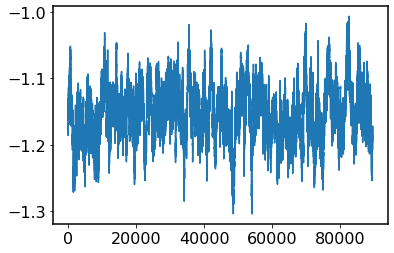

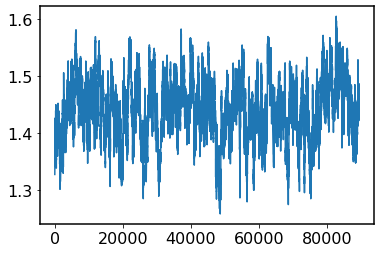

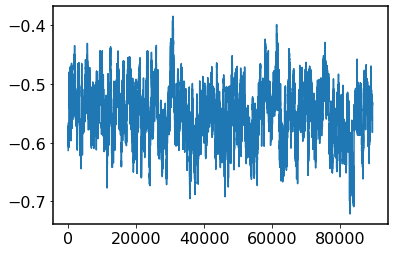

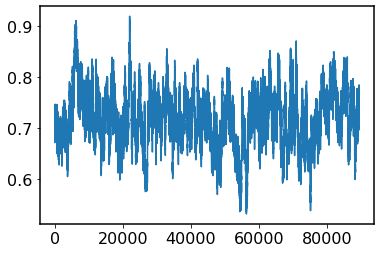

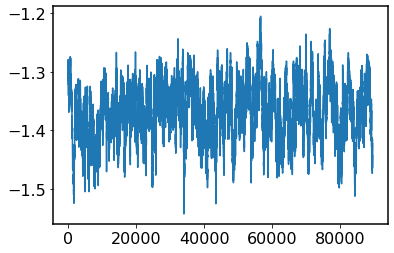

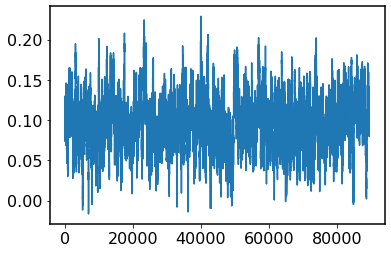

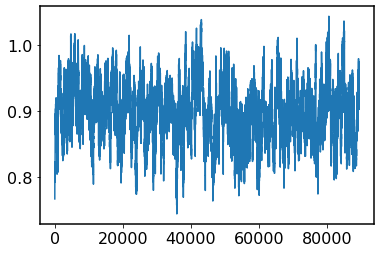

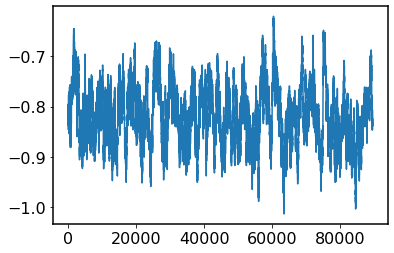

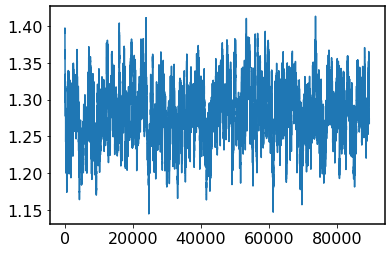

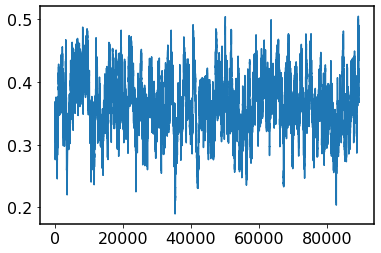

In [4]:
for ii in range(10):
    plt.plot(samples[:,ii])
    plt.show()

In [7]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

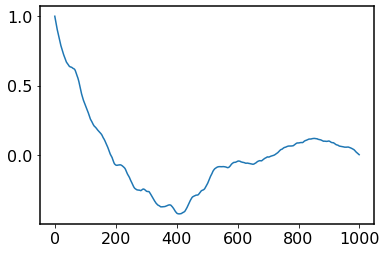

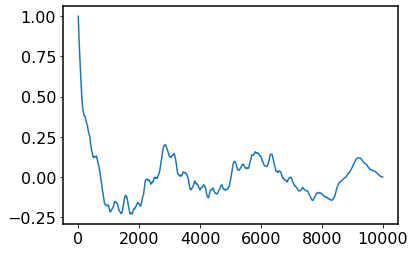

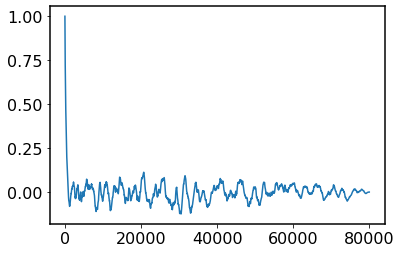

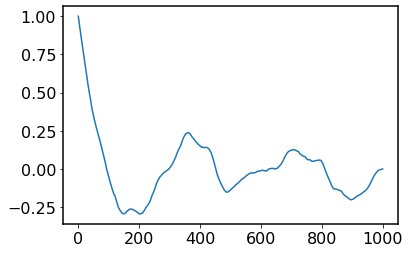

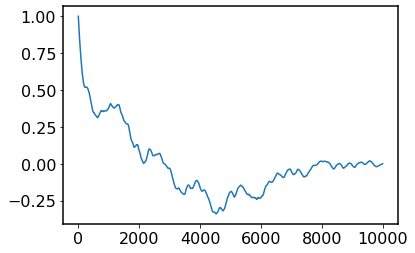

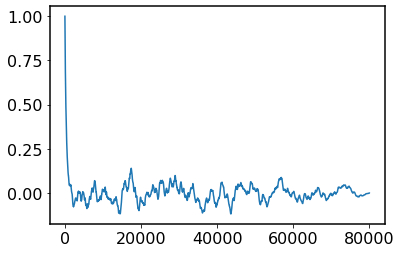

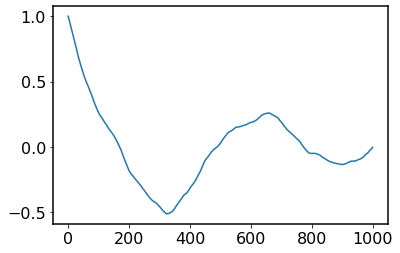

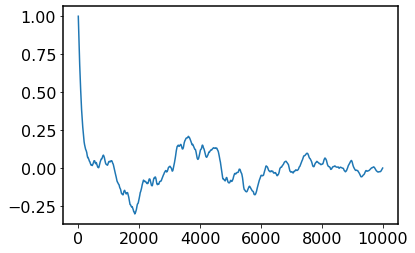

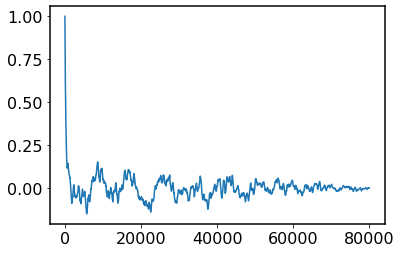

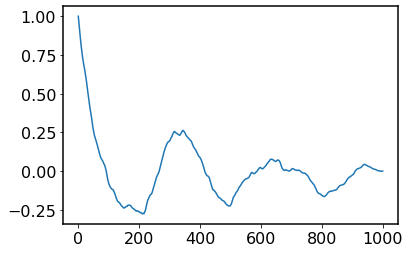

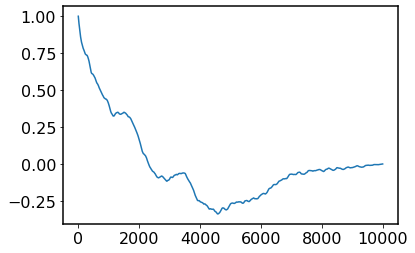

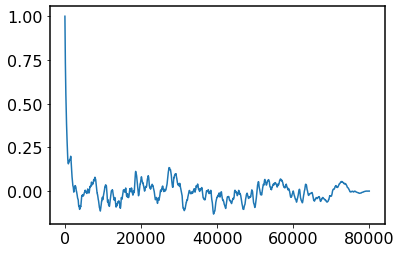

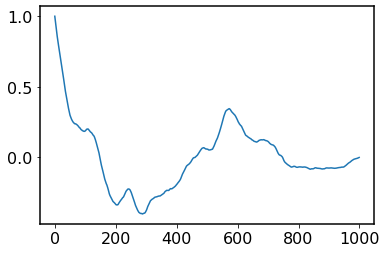

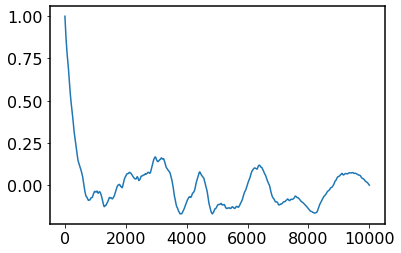

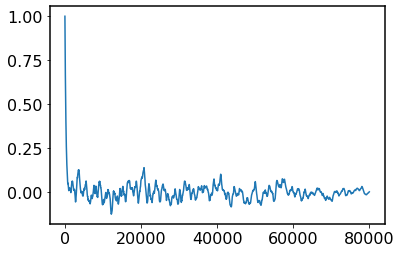

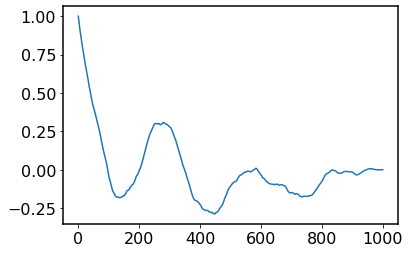

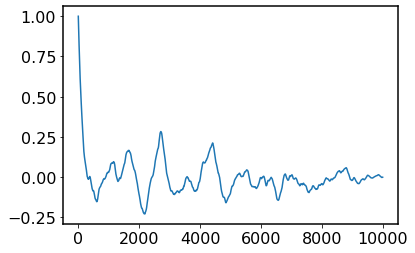

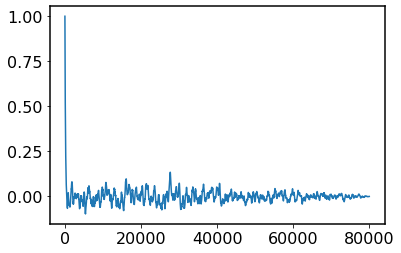

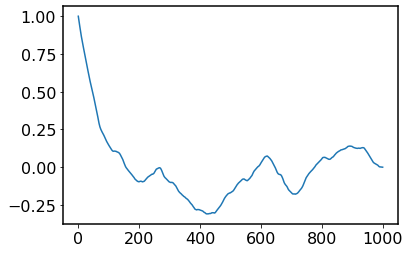

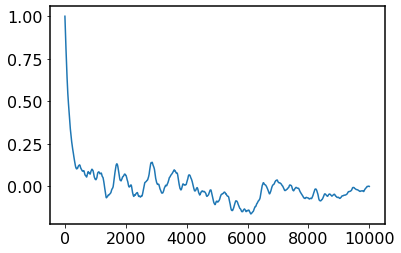

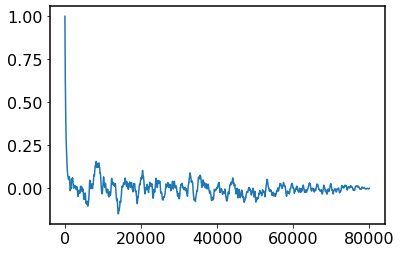

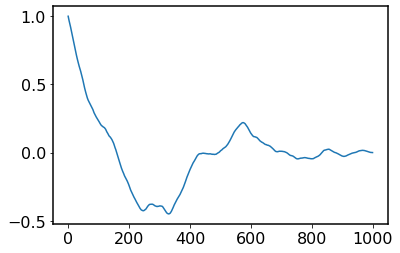

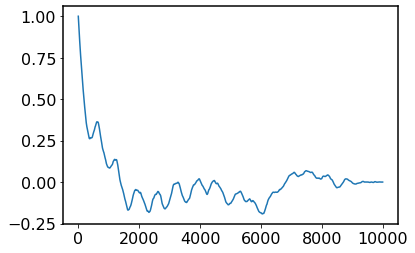

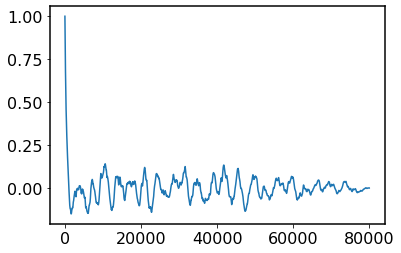

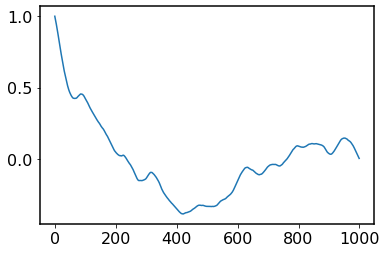

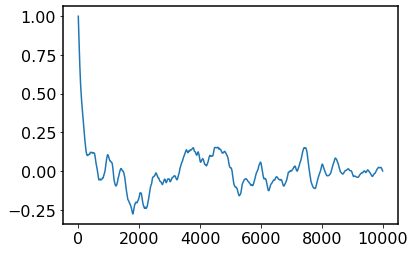

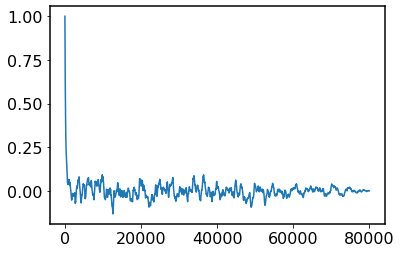

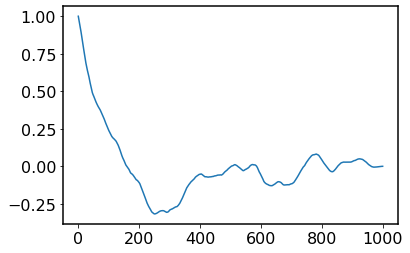

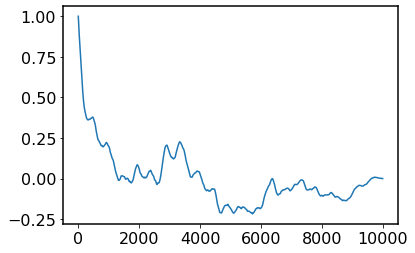

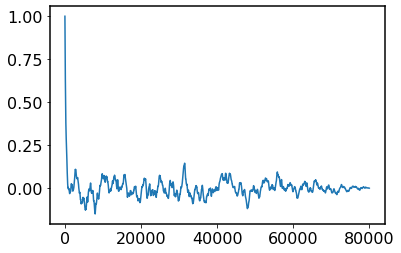

In [8]:
for ii in range(10):
    for n in [1000,10000,80000]:
        acf = autocorr_func_1d(samples[:n,ii], norm=True)
        plt.plot(acf)
        plt.show()

In [9]:
# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1


# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]


def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

In [12]:
samples.shape

(89500, 10)

In [13]:
samples = np.reshape(samples,(-1,89500,10))


In [34]:
N = np.exp(np.linspace(np.log(100), np.log(samples.shape[1]), 20)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
for jj in range(10):
    for i, n in enumerate(N):
        gw2010[i] = autocorr_gw2010(samples[:, :n,jj])
        new[i] = autocorr_new(samples[:, :n,jj])
    tau_esti = np.mean(new[-4:])
    print(tau_esti)

423.3231881028314
702.3813275060247
558.7887629522443
912.1093460946797
857.9236291305116
225.3738963768148
516.5848764674023
461.5133950344077
409.88095760324836
648.6349831311586


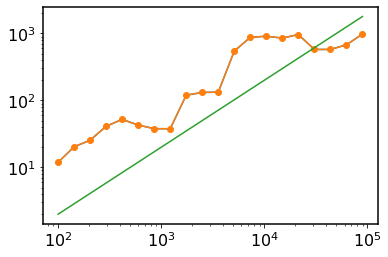

In [31]:
plt.loglog(N,gw2010)
plt.loglog(N,new, marker='o')
plt.loglog(N, N/50)

127.4236607595926